In [1]:
import numpy as np
import tensorflow as tf
import tflearn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from collections import deque
import random

In [3]:
class ReplayBuffer(object):

    def __init__(self, buffer_size, random_seed=123):
        """
        The right side of the deque contains the most recent experiences 
        """
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()
        random.seed(random_seed)

    def add(self, s, a, r, t, s2):
        experience = (s, a, r, t, s2)
        if self.count < self.buffer_size: 
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample_batch(self, batch_size):
        batch = []

        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, batch_size)

        s_batch = np.array([_[0] for _ in batch])
        a_batch = np.array([_[1] for _ in batch])
        r_batch = np.array([_[2] for _ in batch])
        t_batch = np.array([_[3] for _ in batch])
        s2_batch = np.array([_[4] for _ in batch])

        return s_batch, a_batch, r_batch, t_batch, s2_batch

    def clear(self):
        self.deque.clear()
        self.count = 0

In [4]:
class ActorNetwork:
    def __init__(self, session, s_dim, a_dim, action_bound, learning_rate, tau):
        self.session = session
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.action_bound = action_bound
        self.learning_rate = learning_rate
        self.tau = tau
        
        self.inputs, self.out, self.scaled_out = self._create_actor_network()
        self.network_params = tf.trainable_variables()


        self.target_inputs, self.target_out, self.target_scaled_out = self._create_actor_network()
        self.target_network_params = tf.trainable_variables()[len(self.network_params):]
        
        self.action_gradient = tf.placeholder(tf.float32, [None, self.a_dim])
        
        self.actor_gradients = tf.gradients(self.out, self.network_params, -self.action_gradient)
        
        self.optimize = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate).apply_gradients(zip(self.actor_gradients, self.network_params))

        self.num_trainable_vars = len(self.network_params) + len(self.target_network_params)

#         print(self.target_network_params[0].shape)

        self.update_target_network_params = \
            [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau) + 
                                                  tf.multiply(self.target_network_params[i], 1. - self.tau)) 
                for i in range(len(self.target_network_params))]

    def get_num_trainable_vars(self):
        return self.num_trainable_vars

    def _create_actor_network(self):
        inputs = tflearn.input_data(shape=[None, self.s_dim])
        net = tflearn.fully_connected(inputs, 8, activation='sigmoid')
        net = tflearn.fully_connected(net, 8, activation='sigmoid')
        out = tflearn.fully_connected(net, self.a_dim, activation='sigmoid')
        scaled_out = tf.multiply(out, self.action_bound)
        return inputs, out, scaled_out

    def predict(self, inputs):
        return self.session.run(self.scaled_out, feed_dict={
            self.inputs: inputs
        })

    def predict_target(self, inputs):
        return self.session.run(self.target_scaled_out, feed_dict={
            self.target_inputs: inputs
        })

    def train(self, inputs, a_gradient):
        return self.session.run(self.optimize, feed_dict={
            self.inputs: inputs,
            self.action_gradient: a_gradient
        })

    def update_target_network(self):
        self.session.run(self.update_target_network_params)

In [5]:
class CriticNetwork:
    def __init__(self, sess, state_dim, action_dim, learning_rate, tau, num_actors_vars):
        self.sess = sess
        self.s_dim = state_dim
        self.a_dim = action_dim
        self.learning_rate = learning_rate
        self.tau = tau
        #self.gamma = gamma
        
        self.inputs, self.action, self.out = self._create_critic_network()
        
        self.network_params = tf.trainable_variables()[num_actors_vars:]

        self.target_inputs, self.target_action, self.target_out = self._create_critic_network()

        self.target_network_params = tf.trainable_variables()[(len(self.network_params) + num_actors_vars):]

        self.update_target_network_params = \
            [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau) \
                                                + tf.multiply(self.target_network_params[i], 1. - self.tau)) \
                for i in range(len(self.target_network_params))]

        self.predicted_q_value = tf.placeholder(tf.float32, [None, 1])

        self.loss = tflearn.mean_square(self.predicted_q_value, self.out)
        self.optimize = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

        self.action_grads = tf.gradients(self.out, self.action)

    def _create_critic_network(self):
        inputs = tflearn.input_data(shape=[None, self.s_dim])
        action = tflearn.input_data(shape=[None, self.a_dim])
        net = tflearn.fully_connected(inputs, 8, activation='sigmoid')
        
        t1 = tflearn.fully_connected(net, 8)
        t2 = tflearn.fully_connected(action, 8)
        
        net = tflearn.activation(tf.matmul(net, t1.W) + tf.matmul(action, t2.W) + t2.b, activation='sigmoid')
        
        out = tflearn.fully_connected(net, 1)
        return inputs, action, out

    def train(self, inputs, action, predicted_q_value):
        return self.sess.run([self.out, self.optimize], feed_dict={
            self.inputs: inputs,
            self.action: action,
            self.predicted_q_value: predicted_q_value
        })

    def predict(self, inputs, action):
        return self.sess.run(self.out, feed_dict={
            self.inputs: inputs,
            self.action: action
        })
    
    def predict_target(self, inputs, action):
        return self.sess.run(self.target_out, feed_dict={
            self.target_inputs: inputs,
            self.target_action: action
        })
    
    def action_gradients(self, inputs, actions):
        return self.sess.run(self.action_grads, feed_dict={
            self.inputs: inputs,
            self.action: actions
        })
    
    def update_target_network(self):
        self.sess.run(self.update_target_network_params)

In [6]:
class Env:
    def __init__(self, dims, vagas, lam=1):
        self.vagas = vagas
        self.mapa_vagas = np.zeros(dims)
        for vaga in self.vagas:
            self.mapa_vagas[vaga[0], vaga[1]] = 1
        self.vagas_ocupadas = np.zeros(len(self.vagas))
        self.qtd_vagas_ocupadas = 0
        self.lam = lam

    def step(self):
        k = np.random.poisson(lam=self.lam)
#         self.qtd_vagas_ocupadas += k
#         if self.qtd_vagas_ocupadas > len(self.vagas):
#             self.qtd_vagas_ocupadas = len(self.vagas)
        self.qtd_vagas_ocupadas = min(k, len(self.vagas))
        vagas_a_ocupar = np.random.choice(len(self.vagas), self.qtd_vagas_ocupadas, replace=False)
        self.vagas_ocupadas = np.zeros(len(self.vagas))
        for vaga_a_ocupar in vagas_a_ocupar:
            self.vagas_ocupadas[vaga_a_ocupar] = 1
    
    def get_map(self):
        m = np.zeros(self.mapa_vagas.shape)
        i = 0
        while i < len(self.vagas_ocupadas):
            if self.vagas_ocupadas[i] == 1:
                m[self.vagas[i][0], self.vagas[i][1]] = 1
            i += 1
        return m

In [7]:
epsilon = 0.2
batch_size = 16
gamma = 0.9
tau = 0.9

In [40]:
MAX_EP_STEPS = 12
BUFFER_SIZE = 1000000
MINIBATCH_SIZE = 64
MAX_EPISODES = 5000

In [58]:
def lambdaDeP(P):
    if(P <= 0): return 0
    if(P < 3): return (4 - (P*2/3))
    elif(P <= 5): return 2
    elif(P < 7): return (7 - (P))
    else: return 0

In [62]:
with tf.Session() as sess:
    
    mini_modelo_dims = (5,5)
    
    state_dim = mini_modelo_dims[0]*mini_modelo_dims[1]
    action_dim = 1
    action_bound = 9
    
    actor = ActorNetwork(sess, s_dim=state_dim, a_dim=action_dim, action_bound=action_bound, learning_rate=0.0001, tau=tau)
    
    critic = CriticNetwork(sess, state_dim, action_dim, 0.001, tau, actor.get_num_trainable_vars())

#     sess.run(tf.initialize_all_variables())
    sess.run(tf.global_variables_initializer())
    
    actor.update_target_network()
    critic.update_target_network()
    
    replay_buffer = ReplayBuffer(BUFFER_SIZE)
    
    env = Env(mini_modelo_dims, [(1, 1), (1, 3), (3, 1), (3, 3)])
    
    points = []

    for i in range(MAX_EPISODES):
        r_ep = np.zeros((1,1))
        for j in range(MAX_EP_STEPS):
            s = env.get_map()

            a = actor.predict(np.reshape(s, (1, actor.s_dim))) #+ .05*np.power(0.95, i)*(np.random.uniform() - .5)

            r = (env.qtd_vagas_ocupadas/len(env.vagas))* a
            print(a, r)

            r_ep += r
            
            env.lam = lambdaDeP(a)

            env.step()

            s2 = env.get_map()

            replay_buffer.add(np.reshape(s, (actor.s_dim,)), np.reshape(a, (actor.a_dim,)), r, j == MAX_EP_STEPS-1, np.reshape(s2, (actor.s_dim,)))

            if replay_buffer.size() > MINIBATCH_SIZE:
                s_batch, a_batch, r_batch, t_batch, s2_batch = replay_buffer.sample_batch(MINIBATCH_SIZE)

                target_q = critic.predict_target(s2_batch, actor.predict_target(s2_batch))

                y_i = []
                for k in range(MINIBATCH_SIZE):
                    if t_batch[k]:
                        y_i.append(r_batch[k])
                    else:
                        y_i.append(r_batch[k] + gamma * target_q[k])
                
                predicted_q_value, _ = critic.train(s_batch, a_batch, np.reshape(y_i, (MINIBATCH_SIZE, 1)))
                
                a_outs = actor.predict(s_batch)                
                grads = critic.action_gradients(s_batch, a_outs)
                actor.train(s_batch, grads[0])

                actor.update_target_network()
                critic.update_target_network()

        print(i, '=>', r_ep)
        points.append(r_ep[0,0])
        print()

[[ 4.58749151]] [[ 0.]]
[[ 4.58747864]] [[ 2.29373932]]
[[ 4.58748293]] [[ 4.58748293]]
[[ 4.58749151]] [[ 3.44061852]]
[[ 4.5874958]] [[ 1.14687395]]
[[ 4.58749199]] [[ 2.29374599]]
[[ 4.58748722]] [[ 1.14687181]]
[[ 4.58747864]] [[ 2.29373932]]
[[ 4.58749199]] [[ 2.29374599]]
[[ 4.58748293]] [[ 4.58748293]]
[[ 4.58749533]] [[ 2.29374766]]
[[ 4.58749151]] [[ 0.]]
0 => [[ 26.37804842]]

[[ 4.58748341]] [[ 3.44061255]]
[[ 4.58748245]] [[ 1.14687061]]
[[ 4.58748722]] [[ 2.29374361]]
[[ 4.5874958]] [[ 1.14687395]]
[[ 4.58749533]] [[ 2.29374766]]
[[ 4.58749533]] [[ 2.29374766]]
[[ 4.58748674]] [[ 3.44061518]]
[[ 4.5874958]] [[ 1.14687395]]
[[ 4.58749533]] [[ 2.29374766]]
[[ 4.58749151]] [[ 3.44061852]]
[[ 4.58749151]] [[ 0.]]
[[ 4.58749199]] [[ 2.29374599]]
1 => [[ 25.23119736]]

[[ 4.58748674]] [[ 3.44061518]]
[[ 4.58749056]] [[ 1.14687264]]
[[ 4.58748722]] [[ 1.14687181]]
[[ 4.58748293]] [[ 4.58748293]]
[[ 4.58749151]] [[ 0.]]
[[ 4.58749056]] [[ 1.14687264]]
[[ 4.58748722]] [[ 2.29374361

[[ 4.6232872]] [[ 0.]]
[[ 4.6235671]] [[ 2.31178355]]
[[ 4.62386417]] [[ 2.31193209]]
[[ 4.62417078]] [[ 2.31208539]]
[[ 4.62445974]] [[ 4.62445974]]
[[ 4.62475681]] [[ 4.62475681]]
[[ 4.62505054]] [[ 1.15626264]]
[[ 4.62533522]] [[ 2.31266761]]
[[ 4.62561893]] [[ 3.4692142]]
[[ 4.62591457]] [[ 1.15647864]]
[[ 4.62620878]] [[ 2.31310439]]
22 => [[ 31.21572661]]

[[ 4.62650013]] [[ 4.62650013]]
[[ 4.62680435]] [[ 1.15670109]]
[[ 4.62708759]] [[ 2.3135438]]
[[ 4.62738276]] [[ 0.]]
[[ 4.6276598]] [[ 3.47074485]]
[[ 4.62794685]] [[ 1.15698671]]
[[ 4.62824059]] [[ 1.15706015]]
[[ 4.62852383]] [[ 1.15713096]]
[[ 4.62880611]] [[ 4.62880611]]
[[ 4.62909651]] [[ 1.15727413]]
[[ 4.62938643]] [[ 1.15734661]]
[[ 4.6296773]] [[ 2.31483865]]
23 => [[ 24.29693317]]

[[ 4.62994766]] [[ 2.31497383]]
[[ 4.63022947]] [[ 3.47267199]]
[[ 4.63050747]] [[ 1.15762687]]
[[ 4.63079214]] [[ 0.]]
[[ 4.63107491]] [[ 0.]]
[[ 4.63135958]] [[ 2.31567979]]
[[ 4.63161707]] [[ 4.63161707]]
[[ 4.63190317]] [[ 2.31595159]

43 => [[ 28.08923781]]

[[ 4.68262148]] [[ 1.17065537]]
[[ 4.68279219]] [[ 3.51209402]]
[[ 4.6829648]] [[ 2.3414824]]
[[ 4.68311453]] [[ 4.68311453]]
[[ 4.68329287]] [[ 1.17082322]]
[[ 4.68345308]] [[ 3.51258993]]
[[ 4.68362284]] [[ 2.34181142]]
[[ 4.68380642]] [[ 0.]]
[[ 4.68396378]] [[ 1.17099094]]
[[ 4.68412828]] [[ 4.68412828]]
[[ 4.68430138]] [[ 1.17107534]]
[[ 4.68446445]] [[ 4.68446445]]
44 => [[ 30.44322991]]

[[ 4.68463373]] [[ 3.51347542]]
[[ 4.68480158]] [[ 2.34240079]]
[[ 4.68496084]] [[ 4.68496084]]
[[ 4.68512058]] [[ 1.17128015]]
[[ 4.68529272]] [[ 2.34264636]]
[[ 4.6854682]] [[ 1.17136705]]
[[ 4.68561172]] [[ 1.17140293]]
[[ 4.68579483]] [[ 4.68579483]]
[[ 4.68598175]] [[ 2.34299088]]
[[ 4.68614483]] [[ 2.34307241]]
[[ 4.68629456]] [[ 1.17157364]]
[[ 4.68645048]] [[ 3.51483774]]
45 => [[ 30.45580304]]

[[ 4.68663406]] [[ 0.]]
[[ 4.68680096]] [[ 3.51510072]]
[[ 4.68698072]] [[ 1.17174518]]
[[ 4.68713951]] [[ 0.]]
[[ 4.68728161]] [[ 3.51546121]]
[[ 4.68744612]] [[ 3.515584

[[ 4.72110844]] [[ 2.36055422]]
[[ 4.72122812]] [[ 4.72122812]]
[[ 4.72135735]] [[ 3.54101801]]
[[ 4.72146702]] [[ 4.72146702]]
[[ 4.72158146]] [[ 2.36079073]]
[[ 4.72171688]] [[ 1.18042922]]
66 => [[ 31.86741507]]

[[ 4.72183847]] [[ 2.36091924]]
[[ 4.72198057]] [[ 2.36099029]]
[[ 4.72208786]] [[ 1.18052197]]
[[ 4.72219896]] [[ 4.72219896]]
[[ 4.72234249]] [[ 1.18058562]]
[[ 4.72245789]] [[ 3.54184341]]
[[ 4.72257757]] [[ 3.54193306]]
[[ 4.72271299]] [[ 1.18067825]]
[[ 4.72283411]] [[ 2.36141706]]
[[ 4.7229557]] [[ 4.7229557]]
[[ 4.72309065]] [[ 3.54231787]]
[[ 4.72320414]] [[ 4.72320414]]
67 => [[ 35.41956556]]

[[ 4.72333527]] [[ 1.18083382]]
[[ 4.72345018]] [[ 4.72345018]]
[[ 4.72359943]] [[ 2.36179972]]
[[ 4.72371244]] [[ 0.]]
[[ 4.72381973]] [[ 3.5428648]]
[[ 4.72393942]] [[ 4.72393942]]
[[ 4.72406912]] [[ 3.54305172]]
[[ 4.72419834]] [[ 2.36209917]]
[[ 4.72431946]] [[ 1.18107986]]
[[ 4.72443867]] [[ 3.543329]]
[[ 4.72456169]] [[ 1.18114042]]
[[ 4.72467709]] [[ 1.18116927]]
68 =>

[[ 4.75225306]] [[ 4.75225306]]
[[ 4.75238228]] [[ 2.37619114]]
[[ 4.75250626]] [[ 0.]]
[[ 4.75262213]] [[ 2.37631106]]
[[ 4.75273037]] [[ 0.]]
89 => [[ 23.75992119]]

[[ 4.75282812]] [[ 0.]]
[[ 4.7529192]] [[ 3.5646894]]
[[ 4.75303078]] [[ 2.37651539]]
[[ 4.75314331]] [[ 1.18828583]]
[[ 4.75324678]] [[ 4.75324678]]
[[ 4.75336027]] [[ 3.56502008]]
[[ 4.75345755]] [[ 4.75345755]]
[[ 4.75359249]] [[ 1.18839812]]
[[ 4.75369453]] [[ 0.]]
[[ 4.75379992]] [[ 2.37689996]]
[[ 4.75391626]] [[ 2.37695813]]
[[ 4.75401974]] [[ 2.37700987]]
90 => [[ 28.52048111]]

[[ 4.75412464]] [[ 4.75412464]]
[[ 4.75422335]] [[ 3.56566763]]
[[ 4.75435734]] [[ 2.37717867]]
[[ 4.75444794]] [[ 3.56583595]]
[[ 4.7545619]] [[ 2.37728095]]
[[ 4.75465631]] [[ 2.37732816]]
[[ 4.75475693]] [[ 4.75475693]]
[[ 4.75487471]] [[ 0.]]
[[ 4.75497675]] [[ 3.56623268]]
[[ 4.75508022]] [[ 3.56631017]]
[[ 4.75518417]] [[ 2.37759209]]
[[ 4.75529623]] [[ 0.]]
91 => [[ 33.28230786]]

[[ 4.75539589]] [[ 2.37769794]]
[[ 4.75550604]] [[ 

[[ 4.78070068]] [[ 2.39035034]]
[[ 4.78083515]] [[ 0.]]
[[ 4.78095007]] [[ 0.]]
[[ 4.78105927]] [[ 4.78105927]]
[[ 4.78117418]] [[ 4.78117418]]
[[ 4.78131914]] [[ 1.19532979]]
[[ 4.78142595]] [[ 2.39071298]]
111 => [[ 25.0994463]]

[[ 4.78152418]] [[ 2.39076209]]
[[ 4.78165293]] [[ 4.78165293]]
[[ 4.78179359]] [[ 0.]]
[[ 4.7819066]] [[ 4.7819066]]
[[ 4.7820344]] [[ 1.1955086]]
[[ 4.78213787]] [[ 1.19553447]]
[[ 4.78226709]] [[ 0.]]
[[ 4.78237581]] [[ 0.]]
[[ 4.78248882]] [[ 0.]]
[[ 4.78261375]] [[ 0.]]
[[ 4.78272533]] [[ 0.]]
[[ 4.78283787]] [[ 2.39141893]]
112 => [[ 16.73678362]]

[[ 4.78296232]] [[ 0.]]
[[ 4.78308201]] [[ 2.391541]]
[[ 4.78319693]] [[ 1.19579923]]
[[ 4.78331375]] [[ 2.39165688]]
[[ 4.7834096]] [[ 3.58755732]]
[[ 4.78352404]] [[ 3.58764315]]
[[ 4.78365898]] [[ 1.19591475]]
[[ 4.7837801]] [[ 1.19594502]]
[[ 4.78387594]] [[ 2.39193797]]
[[ 4.78398323]] [[ 4.78398323]]
[[ 4.78409624]] [[ 2.39204812]]
[[ 4.78422165]] [[ 3.58816624]]
113 => [[ 28.7021929]]

[[ 4.78434944]]

[[ 4.8137846]] [[ 0.]]
[[ 4.81391382]] [[ 2.40695691]]
[[ 4.81405544]] [[ 2.40702772]]
[[ 4.81423569]] [[ 2.40711784]]
[[ 4.81437588]] [[ 3.61078191]]
[[ 4.81454945]] [[ 2.40727472]]
132 => [[ 30.08559239]]

[[ 4.8146944]] [[ 1.2036736]]
[[ 4.81486273]] [[ 3.61114693]]
[[ 4.81502581]] [[ 1.20375645]]
[[ 4.81517076]] [[ 2.40758538]]
[[ 4.81533194]] [[ 4.81533194]]
[[ 4.81549597]] [[ 1.20387399]]
[[ 4.81564665]] [[ 0.]]
[[ 4.81581497]] [[ 0.]]
[[ 4.81599283]] [[ 0.]]
[[ 4.81613302]] [[ 2.40806651]]
[[ 4.81633377]] [[ 1.20408344]]
[[ 4.81650162]] [[ 1.2041254]]
133 => [[ 19.26164365]]

[[ 4.81667423]] [[ 3.61250567]]
[[ 4.81682777]] [[ 4.81682777]]
[[ 4.81700659]] [[ 2.40850329]]
[[ 4.81718159]] [[ 1.2042954]]
[[ 4.81739044]] [[ 0.]]
[[ 4.81753731]] [[ 1.20438433]]
[[ 4.81767702]] [[ 4.81767702]]
[[ 4.81786251]] [[ 2.40893126]]
[[ 4.81804132]] [[ 1.20451033]]
[[ 4.81819916]] [[ 1.20454979]]
[[ 4.81834888]] [[ 1.20458722]]
[[ 4.81849957]] [[ 4.81849957]]
134 => [[ 28.90527165]]

[[ 4.81866

[[ 4.87716246]] [[ 3.65787172]]
[[ 4.87753057]] [[ 2.43876529]]
[[ 4.8780117]] [[ 3.65850878]]
[[ 4.87841129]] [[ 2.43920565]]
[[ 4.87888098]] [[ 0.]]
[[ 4.87939692]] [[ 3.65954781]]
[[ 4.87990952]] [[ 4.87990952]]
[[ 4.88033628]] [[ 1.22008407]]
[[ 4.88074493]] [[ 3.6605587]]
[[ 4.88118744]] [[ 1.22029686]]
[[ 4.88160372]] [[ 2.44080186]]
154 => [[ 31.71393216]]

[[ 4.8821311]] [[ 3.66159821]]
[[ 4.88253355]] [[ 2.44126678]]
[[ 4.88298607]] [[ 3.66223955]]
[[ 4.88343906]] [[ 0.]]
[[ 4.88383579]] [[ 1.22095895]]
[[ 4.88430834]] [[ 1.22107708]]
[[ 4.88472462]] [[ 2.44236231]]
[[ 4.88508797]] [[ 4.88508797]]
[[ 4.88559055]] [[ 1.22139764]]
[[ 4.88608932]] [[ 1.22152233]]
[[ 4.88654804]] [[ 4.88654804]]
[[ 4.88711643]] [[ 1.22177911]]
155 => [[ 28.08583796]]

[[ 4.88755989]] [[ 1.22188997]]
[[ 4.88800764]] [[ 2.44400382]]
[[ 4.88844109]] [[ 2.44422054]]
[[ 4.88886833]] [[ 3.66665125]]
[[ 4.88944387]] [[ 0.]]
[[ 4.88996172]] [[ 0.]]
[[ 4.89048719]] [[ 2.4452436]]
[[ 4.89098883]] [[ 2.44549

[[ 4.93898058]] [[ 3.70423555]]
[[ 4.93832111]] [[ 0.]]
[[ 4.93771267]] [[ 4.93771267]]
[[ 4.93704033]] [[ 0.]]
[[ 4.93634748]] [[ 1.23408687]]
[[ 4.93561506]] [[ 0.]]
[[ 4.93484068]] [[ 2.46742034]]
[[ 4.93413019]] [[ 2.4670651]]
[[ 4.93337631]] [[ 1.23334408]]
[[ 4.9325552]] [[ 0.]]
175 => [[ 18.51396954]]

[[ 4.93169498]] [[ 2.46584749]]
[[ 4.93090963]] [[ 1.23272741]]
[[ 4.93007898]] [[ 2.46503949]]
[[ 4.92938137]] [[ 3.69703603]]
[[ 4.9285264]] [[ 1.2321316]]
[[ 4.92763519]] [[ 4.92763519]]
[[ 4.9267292]] [[ 2.4633646]]
[[ 4.92593575]] [[ 4.92593575]]
[[ 4.92520332]] [[ 0.]]
[[ 4.92430019]] [[ 4.92430019]]
[[ 4.92347527]] [[ 1.23086882]]
[[ 4.92269802]] [[ 4.92269802]]
176 => [[ 34.48758459]]

[[ 4.92191362]] [[ 1.23047841]]
[[ 4.92104816]] [[ 3.69078612]]
[[ 4.92023945]] [[ 0.]]
[[ 4.91949415]] [[ 1.22987354]]
[[ 4.91862345]] [[ 2.45931172]]
[[ 4.91792631]] [[ 1.22948158]]
[[ 4.91700935]] [[ 2.45850468]]
[[ 4.91605759]] [[ 1.2290144]]
[[ 4.91528893]] [[ 3.68646669]]
[[ 4.91445255

[[ 4.6928277]] [[ 4.6928277]]
[[ 4.69174385]] [[ 1.17293596]]
[[ 4.69071531]] [[ 2.34535766]]
[[ 4.68963242]] [[ 0.]]
[[ 4.68861818]] [[ 2.34430909]]
[[ 4.68735933]] [[ 1.17183983]]
[[ 4.68626642]] [[ 1.17156661]]
[[ 4.68524885]] [[ 2.34262443]]
[[ 4.68412495]] [[ 3.51309371]]
[[ 4.68323231]] [[ 3.51242423]]
197 => [[ 23.44072437]]

[[ 4.6820159]] [[ 1.17050397]]
[[ 4.68103981]] [[ 3.51077986]]
[[ 4.68000507]] [[ 2.34000254]]
[[ 4.67899513]] [[ 3.50924635]]
[[ 4.6780014]] [[ 3.50850105]]
[[ 4.67684841]] [[ 1.1692121]]
[[ 4.67583799]] [[ 1.1689595]]
[[ 4.67490196]] [[ 4.67490196]]
[[ 4.67381144]] [[ 1.16845286]]
[[ 4.672925]] [[ 1.16823125]]
[[ 4.67175722]] [[ 3.50381804]]
[[ 4.67076778]] [[ 1.16769195]]
198 => [[ 28.06030142]]

[[ 4.6696887]] [[ 1.16742218]]
[[ 4.66866636]] [[ 2.33433318]]
[[ 4.66761398]] [[ 1.1669035]]
[[ 4.66654921]] [[ 2.3332746]]
[[ 4.66545534]] [[ 0.]]
[[ 4.66438961]] [[ 0.]]
[[ 4.66346025]] [[ 2.33173013]]
[[ 4.66231966]] [[ 2.33115983]]
[[ 4.66135693]] [[ 3.4960

[[ 4.39495659]] [[ 2.19747829]]
[[ 4.39371014]] [[ 4.39371014]]
[[ 4.39254475]] [[ 0.]]
[[ 4.39132261]] [[ 2.19566131]]
[[ 4.39010143]] [[ 0.]]
[[ 4.38886118]] [[ 1.09721529]]
[[ 4.38754702]] [[ 2.19377351]]
[[ 4.38605356]] [[ 0.]]
218 => [[ 23.07244301]]

[[ 4.38473797]] [[ 1.09618449]]
[[ 4.38338614]] [[ 2.19169307]]
[[ 4.38191986]] [[ 3.2864399]]
[[ 4.3807435]] [[ 4.3807435]]
[[ 4.379426]] [[ 2.189713]]
[[ 4.37800264]] [[ 2.18900132]]
[[ 4.37631702]] [[ 1.09407926]]
[[ 4.3750205]] [[ 0.]]
[[ 4.37360525]] [[ 2.18680263]]
[[ 4.37225342]] [[ 3.27919006]]
[[ 4.37089062]] [[ 2.18544531]]
[[ 4.3693347]] [[ 2.18466735]]
219 => [[ 26.26395988]]

[[ 4.36783409]] [[ 3.27587557]]
[[ 4.36623859]] [[ 4.36623859]]
[[ 4.36470985]] [[ 3.27353239]]
[[ 4.36350298]] [[ 3.27262735]]
[[ 4.362041]] [[ 2.1810205]]
[[ 4.36064339]] [[ 4.36064339]]
[[ 4.35924625]] [[ 1.08981156]]
[[ 4.35780001]] [[ 0.]]
[[ 4.35636187]] [[ 3.26727152]]
[[ 4.35497236]] [[ 3.26622915]]
[[ 4.35340643]] [[ 2.17670321]]
[[ 4.35204

[[ 4.02809715]] [[ 1.00702429]]
[[ 4.0261426]] [[ 0.]]
[[ 4.02448082]] [[ 4.02448082]]
240 => [[ 13.10311508]]

[[ 4.02288198]] [[ 2.01144099]]
[[ 4.02108383]] [[ 1.00527096]]
[[ 4.01945162]] [[ 4.01945162]]
[[ 4.01760864]] [[ 2.00880432]]
[[ 4.01572847]] [[ 3.01179647]]
[[ 4.01385355]] [[ 4.01385355]]
[[ 4.01197672]] [[ 0.]]
[[ 4.01016712]] [[ 0.]]
[[ 4.00828314]] [[ 2.00414157]]
[[ 4.00664043]] [[ 2.00332022]]
[[ 4.00435209]] [[ 4.00435209]]
[[ 4.00262165]] [[ 1.00065541]]
241 => [[ 25.08308721]]

[[ 4.00096416]] [[ 4.00096416]]
[[ 3.99914217]] [[ 0.]]
[[ 3.99757624]] [[ 3.99757624]]
[[ 3.99603486]] [[ 0.99900872]]
[[ 3.99414587]] [[ 2.99560928]]
[[ 3.9923408]] [[ 1.9961704]]
[[ 3.99066806]] [[ 0.99766701]]
[[ 3.98883557]] [[ 1.99441779]]
[[ 3.9871881]] [[ 1.99359405]]
[[ 3.98540711]] [[ 0.99635178]]
[[ 3.98379469]] [[ 3.98379469]]
[[ 3.9819603]] [[ 0.]]
242 => [[ 23.95515412]]

[[ 3.98030424]] [[ 0.99507606]]
[[ 3.97863698]] [[ 0.99465925]]
[[ 3.97691941]] [[ 0.99422985]]
[[ 3.97533

[[ 3.67690134]] [[ 2.75767612]]
[[ 3.67585111]] [[ 0.91896278]]
[[ 3.67458177]] [[ 0.91864544]]
[[ 3.67337465]] [[ 0.91834366]]
[[ 3.67206812]] [[ 2.75405121]]
261 => [[ 26.67901844]]

[[ 3.67084479]] [[ 2.75313354]]
[[ 3.66943884]] [[ 1.83471942]]
[[ 3.66817379]] [[ 2.75113034]]
[[ 3.66686201]] [[ 2.75014639]]
[[ 3.66560888]] [[ 1.83280444]]
[[ 3.66432238]] [[ 1.83216119]]
[[ 3.66307354]] [[ 1.83153677]]
[[ 3.66183352]] [[ 1.83091676]]
[[ 3.66063643]] [[ 1.83031821]]
[[ 3.65941787]] [[ 0.91485447]]
[[ 3.65812731]] [[ 0.91453183]]
[[ 3.65710449]] [[ 1.82855225]]
262 => [[ 22.9048056]]

[[ 3.65568852]] [[ 0.]]
[[ 3.65449286]] [[ 0.91362321]]
[[ 3.65314698]] [[ 2.7398603]]
[[ 3.65171647]] [[ 3.65171647]]
[[ 3.65051723]] [[ 1.82525861]]
[[ 3.64919257]] [[ 0.91229814]]
[[ 3.64795351]] [[ 1.82397676]]
[[ 3.64654088]] [[ 1.82327044]]
[[ 3.64506698]] [[ 0.91126674]]
[[ 3.64375138]] [[ 0.91093785]]
[[ 3.64225817]] [[ 0.91056454]]
[[ 3.64100885]] [[ 0.91025221]]
263 => [[ 17.33302528]]

[[ 3.63

[[ 3.25215507]] [[ 2.43911624]]
[[ 3.25045013]] [[ 0.81261253]]
283 => [[ 17.11185479]]

[[ 3.24903655]] [[ 2.43677735]]
[[ 3.2473774]] [[ 0.81184435]]
[[ 3.24570894]] [[ 1.62285447]]
[[ 3.24400949]] [[ 0.81100237]]
[[ 3.24250984]] [[ 1.62125492]]
[[ 3.24088192]] [[ 1.62044096]]
[[ 3.23954797]] [[ 3.23954797]]
[[ 3.23795867]] [[ 1.61897933]]
[[ 3.23636603]] [[ 1.61818302]]
[[ 3.23475218]] [[ 1.61737609]]
[[ 3.23320675]] [[ 2.42490506]]
[[ 3.23174262]] [[ 2.42380691]]
284 => [[ 21.8669728]]

[[ 3.23008108]] [[ 0.80752027]]
[[ 3.22868299]] [[ 3.22868299]]
[[ 3.22712517]] [[ 1.61356258]]
[[ 3.2255249]] [[ 1.61276245]]
[[ 3.22389531]] [[ 2.41792154]]
[[ 3.22218776]] [[ 0.80554694]]
[[ 3.22073436]] [[ 2.41555071]]
[[ 3.2191186]] [[ 1.6095593]]
[[ 3.21750069]] [[ 2.41312551]]
[[ 3.21578026]] [[ 3.21578026]]
[[ 3.21418858]] [[ 3.21418858]]
[[ 3.21257758]] [[ 2.40943313]]
285 => [[ 25.76363426]]

[[ 3.21107531]] [[ 2.4083066]]
[[ 3.20940208]] [[ 1.60470104]]
[[ 3.20787311]] [[ 0.]]
[[ 3.206475

[[ 2.88445115]] [[ 2.16333842]]
[[ 2.88323236]] [[ 0.]]
[[ 2.88218975]] [[ 2.88218975]]
[[ 2.8811481]] [[ 2.16086102]]
[[ 2.87986374]] [[ 0.71996593]]
306 => [[ 23.09046525]]

[[ 2.8787353]] [[ 1.43936765]]
[[ 2.87751102]] [[ 2.15813327]]
[[ 2.87642503]] [[ 0.71910626]]
[[ 2.87553358]] [[ 1.43776679]]
[[ 2.87433338]] [[ 2.87433338]]
[[ 2.87315297]] [[ 1.43657649]]
[[ 2.87210703]] [[ 0.71802676]]
[[ 2.87097907]] [[ 2.15323424]]
[[ 2.86983418]] [[ 0.]]
[[ 2.86882138]] [[ 2.1516161]]
[[ 2.86760831]] [[ 1.43380415]]
[[ 2.86650395]] [[ 1.43325198]]
307 => [[ 17.95521706]]

[[ 2.86553884]] [[ 0.71638471]]
[[ 2.86426497]] [[ 0.71606624]]
[[ 2.86309218]] [[ 2.14731908]]
[[ 2.86186886]] [[ 0.]]
[[ 2.86065388]] [[ 0.]]
[[ 2.85959554]] [[ 1.42979777]]
[[ 2.85832596]] [[ 2.85832596]]
[[ 2.85712671]] [[ 0.71428168]]
[[ 2.85580444]] [[ 1.42790222]]
[[ 2.85458946]] [[ 2.85458946]]
[[ 2.85346365]] [[ 0.71336591]]
[[ 2.85237074]] [[ 2.85237074]]
308 => [[ 16.43040377]]

[[ 2.85115981]] [[ 2.85115981]]


[[ 2.60403228]] [[ 0.65100807]]
[[ 2.60307503]] [[ 1.30153751]]
[[ 2.60215425]] [[ 1.95161569]]
[[ 2.60104108]] [[ 0.]]
[[ 2.60017395]] [[ 1.95013046]]
[[ 2.59927058]] [[ 0.]]
[[ 2.59826565]] [[ 0.64956641]]
[[ 2.59725595]] [[ 2.59725595]]
[[ 2.59616852]] [[ 1.29808426]]
[[ 2.59517074]] [[ 0.]]
[[ 2.59417892]] [[ 0.]]
329 => [[ 12.35289174]]

[[ 2.59327531]] [[ 0.64831883]]
[[ 2.59225321]] [[ 1.2961266]]
[[ 2.59126472]] [[ 1.94344854]]
[[ 2.59014177]] [[ 1.29507089]]
[[ 2.58920026]] [[ 0.64730006]]
[[ 2.58808732]] [[ 0.64702183]]
[[ 2.58728957]] [[ 1.94046712]]
[[ 2.58618212]] [[ 2.58618212]]
[[ 2.58506918]] [[ 0.64626729]]
[[ 2.58420157]] [[ 0.64605039]]
[[ 2.58298898]] [[ 0.]]
[[ 2.58187556]] [[ 0.64546889]]
330 => [[ 12.94172257]]

[[ 2.58089852]] [[ 0.]]
[[ 2.57986045]] [[ 0.]]
[[ 2.57887959]] [[ 1.2894398]]
[[ 2.57785606]] [[ 0.64446402]]
[[ 2.57677031]] [[ 2.57677031]]
[[ 2.57575083]] [[ 1.93181312]]
[[ 2.57468247]] [[ 0.]]
[[ 2.57370043]] [[ 1.28685021]]
[[ 2.57261157]] [[ 1.286

[[ 2.3615551]] [[ 0.59038877]]
[[ 2.36085129]] [[ 0.]]
[[ 2.36014724]] [[ 0.59003681]]
[[ 2.35936356]] [[ 1.17968178]]
[[ 2.35867214]] [[ 0.58966804]]
[[ 2.35783744]] [[ 0.58945936]]
[[ 2.35719609]] [[ 2.35719609]]
351 => [[ 11.80768692]]

[[ 2.35634685]] [[ 0.58908671]]
[[ 2.35556746]] [[ 0.58889186]]
[[ 2.35479116]] [[ 1.76609337]]
[[ 2.35397863]] [[ 2.35397863]]
[[ 2.35318494]] [[ 1.17659247]]
[[ 2.35249496]] [[ 0.58812374]]
[[ 2.3517971]] [[ 1.17589855]]
[[ 2.35113764]] [[ 1.17556882]]
[[ 2.35017395]] [[ 0.58754349]]
[[ 2.34952974]] [[ 2.34952974]]
[[ 2.34880614]] [[ 0.58720154]]
[[ 2.34793472]] [[ 1.17396736]]
352 => [[ 14.11247629]]

[[ 2.34719634]] [[ 1.7603972]]
[[ 2.34640551]] [[ 1.75980413]]
[[ 2.34574771]] [[ 2.34574771]]
[[ 2.34504056]] [[ 1.75878048]]
[[ 2.34417367]] [[ 1.17208683]]
[[ 2.34363127]] [[ 0.58590782]]
[[ 2.34291697]] [[ 2.34291697]]
[[ 2.34213948]] [[ 2.34213948]]
[[ 2.34141588]] [[ 2.34141588]]
[[ 2.34060669]] [[ 1.17030334]]
[[ 2.34002924]] [[ 2.34002924]]
[

372 => [[ 18.82362521]]

[[ 2.21256304]] [[ 2.21256304]]
[[ 2.21219087]] [[ 1.10609543]]
[[ 2.21180606]] [[ 0.]]
[[ 2.21141744]] [[ 0.]]
[[ 2.21108532]] [[ 1.10554266]]
[[ 2.21079397]] [[ 2.21079397]]
[[ 2.2104466]] [[ 0.55261165]]
[[ 2.21007419]] [[ 1.10503709]]
[[ 2.20975566]] [[ 1.65731668]]
[[ 2.20944428]] [[ 1.10472214]]
[[ 2.20897937]] [[ 1.10448968]]
[[ 2.20866466]] [[ 2.20866466]]
373 => [[ 14.36783701]]

[[ 2.20828414]] [[ 0.]]
[[ 2.20800352]] [[ 2.20800352]]
[[ 2.20763993]] [[ 1.10381997]]
[[ 2.20732665]] [[ 1.65549493]]
[[ 2.20682383]] [[ 1.65511787]]
[[ 2.20646]] [[ 0.]]
[[ 2.20607519]] [[ 1.65455639]]
[[ 2.2057519]] [[ 2.2057519]]
[[ 2.20538664]] [[ 0.55134666]]
[[ 2.20505929]] [[ 1.65379453]]
[[ 2.2046988]] [[ 1.1023494]]
[[ 2.20424581]] [[ 2.20424581]]
374 => [[ 15.99448097]]

[[ 2.20380855]] [[ 1.65285635]]
[[ 2.20354676]] [[ 1.65266013]]
[[ 2.20312333]] [[ 1.10156167]]
[[ 2.20277762]] [[ 2.20277762]]
[[ 2.2024157]] [[ 2.2024157]]
[[ 2.20202422]] [[ 1.10101211]]
[[ 2.20

[[ 2.16289735]] [[ 0.54072434]]
393 => [[ 16.22509944]]

[[ 2.16279745]] [[ 2.16279745]]
[[ 2.16261292]] [[ 0.54065323]]
[[ 2.16262412]] [[ 1.08131206]]
[[ 2.16243792]] [[ 0.54060948]]
[[ 2.16229439]] [[ 1.08114719]]
[[ 2.16227269]] [[ 1.62170458]]
[[ 2.16233873]] [[ 1.08116937]]
[[ 2.16220045]] [[ 1.62165034]]
[[ 2.16202188]] [[ 1.08101094]]
[[ 2.16188407]] [[ 1.62141299]]
[[ 2.16189671]] [[ 1.62142253]]
[[ 2.16173482]] [[ 2.16173482]]
394 => [[ 16.21662498]]

[[ 2.1616292]] [[ 2.1616292]]
[[ 2.16150832]] [[ 2.16150832]]
[[ 2.16139531]] [[ 2.16139531]]
[[ 2.16126823]] [[ 2.16126823]]
[[ 2.16117454]] [[ 0.54029363]]
[[ 2.16103888]] [[ 1.08051944]]
[[ 2.16087818]] [[ 1.62065864]]
[[ 2.16075492]] [[ 1.62056613]]
[[ 2.16081476]] [[ 1.08040738]]
[[ 2.16061783]] [[ 2.16061783]]
[[ 2.16038942]] [[ 1.08019471]]
[[ 2.16034055]] [[ 0.54008514]]
395 => [[ 18.36914396]]

[[ 2.16033244]] [[ 2.16033244]]
[[ 2.16016936]] [[ 1.62012696]]
[[ 2.16006255]] [[ 0.54001564]]
[[ 2.15995932]] [[ 1.07997966]]

[[ 2.17161226]] [[ 2.17161226]]
[[ 2.17178965]] [[ 1.62884223]]
[[ 2.17185879]] [[ 2.17185879]]
[[ 2.17200708]] [[ 0.54300177]]
[[ 2.17206955]] [[ 0.]]
[[ 2.17220569]] [[ 0.]]
[[ 2.17228556]] [[ 0.54307139]]
[[ 2.17253065]] [[ 2.17253065]]
416 => [[ 15.74489331]]

[[ 2.17271543]] [[ 1.62953663]]
[[ 2.17275119]] [[ 0.5431878]]
[[ 2.17299294]] [[ 2.17299294]]
[[ 2.17307258]] [[ 0.54326814]]
[[ 2.17331791]] [[ 2.17331791]]
[[ 2.17348909]] [[ 2.17348909]]
[[ 2.17366052]] [[ 2.17366052]]
[[ 2.173769]] [[ 1.63032675]]
[[ 2.17410541]] [[ 1.0870527]]
[[ 2.174191]] [[ 2.174191]]
[[ 2.17436814]] [[ 2.17436814]]
[[ 2.17450976]] [[ 1.08725488]]
417 => [[ 19.56264651]]

[[ 2.17472458]] [[ 2.17472458]]
[[ 2.17483473]] [[ 1.63112605]]
[[ 2.17508173]] [[ 2.17508173]]
[[ 2.17518544]] [[ 0.54379636]]
[[ 2.17540956]] [[ 0.]]
[[ 2.17557216]] [[ 1.63167906]]
[[ 2.17578626]] [[ 1.08789313]]
[[ 2.17601323]] [[ 2.17601323]]
[[ 2.17615819]] [[ 0.]]
[[ 2.17639208]] [[ 2.17639208]]
[[ 2.17649245]] [[ 0.54412311]

[[ 2.25903416]] [[ 0.56475854]]
[[ 2.25956655]] [[ 1.69467497]]
[[ 2.26005411]] [[ 1.69504058]]
[[ 2.26066613]] [[ 1.69549966]]
[[ 2.26110196]] [[ 1.13055098]]
[[ 2.26148582]] [[ 1.13074291]]
[[ 2.26212931]] [[ 1.13106465]]
[[ 2.26252604]] [[ 0.56563151]]
[[ 2.26299214]] [[ 1.13149607]]
[[ 2.26370502]] [[ 1.13185251]]
[[ 2.26421642]] [[ 1.13210821]]
437 => [[ 14.69736099]]

[[ 2.264575]] [[ 1.69843125]]
[[ 2.26508689]] [[ 1.13254344]]
[[ 2.2655952]] [[ 1.1327976]]
[[ 2.26611972]] [[ 2.26611972]]
[[ 2.26659274]] [[ 1.13329637]]
[[ 2.26698089]] [[ 0.56674522]]
[[ 2.26759458]] [[ 2.26759458]]
[[ 2.26802969]] [[ 0.]]
[[ 2.26858926]] [[ 0.56714731]]
[[ 2.2691195]] [[ 1.70183969]]
[[ 2.26959348]] [[ 1.70219517]]
[[ 2.27003074]] [[ 1.13501537]]
438 => [[ 15.30372572]]

[[ 2.27052665]] [[ 1.13526332]]
[[ 2.27105927]] [[ 2.27105927]]
[[ 2.27159762]] [[ 1.70369816]]
[[ 2.27206302]] [[ 1.13603151]]
[[ 2.27257204]] [[ 2.27257204]]
[[ 2.27309084]] [[ 2.27309084]]
[[ 2.27358699]] [[ 2.27358699]]
[[ 

[[ 2.45472479]] [[ 2.45472479]]
[[ 2.45584273]] [[ 0.61396068]]
[[ 2.45698667]] [[ 1.84274006]]
[[ 2.45805836]] [[ 2.45805836]]
[[ 2.45903444]] [[ 0.61475861]]
[[ 2.46023512]] [[ 1.23011756]]
458 => [[ 16.56419307]]

[[ 2.46125555]] [[ 0.]]
[[ 2.46246529]] [[ 2.46246529]]
[[ 2.46353221]] [[ 1.2317661]]
[[ 2.46463966]] [[ 1.84847975]]
[[ 2.46574354]] [[ 2.46574354]]
[[ 2.46677399]] [[ 2.46677399]]
[[ 2.46789265]] [[ 2.46789265]]
[[ 2.46898675]] [[ 0.61724669]]
[[ 2.47016001]] [[ 1.23508]]
[[ 2.47111535]] [[ 0.61777884]]
[[ 2.4722333]] [[ 1.23611665]]
[[ 2.47337651]] [[ 2.47337651]]
459 => [[ 19.12272]]

[[ 2.47434473]] [[ 0.]]
[[ 2.47544098]] [[ 1.23772049]]
[[ 2.47660923]] [[ 2.47660923]]
[[ 2.47768831]] [[ 0.61942208]]
[[ 2.47870588]] [[ 1.23935294]]
[[ 2.47981501]] [[ 0.61995375]]
[[ 2.48089981]] [[ 1.86067486]]
[[ 2.48194051]] [[ 2.48194051]]
[[ 2.48293829]] [[ 0.62073457]]
[[ 2.48397899]] [[ 0.62099475]]
[[ 2.48502421]] [[ 2.48502421]]
[[ 2.48601675]] [[ 0.]]
460 => [[ 14.26242739]

[[ 2.77160382]] [[ 1.38580191]]
[[ 2.77307725]] [[ 2.77307725]]
[[ 2.77451086]] [[ 2.08088303]]
480 => [[ 20.75399816]]

[[ 2.77603626]] [[ 2.0820272]]
[[ 2.77746534]] [[ 0.]]
[[ 2.77888727]] [[ 1.38944364]]
[[ 2.7803874]] [[ 1.3901937]]
[[ 2.78196859]] [[ 0.69549215]]
[[ 2.78343272]] [[ 0.69585818]]
[[ 2.78475666]] [[ 0.69618917]]
[[ 2.78626084]] [[ 2.08969569]]
[[ 2.78780007]] [[ 0.69695002]]
[[ 2.78920317]] [[ 0.]]
[[ 2.79072022]] [[ 1.39536011]]
[[ 2.79216003]] [[ 0.]]
481 => [[ 11.13120985]]

[[ 2.79369617]] [[ 1.39684808]]
[[ 2.79516125]] [[ 2.09637094]]
[[ 2.79645753]] [[ 1.39822876]]
[[ 2.79794741]] [[ 0.]]
[[ 2.79942274]] [[ 2.79942274]]
[[ 2.80084443]] [[ 0.]]
[[ 2.80235767]] [[ 0.70058942]]
[[ 2.80385232]] [[ 1.40192616]]
[[ 2.80531168]] [[ 2.10398388]]
[[ 2.80680847]] [[ 0.]]
[[ 2.8083365]] [[ 2.8083365]]
[[ 2.80971575]] [[ 0.]]
482 => [[ 14.70570648]]

[[ 2.81115389]] [[ 0.70278847]]
[[ 2.81266403]] [[ 0.]]
[[ 2.81413555]] [[ 1.40706778]]
[[ 2.8156178]] [[ 2.11171341]]
[[ 

[[ 3.18458676]] [[ 0.]]
[[ 3.18650723]] [[ 0.79662681]]
[[ 3.18848515]] [[ 0.79712129]]
[[ 3.19046164]] [[ 0.79761541]]
501 => [[ 14.29910207]]

[[ 3.19233537]] [[ 0.79808384]]
[[ 3.19420624]] [[ 0.79855156]]
[[ 3.19628787]] [[ 2.39721584]]
[[ 3.19822717]] [[ 2.39867043]]
[[ 3.20018339]] [[ 3.20018339]]
[[ 3.20209742]] [[ 1.60104871]]
[[ 3.20399952]] [[ 0.]]
[[ 3.20626187]] [[ 2.40469646]]
[[ 3.20826507]] [[ 0.80206627]]
[[ 3.21023846]] [[ 1.60511923]]
[[ 3.21219373]] [[ 1.60609686]]
[[ 3.21411204]] [[ 0.80352801]]
502 => [[ 18.41526061]]

[[ 3.2162447]] [[ 2.41218352]]
[[ 3.2182951]] [[ 2.41372132]]
[[ 3.22025609]] [[ 2.41519213]]
[[ 3.22235966]] [[ 1.61117983]]
[[ 3.22438812]] [[ 1.61219406]]
[[ 3.22634912]] [[ 2.4197619]]
[[ 3.22827744]] [[ 0.80706936]]
[[ 3.23039055]] [[ 1.61519527]]
[[ 3.23234463]] [[ 0.80808616]]
[[ 3.23444295]] [[ 3.23444295]]
[[ 3.23642349]] [[ 0.80910587]]
[[ 3.23849082]] [[ 1.61924541]]
503 => [[ 21.77737778]]

[[ 3.24044394]] [[ 2.4303329]]
[[ 3.24237895]] [

[[ 3.76354194]] [[ 0.94088548]]
[[ 3.76602054]] [[ 0.94150513]]
[[ 3.76855898]] [[ 0.94213974]]
[[ 3.77094197]] [[ 0.94273549]]
[[ 3.77330995]] [[ 0.]]
523 => [[ 17.84901136]]

[[ 3.77556467]] [[ 1.88778234]]
[[ 3.77799726]] [[ 2.833498]]
[[ 3.78039145]] [[ 0.]]
[[ 3.78283215]] [[ 1.89141607]]
[[ 3.78525877]] [[ 2.83894396]]
[[ 3.78770018]] [[ 1.89385009]]
[[ 3.79013801]] [[ 1.895069]]
[[ 3.792454]] [[ 1.896227]]
[[ 3.79487562]] [[ 0.94871891]]
[[ 3.79731417]] [[ 0.]]
[[ 3.79967165]] [[ 3.79967165]]
[[ 3.80210137]] [[ 0.95052534]]
524 => [[ 20.83570236]]

[[ 3.80450892]] [[ 0.95112723]]
[[ 3.80696869]] [[ 0.95174217]]
[[ 3.80945277]] [[ 2.85708952]]
[[ 3.81184173]] [[ 2.85888124]]
[[ 3.81418371]] [[ 0.95354593]]
[[ 3.81645703]] [[ 2.86234283]]
[[ 3.81892872]] [[ 3.81892872]]
[[ 3.82108808]] [[ 1.91054404]]
[[ 3.8233521]] [[ 0.95583802]]
[[ 3.82577634]] [[ 1.91288817]]
[[ 3.82820916]] [[ 0.]]
[[ 3.83062434]] [[ 0.95765609]]
525 => [[ 20.99058396]]

[[ 3.83296227]] [[ 0.]]
[[ 3.83530807]

544 => [[ 17.50277638]]

[[ 4.39206409]] [[ 2.19603205]]
[[ 4.39458895]] [[ 4.39458895]]
[[ 4.39702177]] [[ 4.39702177]]
[[ 4.39953327]] [[ 3.29964995]]
[[ 4.40199518]] [[ 2.20099759]]
[[ 4.40437222]] [[ 1.10109305]]
[[ 4.4067955]] [[ 4.4067955]]
[[ 4.40927982]] [[ 4.40927982]]
[[ 4.41184855]] [[ 4.41184855]]
[[ 4.41427517]] [[ 1.10356879]]
[[ 4.41672802]] [[ 1.104182]]
[[ 4.41927671]] [[ 1.10481918]]
545 => [[ 34.12987721]]

[[ 4.42179966]] [[ 0.]]
[[ 4.4243741]] [[ 1.10609353]]
[[ 4.42684078]] [[ 3.32013059]]
[[ 4.42918873]] [[ 1.10729718]]
[[ 4.43157864]] [[ 0.]]
[[ 4.43409395]] [[ 2.21704698]]
[[ 4.43661499]] [[ 1.10915375]]
[[ 4.43903065]] [[ 1.10975766]]
[[ 4.44159269]] [[ 2.22079635]]
[[ 4.4440465]] [[ 2.22202325]]
[[ 4.44641829]] [[ 4.44641829]]
[[ 4.44903803]] [[ 4.44903803]]
546 => [[ 23.30775559]]

[[ 4.4515233]] [[ 1.11288083]]
[[ 4.45402718]] [[ 3.34052038]]
[[ 4.45646524]] [[ 3.34234905]]
[[ 4.45896769]] [[ 3.34422588]]
[[ 4.46140385]] [[ 2.23070192]]
[[ 4.46385527]] [[ 2

[[ 5.04359102]] [[ 2.52179551]]
[[ 5.04590225]] [[ 1.26147556]]
[[ 5.04824543]] [[ 3.78618407]]
567 => [[ 28.95248044]]

[[ 5.0505352]] [[ 2.5252676]]
[[ 5.05278826]] [[ 2.52639413]]
[[ 5.05506659]] [[ 1.26376665]]
[[ 5.05739355]] [[ 1.26434839]]
[[ 5.05963326]] [[ 5.05963326]]
[[ 5.06176233]] [[ 5.06176233]]
[[ 5.06409454]] [[ 5.06409454]]
[[ 5.06649256]] [[ 3.79986954]]
[[ 5.06883049]] [[ 3.80162287]]
[[ 5.0711503]] [[ 5.0711503]]
[[ 5.07355785]] [[ 1.26838946]]
[[ 5.07587671]] [[ 0.]]
568 => [[ 36.70629907]]

[[ 5.0781374]] [[ 2.5390687]]
[[ 5.08048058]] [[ 1.27012014]]
[[ 5.08278275]] [[ 1.27069569]]
[[ 5.08501244]] [[ 1.27125311]]
[[ 5.0871644]] [[ 1.2717911]]
[[ 5.08953857]] [[ 1.27238464]]
[[ 5.09183168]] [[ 2.54591584]]
[[ 5.09405947]] [[ 3.82054472]]
[[ 5.09643602]] [[ 1.27410901]]
[[ 5.09870911]] [[ 2.54935455]]
[[ 5.10094452]] [[ 3.82570839]]
[[ 5.10326052]] [[ 5.10326052]]
569 => [[ 28.01420641]]

[[ 5.10559988]] [[ 5.10559988]]
[[ 5.10780668]] [[ 2.55390334]]
[[ 5.10993433

[[ 5.61052465]] [[ 4.20789337]]
[[ 5.61249876]] [[ 2.80624938]]
[[ 5.61441517]] [[ 4.21081161]]
[[ 5.61640453]] [[ 1.40410113]]
[[ 5.61835146]] [[ 1.40458786]]
[[ 5.62029266]] [[ 2.81014633]]
[[ 5.62236357]] [[ 1.40559089]]
[[ 5.62427711]] [[ 4.21820784]]
[[ 5.62624598]] [[ 2.81312299]]
589 => [[ 29.4860903]]

[[ 5.62826252]] [[ 0.]]
[[ 5.63010502]] [[ 2.81505251]]
[[ 5.63216591]] [[ 0.]]
[[ 5.63418674]] [[ 1.40854669]]
[[ 5.63611317]] [[ 1.40902829]]
[[ 5.63816118]] [[ 1.4095403]]
[[ 5.64014769]] [[ 0.]]
[[ 5.64211893]] [[ 4.23158932]]
[[ 5.64407873]] [[ 0.]]
[[ 5.64607954]] [[ 1.41151989]]
[[ 5.64798975]] [[ 0.]]
[[ 5.64987087]] [[ 1.41246772]]
590 => [[ 14.0977447]]

[[ 5.65190697]] [[ 0.]]
[[ 5.6538372]] [[ 0.]]
[[ 5.65589905]] [[ 2.82794952]]
[[ 5.65783691]] [[ 0.]]
[[ 5.65980482]] [[ 4.2448535]]
[[ 5.66176319]] [[ 1.4154408]]
[[ 5.663692]] [[ 1.415923]]
[[ 5.66571426]] [[ 4.2492857]]
[[ 5.66762304]] [[ 0.]]
[[ 5.6695118]] [[ 0.]]
[[ 5.67145681]] [[ 1.4178642]]
[[ 5.67342234]] [[ 

[[ 6.12656593]] [[ 0.]]
[[ 6.12820768]] [[ 0.]]
612 => [[ 10.70419073]]

[[ 6.12989426]] [[ 0.]]
[[ 6.1315217]] [[ 1.53288043]]
[[ 6.13324118]] [[ 1.53331029]]
[[ 6.13484764]] [[ 0.]]
[[ 6.13653517]] [[ 0.]]
[[ 6.13822556]] [[ 1.53455639]]
[[ 6.13979053]] [[ 1.53494763]]
[[ 6.14134932]] [[ 3.07067466]]
[[ 6.14304972]] [[ 3.07152486]]
[[ 6.14474297]] [[ 0.]]
[[ 6.14639521]] [[ 1.5365988]]
[[ 6.1481266]] [[ 0.]]
613 => [[ 13.81449306]]

[[ 6.14974356]] [[ 0.]]
[[ 6.15142632]] [[ 1.53785658]]
[[ 6.1530323]] [[ 1.53825808]]
[[ 6.1546936]] [[ 3.0773468]]
[[ 6.15639877]] [[ 0.]]
[[ 6.15803432]] [[ 0.]]
[[ 6.15967274]] [[ 1.53991818]]
[[ 6.16141605]] [[ 1.54035401]]
[[ 6.16306543]] [[ 0.]]
[[ 6.16475201]] [[ 0.]]
[[ 6.16634321]] [[ 4.62475729]]
[[ 6.16808701]] [[ 0.]]
614 => [[ 13.85849094]]

[[ 6.16976261]] [[ 0.]]
[[ 6.17131948]] [[ 0.]]
[[ 6.1729207]] [[ 3.08646035]]
[[ 6.17450666]] [[ 4.63087988]]
[[ 6.17621326]] [[ 0.]]
[[ 6.17777634]] [[ 0.]]
[[ 6.17928171]] [[ 1.54482043]]
[[ 6.1810302

[[ 6.51609802]] [[ 1.62902451]]
[[ 6.51725626]] [[ 1.62931406]]
[[ 6.51849174]] [[ 0.]]
[[ 6.51967001]] [[ 0.]]
[[ 6.52080154]] [[ 1.63020039]]
[[ 6.52204943]] [[ 0.]]
[[ 6.52325773]] [[ 0.]]
[[ 6.52433681]] [[ 1.6310842]]
[[ 6.52558422]] [[ 0.]]
[[ 6.52671719]] [[ 0.]]
636 => [[ 8.14807296]]

[[ 6.52779245]] [[ 1.63194811]]
[[ 6.52906799]] [[ 0.]]
[[ 6.53024673]] [[ 0.]]
[[ 6.53139877]] [[ 1.63284969]]
[[ 6.53256178]] [[ 0.]]
[[ 6.53368473]] [[ 3.26684237]]
[[ 6.53490734]] [[ 0.]]
[[ 6.53606606]] [[ 0.]]
[[ 6.53723717]] [[ 0.]]
[[ 6.53840017]] [[ 0.]]
[[ 6.53957939]] [[ 1.63489485]]
[[ 6.54065228]] [[ 0.]]
637 => [[ 8.16653502]]

[[ 6.54175949]] [[ 0.]]
[[ 6.54292202]] [[ 0.]]
[[ 6.54407406]] [[ 0.]]
[[ 6.54518747]] [[ 0.]]
[[ 6.54627371]] [[ 0.]]
[[ 6.5473814]] [[ 0.]]
[[ 6.54850578]] [[ 1.63712645]]
[[ 6.549541]] [[ 0.]]
[[ 6.55065346]] [[ 0.]]
[[ 6.55180502]] [[ 1.63795125]]
[[ 6.55282784]] [[ 0.]]
[[ 6.55388355]] [[ 1.63847089]]
638 => [[ 4.91354859]]

[[ 6.55502319]] [[ 0.]]
[[ 6

[[ 6.78454113]] [[ 0.]]
[[ 6.78510904]] [[ 0.]]
[[ 6.78565311]] [[ 0.]]
[[ 6.78618479]] [[ 0.]]
[[ 6.78672028]] [[ 0.]]
[[ 6.7872467]] [[ 0.]]
[[ 6.78775883]] [[ 0.]]
[[ 6.78826714]] [[ 0.]]
[[ 6.78878546]] [[ 0.]]
[[ 6.78929377]] [[ 0.]]
[[ 6.78981256]] [[ 0.]]
663 => [[ 0.]]

[[ 6.79024792]] [[ 1.69756198]]
[[ 6.79078579]] [[ 1.69769645]]
[[ 6.79135752]] [[ 0.]]
[[ 6.79186964]] [[ 0.]]
[[ 6.79237509]] [[ 0.]]
[[ 6.79287672]] [[ 0.]]
[[ 6.79337931]] [[ 0.]]
[[ 6.79387951]] [[ 0.]]
[[ 6.794384]] [[ 0.]]
[[ 6.79487705]] [[ 0.]]
[[ 6.79537392]] [[ 0.]]
[[ 6.79586887]] [[ 0.]]
664 => [[ 3.39525843]]

[[ 6.79641771]] [[ 1.69910443]]
[[ 6.79684591]] [[ 3.39842296]]
[[ 6.79738617]] [[ 1.69934654]]
[[ 6.79784107]] [[ 0.]]
[[ 6.79832745]] [[ 0.]]
[[ 6.79881382]] [[ 0.]]
[[ 6.79928684]] [[ 0.]]
[[ 6.79976177]] [[ 0.]]
[[ 6.80014181]] [[ 5.10010624]]
[[ 6.80071545]] [[ 0.]]
[[ 6.80118132]] [[ 0.]]
[[ 6.80164719]] [[ 0.]]
665 => [[ 11.89698017]]

[[ 6.80202675]] [[ 1.70050669]]
[[ 6.8025527]] [[ 

[[ 6.89014482]] [[ 0.]]
[[ 6.89045238]] [[ 0.]]
[[ 6.89076519]] [[ 0.]]
[[ 6.89106607]] [[ 0.]]
[[ 6.89136982]] [[ 0.]]
[[ 6.89167356]] [[ 0.]]
688 => [[ 1.72231936]]

[[ 6.89199162]] [[ 0.]]
[[ 6.89230013]] [[ 0.]]
[[ 6.89260244]] [[ 0.]]
[[ 6.8929081]] [[ 0.]]
[[ 6.89326477]] [[ 1.72331619]]
[[ 6.89352226]] [[ 0.]]
[[ 6.89382839]] [[ 0.]]
[[ 6.89414215]] [[ 0.]]
[[ 6.89444447]] [[ 0.]]
[[ 6.89474392]] [[ 0.]]
[[ 6.89504099]] [[ 0.]]
[[ 6.89532804]] [[ 0.]]
689 => [[ 1.72331619]]

[[ 6.89561701]] [[ 0.]]
[[ 6.89590502]] [[ 0.]]
[[ 6.89617729]] [[ 0.]]
[[ 6.89645195]] [[ 0.]]
[[ 6.89664745]] [[ 1.72416186]]
[[ 6.89696121]] [[ 0.]]
[[ 6.89721155]] [[ 0.]]
[[ 6.8974514]] [[ 0.]]
[[ 6.89769459]] [[ 0.]]
[[ 6.89794302]] [[ 0.]]
[[ 6.89816952]] [[ 0.]]
[[ 6.89840412]] [[ 0.]]
690 => [[ 1.72416186]]

[[ 6.89863348]] [[ 0.]]
[[ 6.89886999]] [[ 0.]]
[[ 6.89909601]] [[ 0.]]
[[ 6.89932442]] [[ 0.]]
[[ 6.89947844]] [[ 1.72486961]]
[[ 6.89970779]] [[ 1.72492695]]
[[ 6.90000916]] [[ 0.]]
[[ 6.90023

[[ 6.8942132]] [[ 0.]]
[[ 6.89391422]] [[ 0.]]
[[ 6.89359379]] [[ 0.]]
[[ 6.89330816]] [[ 0.]]
[[ 6.89301777]] [[ 0.]]
[[ 6.89272451]] [[ 0.]]
[[ 6.89242744]] [[ 0.]]
[[ 6.89213943]] [[ 0.]]
[[ 6.89185333]] [[ 0.]]
[[ 6.89156151]] [[ 0.]]
[[ 6.89128017]] [[ 0.]]
716 => [[ 0.]]

[[ 6.89098215]] [[ 0.]]
[[ 6.89068365]] [[ 0.]]
[[ 6.89040852]] [[ 0.]]
[[ 6.89009953]] [[ 0.]]
[[ 6.88979197]] [[ 0.]]
[[ 6.88946438]] [[ 0.]]
[[ 6.88916636]] [[ 0.]]
[[ 6.88879585]] [[ 1.72219896]]
[[ 6.88854074]] [[ 0.]]
[[ 6.88819027]] [[ 0.]]
[[ 6.88788986]] [[ 0.]]
[[ 6.88753176]] [[ 1.72188294]]
717 => [[ 3.4440819]]

[[ 6.88729048]] [[ 0.]]
[[ 6.88702154]] [[ 0.]]
[[ 6.88673878]] [[ 0.]]
[[ 6.88641739]] [[ 0.]]
[[ 6.88613129]] [[ 0.]]
[[ 6.88588333]] [[ 1.72147083]]
[[ 6.88553047]] [[ 0.]]
[[ 6.88520765]] [[ 0.]]
[[ 6.88492441]] [[ 0.]]
[[ 6.88463211]] [[ 0.]]
[[ 6.88432312]] [[ 0.]]
[[ 6.88403463]] [[ 0.]]
718 => [[ 1.72147083]]

[[ 6.88369465]] [[ 1.72092366]]
[[ 6.88347864]] [[ 0.]]
[[ 6.88318205]] [[

[[ 6.80959702]] [[ 1.70239925]]
[[ 6.80915976]] [[ 0.]]
[[ 6.80880547]] [[ 0.]]
741 => [[ 3.40504754]]

[[ 6.80845976]] [[ 0.]]
[[ 6.80809116]] [[ 0.]]
[[ 6.8076272]] [[ 1.7019068]]
[[ 6.80734444]] [[ 0.]]
[[ 6.80698252]] [[ 0.]]
[[ 6.80659533]] [[ 1.70164883]]
[[ 6.80633783]] [[ 0.]]
[[ 6.80597305]] [[ 0.]]
[[ 6.80565786]] [[ 0.]]
[[ 6.80527115]] [[ 0.]]
[[ 6.80493212]] [[ 0.]]
[[ 6.80460978]] [[ 0.]]
742 => [[ 3.40355563]]

[[ 6.80427408]] [[ 0.]]
[[ 6.80380201]] [[ 3.40190101]]
[[ 6.80356503]] [[ 0.]]
[[ 6.80320787]] [[ 0.]]
[[ 6.80285263]] [[ 0.]]
[[ 6.80243349]] [[ 0.]]
[[ 6.80205202]] [[ 1.70051301]]
[[ 6.80161142]] [[ 0.]]
[[ 6.80119944]] [[ 0.]]
[[ 6.80082512]] [[ 0.]]
[[ 6.80044603]] [[ 0.]]
[[ 6.80002689]] [[ 0.]]
743 => [[ 5.10241401]]

[[ 6.79965496]] [[ 0.]]
[[ 6.79921103]] [[ 0.]]
[[ 6.79879808]] [[ 0.]]
[[ 6.79839802]] [[ 0.]]
[[ 6.7979517]] [[ 0.]]
[[ 6.79751873]] [[ 3.39875937]]
[[ 6.79715252]] [[ 0.]]
[[ 6.79681015]] [[ 1.69920254]]
[[ 6.79643393]] [[ 0.]]
[[ 6.796090

[[ 6.6378274]] [[ 0.]]
[[ 6.63715792]] [[ 0.]]
[[ 6.63642502]] [[ 1.65910625]]
767 => [[ 1.65910625]]

[[ 6.63584614]] [[ 0.]]
[[ 6.63509703]] [[ 1.65877426]]
[[ 6.63449335]] [[ 0.]]
[[ 6.6337781]] [[ 0.]]
[[ 6.63304806]] [[ 0.]]
[[ 6.63234758]] [[ 0.]]
[[ 6.63166237]] [[ 1.65791559]]
[[ 6.63101101]] [[ 0.]]
[[ 6.63033867]] [[ 0.]]
[[ 6.62974215]] [[ 0.]]
[[ 6.62911272]] [[ 1.65727818]]
[[ 6.62848997]] [[ 0.]]
768 => [[ 4.97396803]]

[[ 6.62792683]] [[ 1.65698171]]
[[ 6.62714005]] [[ 1.65678501]]
[[ 6.62630177]] [[ 0.]]
[[ 6.62556076]] [[ 0.]]
[[ 6.62485981]] [[ 0.]]
[[ 6.62420654]] [[ 1.65605164]]
[[ 6.62346125]] [[ 0.]]
[[ 6.62280178]] [[ 0.]]
[[ 6.62207127]] [[ 1.65551782]]
[[ 6.62134552]] [[ 3.31067276]]
[[ 6.62074041]] [[ 0.]]
[[ 6.62010908]] [[ 0.]]
769 => [[ 9.93600893]]

[[ 6.61935806]] [[ 0.]]
[[ 6.6186285]] [[ 1.65465713]]
[[ 6.6181941]] [[ 1.65454853]]
[[ 6.61751127]] [[ 0.]]
[[ 6.61684322]] [[ 0.]]
[[ 6.61615562]] [[ 1.65403891]]
[[ 6.61553383]] [[ 1.65388346]]
[[ 6.6150207

[[ 6.40148878]] [[ 1.6003722]]
[[ 6.40062094]] [[ 1.60015523]]
[[ 6.39962101]] [[ 4.799716]]
[[ 6.39875793]] [[ 3.19937897]]
[[ 6.39793682]] [[ 0.]]
[[ 6.3970499]] [[ 0.]]
[[ 6.39611626]] [[ 0.]]
[[ 6.39529991]] [[ 1.59882498]]
[[ 6.39443731]] [[ 0.]]
[[ 6.39356184]] [[ 0.]]
[[ 6.39280415]] [[ 0.]]
793 => [[ 14.39903605]]

[[ 6.39208746]] [[ 0.]]
[[ 6.39131212]] [[ 0.]]
[[ 6.39052391]] [[ 0.]]
[[ 6.38965273]] [[ 1.59741318]]
[[ 6.38888645]] [[ 0.]]
[[ 6.38796091]] [[ 1.59699023]]
[[ 6.38714123]] [[ 1.59678531]]
[[ 6.38640118]] [[ 0.]]
[[ 6.38562679]] [[ 0.]]
[[ 6.38496923]] [[ 3.19248462]]
[[ 6.38408279]] [[ 0.]]
[[ 6.38334894]] [[ 1.59583724]]
794 => [[ 9.57951057]]

[[ 6.38267136]] [[ 1.59566784]]
[[ 6.38173151]] [[ 1.59543288]]
[[ 6.38096809]] [[ 0.]]
[[ 6.38020039]] [[ 0.]]
[[ 6.37936068]] [[ 0.]]
[[ 6.37847185]] [[ 0.]]
[[ 6.37753963]] [[ 0.]]
[[ 6.37655449]] [[ 4.78241587]]
[[ 6.37574959]] [[ 0.]]
[[ 6.3750186]] [[ 1.59375465]]
[[ 6.37406301]] [[ 1.59351575]]
[[ 6.37325382]] [[ 0

[[ 6.12930489]] [[ 1.53232622]]
[[ 6.12831926]] [[ 1.53207982]]
[[ 6.12748432]] [[ 0.]]
[[ 6.12658262]] [[ 0.]]
[[ 6.12571621]] [[ 0.]]
[[ 6.12495565]] [[ 1.53123891]]
[[ 6.12388134]] [[ 1.53097034]]
[[ 6.12298298]] [[ 0.]]
817 => [[ 7.65913713]]

[[ 6.12194443]] [[ 0.]]
[[ 6.12110186]] [[ 0.]]
[[ 6.12021542]] [[ 3.06010771]]
[[ 6.11948013]] [[ 0.]]
[[ 6.11857128]] [[ 0.]]
[[ 6.11755133]] [[ 3.05877566]]
[[ 6.11667347]] [[ 1.52916837]]
[[ 6.11601114]] [[ 1.52900279]]
[[ 6.1151638]] [[ 0.]]
[[ 6.11425495]] [[ 0.]]
[[ 6.11342001]] [[ 0.]]
[[ 6.11253738]] [[ 1.52813435]]
818 => [[ 10.70518887]]

[[ 6.11166191]] [[ 0.]]
[[ 6.11084175]] [[ 0.]]
[[ 6.10984802]] [[ 1.52746201]]
[[ 6.10894299]] [[ 4.581707]]
[[ 6.10817337]] [[ 0.]]
[[ 6.10701513]] [[ 1.52675378]]
[[ 6.10627794]] [[ 1.52656949]]
[[ 6.10535097]] [[ 1.52633774]]
[[ 6.1044445]] [[ 0.]]
[[ 6.10336781]] [[ 4.57752609]]
[[ 6.10255527]] [[ 0.]]
[[ 6.10162735]] [[ 0.]]
819 => [[ 15.26635611]]

[[ 6.10077143]] [[ 1.52519286]]
[[ 6.09970

[[ 5.88530064]] [[ 2.94265032]]
[[ 5.88435268]] [[ 0.]]
[[ 5.88348198]] [[ 2.94174099]]
[[ 5.88258743]] [[ 1.47064686]]
[[ 5.88174629]] [[ 1.47043657]]
[[ 5.88120747]] [[ 0.]]
839 => [[ 14.7130425]]

[[ 5.88046169]] [[ 0.]]
[[ 5.87989283]] [[ 1.46997321]]
[[ 5.87928057]] [[ 1.46982014]]
[[ 5.87868118]] [[ 0.]]
[[ 5.87772655]] [[ 0.]]
[[ 5.87681818]] [[ 2.93840909]]
[[ 5.87602711]] [[ 0.]]
[[ 5.87526035]] [[ 0.]]
[[ 5.87453985]] [[ 2.93726993]]
[[ 5.87373638]] [[ 0.]]
[[ 5.87293768]] [[ 1.46823442]]
[[ 5.8719964]] [[ 5.8719964]]
840 => [[ 16.15570319]]

[[ 5.87124825]] [[ 2.93562412]]
[[ 5.8704071]] [[ 2.93520355]]
[[ 5.86962461]] [[ 0.]]
[[ 5.86902046]] [[ 0.]]
[[ 5.86839676]] [[ 0.]]
[[ 5.86745119]] [[ 2.9337256]]
[[ 5.86668205]] [[ 1.46667051]]
[[ 5.8658576]] [[ 1.4664644]]
[[ 5.86505795]] [[ 4.39879322]]
[[ 5.86417055]] [[ 1.46604264]]
[[ 5.86338234]] [[ 2.93169117]]
[[ 5.86255789]] [[ 2.93127894]]
841 => [[ 23.46549416]]

[[ 5.86153698]] [[ 1.46538424]]
[[ 5.86066723]] [[ 1.4651668

[[ 5.63061857]] [[ 1.40765464]]
[[ 5.62966204]] [[ 1.40741551]]
861 => [[ 33.80966592]]

[[ 5.62858963]] [[ 0.]]
[[ 5.62761927]] [[ 1.40690482]]
[[ 5.62658024]] [[ 2.81329012]]
[[ 5.62563324]] [[ 1.40640831]]
[[ 5.62464809]] [[ 1.40616202]]
[[ 5.6238246]] [[ 0.]]
[[ 5.62274551]] [[ 2.81137276]]
[[ 5.62160921]] [[ 1.4054023]]
[[ 5.62065744]] [[ 1.40516436]]
[[ 5.61956263]] [[ 1.40489066]]
[[ 5.61856079]] [[ 2.8092804]]
[[ 5.61747169]] [[ 2.80873585]]
862 => [[ 19.67761159]]

[[ 5.61653566]] [[ 5.61653566]]
[[ 5.61559248]] [[ 0.]]
[[ 5.61451483]] [[ 2.80725741]]
[[ 5.61359167]] [[ 4.21019363]]
[[ 5.61240673]] [[ 4.20930481]]
[[ 5.61152792]] [[ 1.40288198]]
[[ 5.61046314]] [[ 4.2078476]]
[[ 5.60957718]] [[ 1.40239429]]
[[ 5.60848141]] [[ 0.]]
[[ 5.60737514]] [[ 1.40184379]]
[[ 5.60630274]] [[ 2.80315137]]
[[ 5.60518122]] [[ 0.]]
863 => [[ 28.06141055]]

[[ 5.60429382]] [[ 1.40107346]]
[[ 5.60317326]] [[ 5.60317326]]
[[ 5.60207653]] [[ 2.80103827]]
[[ 5.6011138]] [[ 0.]]
[[ 5.60016918]] [[

[[ 5.37081909]] [[ 2.68540955]]
[[ 5.36972523]] [[ 0.]]
[[ 5.36855125]] [[ 1.34213781]]
[[ 5.36758518]] [[ 2.68379259]]
[[ 5.36681128]] [[ 1.34170282]]
[[ 5.36585522]] [[ 1.3414638]]
[[ 5.3649745]] [[ 1.34124362]]
[[ 5.36374044]] [[ 2.68187022]]
885 => [[ 21.47668982]]

[[ 5.3627305]] [[ 2.68136525]]
[[ 5.36166334]] [[ 4.02124739]]
[[ 5.36081839]] [[ 4.02061367]]
[[ 5.35996246]] [[ 1.33999062]]
[[ 5.35887432]] [[ 2.67943716]]
[[ 5.35784864]] [[ 1.33946216]]
[[ 5.35695171]] [[ 1.33923793]]
[[ 5.35618114]] [[ 1.33904529]]
[[ 5.35531855]] [[ 0.]]
[[ 5.35420561]] [[ 2.6771028]]
[[ 5.35305834]] [[ 2.67652917]]
[[ 5.35220289]] [[ 0.]]
886 => [[ 24.11403143]]

[[ 5.35115194]] [[ 2.67557597]]
[[ 5.35027266]] [[ 2.67513633]]
[[ 5.34916306]] [[ 4.01187229]]
[[ 5.34830618]] [[ 1.33707654]]
[[ 5.34708309]] [[ 5.34708309]]
[[ 5.34582996]] [[ 0.]]
[[ 5.34494781]] [[ 2.67247391]]
[[ 5.34407091]] [[ 2.67203546]]
[[ 5.34298611]] [[ 1.33574653]]
[[ 5.34206963]] [[ 2.67103481]]
[[ 5.34104824]] [[ 5.34104

907 => [[ 20.47360182]]

[[ 5.11081839]] [[ 0.]]
[[ 5.10978603]] [[ 1.27744651]]
[[ 5.10859394]] [[ 2.55429697]]
[[ 5.10778713]] [[ 1.27694678]]
[[ 5.10680389]] [[ 5.10680389]]
[[ 5.10568571]] [[ 2.55284286]]
[[ 5.10467529]] [[ 3.82850647]]
[[ 5.10368633]] [[ 2.55184317]]
[[ 5.10255241]] [[ 0.]]
[[ 5.10150671]] [[ 0.]]
[[ 5.10080194]] [[ 2.55040097]]
[[ 5.09981155]] [[ 0.]]
908 => [[ 21.69908762]]

[[ 5.09859276]] [[ 1.27464819]]
[[ 5.09755182]] [[ 3.82316399]]
[[ 5.09640121]] [[ 2.54820061]]
[[ 5.0952425]] [[ 1.27381063]]
[[ 5.09421158]] [[ 3.82065868]]
[[ 5.09300947]] [[ 5.09300947]]
[[ 5.09193993]] [[ 5.09193993]]
[[ 5.09094381]] [[ 0.]]
[[ 5.08993959]] [[ 3.81745481]]
[[ 5.08875608]] [[ 2.54437804]]
[[ 5.08763075]] [[ 2.54381537]]
[[ 5.08645153]] [[ 2.54322577]]
909 => [[ 34.37430549]]

[[ 5.08542013]] [[ 3.81406498]]
[[ 5.08473206]] [[ 3.81354904]]
[[ 5.08347797]] [[ 2.54173899]]
[[ 5.08233023]] [[ 3.81174755]]
[[ 5.08105946]] [[ 3.81079459]]
[[ 5.07973862]] [[ 2.53986931]]
[[ 5.0

[[ 4.86332273]] [[ 2.43166137]]
[[ 4.86224365]] [[ 1.21556091]]
[[ 4.86113977]] [[ 4.86113977]]
[[ 4.85982847]] [[ 2.42991424]]
[[ 4.85858631]] [[ 4.85858631]]
[[ 4.85749769]] [[ 2.42874885]]
[[ 4.85653067]] [[ 2.42826533]]
[[ 4.85506725]] [[ 2.42753363]]
[[ 4.85420799]] [[ 4.85420799]]
[[ 4.8534379]] [[ 2.42671895]]
[[ 4.85241318]] [[ 0.]]
930 => [[ 32.79454231]]

[[ 4.8513298]] [[ 1.21283245]]
[[ 4.85004282]] [[ 3.63753223]]
[[ 4.8492074]] [[ 4.8492074]]
[[ 4.84799099]] [[ 4.84799099]]
[[ 4.84680176]] [[ 1.21170044]]
[[ 4.84577227]] [[ 1.21144307]]
[[ 4.84460211]] [[ 1.21115053]]
[[ 4.84367752]] [[ 1.21091938]]
[[ 4.84256601]] [[ 4.84256601]]
[[ 4.84163666]] [[ 4.84163666]]
[[ 4.84055948]] [[ 3.63041973]]
[[ 4.83940506]] [[ 2.41970253]]
931 => [[ 35.12710142]]

[[ 4.83854246]] [[ 1.20963562]]
[[ 4.8377552]] [[ 1.2094388]]
[[ 4.83683443]] [[ 0.]]
[[ 4.83575106]] [[ 4.83575106]]
[[ 4.8346715]] [[ 3.62600374]]
[[ 4.83376122]] [[ 0.]]
[[ 4.83309364]] [[ 1.20827341]]
[[ 4.83222294]] [[ 4.

[[ 4.65324402]] [[ 4.65324402]]
950 => [[ 36.1063478]]

[[ 4.65210009]] [[ 4.65210009]]
[[ 4.65103579]] [[ 4.65103579]]
[[ 4.64980555]] [[ 2.32490277]]
[[ 4.64846897]] [[ 2.32423449]]
[[ 4.64741039]] [[ 1.1618526]]
[[ 4.64637899]] [[ 1.16159475]]
[[ 4.64532185]] [[ 1.16133046]]
[[ 4.6441927]] [[ 2.32209635]]
[[ 4.64315701]] [[ 2.3215785]]
[[ 4.64256144]] [[ 1.16064036]]
[[ 4.64139462]] [[ 1.16034865]]
[[ 4.64033318]] [[ 4.64033318]]
951 => [[ 29.04204798]]

[[ 4.63905573]] [[ 3.47929192]]
[[ 4.63796377]] [[ 0.]]
[[ 4.63710022]] [[ 0.]]
[[ 4.63621473]] [[ 1.15905368]]
[[ 4.63544655]] [[ 2.31772327]]
[[ 4.63445902]] [[ 3.47584438]]
[[ 4.63348818]] [[ 1.15837204]]
[[ 4.63248825]] [[ 3.47436619]]
[[ 4.63163424]] [[ 2.31581712]]
[[ 4.63058233]] [[ 4.63058233]]
[[ 4.62972116]] [[ 1.15743029]]
[[ 4.62868071]] [[ 1.15717018]]
952 => [[ 24.32565141]]

[[ 4.62759542]] [[ 2.31379771]]
[[ 4.62654305]] [[ 2.31327152]]
[[ 4.62567711]] [[ 2.31283855]]
[[ 4.62470341]] [[ 1.15617585]]
[[ 4.6237216]] [[

[[ 4.43933773]] [[ 2.21966887]]
[[ 4.43852425]] [[ 1.10963106]]
[[ 4.43767595]] [[ 4.43767595]]
[[ 4.43688631]] [[ 1.10922158]]
[[ 4.43623447]] [[ 2.21811724]]
[[ 4.43530846]] [[ 4.43530846]]
[[ 4.43445778]] [[ 1.10861444]]
[[ 4.43334866]] [[ 2.21667433]]
[[ 4.43275881]] [[ 2.2163794]]
[[ 4.43191767]] [[ 3.32393837]]
972 => [[ 25.50530124]]

[[ 4.43121004]] [[ 2.21560502]]
[[ 4.43045616]] [[ 1.10761404]]
[[ 4.42980909]] [[ 2.21490455]]
[[ 4.42935085]] [[ 4.42935085]]
[[ 4.42847872]] [[ 2.21423936]]
[[ 4.4278245]] [[ 2.21391225]]
[[ 4.42739677]] [[ 4.42739677]]
[[ 4.42685461]] [[ 0.]]
[[ 4.42625332]] [[ 0.]]
[[ 4.42555666]] [[ 2.21277833]]
[[ 4.42477894]] [[ 3.3185842]]
[[ 4.42372847]] [[ 1.10593212]]
973 => [[ 25.46031749]]

[[ 4.42279625]] [[ 4.42279625]]
[[ 4.42203474]] [[ 3.31652594]]
[[ 4.42163038]] [[ 1.1054076]]
[[ 4.42075396]] [[ 1.10518849]]
[[ 4.4201231]] [[ 2.21006155]]
[[ 4.41956711]] [[ 4.41956711]]
[[ 4.4189291]] [[ 2.20946455]]
[[ 4.41814518]] [[ 1.10453629]]
[[ 4.4177274

[[ 4.30752802]] [[ 1.076882]]
[[ 4.30678082]] [[ 4.30678082]]
[[ 4.30598116]] [[ 0.]]
[[ 4.30526304]] [[ 2.15263152]]
993 => [[ 23.70055187]]

[[ 4.3050375]] [[ 2.15251875]]
[[ 4.30482006]] [[ 4.30482006]]
[[ 4.30434227]] [[ 4.30434227]]
[[ 4.30378771]] [[ 3.2278409]]
[[ 4.30350924]] [[ 1.07587731]]
[[ 4.30300045]] [[ 3.22725034]]
[[ 4.30235624]] [[ 1.07558906]]
[[ 4.30185318]] [[ 1.07546329]]
[[ 4.30152798]] [[ 2.15076399]]
[[ 4.3009944]] [[ 2.1504972]]
[[ 4.30024576]] [[ 2.15012288]]
[[ 4.30004215]] [[ 0.]]
994 => [[ 26.89508605]]

[[ 4.29951811]] [[ 1.07487953]]
[[ 4.29922533]] [[ 3.22441912]]
[[ 4.29879904]] [[ 2.14939952]]
[[ 4.29792261]] [[ 2.14896131]]
[[ 4.29724121]] [[ 1.0743103]]
[[ 4.29673338]] [[ 1.07418334]]
[[ 4.29608297]] [[ 3.22206211]]
[[ 4.29584932]] [[ 2.14792466]]
[[ 4.29545355]] [[ 1.07386339]]
[[ 4.29497528]] [[ 3.22123146]]
[[ 4.29469538]] [[ 4.29469538]]
[[ 4.29420185]] [[ 3.22065139]]
995 => [[ 27.9265815]]

[[ 4.29396486]] [[ 1.07349122]]
[[ 4.2934761]] [[ 3.2

[[ 4.18429899]] [[ 0.]]
[[ 4.18357468]] [[ 1.04589367]]
[[ 4.18302917]] [[ 1.04575729]]
[[ 4.18286037]] [[ 2.09143019]]
1015 => [[ 19.88353837]]

[[ 4.18291426]] [[ 4.18291426]]
[[ 4.18249178]] [[ 4.18249178]]
[[ 4.18212461]] [[ 2.09106231]]
[[ 4.18160868]] [[ 2.09080434]]
[[ 4.18114567]] [[ 2.09057283]]
[[ 4.18045521]] [[ 1.0451138]]
[[ 4.18008518]] [[ 1.0450213]]
[[ 4.17945957]] [[ 2.08972979]]
[[ 4.17867231]] [[ 3.13400412]]
[[ 4.17840338]] [[ 0.]]
[[ 4.17808199]] [[ 3.13356161]]
[[ 4.17754126]] [[ 1.04438531]]
1016 => [[ 26.12966144]]

[[ 4.17732525]] [[ 2.08866262]]
[[ 4.17699718]] [[ 0.]]
[[ 4.17648363]] [[ 2.08824182]]
[[ 4.17612314]] [[ 3.13209248]]
[[ 4.17566299]] [[ 2.0878315]]
[[ 4.17535162]] [[ 3.1315136]]
[[ 4.17506981]] [[ 0.]]
[[ 4.17477989]] [[ 4.17477989]]
[[ 4.17445564]] [[ 3.13084173]]
[[ 4.17422152]] [[ 2.08711076]]
[[ 4.17413902]] [[ 2.08706951]]
[[ 4.17373133]] [[ 4.17373133]]
1017 => [[ 28.18187523]]

[[ 4.17343855]] [[ 4.17343855]]
[[ 4.17322826]] [[ 1.04330707]

[[ 4.04854488]] [[ 0.]]
[[ 4.04778862]] [[ 2.02389431]]
[[ 4.04703617]] [[ 1.01175904]]
[[ 4.04617167]] [[ 2.02308583]]
1036 => [[ 26.32493782]]

[[ 4.0456295]] [[ 0.]]
[[ 4.04528379]] [[ 3.03396273]]
[[ 4.04445934]] [[ 3.03334451]]
[[ 4.04361629]] [[ 4.04361629]]
[[ 4.04316759]] [[ 3.03237581]]
[[ 4.0425725]] [[ 0.]]
[[ 4.04198503]] [[ 2.02099252]]
[[ 4.04141474]] [[ 3.03106117]]
[[ 4.04129696]] [[ 3.03097272]]
[[ 4.04070091]] [[ 1.01017523]]
[[ 4.04020166]] [[ 2.02010083]]
[[ 4.03940105]] [[ 4.03940105]]
1037 => [[ 28.29600286]]

[[ 4.03892756]] [[ 3.02919579]]
[[ 4.03871536]] [[ 2.01935768]]
[[ 4.03819799]] [[ 4.03819799]]
[[ 4.03717995]] [[ 0.]]
[[ 4.03651237]] [[ 3.02738428]]
[[ 4.03606558]] [[ 2.01803279]]
[[ 4.03534365]] [[ 2.01767182]]
[[ 4.0348959]] [[ 1.00872397]]
[[ 4.03452444]] [[ 1.00863111]]
[[ 4.03440523]] [[ 2.01720262]]
[[ 4.03378677]] [[ 2.01689339]]
[[ 4.0331831]] [[ 3.02488732]]
1038 => [[ 25.22617877]]

[[ 4.03244448]] [[ 3.02433348]]
[[ 4.03200245]] [[ 1.00800061]

[[ 3.93052888]] [[ 0.98263222]]
[[ 3.93022943]] [[ 3.93022943]]
[[ 3.93014407]] [[ 0.]]
[[ 3.92993879]] [[ 1.9649694]]
[[ 3.92938924]] [[ 0.98234731]]
[[ 3.92890573]] [[ 0.98222643]]
[[ 3.92861509]] [[ 0.98215377]]
[[ 3.92837477]] [[ 3.92837477]]
1059 => [[ 23.58213514]]

[[ 3.92799711]] [[ 0.98199928]]
[[ 3.92750931]] [[ 0.98187733]]
[[ 3.92733788]] [[ 0.]]
[[ 3.92721343]] [[ 2.94541001]]
[[ 3.92689729]] [[ 0.98172432]]
[[ 3.92599201]] [[ 0.]]
[[ 3.92579794]] [[ 1.96289897]]
[[ 3.92582846]] [[ 1.96291423]]
[[ 3.92517972]] [[ 1.96258986]]
[[ 3.92486858]] [[ 3.92486858]]
[[ 3.92459202]] [[ 3.92459202]]
[[ 3.92427969]] [[ 0.98106992]]
1060 => [[ 20.60994452]]

[[ 3.92359138]] [[ 0.98089784]]
[[ 3.92286205]] [[ 3.92286205]]
[[ 3.92209172]] [[ 1.96104586]]
[[ 3.92185211]] [[ 2.94138908]]
[[ 3.92136812]] [[ 1.96068406]]
[[ 3.92126536]] [[ 2.94094896]]
[[ 3.92047787]] [[ 0.98011947]]
[[ 3.91975093]] [[ 0.]]
[[ 3.91920543]] [[ 0.97980136]]
[[ 3.91851139]] [[ 0.97962785]]
[[ 3.91815424]] [[ 2.

[[ 3.8511591]] [[ 2.88836932]]
[[ 3.85083318]] [[ 0.96270829]]
[[ 3.85032153]] [[ 1.92516077]]
[[ 3.84995627]] [[ 2.88746715]]
[[ 3.8495872]] [[ 2.88719034]]
[[ 3.84952712]] [[ 1.92476356]]
[[ 3.84895277]] [[ 1.92447639]]
1080 => [[ 22.14043313]]

[[ 3.84829831]] [[ 0.96207458]]
[[ 3.84802151]] [[ 0.96200538]]
[[ 3.84772491]] [[ 0.]]
[[ 3.84735703]] [[ 0.]]
[[ 3.84682178]] [[ 0.96170545]]
[[ 3.84661603]] [[ 3.84661603]]
[[ 3.84615612]] [[ 3.84615612]]
[[ 3.84576869]] [[ 2.88432646]]
[[ 3.84512377]] [[ 0.96128094]]
[[ 3.84443641]] [[ 0.9611091]]
[[ 3.84433603]] [[ 0.]]
[[ 3.84422112]] [[ 0.96105528]]
1081 => [[ 16.34632933]]

[[ 3.84395647]] [[ 0.]]
[[ 3.84365439]] [[ 2.88274074]]
[[ 3.84368324]] [[ 3.84368324]]
[[ 3.84329891]] [[ 1.92164946]]
[[ 3.84282494]] [[ 0.]]
[[ 3.84309912]] [[ 1.92154956]]
[[ 3.84281087]] [[ 0.96070272]]
[[ 3.84276223]] [[ 1.92138112]]
[[ 3.84237957]] [[ 1.92118979]]
[[ 3.84214807]] [[ 3.84214807]]
[[ 3.84195375]] [[ 0.]]
[[ 3.8417995]] [[ 0.96044987]]
1082 => 

[[ 3.75648141]] [[ 0.93912035]]
[[ 3.75584197]] [[ 2.81688142]]
[[ 3.75553107]] [[ 3.75553107]]
[[ 3.7551806]] [[ 0.93879515]]
[[ 3.75487304]] [[ 1.87743652]]
1101 => [[ 25.36178118]]

[[ 3.75437117]] [[ 0.]]
[[ 3.75386548]] [[ 3.75386548]]
[[ 3.75329185]] [[ 1.87664592]]
[[ 3.75296068]] [[ 1.87648034]]
[[ 3.75264502]] [[ 1.87632251]]
[[ 3.75230503]] [[ 0.93807626]]
[[ 3.75178146]] [[ 0.93794537]]
[[ 3.75123692]] [[ 0.]]
[[ 3.75062442]] [[ 2.81296825]]
[[ 3.75004315]] [[ 0.]]
[[ 3.74957085]] [[ 0.]]
[[ 3.74935293]] [[ 2.81201458]]
1102 => [[ 16.88431871]]

[[ 3.74942207]] [[ 0.]]
[[ 3.74907851]] [[ 2.81180882]]
[[ 3.74809575]] [[ 0.]]
[[ 3.7474215]] [[ 0.93685538]]
[[ 3.74682426]] [[ 0.]]
[[ 3.74601841]] [[ 0.9365046]]
[[ 3.74562216]] [[ 3.74562216]]
[[ 3.74515867]] [[ 0.93628967]]
[[ 3.74517107]] [[ 0.93629277]]
[[ 3.74485493]] [[ 2.8086412]]
[[ 3.74419808]] [[ 2.80814862]]
[[ 3.7436645]] [[ 2.80774832]]
1103 => [[ 18.72791153]]

[[ 3.7435348]] [[ 0.9358837]]
[[ 3.74294543]] [[ 2.8072

[[ 3.6741755]] [[ 0.91854388]]
[[ 3.67376304]] [[ 3.67376304]]
[[ 3.67340803]] [[ 0.91835201]]
1124 => [[ 23.89484048]]

[[ 3.67316484]] [[ 2.75487375]]
[[ 3.67258]] [[ 0.918145]]
[[ 3.67207193]] [[ 2.75405407]]
[[ 3.67130804]] [[ 2.75348091]]
[[ 3.67078924]] [[ 0.91769731]]
[[ 3.67012954]] [[ 3.67012954]]
[[ 3.66976357]] [[ 1.83488178]]
[[ 3.66941309]] [[ 2.75205994]]
[[ 3.66869569]] [[ 2.75152183]]
[[ 3.66855025]] [[ 1.83427513]]
[[ 3.66826701]] [[ 3.66826701]]
[[ 3.66794586]] [[ 0.91698647]]
1125 => [[ 27.52637273]]

[[ 3.66754031]] [[ 0.91688508]]
[[ 3.66681647]] [[ 0.91670412]]
[[ 3.66668725]] [[ 0.91667181]]
[[ 3.66626859]] [[ 0.91656715]]
[[ 3.66591644]] [[ 1.83295822]]
[[ 3.66567826]] [[ 0.]]
[[ 3.66553235]] [[ 1.83276618]]
[[ 3.6654377]] [[ 0.91635942]]
[[ 3.66479707]] [[ 1.83239853]]
[[ 3.66461349]] [[ 2.74846005]]
[[ 3.66417384]] [[ 2.74813032]]
[[ 3.6641283]] [[ 0.91603208]]
1126 => [[ 16.49393296]]

[[ 3.66370702]] [[ 1.83185351]]
[[ 3.663095]] [[ 0.91577375]]
[[ 3.6628947

[[ 3.54271936]] [[ 1.77135968]]
[[ 3.5418725]] [[ 0.]]
[[ 3.54153991]] [[ 1.77076995]]
[[ 3.54119635]] [[ 2.65589714]]
[[ 3.54038882]] [[ 1.77019441]]
[[ 3.53969407]] [[ 0.88492352]]
[[ 3.53929734]] [[ 2.65447307]]
[[ 3.53857851]] [[ 2.653934]]
[[ 3.53791904]] [[ 3.53791904]]
1146 => [[ 26.55849701]]

[[ 3.53769708]] [[ 0.88442427]]
[[ 3.5377028]] [[ 3.5377028]]
[[ 3.53700089]] [[ 0.88425022]]
[[ 3.53642964]] [[ 0.]]
[[ 3.53603935]] [[ 2.65202951]]
[[ 3.53618526]] [[ 3.53618526]]
[[ 3.53590298]] [[ 3.53590298]]
[[ 3.53544712]] [[ 0.]]
[[ 3.53514695]] [[ 0.88378674]]
[[ 3.53474021]] [[ 1.7673701]]
[[ 3.53393888]] [[ 1.76696944]]
[[ 3.53337002]] [[ 1.76668501]]
1147 => [[ 21.21530634]]

[[ 3.53273773]] [[ 2.6495533]]
[[ 3.53242111]] [[ 2.64931583]]
[[ 3.5322361]] [[ 0.]]
[[ 3.5318532]] [[ 2.64889002]]
[[ 3.53149557]] [[ 0.88287389]]
[[ 3.5309546]] [[ 1.7654773]]
[[ 3.53056788]] [[ 1.76528394]]
[[ 3.52989483]] [[ 0.]]
[[ 3.52935839]] [[ 2.64701891]]
[[ 3.52891397]] [[ 2.6466856]]
[[ 3.528

[[ 3.53311777]] [[ 0.88327944]]
[[ 3.53312325]] [[ 0.88328081]]
[[ 3.53270173]] [[ 0.]]
[[ 3.53255367]] [[ 0.88313842]]
[[ 3.53221655]] [[ 0.88305414]]
[[ 3.53189921]] [[ 0.8829748]]
[[ 3.53151894]] [[ 2.6486392]]
1167 => [[ 10.59839994]]

[[ 3.53142452]] [[ 3.53142452]]
[[ 3.53134036]] [[ 1.76567018]]
[[ 3.53102469]] [[ 0.88275617]]
[[ 3.53066063]] [[ 0.88266516]]
[[ 3.53051043]] [[ 0.]]
[[ 3.53008771]] [[ 3.53008771]]
[[ 3.52987695]] [[ 0.88246924]]
[[ 3.52940297]] [[ 0.]]
[[ 3.52898002]] [[ 0.]]
[[ 3.52883267]] [[ 1.76441634]]
[[ 3.52875972]] [[ 0.]]
[[ 3.52865553]] [[ 0.88216388]]
1168 => [[ 14.1216532]]

[[ 3.52837706]] [[ 1.76418853]]
[[ 3.52840471]] [[ 1.76420236]]
[[ 3.52847385]] [[ 3.52847385]]
[[ 3.52864814]] [[ 1.76432407]]
[[ 3.52855802]] [[ 0.]]
[[ 3.52841163]] [[ 0.]]
[[ 3.52824998]] [[ 3.52824998]]
[[ 3.52788615]] [[ 1.76394308]]
[[ 3.52761841]] [[ 1.7638092]]
[[ 3.52744532]] [[ 0.]]
[[ 3.5272727]] [[ 3.5272727]]
[[ 3.52715039]] [[ 0.8817876]]
1169 => [[ 20.28625137]]

[

1188 => [[ 24.71127242]]

[[ 3.53131008]] [[ 0.88282752]]
[[ 3.53179574]] [[ 0.]]
[[ 3.5320828]] [[ 1.7660414]]
[[ 3.53265882]] [[ 3.53265882]]
[[ 3.53299427]] [[ 0.88324857]]
[[ 3.53351021]] [[ 0.88337755]]
[[ 3.53363156]] [[ 1.76681578]]
[[ 3.53401685]] [[ 2.6505127]]
[[ 3.5345192]] [[ 1.7672596]]
[[ 3.53501225]] [[ 1.76750612]]
[[ 3.53557658]] [[ 2.65168238]]
[[ 3.5356288]] [[ 1.7678144]]
1189 => [[ 20.31974483]]

[[ 3.53586721]] [[ 0.]]
[[ 3.5362258]] [[ 1.7681129]]
[[ 3.53691697]] [[ 3.53691697]]
[[ 3.5373292]] [[ 3.5373292]]
[[ 3.5373373]] [[ 2.65300298]]
[[ 3.53763151]] [[ 2.65322351]]
[[ 3.53814864]] [[ 2.65361142]]
[[ 3.53851891]] [[ 2.65388918]]
[[ 3.53912067]] [[ 0.]]
[[ 3.53957081]] [[ 3.53957081]]
[[ 3.53981376]] [[ 3.53981376]]
[[ 3.5400455]] [[ 0.]]
1190 => [[ 26.53547072]]

[[ 3.54068851]] [[ 2.65551639]]
[[ 3.5408926]] [[ 3.5408926]]
[[ 3.54108882]] [[ 0.8852722]]
[[ 3.54180312]] [[ 0.]]
[[ 3.54225755]] [[ 3.54225755]]
[[ 3.542418]] [[ 0.]]
[[ 3.54282427]] [[ 0.8857060

[[ 3.52167225]] [[ 0.88041806]]
[[ 3.52169228]] [[ 0.]]
[[ 3.52170992]] [[ 0.88042748]]
1211 => [[ 19.3718245]]

[[ 3.52151823]] [[ 0.88037956]]
[[ 3.52171183]] [[ 0.]]
[[ 3.52133203]] [[ 3.52133203]]
[[ 3.52108622]] [[ 0.88027155]]
[[ 3.52092218]] [[ 0.88023055]]
[[ 3.52062559]] [[ 1.7603128]]
[[ 3.52039886]] [[ 2.64029908]]
[[ 3.52029443]] [[ 3.52029443]]
[[ 3.52015972]] [[ 0.88003993]]
[[ 3.5198493]] [[ 0.87996233]]
[[ 3.51980758]] [[ 0.87995189]]
[[ 3.5197494]] [[ 1.7598747]]
1212 => [[ 18.48294884]]

[[ 3.51978111]] [[ 3.51978111]]
[[ 3.51937199]] [[ 3.51937199]]
[[ 3.51878023]] [[ 0.87969506]]
[[ 3.51885629]] [[ 0.87971407]]
[[ 3.51863742]] [[ 1.75931871]]
[[ 3.51864243]] [[ 0.87966061]]
[[ 3.51831985]] [[ 3.51831985]]
[[ 3.51798987]] [[ 0.87949747]]
[[ 3.51765442]] [[ 0.]]
[[ 3.51750684]] [[ 0.]]
[[ 3.51719403]] [[ 3.51719403]]
[[ 3.51691198]] [[ 1.75845599]]
1213 => [[ 21.11100888]]

[[ 3.51637697]] [[ 0.87909424]]
[[ 3.51646972]] [[ 0.87911743]]
[[ 3.51658273]] [[ 0.87914568]]

[[ 3.49918628]] [[ 1.74959314]]
[[ 3.49852061]] [[ 0.87463015]]
[[ 3.49860454]] [[ 0.87465113]]
[[ 3.49812818]] [[ 2.62359619]]
[[ 3.49746466]] [[ 0.87436616]]
[[ 3.49744439]] [[ 1.7487222]]
[[ 3.49710751]] [[ 2.62283063]]
1234 => [[ 20.11881989]]

[[ 3.49688029]] [[ 2.62266016]]
[[ 3.49669838]] [[ 3.49669838]]
[[ 3.49632335]] [[ 1.74816167]]
[[ 3.49602199]] [[ 0.8740055]]
[[ 3.49562907]] [[ 1.74781454]]
[[ 3.49526381]] [[ 0.87381595]]
[[ 3.49462581]] [[ 1.7473129]]
[[ 3.49419975]] [[ 2.62064981]]
[[ 3.49380779]] [[ 2.62035584]]
[[ 3.49354124]] [[ 3.49354124]]
[[ 3.4931922]] [[ 1.7465961]]
[[ 3.49270487]] [[ 3.49270487]]
1235 => [[ 27.08431697]]

[[ 3.49231625]] [[ 3.49231625]]
[[ 3.49165034]] [[ 1.74582517]]
[[ 3.49145246]] [[ 2.6185894]]
[[ 3.49104595]] [[ 1.74552298]]
[[ 3.49088144]] [[ 2.6181612]]
[[ 3.49053335]] [[ 0.87263334]]
[[ 3.49036455]] [[ 3.49036455]]
[[ 3.48997307]] [[ 0.87249327]]
[[ 3.48980474]] [[ 3.48980474]]
[[ 3.48955631]] [[ 1.74477816]]
[[ 3.48922682]] [[ 1.744613

[[ 3.53035879]] [[ 1.7651794]]
[[ 3.53034163]] [[ 1.76517081]]
[[ 3.53068781]] [[ 0.88267195]]
[[ 3.53125143]] [[ 0.88281286]]
[[ 3.53094816]] [[ 2.648211]]
[[ 3.53117585]] [[ 1.76558793]]
[[ 3.53160143]] [[ 3.53160143]]
[[ 3.53174496]] [[ 0.]]
[[ 3.53221393]] [[ 1.76610696]]
[[ 3.53249431]] [[ 0.]]
[[ 3.53243971]] [[ 1.76621985]]
1257 => [[ 20.30366945]]

[[ 3.53207445]] [[ 0.]]
[[ 3.53216958]] [[ 2.64912724]]
[[ 3.53238273]] [[ 0.]]
[[ 3.53204036]] [[ 1.76602018]]
[[ 3.53205538]] [[ 1.76602769]]
[[ 3.53207302]] [[ 1.76603651]]
[[ 3.53213668]] [[ 0.88303417]]
[[ 3.53228736]] [[ 3.53228736]]
[[ 3.5322094]] [[ 1.7661047]]
[[ 3.53279924]] [[ 0.]]
[[ 3.53299809]] [[ 1.76649904]]
[[ 3.53306198]] [[ 3.53306198]]
1258 => [[ 19.42819887]]

[[ 3.53334904]] [[ 2.65001178]]
[[ 3.53316832]] [[ 1.76658416]]
[[ 3.53338051]] [[ 2.65003538]]
[[ 3.53364372]] [[ 0.]]
[[ 3.53373623]] [[ 1.76686811]]
[[ 3.53403544]] [[ 0.88350886]]
[[ 3.53411651]] [[ 0.88352913]]
[[ 3.53444934]] [[ 0.]]
[[ 3.53486609]] [

[[ 3.55231357]] [[ 0.]]
[[ 3.55248547]] [[ 0.88812137]]
[[ 3.55239749]] [[ 0.]]
[[ 3.55243921]] [[ 0.8881098]]
[[ 3.55263376]] [[ 1.77631688]]
[[ 3.55277014]] [[ 1.77638507]]
[[ 3.5526309]] [[ 3.5526309]]
[[ 3.5527637]] [[ 3.5527637]]
[[ 3.55259562]] [[ 1.77629781]]
[[ 3.55299902]] [[ 0.88824975]]
[[ 3.55332875]] [[ 1.77666438]]
1279 => [[ 17.7635864]]

[[ 3.55352855]] [[ 3.55352855]]
[[ 3.55358601]] [[ 0.8883965]]
[[ 3.55357742]] [[ 1.77678871]]
[[ 3.55390286]] [[ 3.55390286]]
[[ 3.55404305]] [[ 0.88851076]]
[[ 3.55400658]] [[ 0.88850164]]
[[ 3.55450201]] [[ 0.]]
[[ 3.55448318]] [[ 2.66586232]]
[[ 3.55452299]] [[ 0.88863075]]
[[ 3.5547421]] [[ 1.77737105]]
[[ 3.55457115]] [[ 0.]]
[[ 3.55459929]] [[ 2.66594934]]
1280 => [[ 19.5474425]]

[[ 3.55509281]] [[ 0.8887732]]
[[ 3.55523753]] [[ 1.77761877]]
[[ 3.55545712]] [[ 0.88886428]]
[[ 3.55567837]] [[ 0.]]
[[ 3.55541873]] [[ 2.66656399]]
[[ 3.55582881]] [[ 0.]]
[[ 3.55604196]] [[ 0.88901049]]
[[ 3.55635381]] [[ 1.7781769]]
[[ 3.55657268]]

[[ 3.57913709]] [[ 2.68435287]]
[[ 3.57942963]] [[ 0.]]
[[ 3.57971978]] [[ 1.78985989]]
[[ 3.58025265]] [[ 1.79012632]]
[[ 3.5808115]] [[ 3.5808115]]
[[ 3.58137703]] [[ 0.89534426]]
[[ 3.58180881]] [[ 2.68635654]]
[[ 3.58240366]] [[ 0.]]
[[ 3.58285356]] [[ 0.89571339]]
[[ 3.58332467]] [[ 2.68749356]]
[[ 3.58364654]] [[ 2.68773484]]
1300 => [[ 20.59242612]]

[[ 3.58379269]] [[ 0.]]
[[ 3.58412433]] [[ 0.]]
[[ 3.58448863]] [[ 0.89612216]]
[[ 3.58495831]] [[ 0.89623958]]
[[ 3.5852375]] [[ 0.89630938]]
[[ 3.58557868]] [[ 3.58557868]]
[[ 3.58622551]] [[ 1.79311275]]
[[ 3.58656573]] [[ 0.]]
[[ 3.58684325]] [[ 2.69013238]]
[[ 3.58755398]] [[ 0.89688849]]
[[ 3.58794689]] [[ 3.58794689]]
[[ 3.58850241]] [[ 0.8971256]]
1301 => [[ 16.13945591]]

[[ 3.5889051]] [[ 3.5889051]]
[[ 3.58927631]] [[ 2.69195724]]
[[ 3.58931589]] [[ 0.89732897]]
[[ 3.58972907]] [[ 0.89743227]]
[[ 3.58982849]] [[ 3.58982849]]
[[ 3.59014606]] [[ 0.89753652]]
[[ 3.59064865]] [[ 0.]]
[[ 3.59097672]] [[ 0.89774418]]
[[ 3.59180

[[ 3.67033219]] [[ 0.91758305]]
[[ 3.67075133]] [[ 3.67075133]]
1321 => [[ 22.02422255]]

[[ 3.67104506]] [[ 1.83552253]]
[[ 3.67045403]] [[ 0.91761351]]
[[ 3.67067409]] [[ 3.67067409]]
[[ 3.67057133]] [[ 2.7529285]]
[[ 3.67106247]] [[ 2.75329685]]
[[ 3.67086768]] [[ 0.91771692]]
[[ 3.67065001]] [[ 1.835325]]
[[ 3.67059326]] [[ 0.91764832]]
[[ 3.67045712]] [[ 0.91761428]]
[[ 3.67058015]] [[ 0.]]
[[ 3.67061162]] [[ 0.]]
[[ 3.67107654]] [[ 3.67107654]]
1322 => [[ 20.18941653]]

[[ 3.67072272]] [[ 1.83536136]]
[[ 3.67057323]] [[ 1.83528662]]
[[ 3.67028832]] [[ 1.83514416]]
[[ 3.67055726]] [[ 2.752918]]
[[ 3.67065597]] [[ 1.83532798]]
[[ 3.67062068]] [[ 3.67062068]]
[[ 3.67040634]] [[ 0.91760159]]
[[ 3.67018461]] [[ 0.]]
[[ 3.67028427]] [[ 1.83514214]]
[[ 3.67016125]] [[ 3.67016125]]
[[ 3.67036223]] [[ 2.75277162]]
[[ 3.67010784]] [[ 0.]]
1323 => [[ 22.94033539]]

[[ 3.66995978]] [[ 3.66995978]]
[[ 3.66975832]] [[ 0.91743958]]
[[ 3.66982436]] [[ 2.75236821]]
[[ 3.670048]] [[ 0.]]
[[ 3.6699

[[ 3.71396089]] [[ 1.85698044]]
[[ 3.71384501]] [[ 1.85692251]]
[[ 3.71422839]] [[ 2.78567123]]
[[ 3.71482944]] [[ 3.71482944]]
[[ 3.71461582]] [[ 1.85730791]]
[[ 3.7148788]] [[ 3.7148788]]
[[ 3.71457887]] [[ 1.85728943]]
[[ 3.71474314]] [[ 3.71474314]]
[[ 3.71446228]] [[ 0.92861557]]
[[ 3.71489143]] [[ 1.85744572]]
1343 => [[ 27.85810745]]

[[ 3.71504641]] [[ 0.]]
[[ 3.71513128]] [[ 0.92878282]]
[[ 3.7155323]] [[ 1.85776615]]
[[ 3.71605849]] [[ 1.85802925]]
[[ 3.71577168]] [[ 1.85788584]]
[[ 3.71587467]] [[ 3.71587467]]
[[ 3.7158947]] [[ 1.85794735]]
[[ 3.71630049]] [[ 3.71630049]]
[[ 3.71613574]] [[ 2.78710175]]
[[ 3.71594024]] [[ 0.92898506]]
[[ 3.71593595]] [[ 2.78695202]]
[[ 3.71583295]] [[ 2.78687477]]
1344 => [[ 25.08250016]]

[[ 3.71598577]] [[ 0.92899644]]
[[ 3.71592665]] [[ 1.85796332]]
[[ 3.71560168]] [[ 0.92890042]]
[[ 3.71576166]] [[ 0.]]
[[ 3.71550798]] [[ 0.]]
[[ 3.71594381]] [[ 0.]]
[[ 3.71618032]] [[ 0.92904508]]
[[ 3.71659946]] [[ 1.85829973]]
[[ 3.71689868]] [[ 3.716

[[ 3.72262144]] [[ 0.]]
[[ 3.72284269]] [[ 2.7921319]]
[[ 3.72307086]] [[ 0.]]
[[ 3.72325397]] [[ 1.86162698]]
[[ 3.72374654]] [[ 3.72374654]]
[[ 3.7235775]] [[ 3.7235775]]
[[ 3.72380543]] [[ 3.72380543]]
[[ 3.72391987]] [[ 2.7929399]]
[[ 3.72407699]] [[ 3.72407699]]
[[ 3.7243247]] [[ 0.]]
1366 => [[ 26.06382787]]

[[ 3.72435904]] [[ 1.86217952]]
[[ 3.72468781]] [[ 0.93117195]]
[[ 3.72491932]] [[ 3.72491932]]
[[ 3.72522879]] [[ 0.9313072]]
[[ 3.72584295]] [[ 3.72584295]]
[[ 3.72594881]] [[ 3.72594881]]
[[ 3.72625494]] [[ 0.93156374]]
[[ 3.72674346]] [[ 0.]]
[[ 3.72734022]] [[ 3.72734022]]
[[ 3.72790289]] [[ 2.79592705]]
[[ 3.72835422]] [[ 2.7962656]]
[[ 3.72847128]] [[ 1.86423564]]
1367 => [[ 27.016702]]

[[ 3.72899175]] [[ 0.93224794]]
[[ 3.72941494]] [[ 1.86470747]]
[[ 3.73001432]] [[ 0.93250358]]
[[ 3.73006153]] [[ 0.]]
[[ 3.7302103]] [[ 0.93255258]]
[[ 3.73096323]] [[ 1.86548162]]
[[ 3.73128176]] [[ 0.93282044]]
[[ 3.73181891]] [[ 0.93295473]]
[[ 3.73247647]] [[ 2.79935741]]
[[ 3.7

[[ 3.77489948]] [[ 0.]]
[[ 3.77607059]] [[ 1.8880353]]
[[ 3.77618957]] [[ 1.88809478]]
[[ 3.77653241]] [[ 0.]]
[[ 3.77662706]] [[ 1.88831353]]
[[ 3.77721715]] [[ 2.83291292]]
1388 => [[ 16.04470599]]

[[ 3.7771647]] [[ 0.]]
[[ 3.77726889]] [[ 0.]]
[[ 3.777704]] [[ 0.944426]]
[[ 3.77753496]] [[ 1.88876748]]
[[ 3.77796721]] [[ 1.88898361]]
[[ 3.77828836]] [[ 0.94457209]]
[[ 3.77845907]] [[ 1.88922954]]
[[ 3.77881575]] [[ 0.]]
[[ 3.77917695]] [[ 0.]]
[[ 3.77935934]] [[ 0.]]
[[ 3.7799499]] [[ 1.88997495]]
[[ 3.78023672]] [[ 0.94505918]]
1389 => [[ 10.39101285]]

[[ 3.7806406]] [[ 1.8903203]]
[[ 3.78118682]] [[ 0.9452967]]
[[ 3.78153324]] [[ 3.78153324]]
[[ 3.78164268]] [[ 1.89082134]]
[[ 3.78140187]] [[ 0.94535047]]
[[ 3.78196144]] [[ 1.89098072]]
[[ 3.78187776]] [[ 2.83640838]]
[[ 3.78203464]] [[ 1.89101732]]
[[ 3.78204584]] [[ 3.78204584]]
[[ 3.78188801]] [[ 0.945472]]
[[ 3.78164721]] [[ 0.9454118]]
[[ 3.78167152]] [[ 0.94541788]]
1390 => [[ 22.69007599]]

[[ 3.78211069]] [[ 2.83658314]]

[[ 3.79813862]] [[ 1.89906931]]
[[ 3.79843903]] [[ 0.94960976]]
[[ 3.79828286]] [[ 1.89914143]]
[[ 3.79825425]] [[ 2.84869075]]
1410 => [[ 27.53522503]]

[[ 3.79803395]] [[ 0.94950849]]
[[ 3.79840779]] [[ 0.94960195]]
[[ 3.79851532]] [[ 1.89925766]]
[[ 3.79918194]] [[ 2.84938645]]
[[ 3.79948497]] [[ 0.94987124]]
[[ 3.79991961]] [[ 2.84993982]]
[[ 3.79989719]] [[ 3.79989719]]
[[ 3.79968023]] [[ 2.84976006]]
[[ 3.79966354]] [[ 1.89983177]]
[[ 3.79970551]] [[ 3.79970551]]
[[ 3.80013299]] [[ 0.95003325]]
[[ 3.80005217]] [[ 2.85003901]]
1411 => [[ 26.59683239]]

[[ 3.80053592]] [[ 1.90026796]]
[[ 3.80096388]] [[ 0.]]
[[ 3.80100513]] [[ 1.90050256]]
[[ 3.80099559]] [[ 0.9502489]]
[[ 3.80092144]] [[ 2.85069108]]
[[ 3.80131149]] [[ 3.80131149]]
[[ 3.80162215]] [[ 0.95040554]]
[[ 3.80187726]] [[ 1.90093863]]
[[ 3.80257678]] [[ 3.80257678]]
[[ 3.80282593]] [[ 2.85211945]]
[[ 3.80273151]] [[ 0.95068288]]
[[ 3.8029995]] [[ 2.85224962]]
1412 => [[ 24.71199489]]

[[ 3.80326605]] [[ 0.95081651]]
[[ 3

[[ 3.85003877]] [[ 0.]]
[[ 3.85014081]] [[ 2.88760567]]
[[ 3.85017347]] [[ 3.85017347]]
[[ 3.85010743]] [[ 3.85010743]]
[[ 3.85031581]] [[ 2.8877368]]
[[ 3.85018969]] [[ 0.96254742]]
1432 => [[ 24.06119674]]

[[ 3.85006881]] [[ 2.88755155]]
[[ 3.84998178]] [[ 0.96249545]]
[[ 3.85016584]] [[ 2.88762426]]
[[ 3.85066414]] [[ 3.85066414]]
[[ 3.85035825]] [[ 1.92517912]]
[[ 3.85047841]] [[ 1.92523921]]
[[ 3.85088825]] [[ 0.]]
[[ 3.8512485]] [[ 0.96281213]]
[[ 3.8512516]] [[ 0.9628129]]
[[ 3.85141826]] [[ 0.96285456]]
[[ 3.85185289]] [[ 3.85185289]]
[[ 3.85121226]] [[ 1.92560613]]
1433 => [[ 23.10469234]]

[[ 3.85164309]] [[ 3.85164309]]
[[ 3.85179543]] [[ 3.85179543]]
[[ 3.85256362]] [[ 1.92628181]]
[[ 3.85238099]] [[ 2.8892858]]
[[ 3.85309911]] [[ 0.96327478]]
[[ 3.85330772]] [[ 0.96332693]]
[[ 3.85307646]] [[ 3.85307646]]
[[ 3.85300159]] [[ 1.9265008]]
[[ 3.85281324]] [[ 0.96320331]]
[[ 3.85301971]] [[ 0.96325493]]
[[ 3.85316515]] [[ 0.96329129]]
[[ 3.85307789]] [[ 3.85307789]]
1434 => [[

[[ 3.91639829]] [[ 3.91639829]]
[[ 3.91659164]] [[ 0.97914791]]
[[ 3.91647124]] [[ 0.97911781]]
[[ 3.91725659]] [[ 3.91725659]]
[[ 3.91778469]] [[ 2.93833852]]
[[ 3.91835785]] [[ 1.95917892]]
1453 => [[ 28.3903212]]

[[ 3.91834784]] [[ 3.91834784]]
[[ 3.91881657]] [[ 1.95940828]]
[[ 3.91940355]] [[ 3.91940355]]
[[ 3.91969657]] [[ 3.91969657]]
[[ 3.92051125]] [[ 0.98012781]]
[[ 3.92095041]] [[ 2.94071293]]
[[ 3.92110348]] [[ 1.96055174]]
[[ 3.92105865]] [[ 1.96052933]]
[[ 3.92161703]] [[ 0.98040426]]
[[ 3.92228985]] [[ 2.94171739]]
[[ 3.92295098]] [[ 1.96147549]]
[[ 3.92324853]] [[ 3.92324853]]
1454 => [[ 31.36562371]]

[[ 3.923769]] [[ 0.]]
[[ 3.92425013]] [[ 0.98106253]]
[[ 3.9248476]] [[ 0.]]
[[ 3.92518783]] [[ 0.]]
[[ 3.92563033]] [[ 3.92563033]]
[[ 3.92639399]] [[ 1.96319699]]
[[ 3.92652154]] [[ 3.92652154]]
[[ 3.92760086]] [[ 1.96380043]]
[[ 3.92784429]] [[ 1.96392214]]
[[ 3.92834449]] [[ 2.94625831]]
[[ 3.92922235]] [[ 0.98230559]]
[[ 3.92959642]] [[ 0.98239911]]
1455 => [[ 19.63

[[ 4.00048399]] [[ 1.000121]]
1474 => [[ 25.99357074]]

[[ 4.00089025]] [[ 0.]]
[[ 4.00095797]] [[ 1.00023949]]
[[ 4.0007472]] [[ 1.0001868]]
[[ 4.00095272]] [[ 0.]]
[[ 4.00114107]] [[ 3.00085592]]
[[ 4.00177765]] [[ 3.00133324]]
[[ 4.00211811]] [[ 4.00211811]]
[[ 4.0023098]] [[ 3.00173235]]
[[ 4.00247765]] [[ 1.00061941]]
[[ 4.00273561]] [[ 2.00136781]]
[[ 4.0032258]] [[ 4.0032258]]
[[ 4.00346851]] [[ 1.00086713]]
1475 => [[ 23.01254606]]

[[ 4.0043416]] [[ 1.0010854]]
[[ 4.0046382]] [[ 1.00115955]]
[[ 4.00472212]] [[ 2.00236106]]
[[ 4.00474977]] [[ 2.00237489]]
[[ 4.00461912]] [[ 1.00115478]]
[[ 4.00470686]] [[ 0.]]
[[ 4.00488901]] [[ 0.]]
[[ 4.0057888]] [[ 1.0014472]]
[[ 4.00609875]] [[ 4.00609875]]
[[ 4.00676918]] [[ 2.00338459]]
[[ 4.00749636]] [[ 2.00374818]]
[[ 4.00824881]] [[ 4.00824881]]
1476 => [[ 20.0310632]]

[[ 4.00865221]] [[ 1.00216305]]
[[ 4.00882959]] [[ 0.]]
[[ 4.00952673]] [[ 3.00714493]]
[[ 4.00923538]] [[ 4.00923538]]
[[ 4.00919104]] [[ 2.00459552]]
[[ 4.00966263]]

[[ 4.03675508]] [[ 1.00918877]]
1497 => [[ 31.28492153]]

[[ 4.03665781]] [[ 1.00916445]]
[[ 4.03650284]] [[ 1.00912571]]
[[ 4.03632498]] [[ 1.00908124]]
[[ 4.03614902]] [[ 1.00903726]]
[[ 4.03576565]] [[ 3.02682424]]
[[ 4.03617954]] [[ 3.02713466]]
[[ 4.03628016]] [[ 1.00907004]]
[[ 4.03680182]] [[ 2.01840091]]
[[ 4.03679371]] [[ 3.02759528]]
[[ 4.03710127]] [[ 2.01855063]]
[[ 4.03730202]] [[ 0.]]
[[ 4.03690338]] [[ 0.]]
1498 => [[ 18.16398442]]

[[ 4.03657961]] [[ 2.0182898]]
[[ 4.03688622]] [[ 1.00922155]]
[[ 4.03698158]] [[ 2.01849079]]
[[ 4.03686047]] [[ 1.00921512]]
[[ 4.03621006]] [[ 1.00905252]]
[[ 4.03631306]] [[ 3.02723479]]
[[ 4.0363307]] [[ 1.00908267]]
[[ 4.03631639]] [[ 0.]]
[[ 4.03604269]] [[ 2.01802135]]
[[ 4.03591681]] [[ 1.0089792]]
[[ 4.03585529]] [[ 1.00896382]]
[[ 4.03595781]] [[ 1.00898945]]
1499 => [[ 16.14554107]]

[[ 4.03600693]] [[ 3.0270052]]
[[ 4.03610992]] [[ 3.02708244]]
[[ 4.03595686]] [[ 3.02696753]]
[[ 4.03597975]] [[ 1.00899494]]
[[ 4.03639221]] [[ 1.0

[[ 4.05004454]] [[ 3.03753328]]
[[ 4.05048275]] [[ 2.02524137]]
[[ 4.05062723]] [[ 0.]]
[[ 4.05073071]] [[ 1.01268268]]
[[ 4.0502882]] [[ 1.01257205]]
[[ 4.05062675]] [[ 2.02531338]]
[[ 4.05051422]] [[ 1.01262856]]
1519 => [[ 16.20124483]]

[[ 4.05063057]] [[ 2.02531528]]
[[ 4.05117321]] [[ 1.0127933]]
[[ 4.05148458]] [[ 2.02574229]]
[[ 4.05145025]] [[ 1.01286256]]
[[ 4.0520339]] [[ 2.02601695]]
[[ 4.05224895]] [[ 2.02612448]]
[[ 4.05266476]] [[ 2.02633238]]
[[ 4.05242777]] [[ 0.]]
[[ 4.05289745]] [[ 2.02644873]]
[[ 4.05320549]] [[ 4.05320549]]
[[ 4.05334044]] [[ 3.04000521]]
[[ 4.05384302]] [[ 2.02692151]]
1520 => [[ 23.30176818]]

[[ 4.05460024]] [[ 3.0409503]]
[[ 4.05479288]] [[ 0.]]
[[ 4.05481386]] [[ 3.04111052]]
[[ 4.05527163]] [[ 2.02763581]]
[[ 4.05552721]] [[ 4.05552721]]
[[ 4.05567455]] [[ 1.01391864]]
[[ 4.05593395]] [[ 0.]]
[[ 4.05630159]] [[ 2.0281508]]
[[ 4.05656052]] [[ 2.02828026]]
[[ 4.05694723]] [[ 4.05694723]]
[[ 4.05716133]] [[ 2.02858067]]
[[ 4.05729723]] [[ 2.0286

[[ 4.07849026]] [[ 1.01962256]]
[[ 4.07794428]] [[ 3.05845833]]
[[ 4.07776499]] [[ 3.05832386]]
[[ 4.07746649]] [[ 2.03873324]]
[[ 4.07761812]] [[ 4.07761812]]
[[ 4.07767439]] [[ 1.0194186]]
[[ 4.07806826]] [[ 4.07806826]]
[[ 4.07769871]] [[ 2.03884935]]
1542 => [[ 29.56756973]]

[[ 4.07742786]] [[ 3.0580709]]
[[ 4.07751274]] [[ 2.03875637]]
[[ 4.07682419]] [[ 1.01920605]]
[[ 4.07674885]] [[ 3.05756164]]
[[ 4.07608747]] [[ 0.]]
[[ 4.07593584]] [[ 3.056952]]
[[ 4.07615614]] [[ 2.03807807]]
[[ 4.07621336]] [[ 2.03810668]]
[[ 4.0759387]] [[ 4.0759387]]
[[ 4.07600546]] [[ 1.01900136]]
[[ 4.07605076]] [[ 2.03802538]]
[[ 4.07602072]] [[ 1.01900518]]
1543 => [[ 24.45870233]]

[[ 4.07613564]] [[ 1.01903391]]
[[ 4.07570934]] [[ 3.05678201]]
[[ 4.07571983]] [[ 1.01892996]]
[[ 4.07550049]] [[ 3.05662537]]
[[ 4.07554626]] [[ 4.07554626]]
[[ 4.07534981]] [[ 1.01883745]]
[[ 4.07556105]] [[ 0.]]
[[ 4.07561684]] [[ 4.07561684]]
[[ 4.07526827]] [[ 2.03763413]]
[[ 4.0752902]] [[ 4.0752902]]
[[ 4.0749206

[[ 4.09472036]] [[ 4.09472036]]
1564 => [[ 23.53284717]]

[[ 4.09523678]] [[ 0.]]
[[ 4.09513378]] [[ 1.02378345]]
[[ 4.09489298]] [[ 3.07116985]]
[[ 4.09499931]] [[ 0.]]
[[ 4.09538651]] [[ 1.02384663]]
[[ 4.09585905]] [[ 0.]]
[[ 4.09615612]] [[ 2.04807806]]
[[ 4.0967865]] [[ 3.07258987]]
[[ 4.09656239]] [[ 0.]]
[[ 4.09717989]] [[ 3.07288504]]
[[ 4.09770823]] [[ 2.04885411]]
[[ 4.09782124]] [[ 1.02445531]]
1565 => [[ 16.38566232]]

[[ 4.09827375]] [[ 2.04913688]]
[[ 4.09847879]] [[ 3.07385921]]
[[ 4.09899712]] [[ 1.02474928]]
[[ 4.09965611]] [[ 3.07474208]]
[[ 4.10005999]] [[ 2.05002999]]
[[ 4.10041571]] [[ 1.02510393]]
[[ 4.1001997]] [[ 0.]]
[[ 4.10071373]] [[ 2.05035686]]
[[ 4.10063744]] [[ 2.05031872]]
[[ 4.10128117]] [[ 1.02532029]]
[[ 4.10197306]] [[ 2.05098653]]
[[ 4.10274363]] [[ 4.10274363]]
1566 => [[ 23.5773474]]

[[ 4.1029377]] [[ 1.02573442]]
[[ 4.10366249]] [[ 1.02591562]]
[[ 4.10461521]] [[ 0.]]
[[ 4.10457325]] [[ 4.10457325]]
[[ 4.10530996]] [[ 2.05265498]]
[[ 4.10561705]

[[ 4.10821533]] [[ 2.05410767]]
[[ 4.10803366]] [[ 2.05401683]]
1585 => [[ 20.54990542]]

[[ 4.10801411]] [[ 2.05400705]]
[[ 4.10764742]] [[ 0.]]
[[ 4.10714531]] [[ 0.]]
[[ 4.10633087]] [[ 3.07974815]]
[[ 4.10553169]] [[ 3.07914877]]
[[ 4.1052084]] [[ 0.]]
[[ 4.10459328]] [[ 0.]]
[[ 4.10453415]] [[ 3.07840061]]
[[ 4.10429096]] [[ 2.05214548]]
[[ 4.10387087]] [[ 1.02596772]]
[[ 4.10305119]] [[ 2.05152559]]
[[ 4.1032176]] [[ 2.0516088]]
1586 => [[ 18.47255218]]

[[ 4.10311747]] [[ 4.10311747]]
[[ 4.10312843]] [[ 2.05156422]]
[[ 4.10373545]] [[ 4.10373545]]
[[ 4.10425758]] [[ 4.10425758]]
[[ 4.10389423]] [[ 2.05194712]]
[[ 4.10363674]] [[ 2.05181837]]
[[ 4.10356569]] [[ 0.]]
[[ 4.10344219]] [[ 0.]]
[[ 4.10323381]] [[ 2.05161691]]
[[ 4.10337067]] [[ 0.]]
[[ 4.10320425]] [[ 0.]]
[[ 4.1032567]] [[ 4.1032567]]
1587 => [[ 24.62131381]]

[[ 4.10309935]] [[ 1.02577484]]
[[ 4.10306835]] [[ 3.07730126]]
[[ 4.10297966]] [[ 1.02574492]]
[[ 4.10301113]] [[ 2.05150557]]
[[ 4.10263062]] [[ 1.02565765]]

[[ 4.11630821]] [[ 2.05815411]]
[[ 4.11627769]] [[ 3.08720827]]
[[ 4.11672449]] [[ 0.]]
[[ 4.1170435]] [[ 1.02926087]]
[[ 4.11745071]] [[ 0.]]
[[ 4.1175518]] [[ 0.]]
[[ 4.11736488]] [[ 0.]]
1608 => [[ 17.49385858]]

[[ 4.11811733]] [[ 3.088588]]
[[ 4.11823416]] [[ 3.0886755]]
[[ 4.11781979]] [[ 1.02945495]]
[[ 4.11789799]] [[ 4.11789799]]
[[ 4.11819077]] [[ 4.11819077]]
[[ 4.11867046]] [[ 0.]]
[[ 4.11924076]] [[ 2.05962038]]
[[ 4.11963987]] [[ 1.02990997]]
[[ 4.11985445]] [[ 2.05992723]]
[[ 4.12010431]] [[ 1.03002608]]
[[ 4.1201601]] [[ 4.1201601]]
[[ 4.12088919]] [[ 4.12088919]]
1609 => [[ 29.86334014]]

[[ 4.12157822]] [[ 4.12157822]]
[[ 4.12148285]] [[ 1.03037071]]
[[ 4.1213336]] [[ 2.0606668]]
[[ 4.12126303]] [[ 1.03031576]]
[[ 4.12142611]] [[ 4.12142611]]
[[ 4.1216135]] [[ 4.1216135]]
[[ 4.12186098]] [[ 1.03046525]]
[[ 4.12184143]] [[ 3.09138107]]
[[ 4.12199211]] [[ 4.12199211]]
[[ 4.12148857]] [[ 4.12148857]]
[[ 4.12186098]] [[ 0.]]
[[ 4.12249994]] [[ 2.06124997]]
1610 => [[ 30.9

[[ 4.16606092]] [[ 4.16606092]]
[[ 4.16615438]] [[ 3.12461567]]
[[ 4.16618156]] [[ 3.12463617]]
[[ 4.16617537]] [[ 1.04154384]]
1631 => [[ 22.90979755]]

[[ 4.16678905]] [[ 1.04169726]]
[[ 4.16726542]] [[ 1.04181635]]
[[ 4.16756582]] [[ 3.12567425]]
[[ 4.16774988]] [[ 4.16774988]]
[[ 4.16849184]] [[ 1.04212296]]
[[ 4.16886282]] [[ 2.08443141]]
[[ 4.1691246]] [[ 3.12684345]]
[[ 4.16932154]] [[ 1.04233038]]
[[ 4.17009592]] [[ 3.12757206]]
[[ 4.16980028]] [[ 2.08490014]]
[[ 4.16952419]] [[ 2.0847621]]
[[ 4.16966438]] [[ 2.08483219]]
1632 => [[ 26.05473244]]

[[ 4.16963959]] [[ 4.16963959]]
[[ 4.16949177]] [[ 1.04237294]]
[[ 4.1691885]] [[ 2.08459425]]
[[ 4.16934252]] [[ 1.04233563]]
[[ 4.16913652]] [[ 0.]]
[[ 4.16917944]] [[ 0.]]
[[ 4.16919422]] [[ 4.16919422]]
[[ 4.1696825]] [[ 0.]]
[[ 4.16988802]] [[ 1.042472]]
[[ 4.16984749]] [[ 4.16984749]]
[[ 4.17007589]] [[ 0.]]
[[ 4.17005301]] [[ 1.04251325]]
1633 => [[ 18.76296937]]

[[ 4.17043924]] [[ 2.08521962]]
[[ 4.17063046]] [[ 1.04265761]]


[[ 4.18892574]] [[ 2.09446287]]
[[ 4.1887188]] [[ 1.0471797]]
[[ 4.18826151]] [[ 1.04706538]]
[[ 4.18859911]] [[ 2.09429955]]
[[ 4.18890762]] [[ 2.09445381]]
[[ 4.18895006]] [[ 0.]]
1653 => [[ 19.89745188]]

[[ 4.18934488]] [[ 2.09467244]]
[[ 4.18907118]] [[ 4.18907118]]
[[ 4.18940878]] [[ 4.18940878]]
[[ 4.18916321]] [[ 3.14187241]]
[[ 4.18933821]] [[ 3.14200354]]
[[ 4.18934584]] [[ 3.14200926]]
[[ 4.18912268]] [[ 1.04728067]]
[[ 4.18871164]] [[ 3.14153385]]
[[ 4.18861485]] [[ 3.14146113]]
[[ 4.18879223]] [[ 4.18879223]]
[[ 4.18880653]] [[ 1.04720163]]
[[ 4.1893158]] [[ 4.1893158]]
1654 => [[ 36.65462291]]

[[ 4.18955135]] [[ 1.04738784]]
[[ 4.18977547]] [[ 3.1423316]]
[[ 4.18989706]] [[ 4.18989706]]
[[ 4.18976498]] [[ 2.09488249]]
[[ 4.19012213]] [[ 4.19012213]]
[[ 4.19000387]] [[ 2.09500194]]
[[ 4.18972397]] [[ 0.]]
[[ 4.18977451]] [[ 1.04744363]]
[[ 4.1899724]] [[ 3.14247942]]
[[ 4.18964148]] [[ 1.04741037]]
[[ 4.18918085]] [[ 3.14188576]]
[[ 4.18926477]] [[ 1.04731619]]
1655 => [[

[[ 4.13267469]] [[ 4.13267469]]
[[ 4.13233709]] [[ 4.13233709]]
[[ 4.13280869]] [[ 1.03320217]]
[[ 4.13303757]] [[ 1.03325939]]
[[ 4.13282681]] [[ 0.]]
[[ 4.13267851]] [[ 1.03316963]]
[[ 4.13239574]] [[ 4.13239574]]
[[ 4.13223791]] [[ 3.09917831]]
[[ 4.13227606]] [[ 1.03306901]]
1675 => [[ 26.86243844]]

[[ 4.13230753]] [[ 4.13230753]]
[[ 4.13250589]] [[ 1.03312647]]
[[ 4.13269281]] [[ 3.09951973]]
[[ 4.13293791]] [[ 2.06646895]]
[[ 4.13257885]] [[ 2.06628942]]
[[ 4.13258362]] [[ 2.06629181]]
[[ 4.13231277]] [[ 3.09923458]]
[[ 4.13256073]] [[ 2.06628036]]
[[ 4.13217735]] [[ 2.06608868]]
[[ 4.13169146]] [[ 3.09876871]]
[[ 4.13150072]] [[ 1.03287518]]
[[ 4.1314826]] [[ 1.03287065]]
1676 => [[ 26.86012208]]

[[ 4.13176966]] [[ 2.06588483]]
[[ 4.13223791]] [[ 3.09917831]]
[[ 4.13217402]] [[ 1.0330435]]
[[ 4.1322403]] [[ 1.03306007]]
[[ 4.1322279]] [[ 1.03305697]]
[[ 4.13240385]] [[ 1.03310096]]
[[ 4.13179207]] [[ 2.06589603]]
[[ 4.13155985]] [[ 3.09867001]]
[[ 4.13148451]] [[ 1.03287113]]


[[ 4.12864876]] [[ 3.09648657]]
1696 => [[ 23.74179816]]

[[ 4.12929726]] [[ 0.]]
[[ 4.12927723]] [[ 3.09695792]]
[[ 4.12941599]] [[ 1.032354]]
[[ 4.12952995]] [[ 2.06476498]]
[[ 4.12974739]] [[ 0.]]
[[ 4.13003445]] [[ 4.13003445]]
[[ 4.13009834]] [[ 2.06504917]]
[[ 4.12999725]] [[ 0.]]
[[ 4.12968779]] [[ 2.06484389]]
[[ 4.12981987]] [[ 4.12981987]]
[[ 4.12982655]] [[ 0.]]
[[ 4.12987804]] [[ 1.03246951]]
1697 => [[ 19.61629379]]

[[ 4.12999296]] [[ 3.0974946]]
[[ 4.1294899]] [[ 0.]]
[[ 4.12883282]] [[ 2.06441641]]
[[ 4.12837076]] [[ 4.12837076]]
[[ 4.12863064]] [[ 2.06431532]]
[[ 4.1289463]] [[ 2.06447315]]
[[ 4.12906027]] [[ 1.03226507]]
[[ 4.12917519]] [[ 3.09688139]]
[[ 4.12884855]] [[ 4.12884855]]
[[ 4.12897873]] [[ 1.03224468]]
[[ 4.12851763]] [[ 1.03212941]]
[[ 4.12853003]] [[ 3.0963974]]
1698 => [[ 26.83783674]]

[[ 4.12852812]] [[ 4.12852812]]
[[ 4.12842989]] [[ 1.03210747]]
[[ 4.12839985]] [[ 2.06419992]]
[[ 4.12837076]] [[ 2.06418538]]
[[ 4.12852287]] [[ 4.12852287]]
[[ 4.128

[[ 4.12657404]] [[ 3.09493065]]
[[ 4.12673521]] [[ 4.12673521]]
[[ 4.12708855]] [[ 3.09531641]]
[[ 4.12697554]] [[ 1.03174388]]
[[ 4.12689734]] [[ 2.06344867]]
[[ 4.12681293]] [[ 0.]]
[[ 4.12750387]] [[ 1.03187597]]
[[ 4.1275959]] [[ 2.06379795]]
1719 => [[ 19.60210681]]

[[ 4.12777615]] [[ 1.03194404]]
[[ 4.12851906]] [[ 1.03212976]]
[[ 4.1283617]] [[ 2.06418085]]
[[ 4.12857342]] [[ 1.03214335]]
[[ 4.12830544]] [[ 1.03207636]]
[[ 4.12819242]] [[ 2.06409621]]
[[ 4.12823009]] [[ 1.03205752]]
[[ 4.12822151]] [[ 2.06411076]]
[[ 4.12861872]] [[ 2.06430936]]
[[ 4.12846565]] [[ 1.03211641]]
[[ 4.12853003]] [[ 4.12853003]]
[[ 4.12918949]] [[ 2.06459475]]
1720 => [[ 20.6422894]]

[[ 4.12840986]] [[ 1.03210247]]
[[ 4.12856245]] [[ 3.09642172]]
[[ 4.12886047]] [[ 4.12886047]]
[[ 4.12868738]] [[ 1.03217185]]
[[ 4.1285038]] [[ 3.09637785]]
[[ 4.12813282]] [[ 2.06406641]]
[[ 4.12834263]] [[ 3.09625697]]
[[ 4.12804508]] [[ 2.06402254]]
[[ 4.12772846]] [[ 0.]]
[[ 4.1276679]] [[ 3.09575081]]
[[ 4.1276

[[ 4.15301037]] [[ 2.07650518]]
[[ 4.15263128]] [[ 0.]]
[[ 4.15252399]] [[ 4.15252399]]
[[ 4.1525321]] [[ 3.11439896]]
1740 => [[ 31.14333189]]

[[ 4.15222454]] [[ 0.]]
[[ 4.15198994]] [[ 1.03799748]]
[[ 4.15203524]] [[ 4.15203524]]
[[ 4.15217829]] [[ 4.15217829]]
[[ 4.15243149]] [[ 2.07621574]]
[[ 4.15215874]] [[ 0.]]
[[ 4.15104818]] [[ 0.]]
[[ 4.15081882]] [[ 2.07540941]]
[[ 4.15084553]] [[ 2.07542276]]
[[ 4.15062475]] [[ 0.]]
[[ 4.15070868]] [[ 2.07535434]]
[[ 4.15069866]] [[ 2.07534933]]
1741 => [[ 19.7199626]]

[[ 4.15027761]] [[ 2.07513881]]
[[ 4.15051508]] [[ 2.07525754]]
[[ 4.15000296]] [[ 1.03750074]]
[[ 4.15003347]] [[ 1.03750837]]
[[ 4.15042019]] [[ 3.11281514]]
[[ 4.1503005]] [[ 2.07515025]]
[[ 4.15061092]] [[ 4.15061092]]
[[ 4.15093374]] [[ 3.11320019]]
[[ 4.15063]] [[ 2.075315]]
[[ 4.15080452]] [[ 2.07540226]]
[[ 4.15102243]] [[ 2.07551122]]
[[ 4.14997625]] [[ 0.]]
1742 => [[ 24.90341043]]

[[ 4.14941788]] [[ 3.11206341]]
[[ 4.1490674]] [[ 4.1490674]]
[[ 4.14964437]] [[ 3

[[ 4.11667109]] [[ 1.02916777]]
[[ 4.11684418]] [[ 2.05842209]]
[[ 4.11649179]] [[ 1.02912295]]
[[ 4.11664915]] [[ 0.]]
1761 => [[ 19.55257833]]

[[ 4.11619377]] [[ 2.05809689]]
[[ 4.11679745]] [[ 2.05839872]]
[[ 4.11737156]] [[ 2.05868578]]
[[ 4.11724663]] [[ 2.05862331]]
[[ 4.11731863]] [[ 1.02932966]]
[[ 4.11715555]] [[ 2.05857778]]
[[ 4.11788702]] [[ 0.]]
[[ 4.11837292]] [[ 1.02959323]]
[[ 4.11833286]] [[ 2.05916643]]
[[ 4.11909103]] [[ 1.02977276]]
[[ 4.11901951]] [[ 1.02975488]]
[[ 4.11911964]] [[ 3.08933973]]
1762 => [[ 19.55933917]]

[[ 4.11952925]] [[ 1.02988231]]
[[ 4.11963129]] [[ 2.05981565]]
[[ 4.12003708]] [[ 4.12003708]]
[[ 4.1202755]] [[ 4.1202755]]
[[ 4.12070084]] [[ 3.09052563]]
[[ 4.12052393]] [[ 2.06026196]]
[[ 4.12106657]] [[ 1.03026664]]
[[ 4.12137318]] [[ 3.09102988]]
[[ 4.12192583]] [[ 2.06096292]]
[[ 4.12174463]] [[ 2.06087232]]
[[ 4.12206459]] [[ 2.0610323]]
[[ 4.1223073]] [[ 4.1223073]]
1763 => [[ 30.90726948]]

[[ 4.12231636]] [[ 2.06115818]]
[[ 4.12248755]]

[[ 4.11527157]] [[ 2.05763578]]
1782 => [[ 29.84931827]]

[[ 4.11510134]] [[ 1.02877533]]
[[ 4.11449909]] [[ 2.05724955]]
[[ 4.11407471]] [[ 3.08555603]]
[[ 4.11442661]] [[ 2.05721331]]
[[ 4.1143136]] [[ 2.0571568]]
[[ 4.11415386]] [[ 1.02853847]]
[[ 4.1136775]] [[ 2.05683875]]
[[ 4.11363125]] [[ 3.08522344]]
[[ 4.11355877]] [[ 3.08516908]]
[[ 4.11303997]] [[ 2.05651999]]
[[ 4.11269569]] [[ 1.02817392]]
[[ 4.11275625]] [[ 2.05637813]]
1783 => [[ 24.68279278]]

[[ 4.11235094]] [[ 1.02808774]]
[[ 4.11221695]] [[ 4.11221695]]
[[ 4.1118145]] [[ 3.08386087]]
[[ 4.11165953]] [[ 1.02791488]]
[[ 4.11141777]] [[ 4.11141777]]
[[ 4.11068964]] [[ 2.05534482]]
[[ 4.110569]] [[ 3.08292675]]
[[ 4.11038971]] [[ 2.05519485]]
[[ 4.10984182]] [[ 4.10984182]]
[[ 4.10952473]] [[ 1.02738118]]
[[ 4.10943031]] [[ 4.10943031]]
[[ 4.10891199]] [[ 2.054456]]
1784 => [[ 31.85807395]]

[[ 4.10885]] [[ 2.054425]]
[[ 4.10867167]] [[ 1.02716792]]
[[ 4.10905647]] [[ 2.05452824]]
[[ 4.10891628]] [[ 3.08168721]]
[[ 4.10

[[ 4.09472322]] [[ 2.04736161]]
[[ 4.09481287]] [[ 1.02370322]]
[[ 4.09499836]] [[ 2.04749918]]
[[ 4.09548998]] [[ 3.0716176]]
[[ 4.09549141]] [[ 2.0477457]]
[[ 4.0957036]] [[ 3.07177782]]
[[ 4.09630299]] [[ 0.]]
[[ 4.09734011]] [[ 1.02433503]]
[[ 4.09748602]] [[ 2.04874301]]
[[ 4.09744692]] [[ 3.07308531]]
[[ 4.09792995]] [[ 2.04896498]]
1804 => [[ 23.55196762]]

[[ 4.09830284]] [[ 2.04915142]]
[[ 4.09827948]] [[ 3.07370949]]
[[ 4.09878778]] [[ 4.09878778]]
[[ 4.09876204]] [[ 3.07407141]]
[[ 4.09992933]] [[ 0.]]
[[ 4.0999608]] [[ 2.0499804]]
[[ 4.10022736]] [[ 2.05011368]]
[[ 4.10032797]] [[ 0.]]
[[ 4.10028458]] [[ 3.07521343]]
[[ 4.10079336]] [[ 3.0755949]]
[[ 4.1011343]] [[ 3.07585073]]
[[ 4.10105419]] [[ 2.0505271]]
1805 => [[ 27.67300034]]

[[ 4.10149479]] [[ 1.0253737]]
[[ 4.1024313]] [[ 1.02560782]]
[[ 4.10256004]] [[ 2.05128002]]
[[ 4.10268116]] [[ 4.10268116]]
[[ 4.10308838]] [[ 2.05154419]]
[[ 4.10290003]] [[ 2.05145001]]
[[ 4.10331059]] [[ 3.07748294]]
[[ 4.10332727]] [[ 2.0

[[ 4.12111759]] [[ 2.0605588]]
[[ 4.12130642]] [[ 0.]]
[[ 4.12087107]] [[ 0.]]
1825 => [[ 19.5820297]]

[[ 4.12066317]] [[ 4.12066317]]
[[ 4.12029839]] [[ 0.]]
[[ 4.1201396]] [[ 1.0300349]]
[[ 4.12005043]] [[ 2.06002522]]
[[ 4.1198101]] [[ 3.08985758]]
[[ 4.11948681]] [[ 1.0298717]]
[[ 4.11904097]] [[ 2.05952048]]
[[ 4.11916494]] [[ 0.]]
[[ 4.11885023]] [[ 1.02971256]]
[[ 4.11856794]] [[ 0.]]
[[ 4.11848545]] [[ 0.]]
[[ 4.11858511]] [[ 2.05929255]]
1826 => [[ 16.47897816]]

[[ 4.11827707]] [[ 2.05913854]]
[[ 4.1184473]] [[ 1.02961183]]
[[ 4.11878586]] [[ 2.05939293]]
[[ 4.11855459]] [[ 1.02963865]]
[[ 4.11889362]] [[ 2.05944681]]
[[ 4.11849165]] [[ 3.08886862]]
[[ 4.11862803]] [[ 2.05931401]]
[[ 4.11864471]] [[ 1.02966118]]
[[ 4.11884403]] [[ 2.05942202]]
[[ 4.1189456]] [[ 2.0594728]]
[[ 4.11881161]] [[ 0.]]
[[ 4.11882496]] [[ 4.11882496]]
1827 => [[ 22.65279233]]

[[ 4.11884212]] [[ 3.08913159]]
[[ 4.11930704]] [[ 4.11930704]]
[[ 4.11878347]] [[ 1.02969587]]
[[ 4.1189146]] [[ 2.0594573

[[ 4.13250971]] [[ 3.0993824]]
1846 => [[ 16.52647841]]

[[ 4.13269567]] [[ 0.]]
[[ 4.13329506]] [[ 1.03332376]]
[[ 4.1341157]] [[ 3.10058689]]
[[ 4.13397646]] [[ 3.10048246]]
[[ 4.13420105]] [[ 1.03355026]]
[[ 4.13479853]] [[ 1.03369963]]
[[ 4.13507938]] [[ 4.13507938]]
[[ 4.13539314]] [[ 1.03384829]]
[[ 4.13513279]] [[ 1.0337832]]
[[ 4.13505411]] [[ 0.]]
[[ 4.1360631]] [[ 2.06803155]]
[[ 4.1363554]] [[ 4.1363554]]
1847 => [[ 21.70874083]]

[[ 4.13696909]] [[ 1.03424227]]
[[ 4.13739681]] [[ 1.0343492]]
[[ 4.1377821]] [[ 2.06889105]]
[[ 4.13816643]] [[ 4.13816643]]
[[ 4.13875008]] [[ 1.03468752]]
[[ 4.13907099]] [[ 2.06953549]]
[[ 4.13902044]] [[ 2.06951022]]
[[ 4.1394434]] [[ 2.0697217]]
[[ 4.14013958]] [[ 4.14013958]]
[[ 4.14054632]] [[ 2.07027316]]
[[ 4.14064121]] [[ 1.0351603]]
[[ 4.14145613]] [[ 0.]]
1848 => [[ 22.76467693]]

[[ 4.14247894]] [[ 3.10685921]]
[[ 4.14274979]] [[ 2.07137489]]
[[ 4.14259624]] [[ 2.07129812]]
[[ 4.14344454]] [[ 2.07172227]]
[[ 4.14358759]] [[ 2.07179379

[[ 4.24396515]] [[ 1.06099129]]
[[ 4.24382591]] [[ 0.]]
[[ 4.24421549]] [[ 2.12210774]]
1869 => [[ 20.15523946]]

[[ 4.24407244]] [[ 2.12203622]]
[[ 4.2446003]] [[ 1.06115007]]
[[ 4.24464846]] [[ 3.18348646]]
[[ 4.2450161]] [[ 2.12250805]]
[[ 4.24569511]] [[ 4.24569511]]
[[ 4.2456851]] [[ 0.]]
[[ 4.24625063]] [[ 0.]]
[[ 4.24692154]] [[ 3.18519115]]
[[ 4.2471652]] [[ 4.2471652]]
[[ 4.24759626]] [[ 4.24759626]]
[[ 4.24810982]] [[ 3.18608236]]
[[ 4.24857712]] [[ 2.12428856]]
1870 => [[ 29.72519946]]

[[ 4.24872637]] [[ 1.06218159]]
[[ 4.24899626]] [[ 2.12449813]]
[[ 4.24934149]] [[ 1.06233537]]
[[ 4.24990892]] [[ 2.12495446]]
[[ 4.25025749]] [[ 2.12512875]]
[[ 4.25067854]] [[ 1.06266963]]
[[ 4.25107861]] [[ 1.06276965]]
[[ 4.25114584]] [[ 2.12557292]]
[[ 4.25155449]] [[ 1.06288862]]
[[ 4.2522912]] [[ 3.18921852]]
[[ 4.25273657]] [[ 0.]]
[[ 4.25303078]] [[ 2.12651539]]
1871 => [[ 19.12873304]]

[[ 4.25304127]] [[ 2.12652063]]
[[ 4.25300694]] [[ 2.12650347]]
[[ 4.25386095]] [[ 0.]]
[[ 4.253

[[ 4.28211498]] [[ 2.14105749]]
[[ 4.2820859]] [[ 3.21156454]]
[[ 4.28120041]] [[ 2.1406002]]
[[ 4.28047466]] [[ 4.28047466]]
[[ 4.2798748]] [[ 1.0699687]]
[[ 4.2794013]] [[ 1.06985033]]
[[ 4.27950239]] [[ 1.0698756]]
[[ 4.27908134]] [[ 3.20931101]]
1892 => [[ 26.7579999]]

[[ 4.2789278]] [[ 4.2789278]]
[[ 4.27862358]] [[ 3.20896769]]
[[ 4.27846909]] [[ 1.06961727]]
[[ 4.27781677]] [[ 2.13890839]]
[[ 4.27755451]] [[ 2.13877726]]
[[ 4.27733994]] [[ 1.06933498]]
[[ 4.27739763]] [[ 3.20804834]]
[[ 4.27712536]] [[ 0.]]
[[ 4.2763114]] [[ 0.]]
[[ 4.2763052]] [[ 2.1381526]]
[[ 4.27637959]] [[ 0.]]
[[ 4.27647352]] [[ 3.20735502]]
1893 => [[ 22.45808935]]

[[ 4.27643871]] [[ 1.06910968]]
[[ 4.27666378]] [[ 1.06916595]]
[[ 4.2767272]] [[ 2.1383636]]
[[ 4.27675915]] [[ 0.]]
[[ 4.27666044]] [[ 2.13833022]]
[[ 4.27601576]] [[ 2.13800788]]
[[ 4.27584124]] [[ 2.13792062]]
[[ 4.27575922]] [[ 2.13787961]]
[[ 4.27528286]] [[ 4.27528286]]
[[ 4.27515411]] [[ 1.06878853]]
[[ 4.27479935]] [[ 2.13739967]]
[[

[[ 4.28202963]] [[ 1.07050741]]
[[ 4.28178167]] [[ 1.07044542]]
[[ 4.28164101]] [[ 3.21123075]]
[[ 4.28195906]] [[ 3.21146917]]
[[ 4.2816906]] [[ 2.1408453]]
[[ 4.28159428]] [[ 0.]]
[[ 4.28206301]] [[ 1.07051575]]
[[ 4.2824502]] [[ 2.1412251]]
[[ 4.28266001]] [[ 3.21199512]]
[[ 4.28227043]] [[ 0.]]
[[ 4.28225183]] [[ 0.]]
1915 => [[ 18.19876468]]

[[ 4.2823863]] [[ 2.14119315]]
[[ 4.28188705]] [[ 2.14094353]]
[[ 4.28166437]] [[ 0.]]
[[ 4.28136206]] [[ 4.28136206]]
[[ 4.28134346]] [[ 1.07033587]]
[[ 4.2812829]] [[ 3.2109623]]
[[ 4.28143883]] [[ 2.14071941]]
[[ 4.28248167]] [[ 2.14124084]]
[[ 4.28207779]] [[ 2.14103889]]
[[ 4.28260088]] [[ 1.07065022]]
[[ 4.28249311]] [[ 3.21186972]]
[[ 4.28240919]] [[ 1.0706023]]
1916 => [[ 24.62091827]]

[[ 4.28258705]] [[ 0.]]
[[ 4.28229666]] [[ 1.07057416]]
[[ 4.28290367]] [[ 0.]]
[[ 4.28299904]] [[ 0.]]
[[ 4.28315639]] [[ 0.]]
[[ 4.28370762]] [[ 2.14185381]]
[[ 4.28340816]] [[ 2.14170408]]
[[ 4.28327417]] [[ 2.14163709]]
[[ 4.28277588]] [[ 0.]]
[[ 4

[[ 4.30422735]] [[ 0.]]
[[ 4.304142]] [[ 1.0760355]]
[[ 4.30411863]] [[ 1.07602966]]
[[ 4.30457354]] [[ 3.22843027]]
1937 => [[ 18.2944628]]

[[ 4.30422115]] [[ 2.15211058]]
[[ 4.30392742]] [[ 1.07598186]]
[[ 4.30300903]] [[ 1.07575226]]
[[ 4.30274963]] [[ 0.]]
[[ 4.3023634]] [[ 2.1511817]]
[[ 4.30208778]] [[ 3.22656584]]
[[ 4.30145359]] [[ 3.22609019]]
[[ 4.30072927]] [[ 3.22554684]]
[[ 4.30054474]] [[ 2.15027237]]
[[ 4.30061436]] [[ 4.30061436]]
[[ 4.30001497]] [[ 3.22501135]]
[[ 4.29959154]] [[ 2.14979577]]
1938 => [[ 27.9589231]]

[[ 4.299366]] [[ 1.0748415]]
[[ 4.2992487]] [[ 1.07481217]]
[[ 4.29927826]] [[ 3.22445869]]
[[ 4.29888535]] [[ 2.14944267]]
[[ 4.29838991]] [[ 1.07459748]]
[[ 4.29767752]] [[ 4.29767752]]
[[ 4.29798508]] [[ 1.07449627]]
[[ 4.29776955]] [[ 2.14888477]]
[[ 4.298347]] [[ 2.1491735]]
[[ 4.29764509]] [[ 2.14882255]]
[[ 4.29753971]] [[ 3.22315478]]
[[ 4.29722404]] [[ 2.14861202]]
1939 => [[ 25.78897393]]

[[ 4.29688787]] [[ 1.07422197]]
[[ 4.29700518]] [[ 0.]]


[[ 4.25647163]] [[ 3.19235373]]
[[ 4.25640965]] [[ 3.19230723]]
[[ 4.25612259]] [[ 1.06403065]]
[[ 4.25585508]] [[ 4.25585508]]
[[ 4.25599813]] [[ 2.12799907]]
[[ 4.2554059]] [[ 4.2554059]]
1960 => [[ 37.24605441]]

[[ 4.25557852]] [[ 1.06389463]]
[[ 4.25507498]] [[ 2.12753749]]
[[ 4.25496864]] [[ 3.19122648]]
[[ 4.25490236]] [[ 1.06372559]]
[[ 4.25510597]] [[ 2.12755299]]
[[ 4.25481796]] [[ 1.06370449]]
[[ 4.2544508]] [[ 3.1908381]]
[[ 4.25398254]] [[ 1.06349564]]
[[ 4.25343943]] [[ 0.]]
[[ 4.25289726]] [[ 0.]]
[[ 4.25246763]] [[ 2.12623382]]
[[ 4.25229025]] [[ 2.12614512]]
1961 => [[ 19.14435434]]

[[ 4.25232029]] [[ 0.]]
[[ 4.25245619]] [[ 2.12622809]]
[[ 4.25225735]] [[ 3.18919301]]
[[ 4.25212431]] [[ 0.]]
[[ 4.25226879]] [[ 2.1261344]]
[[ 4.25239182]] [[ 4.25239182]]
[[ 4.25249195]] [[ 1.06312299]]
[[ 4.25231028]] [[ 1.06307757]]
[[ 4.25203323]] [[ 2.12601662]]
[[ 4.25174141]] [[ 2.1258707]]
[[ 4.25111055]] [[ 0.]]
[[ 4.25073195]] [[ 3.18804884]]
1962 => [[ 21.26008403]]

[[ 4.250

[[ 4.23310375]] [[ 2.11655188]]
[[ 4.23351192]] [[ 1.05837798]]
[[ 4.23358107]] [[ 1.05839527]]
1983 => [[ 27.51857102]]

[[ 4.23331928]] [[ 2.11665964]]
[[ 4.23310709]] [[ 2.11655354]]
[[ 4.23283815]] [[ 2.11641908]]
[[ 4.23277283]] [[ 2.11638641]]
[[ 4.23268986]] [[ 3.17451739]]
[[ 4.23265934]] [[ 1.05816483]]
[[ 4.23280001]] [[ 3.17460012]]
[[ 4.23283386]] [[ 1.05820847]]
[[ 4.23304272]] [[ 2.11652136]]
[[ 4.23327732]] [[ 1.05831933]]
[[ 4.23305035]] [[ 3.17478776]]
[[ 4.233006]] [[ 4.233006]]
1984 => [[ 27.51414394]]

[[ 4.23295641]] [[ 2.1164782]]
[[ 4.23302269]] [[ 2.11651134]]
[[ 4.23351669]] [[ 4.23351669]]
[[ 4.23424721]] [[ 3.17568541]]
[[ 4.23407269]] [[ 0.]]
[[ 4.23474979]] [[ 1.05868745]]
[[ 4.23504782]] [[ 2.11752391]]
[[ 4.23564768]] [[ 1.05891192]]
[[ 4.23573971]] [[ 1.05893493]]
[[ 4.23638153]] [[ 4.23638153]]
[[ 4.23635864]] [[ 1.05908966]]
[[ 4.23646927]] [[ 1.05911732]]
1985 => [[ 23.29083836]]

[[ 4.23666334]] [[ 2.11833167]]
[[ 4.23699808]] [[ 2.11849904]]
[[ 4.23

[[ 4.27991438]] [[ 4.27991438]]
[[ 4.27972269]] [[ 2.13986135]]
[[ 4.27997112]] [[ 3.20997834]]
[[ 4.28015518]] [[ 2.14007759]]
[[ 4.27977514]] [[ 3.20983124]]
[[ 4.28004265]] [[ 4.28004265]]
[[ 4.27977467]] [[ 1.06994367]]
2006 => [[ 34.23918128]]

[[ 4.28005648]] [[ 1.07001412]]
[[ 4.28004169]] [[ 2.14002085]]
[[ 4.27965927]] [[ 1.06991482]]
[[ 4.2799468]] [[ 4.2799468]]
[[ 4.27993011]] [[ 4.27993011]]
[[ 4.28016376]] [[ 2.14008188]]
[[ 4.27996302]] [[ 3.20997238]]
[[ 4.27976227]] [[ 1.06994057]]
[[ 4.27964878]] [[ 2.13982439]]
[[ 4.28013802]] [[ 4.28013802]]
[[ 4.2802701]] [[ 1.07006752]]
[[ 4.28034258]] [[ 0.]]
2007 => [[ 26.74985147]]

[[ 4.28014326]] [[ 0.]]
[[ 4.27986574]] [[ 1.06996644]]
[[ 4.27941608]] [[ 1.06985402]]
[[ 4.27938795]] [[ 1.06984699]]
[[ 4.27876472]] [[ 3.20907354]]
[[ 4.27861214]] [[ 1.06965303]]
[[ 4.27826643]] [[ 0.]]
[[ 4.27822399]] [[ 2.139112]]
[[ 4.27734041]] [[ 2.13867021]]
[[ 4.27719688]] [[ 3.20789766]]
[[ 4.2776432]] [[ 1.0694108]]
[[ 4.27755356]] [[ 

[[ 4.29295111]] [[ 1.07323778]]
[[ 4.29294538]] [[ 4.29294538]]
[[ 4.29272127]] [[ 1.07318032]]
2027 => [[ 27.8996042]]

[[ 4.29253864]] [[ 4.29253864]]
[[ 4.29245424]] [[ 1.07311356]]
[[ 4.2928853]] [[ 1.07322133]]
[[ 4.2931447]] [[ 0.]]
[[ 4.29302454]] [[ 4.29302454]]
[[ 4.2936573]] [[ 1.07341433]]
[[ 4.2936573]] [[ 1.07341433]]
[[ 4.29405451]] [[ 2.14702725]]
[[ 4.29410458]] [[ 2.14705229]]
[[ 4.29429245]] [[ 1.07357311]]
[[ 4.29412746]] [[ 4.29412746]]
[[ 4.29385376]] [[ 2.14692688]]
2028 => [[ 24.68743372]]

[[ 4.29343843]] [[ 4.29343843]]
[[ 4.2927742]] [[ 3.21958065]]
[[ 4.29314947]] [[ 2.14657474]]
[[ 4.29334879]] [[ 2.14667439]]
[[ 4.29384279]] [[ 4.29384279]]
[[ 4.29428911]] [[ 0.]]
[[ 4.29399681]] [[ 2.14699841]]
[[ 4.29366779]] [[ 3.22025084]]
[[ 4.29379654]] [[ 3.2203474]]
[[ 4.29393673]] [[ 3.22045255]]
[[ 4.29351091]] [[ 3.2201333]]
[[ 4.29257298]] [[ 4.29257298]]
2029 => [[ 35.42086649]]

[[ 4.29284763]] [[ 0.]]
[[ 4.29227543]] [[ 4.29227543]]
[[ 4.29187584]] [[ 2.14593

2048 => [[ 24.37112296]]

[[ 4.23790216]] [[ 2.11895108]]
[[ 4.23730135]] [[ 3.17797613]]
[[ 4.23670387]] [[ 2.11835194]]
[[ 4.23650503]] [[ 2.11825252]]
[[ 4.23641968]] [[ 2.11820984]]
[[ 4.23617697]] [[ 4.23617697]]
[[ 4.23660278]] [[ 0.]]
[[ 4.23638058]] [[ 1.05909514]]
[[ 4.23539305]] [[ 0.]]
[[ 4.23528862]] [[ 0.]]
[[ 4.23501968]] [[ 3.17626476]]
[[ 4.23489523]] [[ 1.05872381]]
2049 => [[ 21.18200219]]

[[ 4.23468399]] [[ 0.]]
[[ 4.23433542]] [[ 2.11716771]]
[[ 4.23424292]] [[ 4.23424292]]
[[ 4.23371077]] [[ 2.11685538]]
[[ 4.23337698]] [[ 2.11668849]]
[[ 4.23388481]] [[ 2.11694241]]
[[ 4.23390961]] [[ 2.1169548]]
[[ 4.23397112]] [[ 3.17547846]]
[[ 4.23413229]] [[ 0.]]
[[ 4.23398447]] [[ 2.11699224]]
[[ 4.23426914]] [[ 3.17570186]]
[[ 4.23436308]] [[ 2.11718154]]
2050 => [[ 25.4042058]]

[[ 4.23438263]] [[ 0.]]
[[ 4.23405504]] [[ 0.]]
[[ 4.23459101]] [[ 2.1172955]]
[[ 4.23455477]] [[ 2.11727738]]
[[ 4.23461962]] [[ 1.0586549]]
[[ 4.23450375]] [[ 2.11725187]]
[[ 4.23432779]] [[ 3.1

[[ 4.2277441]] [[ 4.2277441]]
[[ 4.22774172]] [[ 2.11387086]]
[[ 4.22804642]] [[ 1.0570116]]
[[ 4.22776699]] [[ 0.]]
2071 => [[ 23.25461662]]

[[ 4.22776985]] [[ 3.17082739]]
[[ 4.2280674]] [[ 3.17105055]]
[[ 4.22818851]] [[ 1.05704713]]
[[ 4.2281518]] [[ 2.1140759]]
[[ 4.22808933]] [[ 4.22808933]]
[[ 4.22806358]] [[ 0.]]
[[ 4.22785664]] [[ 4.22785664]]
[[ 4.22791195]] [[ 4.22791195]]
[[ 4.22798586]] [[ 0.]]
[[ 4.2277236]] [[ 2.1138618]]
[[ 4.22768307]] [[ 2.11384153]]
[[ 4.22777843]] [[ 0.]]
2072 => [[ 26.42456222]]

[[ 4.22777462]] [[ 3.17083097]]
[[ 4.22736835]] [[ 2.11368418]]
[[ 4.22730017]] [[ 2.11365008]]
[[ 4.22721243]] [[ 1.05680311]]
[[ 4.22677469]] [[ 3.17008114]]
[[ 4.22644472]] [[ 3.16983366]]
[[ 4.2260952]] [[ 4.2260952]]
[[ 4.2255578]] [[ 4.2255578]]
[[ 4.2256608]] [[ 1.0564152]]
[[ 4.22553635]] [[ 3.16915226]]
[[ 4.22549582]] [[ 3.16912174]]
[[ 4.22560835]] [[ 2.11280417]]
2073 => [[ 32.75402951]]

[[ 4.2251277]] [[ 2.11256385]]
[[ 4.22491598]] [[ 2.11245799]]
[[ 4.2246

[[ 4.23262072]] [[ 1.05815518]]
[[ 4.23269224]] [[ 0.]]
[[ 4.2330718]] [[ 2.1165359]]
[[ 4.23328066]] [[ 2.11664033]]
2093 => [[ 22.21733022]]

[[ 4.23387718]] [[ 0.]]
[[ 4.23382044]] [[ 0.]]
[[ 4.2345252]] [[ 0.]]
[[ 4.2349]] [[ 3.17617512]]
[[ 4.23503113]] [[ 1.05875778]]
[[ 4.23517513]] [[ 0.]]
[[ 4.23502398]] [[ 1.05875599]]
[[ 4.23557186]] [[ 2.11778593]]
[[ 4.23601627]] [[ 1.05900407]]
[[ 4.2364049]] [[ 2.11820245]]
[[ 4.2364521]] [[ 3.17733908]]
[[ 4.23656034]] [[ 2.11828017]]
2094 => [[ 15.88430059]]

[[ 4.2365346]] [[ 2.1182673]]
[[ 4.23649454]] [[ 1.05912364]]
[[ 4.23694277]] [[ 0.]]
[[ 4.23696518]] [[ 1.05924129]]
[[ 4.23728466]] [[ 1.05932117]]
[[ 4.23759937]] [[ 1.05939984]]
[[ 4.23781347]] [[ 0.]]
[[ 4.23780251]] [[ 1.05945063]]
[[ 4.23758602]] [[ 3.17818952]]
[[ 4.23756027]] [[ 4.23756027]]
[[ 4.23784256]] [[ 2.11892128]]
[[ 4.23821783]] [[ 1.05955446]]
2095 => [[ 18.00902939]]

[[ 4.23871899]] [[ 2.11935949]]
[[ 4.23898315]] [[ 3.17923737]]
[[ 4.2390275]] [[ 4.2390275]]

[[ 4.29978752]] [[ 1.07494688]]
[[ 4.29985714]] [[ 2.14992857]]
[[ 4.30016851]] [[ 2.15008426]]
[[ 4.30082893]] [[ 2.15041447]]
[[ 4.30114555]] [[ 4.30114555]]
[[ 4.30191803]] [[ 2.15095901]]
[[ 4.30222988]] [[ 2.15111494]]
[[ 4.30240345]] [[ 1.07560086]]
[[ 4.30267191]] [[ 1.07566798]]
[[ 4.30283594]] [[ 3.22712708]]
[[ 4.30331373]] [[ 2.15165687]]
[[ 4.30321598]] [[ 1.075804]]
2115 => [[ 24.73445046]]

[[ 4.30399275]] [[ 0.]]
[[ 4.30431175]] [[ 2.15215588]]
[[ 4.30427313]] [[ 3.22820473]]
[[ 4.30485249]] [[ 4.30485249]]
[[ 4.3053093]] [[ 2.15265465]]
[[ 4.30604887]] [[ 1.07651222]]
[[ 4.30693388]] [[ 0.]]
[[ 4.30702639]] [[ 0.]]
[[ 4.30707932]] [[ 4.30707932]]
[[ 4.30757284]] [[ 0.]]
[[ 4.30742455]] [[ 2.15371227]]
[[ 4.30745125]] [[ 2.15372562]]
2116 => [[ 21.52889717]]

[[ 4.30784941]] [[ 1.07696235]]
[[ 4.30773449]] [[ 1.07693362]]
[[ 4.30774975]] [[ 4.30774975]]
[[ 4.30788374]] [[ 1.07697093]]
[[ 4.30847359]] [[ 2.15423679]]
[[ 4.30823851]] [[ 2.15411925]]
[[ 4.30821609]] [[ 3.23

[[ 4.31020212]] [[ 3.23265171]]
[[ 4.31048393]] [[ 3.23286295]]
[[ 4.30996752]] [[ 1.07749188]]
[[ 4.31010914]] [[ 2.15505457]]
[[ 4.30969667]] [[ 0.]]
[[ 4.30960083]] [[ 1.07740021]]
[[ 4.30904293]] [[ 2.15452147]]
[[ 4.30887127]] [[ 2.15443563]]
[[ 4.30850601]] [[ 3.23137951]]
[[ 4.30821085]] [[ 0.]]
[[ 4.30839491]] [[ 0.]]
[[ 4.30746937]] [[ 3.23060203]]
2137 => [[ 21.54639995]]

[[ 4.30768728]] [[ 0.]]
[[ 4.30792093]] [[ 3.23094082]]
[[ 4.30763817]] [[ 3.23072863]]
[[ 4.30809832]] [[ 2.15404916]]
[[ 4.3081913]] [[ 1.07704782]]
[[ 4.30804348]] [[ 1.07701087]]
[[ 4.3084178]] [[ 2.1542089]]
[[ 4.30890179]] [[ 2.15445089]]
[[ 4.30849838]] [[ 4.30849838]]
[[ 4.30863714]] [[ 2.15431857]]
[[ 4.30915451]] [[ 2.15457726]]
[[ 4.30902863]] [[ 4.30902863]]
2138 => [[ 28.00485992]]

[[ 4.30848169]] [[ 1.07712042]]
[[ 4.30852842]] [[ 0.]]
[[ 4.30850315]] [[ 4.30850315]]
[[ 4.30830956]] [[ 2.15415478]]
[[ 4.30732632]] [[ 1.07683158]]
[[ 4.30721331]] [[ 3.2304101]]
[[ 4.30756521]] [[ 2.15378261]]


[[ 4.2901001]] [[ 1.07252502]]
[[ 4.29037285]] [[ 1.07259321]]
[[ 4.29041767]] [[ 1.07260442]]
[[ 4.29087543]] [[ 2.14543772]]
[[ 4.29147339]] [[ 1.07286835]]
[[ 4.29129314]] [[ 0.]]
[[ 4.29120779]] [[ 4.29120779]]
[[ 4.29161215]] [[ 2.14580607]]
[[ 4.29171658]] [[ 4.29171658]]
[[ 4.29213524]] [[ 4.29213524]]
2159 => [[ 22.52943087]]

[[ 4.29272079]] [[ 2.1463604]]
[[ 4.29379272]] [[ 2.14689636]]
[[ 4.29418755]] [[ 4.29418755]]
[[ 4.29441357]] [[ 3.22081017]]
[[ 4.29447699]] [[ 4.29447699]]
[[ 4.29486513]] [[ 1.07371628]]
[[ 4.2953887]] [[ 3.2215414]]
[[ 4.29529715]] [[ 2.14764857]]
[[ 4.29532242]] [[ 0.]]
[[ 4.29543877]] [[ 2.14771938]]
[[ 4.29585552]] [[ 2.14792776]]
[[ 4.29612207]] [[ 3.22209167]]
2160 => [[ 30.06337655]]

[[ 4.2964716]] [[ 2.1482358]]
[[ 4.29636097]] [[ 1.07409024]]
[[ 4.29679012]] [[ 3.22259259]]
[[ 4.29665995]] [[ 1.07416499]]
[[ 4.29660225]] [[ 3.22245169]]
[[ 4.29683781]] [[ 4.29683781]]
[[ 4.29707575]] [[ 4.29707575]]
[[ 4.29727125]] [[ 1.07431781]]
[[ 4.29772

[[ 4.34017944]] [[ 3.25513458]]
[[ 4.34065914]] [[ 4.34065914]]
[[ 4.3415184]] [[ 3.2561388]]
[[ 4.34260273]] [[ 4.34260273]]
[[ 4.34274769]] [[ 0.]]
[[ 4.34292316]] [[ 2.17146158]]
[[ 4.3433671]] [[ 0.]]
[[ 4.34399176]] [[ 2.17199588]]
[[ 4.34456301]] [[ 1.08614075]]
[[ 4.3443675]] [[ 2.17218375]]
2180 => [[ 27.13544309]]

[[ 4.34416485]] [[ 1.08604121]]
[[ 4.34391737]] [[ 4.34391737]]
[[ 4.34410429]] [[ 4.34410429]]
[[ 4.34442425]] [[ 1.08610606]]
[[ 4.34450197]] [[ 2.17225099]]
[[ 4.34451628]] [[ 2.17225814]]
[[ 4.3447361]] [[ 2.17236805]]
[[ 4.34475708]] [[ 1.08618927]]
[[ 4.34442902]] [[ 1.08610725]]
[[ 4.34438419]] [[ 3.25828815]]
[[ 4.34446096]] [[ 3.2583456]]
[[ 4.3450861]] [[ 2.17254305]]
2181 => [[ 28.23851943]]

[[ 4.3449893]] [[ 1.08624732]]
[[ 4.34531832]] [[ 0.]]
[[ 4.34518003]] [[ 2.17259002]]
[[ 4.34513521]] [[ 1.0862838]]
[[ 4.3448987]] [[ 0.]]
[[ 4.34492016]] [[ 1.08623004]]
[[ 4.3448267]] [[ 4.3448267]]
[[ 4.34469938]] [[ 4.34469938]]
[[ 4.3447566]] [[ 2.1723783]]
[[

[[ 4.33443785]] [[ 2.16721892]]
[[ 4.33491707]] [[ 1.08372927]]
[[ 4.33491611]] [[ 2.16745806]]
[[ 4.33507729]] [[ 4.33507729]]
[[ 4.33507681]] [[ 1.0837692]]
[[ 4.33534431]] [[ 4.33534431]]
[[ 4.33569765]] [[ 2.16784883]]
[[ 4.33546066]] [[ 2.16773033]]
[[ 4.33603001]] [[ 4.33603001]]
[[ 4.33626747]] [[ 4.33626747]]
[[ 4.33635664]] [[ 4.33635664]]
2201 => [[ 36.85170162]]

[[ 4.33590603]] [[ 2.16795301]]
[[ 4.33592939]] [[ 2.1679647]]
[[ 4.33607149]] [[ 1.08401787]]
[[ 4.33624744]] [[ 4.33624744]]
[[ 4.3362546]] [[ 1.08406365]]
[[ 4.33588219]] [[ 1.08397055]]
[[ 4.33542204]] [[ 4.33542204]]
[[ 4.33529949]] [[ 2.16764975]]
[[ 4.33494902]] [[ 0.]]
[[ 4.33482075]] [[ 0.]]
[[ 4.33455038]] [[ 0.]]
[[ 4.33434963]] [[ 0.]]
2202 => [[ 18.42728901]]

[[ 4.33421707]] [[ 0.]]
[[ 4.33419657]] [[ 1.08354914]]
[[ 4.33356237]] [[ 2.16678119]]
[[ 4.33341026]] [[ 1.08335257]]
[[ 4.33297253]] [[ 1.08324313]]
[[ 4.33306026]] [[ 2.16653013]]
[[ 4.33324528]] [[ 4.33324528]]
[[ 4.33302116]] [[ 2.16651058]]

[[ 4.31282616]] [[ 2.15641308]]
[[ 4.31268883]] [[ 0.]]
[[ 4.31251574]] [[ 0.]]
[[ 4.31294489]] [[ 2.15647244]]
[[ 4.31254244]] [[ 3.23440695]]
[[ 4.31277466]] [[ 0.]]
[[ 4.31314754]] [[ 0.]]
[[ 4.31288052]] [[ 1.07822013]]
[[ 4.3129425]] [[ 0.]]
[[ 4.31279278]] [[ 1.07819819]]
[[ 4.31265688]] [[ 1.07816422]]
2222 => [[ 10.78187501]]

[[ 4.31260443]] [[ 4.31260443]]
[[ 4.31239653]] [[ 1.07809913]]
[[ 4.31234074]] [[ 3.23425555]]
[[ 4.3124032]] [[ 1.0781008]]
[[ 4.31240749]] [[ 2.15620375]]
[[ 4.31210804]] [[ 1.07802701]]
[[ 4.31197262]] [[ 4.31197262]]
[[ 4.31160641]] [[ 4.31160641]]
[[ 4.3117547]] [[ 2.15587735]]
[[ 4.31183052]] [[ 4.31183052]]
[[ 4.31139565]] [[ 2.15569782]]
[[ 4.31141949]] [[ 4.31141949]]
2223 => [[ 34.49569488]]

[[ 4.31112051]] [[ 2.15556026]]
[[ 4.31132364]] [[ 1.07783091]]
[[ 4.31130838]] [[ 1.0778271]]
[[ 4.31157398]] [[ 2.15578699]]
[[ 4.31177235]] [[ 2.15588617]]
[[ 4.31180477]] [[ 1.07795119]]
[[ 4.31208277]] [[ 2.15604138]]
[[ 4.31232166]] [[ 3.23424125]]
[

[[ 4.33982515]] [[ 0.]]
[[ 4.33981705]] [[ 3.25486279]]
[[ 4.33984995]] [[ 3.25488758]]
[[ 4.33950615]] [[ 1.08487654]]
[[ 4.33960247]] [[ 2.16980124]]
[[ 4.34003878]] [[ 1.08500969]]
[[ 4.34006166]] [[ 2.17003083]]
[[ 4.33974504]] [[ 4.33974504]]
[[ 4.33935595]] [[ 1.08483899]]
[[ 4.33969307]] [[ 2.16984653]]
2245 => [[ 23.86872578]]

[[ 4.34043121]] [[ 4.34043121]]
[[ 4.34074593]] [[ 4.34074593]]
[[ 4.34077358]] [[ 1.0851934]]
[[ 4.34093952]] [[ 4.34093952]]
[[ 4.34141254]] [[ 0.]]
[[ 4.34112453]] [[ 2.17056227]]
[[ 4.3406806]] [[ 2.1703403]]
[[ 4.3406744]] [[ 3.2555058]]
[[ 4.34042263]] [[ 3.25531697]]
[[ 4.34052277]] [[ 3.25539207]]
[[ 4.34082985]] [[ 2.17041492]]
[[ 4.34075546]] [[ 3.2555666]]
2246 => [[ 33.64040899]]

[[ 4.34079552]] [[ 1.08519888]]
[[ 4.34101772]] [[ 1.08525443]]
[[ 4.34109259]] [[ 1.08527315]]
[[ 4.34106874]] [[ 4.34106874]]
[[ 4.34154892]] [[ 2.17077446]]
[[ 4.34209013]] [[ 2.17104506]]
[[ 4.3419385]] [[ 0.]]
[[ 4.34196806]] [[ 1.08549201]]
[[ 4.34184456]] [[ 

[[ 4.34543085]] [[ 0.]]
[[ 4.34542561]] [[ 1.0863564]]
[[ 4.34571648]] [[ 2.17285824]]
[[ 4.34575081]] [[ 2.1728754]]
[[ 4.34590673]] [[ 0.]]
[[ 4.34626675]] [[ 1.08656669]]
[[ 4.34593964]] [[ 0.]]
[[ 4.34569836]] [[ 3.25927377]]
[[ 4.34588432]] [[ 2.17294216]]
[[ 4.34573841]] [[ 2.17286921]]
2266 => [[ 21.72964144]]

[[ 4.34540653]] [[ 0.]]
[[ 4.34568548]] [[ 3.25926399]]
[[ 4.34580803]] [[ 2.17290401]]
[[ 4.34542608]] [[ 2.17271304]]
[[ 4.34523535]] [[ 2.17261767]]
[[ 4.34488297]] [[ 3.25866222]]
[[ 4.3446312]] [[ 1.0861578]]
[[ 4.34431028]] [[ 3.25823259]]
[[ 4.34347868]] [[ 2.17173934]]
[[ 4.34293222]] [[ 3.25719929]]
[[ 4.34267473]] [[ 0.]]
[[ 4.34228802]] [[ 2.17114401]]
2267 => [[ 24.98063397]]

[[ 4.34165096]] [[ 3.25623822]]
[[ 4.34104919]] [[ 0.]]
[[ 4.34033251]] [[ 0.]]
[[ 4.34023619]] [[ 2.17011809]]
[[ 4.34022427]] [[ 0.]]
[[ 4.34016132]] [[ 2.17008066]]
[[ 4.33998203]] [[ 3.25498652]]
[[ 4.33951092]] [[ 2.16975546]]
[[ 4.3393693]] [[ 3.25452709]]
[[ 4.33894205]] [[ 4.3389

[[ 4.36281109]] [[ 1.09070277]]
[[ 4.36297274]] [[ 2.18148637]]
[[ 4.36304426]] [[ 1.09076107]]
2288 => [[ 23.99216044]]

[[ 4.36304712]] [[ 2.18152356]]
[[ 4.36349392]] [[ 2.18174696]]
[[ 4.363235]] [[ 4.363235]]
[[ 4.36375856]] [[ 4.36375856]]
[[ 4.36384344]] [[ 1.09096086]]
[[ 4.36416817]] [[ 3.27312613]]
[[ 4.3647213]] [[ 2.18236065]]
[[ 4.36483431]] [[ 3.27362585]]
[[ 4.36474419]] [[ 1.09118605]]
[[ 4.36493206]] [[ 1.09123302]]
[[ 4.36489201]] [[ 0.]]
[[ 4.36580801]] [[ 3.27435589]]
2289 => [[ 28.36711252]]

[[ 4.36592722]] [[ 4.36592722]]
[[ 4.36633682]] [[ 1.09158421]]
[[ 4.36640501]] [[ 2.18320251]]
[[ 4.36629486]] [[ 4.36629486]]
[[ 4.36588144]] [[ 1.09147036]]
[[ 4.36584854]] [[ 2.18292427]]
[[ 4.36604595]] [[ 1.09151149]]
[[ 4.36608124]] [[ 3.27456093]]
[[ 4.36620045]] [[ 0.]]
[[ 4.36604309]] [[ 2.18302155]]
[[ 4.36587715]] [[ 1.09146929]]
[[ 4.36628914]] [[ 1.09157228]]
2290 => [[ 24.01353896]]

[[ 4.36565685]] [[ 3.27424264]]
[[ 4.36603594]] [[ 1.09150898]]
[[ 4.36623144]]

[[ 4.36741781]] [[ 3.27556324]]
[[ 4.36723518]] [[ 0.]]
[[ 4.36734104]] [[ 1.09183526]]
[[ 4.36726952]] [[ 3.27545214]]
[[ 4.36736536]] [[ 4.36736536]]
[[ 4.3669982]] [[ 1.09174955]]
[[ 4.36703157]] [[ 3.2752738]]
[[ 4.36743736]] [[ 0.]]
[[ 4.36752892]] [[ 2.18376446]]
[[ 4.36699629]] [[ 3.2752471]]
[[ 4.3669343]] [[ 2.18346715]]
2310 => [[ 25.11153793]]

[[ 4.36711979]] [[ 2.18355989]]
[[ 4.36668491]] [[ 2.18334246]]
[[ 4.36653852]] [[ 4.36653852]]
[[ 4.36667013]] [[ 0.]]
[[ 4.36656427]] [[ 3.27492332]]
[[ 4.36693192]] [[ 2.18346596]]
[[ 4.36662674]] [[ 3.27497005]]
[[ 4.36630392]] [[ 0.]]
[[ 4.36618614]] [[ 1.09154654]]
[[ 4.36583138]] [[ 1.09145784]]
[[ 4.36552143]] [[ 4.36552143]]
[[ 4.36565351]] [[ 1.09141338]]
2311 => [[ 25.1067394]]

[[ 4.36527109]] [[ 3.27395344]]
[[ 4.36511421]] [[ 4.36511421]]
[[ 4.36470032]] [[ 3.27352524]]
[[ 4.36419725]] [[ 1.09104931]]
[[ 4.36416626]] [[ 1.09104156]]
[[ 4.36419392]] [[ 4.36419392]]
[[ 4.36433077]] [[ 4.36433077]]
[[ 4.36437702]] [[ 1.0910

[[ 4.37411737]] [[ 2.18705869]]
[[ 4.37360716]] [[ 0.]]
[[ 4.37403822]] [[ 1.09350955]]
[[ 4.37392521]] [[ 3.28044391]]
[[ 4.37368822]] [[ 3.28026628]]
[[ 4.37357426]] [[ 4.37357426]]
[[ 4.3737998]] [[ 2.1868999]]
[[ 4.37366629]] [[ 0.]]
2331 => [[ 26.24447155]]

[[ 4.37386322]] [[ 1.09346581]]
[[ 4.37437344]] [[ 1.09359336]]
[[ 4.37423992]] [[ 3.28067994]]
[[ 4.37432289]] [[ 1.09358072]]
[[ 4.37397623]] [[ 2.18698812]]
[[ 4.37365675]] [[ 2.18682837]]
[[ 4.37376642]] [[ 4.37376642]]
[[ 4.37376356]] [[ 2.18688178]]
[[ 4.37353945]] [[ 2.18676972]]
[[ 4.37347603]] [[ 2.18673801]]
[[ 4.37357187]] [[ 4.37357187]]
[[ 4.37347889]] [[ 1.09336972]]
2332 => [[ 27.33623385]]

[[ 4.37304401]] [[ 1.093261]]
[[ 4.37261629]] [[ 4.37261629]]
[[ 4.37248802]] [[ 0.]]
[[ 4.37215567]] [[ 1.09303892]]
[[ 4.37179518]] [[ 1.09294879]]
[[ 4.37115812]] [[ 4.37115812]]
[[ 4.37078381]] [[ 2.1853919]]
[[ 4.37103033]] [[ 2.18551517]]
[[ 4.37085533]] [[ 1.09271383]]
[[ 4.37038517]] [[ 1.09259629]]
[[ 4.37077808]] [

2353 => [[ 21.83761132]]

[[ 4.36938524]] [[ 0.]]
[[ 4.36987066]] [[ 2.18493533]]
[[ 4.36985159]] [[ 1.0924629]]
[[ 4.36989927]] [[ 2.18494964]]
[[ 4.37001944]] [[ 4.37001944]]
[[ 4.37013102]] [[ 1.09253275]]
[[ 4.37075901]] [[ 2.18537951]]
[[ 4.37084866]] [[ 4.37084866]]
[[ 4.37053347]] [[ 1.09263337]]
[[ 4.37055302]] [[ 3.27791476]]
[[ 4.3703351]] [[ 1.09258378]]
[[ 4.37030745]] [[ 2.18515372]]
2354 => [[ 25.12941384]]

[[ 4.37011766]] [[ 4.37011766]]
[[ 4.37035227]] [[ 2.18517613]]
[[ 4.37005806]] [[ 1.09251451]]
[[ 4.36990881]] [[ 3.27743149]]
[[ 4.37036657]] [[ 1.09259164]]
[[ 4.37096882]] [[ 0.]]
[[ 4.37123489]] [[ 1.09280872]]
[[ 4.37106705]] [[ 2.18553352]]
[[ 4.37106752]] [[ 1.09276688]]
[[ 4.37089586]] [[ 0.]]
[[ 4.37044191]] [[ 2.18522096]]
[[ 4.37058115]] [[ 1.09264529]]
2355 => [[ 19.66680682]]

[[ 4.37008142]] [[ 0.]]
[[ 4.36999226]] [[ 1.09249806]]
[[ 4.36989927]] [[ 4.36989927]]
[[ 4.36918688]] [[ 1.09229672]]
[[ 4.3689785]] [[ 3.27673388]]
[[ 4.36897469]] [[ 2.18448734

[[ 4.28641319]] [[ 1.0716033]]
[[ 4.28638887]] [[ 0.]]
[[ 4.28658104]] [[ 2.14329052]]
2376 => [[ 18.21978414]]

[[ 4.28635597]] [[ 4.28635597]]
[[ 4.2863574]] [[ 2.1431787]]
[[ 4.28625298]] [[ 1.07156324]]
[[ 4.28587627]] [[ 2.14293814]]
[[ 4.28557539]] [[ 2.14278769]]
[[ 4.28611279]] [[ 2.14305639]]
[[ 4.28602314]] [[ 2.14301157]]
[[ 4.2859931]] [[ 3.21449471]]
[[ 4.28571033]] [[ 1.07142758]]
[[ 4.28540802]] [[ 4.28540802]]
[[ 4.28524542]] [[ 1.07131135]]
[[ 4.28511286]] [[ 1.07127821]]
2377 => [[ 26.78681159]]

[[ 4.28481054]] [[ 3.21360779]]
[[ 4.28433514]] [[ 3.21325135]]
[[ 4.2840395]] [[ 1.07100987]]
[[ 4.28355503]] [[ 1.07088876]]
[[ 4.28389168]] [[ 1.07097292]]
[[ 4.2837038]] [[ 1.07092595]]
[[ 4.2836895]] [[ 2.14184475]]
[[ 4.28424883]] [[ 3.21318674]]
[[ 4.28399467]] [[ 1.07099867]]
[[ 4.2835536]] [[ 0.]]
[[ 4.28392601]] [[ 2.14196301]]
[[ 4.28320312]] [[ 1.07080078]]
2378 => [[ 20.34945059]]

[[ 4.28311968]] [[ 2.14155984]]
[[ 4.28336287]] [[ 4.28336287]]
[[ 4.28343296]] [[

[[ 4.30345631]] [[ 2.15172815]]
2399 => [[ 24.74499011]]

[[ 4.30362034]] [[ 1.07590508]]
[[ 4.30343246]] [[ 2.15171623]]
[[ 4.30331564]] [[ 2.15165782]]
[[ 4.30378866]] [[ 1.07594717]]
[[ 4.30402946]] [[ 4.30402946]]
[[ 4.30406237]] [[ 4.30406237]]
[[ 4.30412722]] [[ 2.15206361]]
[[ 4.30399656]] [[ 3.2279973]]
[[ 4.30392599]] [[ 4.30392599]]
[[ 4.30389881]] [[ 2.15194941]]
[[ 4.30398178]] [[ 1.07599545]]
[[ 4.30417919]] [[ 2.1520896]]
2400 => [[ 30.12733948]]

[[ 4.30471134]] [[ 0.]]
[[ 4.30564976]] [[ 3.22923732]]
[[ 4.30523205]] [[ 1.07630801]]
[[ 4.30542135]] [[ 3.2290659]]
[[ 4.30565357]] [[ 1.07641339]]
[[ 4.30542421]] [[ 2.15271211]]
[[ 4.30547905]] [[ 4.30547905]]
[[ 4.30625916]] [[ 3.22969437]]
[[ 4.30649281]] [[ 4.30649281]]
[[ 4.30641222]] [[ 4.30641222]]
[[ 4.30626631]] [[ 1.07656658]]
[[ 4.30620956]] [[ 4.30620956]]
2401 => [[ 32.29459131]]

[[ 4.30601406]] [[ 2.15300703]]
[[ 4.30563641]] [[ 1.0764091]]
[[ 4.30575991]] [[ 4.30575991]]
[[ 4.30575705]] [[ 0.]]
[[ 4.3061738]]

[[ 4.33427906]] [[ 2.16713953]]
[[ 4.33400726]] [[ 3.25050545]]
[[ 4.33390284]] [[ 4.33390284]]
[[ 4.33410883]] [[ 1.08352721]]
[[ 4.33405304]] [[ 2.16702652]]
[[ 4.33418751]] [[ 0.]]
2422 => [[ 20.58720577]]

[[ 4.3340416]] [[ 2.1670208]]
[[ 4.33456135]] [[ 4.33456135]]
[[ 4.33509493]] [[ 1.08377373]]
[[ 4.33491039]] [[ 3.25118279]]
[[ 4.3348341]] [[ 0.]]
[[ 4.33495951]] [[ 3.25121975]]
[[ 4.33490658]] [[ 2.16745329]]
[[ 4.33566523]] [[ 3.25174904]]
[[ 4.33532906]] [[ 1.08383226]]
[[ 4.33504772]] [[ 4.33504772]]
[[ 4.334692]] [[ 4.334692]]
[[ 4.33465528]] [[ 2.16732764]]
2423 => [[ 31.42786038]]

[[ 4.33472109]] [[ 2.16736054]]
[[ 4.33462143]] [[ 1.08365536]]
[[ 4.33462238]] [[ 1.0836556]]
[[ 4.334692]] [[ 0.]]
[[ 4.33440828]] [[ 4.33440828]]
[[ 4.33438683]] [[ 1.08359671]]
[[ 4.33412457]] [[ 3.25059342]]
[[ 4.33425045]] [[ 3.25068784]]
[[ 4.33416271]] [[ 4.33416271]]
[[ 4.33448315]] [[ 1.08362079]]
[[ 4.33461952]] [[ 2.16730976]]
[[ 4.33419514]] [[ 4.33419514]]
2424 => [[ 28.17324615

[[ 4.32524157]] [[ 4.32524157]]
[[ 4.32513762]] [[ 3.24385309]]
[[ 4.32562923]] [[ 0.]]
[[ 4.32586002]] [[ 3.24439502]]
[[ 4.32630396]] [[ 3.24472809]]
[[ 4.32605743]] [[ 0.]]
[[ 4.32645702]] [[ 4.32645702]]
[[ 4.32654762]] [[ 2.16327381]]
[[ 4.32597017]] [[ 4.32597017]]
[[ 4.32547903]] [[ 1.08136976]]
2445 => [[ 33.52380216]]

[[ 4.32542038]] [[ 0.]]
[[ 4.3250761]] [[ 4.3250761]]
[[ 4.32532978]] [[ 0.]]
[[ 4.32526922]] [[ 1.08131731]]
[[ 4.32527256]] [[ 3.24395442]]
[[ 4.32488966]] [[ 2.16244483]]
[[ 4.32535648]] [[ 2.16267824]]
[[ 4.32530546]] [[ 4.32530546]]
[[ 4.3254447]] [[ 2.16272235]]
[[ 4.32570934]] [[ 0.]]
[[ 4.32549143]] [[ 4.32549143]]
[[ 4.32530403]] [[ 4.32530403]]
2446 => [[ 28.11429417]]

[[ 4.3254776]] [[ 2.1627388]]
[[ 4.32505226]] [[ 2.16252613]]
[[ 4.32494926]] [[ 1.08123732]]
[[ 4.32449818]] [[ 0.]]
[[ 4.32468796]] [[ 3.24351597]]
[[ 4.32462454]] [[ 1.08115613]]
[[ 4.32493639]] [[ 1.0812341]]
[[ 4.3247757]] [[ 2.16238785]]
[[ 4.32489204]] [[ 2.16244602]]
[[ 4.324927

[[ 4.35475826]] [[ 3.2660687]]
[[ 4.35529518]] [[ 2.17764759]]
[[ 4.35573816]] [[ 4.35573816]]
[[ 4.35547543]] [[ 4.35547543]]
2467 => [[ 32.657884]]

[[ 4.35600138]] [[ 3.26700115]]
[[ 4.35643911]] [[ 2.17821956]]
[[ 4.35676527]] [[ 3.26757383]]
[[ 4.35633135]] [[ 3.26724863]]
[[ 4.35658264]] [[ 2.17829132]]
[[ 4.35665607]] [[ 2.17832804]]
[[ 4.35667801]] [[ 1.0891695]]
[[ 4.35635948]] [[ 1.08908987]]
[[ 4.35620642]] [[ 2.17810321]]
[[ 4.35647011]] [[ 2.17823505]]
[[ 4.35732222]] [[ 2.17866111]]
[[ 4.35753679]] [[ 1.0893842]]
2468 => [[ 26.13930547]]

[[ 4.35742855]] [[ 1.08935714]]
[[ 4.35743141]] [[ 4.35743141]]
[[ 4.35751629]] [[ 1.08937907]]
[[ 4.35841417]] [[ 2.17920709]]
[[ 4.35818291]] [[ 4.35818291]]
[[ 4.35816669]] [[ 3.26862502]]
[[ 4.35841703]] [[ 4.35841703]]
[[ 4.35823536]] [[ 4.35823536]]
[[ 4.35789251]] [[ 3.26841927]]
[[ 4.35804367]] [[ 0.]]
[[ 4.35708475]] [[ 1.08927119]]
[[ 4.35718155]] [[ 2.17859077]]
2469 => [[ 31.59511626]]

[[ 4.35643196]] [[ 2.17821598]]
[[ 4.35

2489 => [[ 18.31281245]]

[[ 4.30792713]] [[ 1.07698178]]
[[ 4.30788279]] [[ 3.23091221]]
[[ 4.30778599]] [[ 0.]]
[[ 4.3079114]] [[ 4.3079114]]
[[ 4.30750608]] [[ 3.23062944]]
[[ 4.30753183]] [[ 4.30753183]]
[[ 4.30739927]] [[ 3.23054934]]
[[ 4.30712509]] [[ 4.30712509]]
[[ 4.30711412]] [[ 4.30711412]]
[[ 4.30727053]] [[ 0.]]
[[ 4.30708361]] [[ 2.1535418]]
[[ 4.30653238]] [[ 2.15326619]]
2490 => [[ 32.30556321]]

[[ 4.30677891]] [[ 2.15338945]]
[[ 4.3065834]] [[ 3.22993755]]
[[ 4.30649567]] [[ 2.15324783]]
[[ 4.30642223]] [[ 0.]]
[[ 4.30604362]] [[ 2.15302181]]
[[ 4.30566025]] [[ 2.15283012]]
[[ 4.30538368]] [[ 0.]]
[[ 4.30481052]] [[ 1.07620263]]
[[ 4.30484867]] [[ 1.07621217]]
[[ 4.30438328]] [[ 4.30438328]]
[[ 4.3041091]] [[ 4.3041091]]
[[ 4.30373192]] [[ 2.15186596]]
2491 => [[ 24.75519991]]

[[ 4.30348158]] [[ 1.07587039]]
[[ 4.30345488]] [[ 1.07586372]]
[[ 4.30293989]] [[ 4.30293989]]
[[ 4.30262232]] [[ 3.22696686]]
[[ 4.30287552]] [[ 2.15143776]]
[[ 4.30273581]] [[ 3.22705173]]


[[ 4.34653378]] [[ 1.08663344]]
[[ 4.34700775]] [[ 3.26025581]]
[[ 4.3472724]] [[ 0.]]
[[ 4.34750032]] [[ 0.]]
2511 => [[ 21.72521365]]

[[ 4.3482089]] [[ 0.]]
[[ 4.34894466]] [[ 1.08723617]]
[[ 4.34933901]] [[ 2.1746695]]
[[ 4.34954309]] [[ 0.]]
[[ 4.34990501]] [[ 3.26242876]]
[[ 4.3505826]] [[ 2.1752913]]
[[ 4.3505578]] [[ 2.1752789]]
[[ 4.35180283]] [[ 1.08795071]]
[[ 4.35234833]] [[ 2.17617416]]
[[ 4.35264969]] [[ 1.08816242]]
[[ 4.35300779]] [[ 2.1765039]]
[[ 4.35360146]] [[ 0.]]
2512 => [[ 17.40369582]]

[[ 4.35416365]] [[ 1.08854091]]
[[ 4.3543005]] [[ 4.3543005]]
[[ 4.3549757]] [[ 3.26623178]]
[[ 4.35552692]] [[ 3.26664519]]
[[ 4.35580587]] [[ 1.08895147]]
[[ 4.35656548]] [[ 4.35656548]]
[[ 4.35748577]] [[ 1.08937144]]
[[ 4.35795403]] [[ 3.26846552]]
[[ 4.35787535]] [[ 4.35787535]]
[[ 4.35807228]] [[ 1.08951807]]
[[ 4.35841131]] [[ 2.17920566]]
[[ 4.35931873]] [[ 4.35931873]]
2513 => [[ 33.76499009]]

[[ 4.35990381]] [[ 1.08997595]]
[[ 4.3604126]] [[ 2.1802063]]
[[ 4.36101723]]

[[ 4.3547349]] [[ 3.26605129]]
[[ 4.35430193]] [[ 3.26572657]]
[[ 4.35441399]] [[ 3.26581049]]
[[ 4.35383224]] [[ 2.17691612]]
[[ 4.35357237]] [[ 2.17678618]]
[[ 4.35289574]] [[ 4.35289574]]
2534 => [[ 32.66413879]]

[[ 4.352633]] [[ 2.1763165]]
[[ 4.35202312]] [[ 1.08800578]]
[[ 4.3520422]] [[ 3.26403165]]
[[ 4.35159397]] [[ 0.]]
[[ 4.35068893]] [[ 4.35068893]]
[[ 4.35019159]] [[ 1.0875479]]
[[ 4.34975815]] [[ 4.34975815]]
[[ 4.34914017]] [[ 0.]]
[[ 4.34862757]] [[ 3.26147079]]
[[ 4.34820318]] [[ 1.0870508]]
[[ 4.34797096]] [[ 3.26097822]]
[[ 4.34710121]] [[ 3.26032591]]
2535 => [[ 27.18617463]]

[[ 4.34673548]] [[ 3.26005173]]
[[ 4.34606886]] [[ 2.17303443]]
[[ 4.34583807]] [[ 2.17291903]]
[[ 4.34562826]] [[ 2.17281413]]
[[ 4.34516239]] [[ 1.0862906]]
[[ 4.34475231]] [[ 1.08618808]]
[[ 4.34415865]] [[ 4.34415865]]
[[ 4.34323645]] [[ 4.34323645]]
[[ 4.34246111]] [[ 1.08561528]]
[[ 4.34242392]] [[ 3.25681782]]
[[ 4.3417387]] [[ 1.08543468]]
[[ 4.34083319]] [[ 1.0852083]]
2536 => [[ 27.

[[ 4.31379223]] [[ 4.31379223]]
[[ 4.31358624]] [[ 3.23518968]]
[[ 4.31368065]] [[ 2.15684032]]
[[ 4.31396961]] [[ 1.0784924]]
[[ 4.31437159]] [[ 4.31437159]]
[[ 4.31399345]] [[ 3.23549509]]
[[ 4.31309414]] [[ 2.15654707]]
[[ 4.31389284]] [[ 2.15694642]]
[[ 4.31409788]] [[ 3.23557329]]
[[ 4.31417608]] [[ 0.]]
2555 => [[ 30.19690263]]

[[ 4.31501913]] [[ 0.]]
[[ 4.31489563]] [[ 4.31489563]]
[[ 4.31491041]] [[ 2.15745521]]
[[ 4.31538582]] [[ 4.31538582]]
[[ 4.31551504]] [[ 4.31551504]]
[[ 4.31529903]] [[ 1.07882476]]
[[ 4.31565285]] [[ 3.23673964]]
[[ 4.31552744]] [[ 2.15776372]]
[[ 4.31551886]] [[ 1.07887971]]
[[ 4.31567526]] [[ 3.23675632]]
[[ 4.31538725]] [[ 0.]]
[[ 4.31598282]] [[ 2.15799141]]
2556 => [[ 28.05020726]]

[[ 4.31623173]] [[ 2.15811586]]
[[ 4.316329]] [[ 4.316329]]
[[ 4.31711769]] [[ 2.15855885]]
[[ 4.31747246]] [[ 4.31747246]]
[[ 4.31738186]] [[ 0.]]
[[ 4.31777334]] [[ 3.23832989]]
[[ 4.31740761]] [[ 1.0793519]]
[[ 4.31801224]] [[ 1.07950306]]
[[ 4.31796503]] [[ 2.15898

[[ 4.35710335]] [[ 1.08927584]]
[[ 4.35741711]] [[ 2.17870855]]
[[ 4.35742188]] [[ 0.]]
[[ 4.35774755]] [[ 0.]]
[[ 4.35693169]] [[ 4.35693169]]
[[ 4.35700226]] [[ 2.17850113]]
[[ 4.35687542]] [[ 1.08921885]]
[[ 4.3565135]] [[ 4.3565135]]
[[ 4.35603428]] [[ 1.08900857]]
[[ 4.35554886]] [[ 1.08888721]]
2577 => [[ 23.96275616]]

[[ 4.35569906]] [[ 4.35569906]]
[[ 4.35507822]] [[ 3.26630878]]
[[ 4.35525322]] [[ 1.0888133]]
[[ 4.35544872]] [[ 2.17772436]]
[[ 4.35528946]] [[ 0.]]
[[ 4.35532093]] [[ 0.]]
[[ 4.35514641]] [[ 3.26635981]]
[[ 4.35463095]] [[ 2.17731547]]
[[ 4.3548336]] [[ 4.3548336]]
[[ 4.35502052]] [[ 1.08875513]]
[[ 4.35511732]] [[ 0.]]
[[ 4.35548878]] [[ 0.]]
2578 => [[ 21.77580953]]

[[ 4.35547781]] [[ 1.08886945]]
[[ 4.35575438]] [[ 4.35575438]]
[[ 4.35550547]] [[ 3.26662922]]
[[ 4.35561037]] [[ 0.]]
[[ 4.35543251]] [[ 4.35543251]]
[[ 4.35595322]] [[ 2.17797661]]
[[ 4.35606289]] [[ 1.08901572]]
[[ 4.35658169]] [[ 4.35658169]]
[[ 4.35674572]] [[ 0.]]
[[ 4.35622883]] [[ 3.2671

[[ 4.37238646]] [[ 0.]]
[[ 4.37293816]] [[ 1.09323454]]
[[ 4.37331533]] [[ 2.18665767]]
[[ 4.37399721]] [[ 1.0934993]]
[[ 4.37411785]] [[ 4.37411785]]
[[ 4.37411833]] [[ 4.37411833]]
2599 => [[ 26.23476458]]

[[ 4.37376738]] [[ 1.09344184]]
[[ 4.3736062]] [[ 2.1868031]]
[[ 4.37409163]] [[ 0.]]
[[ 4.37436867]] [[ 3.2807765]]
[[ 4.37471771]] [[ 1.09367943]]
[[ 4.37467623]] [[ 3.28100729]]
[[ 4.37476778]] [[ 1.09369195]]
[[ 4.3747282]] [[ 1.09368205]]
[[ 4.37427998]] [[ 0.]]
[[ 4.37471676]] [[ 2.18735838]]
[[ 4.37478161]] [[ 2.1873908]]
[[ 4.37513733]] [[ 3.281353]]
2600 => [[ 20.77918434]]

[[ 4.375422]] [[ 2.187711]]
[[ 4.37555075]] [[ 2.18777537]]
[[ 4.37602139]] [[ 1.09400535]]
[[ 4.37551546]] [[ 1.09387887]]
[[ 4.37546158]] [[ 2.18773079]]
[[ 4.37585115]] [[ 4.37585115]]
[[ 4.37608624]] [[ 1.09402156]]
[[ 4.37631416]] [[ 2.18815708]]
[[ 4.3769989]] [[ 1.09424973]]
[[ 4.3763423]] [[ 2.18817115]]
[[ 4.37621975]] [[ 2.18810987]]
[[ 4.37623358]] [[ 3.28217506]]
2601 => [[ 25.16183698]]



2620 => [[ 25.14714122]]

[[ 4.37504673]] [[ 2.18752337]]
[[ 4.37482548]] [[ 2.18741274]]
[[ 4.37489271]] [[ 1.09372318]]
[[ 4.37506914]] [[ 4.37506914]]
[[ 4.3751564]] [[ 2.1875782]]
[[ 4.37563276]] [[ 2.18781638]]
[[ 4.37587166]] [[ 1.09396791]]
[[ 4.37637091]] [[ 2.18818545]]
[[ 4.37678719]] [[ 4.37678719]]
[[ 4.37733507]] [[ 1.09433377]]
[[ 4.3779707]] [[ 1.09449267]]
[[ 4.37765169]] [[ 1.09441292]]
2621 => [[ 25.16130292]]

[[ 4.37753296]] [[ 2.18876648]]
[[ 4.37796545]] [[ 3.28347397]]
[[ 4.37729836]] [[ 1.09432459]]
[[ 4.37692165]] [[ 0.]]
[[ 4.37712479]] [[ 2.18856239]]
[[ 4.37756586]] [[ 3.28317451]]
[[ 4.37763214]] [[ 3.28322411]]
[[ 4.37791491]] [[ 3.2834363]]
[[ 4.37790918]] [[ 0.]]
[[ 4.37841034]] [[ 0.]]
[[ 4.37859011]] [[ 3.2839427]]
[[ 4.37880421]] [[ 3.28410316]]
2622 => [[ 25.1730082]]

[[ 4.37912178]] [[ 2.18956089]]
[[ 4.37895966]] [[ 4.37895966]]
[[ 4.37906361]] [[ 0.]]
[[ 4.37893534]] [[ 4.37893534]]
[[ 4.37926054]] [[ 0.]]
[[ 4.37966633]] [[ 2.18983316]]
[[ 4.380

[[ 4.37578344]] [[ 3.28183746]]
[[ 4.37554169]] [[ 0.]]
[[ 4.3746624]] [[ 4.3746624]]
[[ 4.37428331]] [[ 3.2807126]]
[[ 4.37445116]] [[ 2.18722558]]
[[ 4.37348366]] [[ 2.18674183]]
[[ 4.37292337]] [[ 2.18646169]]
2642 => [[ 24.0636003]]

[[ 4.37270451]] [[ 3.27952838]]
[[ 4.37174845]] [[ 1.09293711]]
[[ 4.37079096]] [[ 3.27809334]]
[[ 4.37064838]] [[ 4.37064838]]
[[ 4.37005997]] [[ 0.]]
[[ 4.36997509]] [[ 1.09249377]]
[[ 4.36966467]] [[ 3.27724838]]
[[ 4.36890173]] [[ 3.27667618]]
[[ 4.36829948]] [[ 3.27622461]]
[[ 4.36753082]] [[ 2.18376541]]
[[ 4.36773634]] [[ 1.09193408]]
[[ 4.36685991]] [[ 1.09171498]]
2643 => [[ 27.31126463]]

[[ 4.36597347]] [[ 3.2744801]]
[[ 4.36485195]] [[ 4.36485195]]
[[ 4.36505032]] [[ 4.36505032]]
[[ 4.36473417]] [[ 0.]]
[[ 4.36423445]] [[ 2.18211722]]
[[ 4.36311245]] [[ 2.18155622]]
[[ 4.36288881]] [[ 3.27216673]]
[[ 4.36237574]] [[ 2.18118787]]
[[ 4.3617568]] [[ 3.27131748]]
[[ 4.36097193]] [[ 4.36097193]]
[[ 4.36088705]] [[ 0.]]
[[ 4.35998535]] [[ 3.26998

[[ 4.34576654]] [[ 2.17288327]]
[[ 4.34580755]] [[ 1.08645189]]
[[ 4.34564447]] [[ 4.34564447]]
2664 => [[ 28.24645889]]

[[ 4.34592867]] [[ 2.17296433]]
[[ 4.34625578]] [[ 3.25969172]]
[[ 4.34652328]] [[ 1.08663082]]
[[ 4.34677601]] [[ 2.173388]]
[[ 4.34749937]] [[ 4.34749937]]
[[ 4.3474803]] [[ 1.08687007]]
[[ 4.34705305]] [[ 4.34705305]]
[[ 4.34638596]] [[ 3.25978947]]
[[ 4.34638786]] [[ 3.2597909]]
[[ 4.34632635]] [[ 4.34632635]]
[[ 4.34651804]] [[ 3.25988865]]
[[ 4.34649801]] [[ 2.17324901]]
2665 => [[ 34.77314174]]

[[ 4.34677744]] [[ 2.17338872]]
[[ 4.34685755]] [[ 2.17342877]]
[[ 4.34661722]] [[ 4.34661722]]
[[ 4.34685135]] [[ 1.08671284]]
[[ 4.34668732]] [[ 3.26001549]]
[[ 4.3468399]] [[ 2.17341995]]
[[ 4.34649038]] [[ 4.34649038]]
[[ 4.34597492]] [[ 1.08649373]]
[[ 4.34562635]] [[ 2.17281318]]
[[ 4.34526014]] [[ 3.25894499]]
[[ 4.3446517]] [[ 1.08616292]]
[[ 4.34497213]] [[ 2.17248607]]
2666 => [[ 29.33697426]]

[[ 4.34455919]] [[ 2.1722796]]
[[ 4.34466362]] [[ 4.34466362]]
[

[[ 4.29964352]] [[ 1.07491088]]
[[ 4.29896164]] [[ 3.22422123]]
[[ 4.298769]] [[ 3.22407675]]
[[ 4.29862547]] [[ 1.07465637]]
[[ 4.29890823]] [[ 1.07472706]]
[[ 4.29947758]] [[ 3.22460818]]
[[ 4.29908085]] [[ 1.07477021]]
2685 => [[ 22.57415974]]

[[ 4.29925776]] [[ 0.]]
[[ 4.29920673]] [[ 1.07480168]]
[[ 4.29928207]] [[ 3.22446156]]
[[ 4.29904795]] [[ 3.22428608]]
[[ 4.29910278]] [[ 2.14955139]]
[[ 4.29894972]] [[ 2.14947486]]
[[ 4.29871559]] [[ 3.22403669]]
[[ 4.29875994]] [[ 1.07468998]]
[[ 4.29818439]] [[ 3.2236383]]
[[ 4.29831648]] [[ 0.]]
[[ 4.29836178]] [[ 0.]]
[[ 4.29814243]] [[ 2.14907122]]
2686 => [[ 21.49401176]]

[[ 4.29773855]] [[ 2.14886928]]
[[ 4.29756641]] [[ 1.0743916]]
[[ 4.29787683]] [[ 4.29787683]]
[[ 4.297647]] [[ 1.07441175]]
[[ 4.29811907]] [[ 2.14905953]]
[[ 4.29784489]] [[ 1.07446122]]
[[ 4.29753542]] [[ 0.]]
[[ 4.29734468]] [[ 0.]]
[[ 4.29766369]] [[ 4.29766369]]
[[ 4.29797029]] [[ 3.22347784]]
[[ 4.29776382]] [[ 1.07444096]]
[[ 4.29742765]] [[ 0.]]
2687 => [[

[[ 4.33214474]] [[ 1.08303618]]
[[ 4.33189535]] [[ 0.]]
[[ 4.33179331]] [[ 3.2488451]]
[[ 4.33177233]] [[ 0.]]
[[ 4.33146429]] [[ 1.08286607]]
[[ 4.33095217]] [[ 4.33095217]]
[[ 4.33056831]] [[ 3.24792624]]
[[ 4.3302269]] [[ 0.]]
[[ 4.32979202]] [[ 2.16489601]]
[[ 4.33042479]] [[ 1.0826062]]
2708 => [[ 21.65667117]]

[[ 4.33010197]] [[ 1.08252549]]
[[ 4.33005905]] [[ 4.33005905]]
[[ 4.3295083]] [[ 3.24713135]]
[[ 4.32921553]] [[ 3.24691153]]
[[ 4.32948685]] [[ 3.24711514]]
[[ 4.32908201]] [[ 2.16454101]]
[[ 4.3290062]] [[ 1.08225155]]
[[ 4.32902718]] [[ 2.16451359]]
[[ 4.32924175]] [[ 2.16462088]]
[[ 4.32973433]] [[ 2.16486716]]
[[ 4.32974434]] [[ 3.24730825]]
[[ 4.32994699]] [[ 0.]]
2709 => [[ 28.14184499]]

[[ 4.32986736]] [[ 0.]]
[[ 4.32992554]] [[ 3.24744415]]
[[ 4.32983732]] [[ 0.]]
[[ 4.32965517]] [[ 3.2472415]]
[[ 4.32959557]] [[ 1.08239889]]
[[ 4.33048439]] [[ 2.1652422]]
[[ 4.33040667]] [[ 1.08260167]]
[[ 4.33077812]] [[ 3.24808359]]
[[ 4.33018303]] [[ 2.16509151]]
[[ 4.330422

[[ 4.35176802]] [[ 3.26382589]]
[[ 4.35146999]] [[ 2.175735]]
[[ 4.35103416]] [[ 1.08775854]]
[[ 4.35096979]] [[ 1.08774245]]
[[ 4.35033751]] [[ 4.35033751]]
[[ 4.34987259]] [[ 0.]]
[[ 4.34929276]] [[ 1.08732319]]
[[ 4.34910393]] [[ 1.08727598]]
[[ 4.34870481]] [[ 2.17435241]]
2730 => [[ 20.66639888]]

[[ 4.34867764]] [[ 1.08716941]]
[[ 4.34843016]] [[ 2.17421508]]
[[ 4.34787893]] [[ 4.34787893]]
[[ 4.34736109]] [[ 3.26052094]]
[[ 4.34752178]] [[ 0.]]
[[ 4.34716797]] [[ 2.17358398]]
[[ 4.34675884]] [[ 3.26006913]]
[[ 4.34665823]] [[ 1.08666456]]
[[ 4.34608555]] [[ 2.17304277]]
[[ 4.34537888]] [[ 2.17268944]]
[[ 4.34491348]] [[ 2.17245674]]
[[ 4.34426355]] [[ 0.]]
2731 => [[ 23.90829098]]

[[ 4.34433031]] [[ 2.17216516]]
[[ 4.34429312]] [[ 4.34429312]]
[[ 4.34414387]] [[ 2.17207193]]
[[ 4.34432697]] [[ 4.34432697]]
[[ 4.34398317]] [[ 3.2579875]]
[[ 4.34355831]] [[ 4.34355831]]
[[ 4.34343052]] [[ 2.17171526]]
[[ 4.34320354]] [[ 2.17160177]]
[[ 4.34270763]] [[ 1.08567691]]
[[ 4.34216261]]

[[ 4.32383823]] [[ 0.]]
[[ 4.32359505]] [[ 0.]]
[[ 4.32314825]] [[ 3.24236107]]
[[ 4.3225503]] [[ 1.08063757]]
[[ 4.32232761]] [[ 4.32232761]]
[[ 4.32186747]] [[ 2.16093373]]
[[ 4.32183075]] [[ 1.08045769]]
[[ 4.32166624]] [[ 1.08041656]]
2752 => [[ 18.37261975]]

[[ 4.32209158]] [[ 1.08052289]]
[[ 4.32228422]] [[ 3.24171305]]
[[ 4.32242584]] [[ 1.08060646]]
[[ 4.32207251]] [[ 1.08051813]]
[[ 4.32288694]] [[ 0.]]
[[ 4.32293653]] [[ 3.24220228]]
[[ 4.3226881]] [[ 2.16134405]]
[[ 4.32275486]] [[ 2.16137743]]
[[ 4.32261467]] [[ 2.16130733]]
[[ 4.32251358]] [[ 1.0806284]]
[[ 4.32239866]] [[ 3.24179888]]
[[ 4.32191563]] [[ 1.08047891]]
2753 => [[ 21.61249781]]

[[ 4.32217216]] [[ 4.32217216]]
[[ 4.32164097]] [[ 0.]]
[[ 4.32147121]] [[ 4.32147121]]
[[ 4.32139444]] [[ 2.16069722]]
[[ 4.32087183]] [[ 3.24065399]]
[[ 4.32114506]] [[ 4.32114506]]
[[ 4.32127762]] [[ 2.16063881]]
[[ 4.3213501]] [[ 1.08033752]]
[[ 4.32101679]] [[ 3.24076271]]
[[ 4.32079983]] [[ 2.16039991]]
[[ 4.32082462]] [[ 3.240

[[ 4.31503582]] [[ 3.23627687]]
[[ 4.31456804]] [[ 0.]]
[[ 4.31428814]] [[ 0.]]
2774 => [[ 16.18035626]]

[[ 4.3149333]] [[ 2.15746665]]
[[ 4.31516457]] [[ 1.07879114]]
[[ 4.31476259]] [[ 2.1573813]]
[[ 4.31521702]] [[ 1.07880425]]
[[ 4.31513548]] [[ 1.07878387]]
[[ 4.31505966]] [[ 1.07876492]]
[[ 4.31534815]] [[ 3.23651123]]
[[ 4.31612968]] [[ 2.15806484]]
[[ 4.31639385]] [[ 4.31639385]]
[[ 4.31595659]] [[ 2.1579783]]
[[ 4.31646061]] [[ 3.23734546]]
[[ 4.31613541]] [[ 2.1580677]]
2775 => [[ 25.89435351]]

[[ 4.31632423]] [[ 1.07908106]]
[[ 4.31597996]] [[ 0.]]
[[ 4.31609344]] [[ 0.]]
[[ 4.31678247]] [[ 0.]]
[[ 4.31742287]] [[ 4.31742287]]
[[ 4.31767941]] [[ 3.23825955]]
[[ 4.31692934]] [[ 1.07923234]]
[[ 4.3168478]] [[ 3.23763585]]
[[ 4.31675673]] [[ 2.15837836]]
[[ 4.3168807]] [[ 3.23766041]]
[[ 4.31711721]] [[ 4.31711721]]
[[ 4.31671572]] [[ 1.07917893]]
2776 => [[ 23.74396658]]

[[ 4.31683207]] [[ 1.07920802]]
[[ 4.31705713]] [[ 3.23779297]]
[[ 4.31665516]] [[ 4.31665516]]
[[ 4.317

[[ 4.3430047]] [[ 2.17150235]]
[[ 4.34322119]] [[ 4.34322119]]
[[ 4.34330368]] [[ 3.25747776]]
[[ 4.34327555]] [[ 0.]]
[[ 4.34309864]] [[ 4.34309864]]
2795 => [[ 32.56856751]]

[[ 4.34329557]] [[ 1.08582389]]
[[ 4.3439765]] [[ 1.08599412]]
[[ 4.34417725]] [[ 1.08604431]]
[[ 4.3438015]] [[ 3.25785112]]
[[ 4.34421682]] [[ 2.17210841]]
[[ 4.34418392]] [[ 0.]]
[[ 4.3441]] [[ 2.17205]]
[[ 4.34421635]] [[ 1.08605409]]
[[ 4.34442806]] [[ 0.]]
[[ 4.34417629]] [[ 3.25813222]]
[[ 4.3442502]] [[ 2.1721251]]
[[ 4.34469652]] [[ 1.08617413]]
2796 => [[ 18.4623574]]

[[ 4.34523439]] [[ 3.25892591]]
[[ 4.34521437]] [[ 4.34521437]]
[[ 4.34487915]] [[ 3.25865936]]
[[ 4.34503794]] [[ 2.17251897]]
[[ 4.34570265]] [[ 4.34570265]]
[[ 4.3454318]] [[ 1.08635795]]
[[ 4.3454895]] [[ 4.3454895]]
[[ 4.34588575]] [[ 1.08647144]]
[[ 4.34576082]] [[ 3.25932074]]
[[ 4.34542179]] [[ 0.]]
[[ 4.34555435]] [[ 1.08638859]]
[[ 4.34581041]] [[ 3.25935793]]
2797 => [[ 31.50440741]]

[[ 4.34536123]] [[ 1.08634031]]
[[ 4.34517

[[ 4.33135605]] [[ 2.16567802]]
[[ 4.3317275]] [[ 4.3317275]]
[[ 4.33188391]] [[ 4.33188391]]
[[ 4.3319335]] [[ 1.08298337]]
[[ 4.33251381]] [[ 3.24938536]]
2817 => [[ 25.99170625]]

[[ 4.33279133]] [[ 2.16639566]]
[[ 4.33286095]] [[ 0.]]
[[ 4.33229351]] [[ 3.24922013]]
[[ 4.33255768]] [[ 3.24941826]]
[[ 4.33299303]] [[ 3.24974489]]
[[ 4.33298492]] [[ 4.33298492]]
[[ 4.33353186]] [[ 4.33353186]]
[[ 4.33341503]] [[ 2.16670752]]
[[ 4.33315182]] [[ 2.16657591]]
[[ 4.33319235]] [[ 2.16659617]]
[[ 4.33245134]] [[ 2.16622567]]
[[ 4.33252001]] [[ 1.08313]]
2818 => [[ 30.330531]]

[[ 4.33235216]] [[ 2.16617608]]
[[ 4.33257151]] [[ 4.33257151]]
[[ 4.33280754]] [[ 1.08320189]]
[[ 4.33228445]] [[ 0.]]
[[ 4.33268166]] [[ 3.24951124]]
[[ 4.33302116]] [[ 3.24976587]]
[[ 4.33353186]] [[ 3.25014877]]
[[ 4.33328485]] [[ 1.08332121]]
[[ 4.33347416]] [[ 3.25010562]]
[[ 4.33331966]] [[ 4.33331966]]
[[ 4.33336067]] [[ 4.33336067]]
[[ 4.33352661]] [[ 1.08338165]]
2819 => [[ 31.41486418]]

[[ 4.33381987]] [[

[[ 4.36073732]] [[ 1.09018433]]
[[ 4.3614583]] [[ 2.18072915]]
[[ 4.36234283]] [[ 2.18117142]]
[[ 4.36253309]] [[ 3.2718997]]
2838 => [[ 27.25724542]]

[[ 4.36234617]] [[ 2.18117309]]
[[ 4.36205387]] [[ 4.36205387]]
[[ 4.36204815]] [[ 2.18102407]]
[[ 4.36226892]] [[ 3.27170181]]
[[ 4.36261797]] [[ 4.36261797]]
[[ 4.36316919]] [[ 0.]]
[[ 4.3630271]] [[ 2.18151355]]
[[ 4.36305857]] [[ 1.09076464]]
[[ 4.36266136]] [[ 2.18133068]]
[[ 4.36350298]] [[ 1.09087574]]
[[ 4.36387062]] [[ 0.]]
[[ 4.36404896]] [[ 3.27303672]]
2839 => [[ 26.17609215]]

[[ 4.36453819]] [[ 1.09113455]]
[[ 4.36472559]] [[ 3.27354431]]
[[ 4.36490107]] [[ 3.27367592]]
[[ 4.36539984]] [[ 1.09134996]]
[[ 4.36547613]] [[ 2.18273807]]
[[ 4.36533451]] [[ 4.36533451]]
[[ 4.36625481]] [[ 2.1831274]]
[[ 4.36651468]] [[ 1.09162867]]
[[ 4.36645222]] [[ 2.18322611]]
[[ 4.36662865]] [[ 0.]]
[[ 4.36752129]] [[ 3.27564096]]
[[ 4.36753607]] [[ 4.36753607]]
2840 => [[ 28.37893653]]

[[ 4.36816072]] [[ 3.27612066]]
[[ 4.3678298]] [[ 0.]]

[[ 4.38769531]] [[ 0.]]
[[ 4.3868475]] [[ 1.09671187]]
[[ 4.38638401]] [[ 0.]]
[[ 4.38615227]] [[ 3.2896142]]
[[ 4.38527107]] [[ 3.2889533]]
[[ 4.38448429]] [[ 0.]]
[[ 4.38447332]] [[ 2.19223666]]
2859 => [[ 20.84061217]]

[[ 4.38377285]] [[ 0.]]
[[ 4.38328552]] [[ 0.]]
[[ 4.38329601]] [[ 2.19164801]]
[[ 4.383286]] [[ 0.]]
[[ 4.38294601]] [[ 1.0957365]]
[[ 4.38220406]] [[ 2.19110203]]
[[ 4.38151455]] [[ 1.09537864]]
[[ 4.38114643]] [[ 3.28585982]]
[[ 4.38046837]] [[ 1.09511709]]
[[ 4.38012648]] [[ 1.09503162]]
[[ 4.37983179]] [[ 4.37983179]]
[[ 4.37923527]] [[ 0.]]
2860 => [[ 16.4297055]]

[[ 4.37851477]] [[ 1.09462869]]
[[ 4.37829399]] [[ 1.0945735]]
[[ 4.37852764]] [[ 4.37852764]]
[[ 4.37836361]] [[ 3.28377271]]
[[ 4.37864065]] [[ 3.28398037]]
[[ 4.37797642]] [[ 2.18898821]]
[[ 4.37738895]] [[ 2.18869448]]
[[ 4.37664318]] [[ 4.37664318]]
[[ 4.37633467]] [[ 2.18816733]]
[[ 4.37689972]] [[ 1.09422493]]
[[ 4.37666559]] [[ 1.0941664]]
[[ 4.37664604]] [[ 4.37664604]]
2861 => [[ 30.6430134

[[ 4.33212852]] [[ 2.16606426]]
2880 => [[ 26.00775647]]

[[ 4.33208036]] [[ 1.08302009]]
[[ 4.33110809]] [[ 3.24833107]]
[[ 4.33125734]] [[ 3.24844313]]
[[ 4.33119154]] [[ 1.08279788]]
[[ 4.33121729]] [[ 2.16560864]]
[[ 4.33113003]] [[ 1.08278251]]
[[ 4.33141232]] [[ 2.16570616]]
[[ 4.33118296]] [[ 3.24838734]]
[[ 4.33138323]] [[ 1.08284581]]
[[ 4.33094454]] [[ 1.08273613]]
[[ 4.33106279]] [[ 4.33106279]]
[[ 4.33141518]] [[ 3.24856138]]
2881 => [[ 27.07028294]]

[[ 4.33141661]] [[ 1.08285415]]
[[ 4.33119583]] [[ 1.08279896]]
[[ 4.33153677]] [[ 4.33153677]]
[[ 4.33205128]] [[ 1.08301282]]
[[ 4.33226824]] [[ 2.16613412]]
[[ 4.3325448]] [[ 2.1662724]]
[[ 4.33266401]] [[ 2.16633201]]
[[ 4.33280849]] [[ 1.08320212]]
[[ 4.33337545]] [[ 3.25003147]]
[[ 4.33334446]] [[ 3.25000834]]
[[ 4.33329821]] [[ 4.33329821]]
[[ 4.33327484]] [[ 0.]]
2882 => [[ 25.99548137]]

[[ 4.33322334]] [[ 2.16661167]]
[[ 4.33296537]] [[ 2.16648269]]
[[ 4.3332901]] [[ 1.08332253]]
[[ 4.33352184]] [[ 3.25014138]]
[[ 4.

[[ 4.3682456]] [[ 0.]]
[[ 4.36812639]] [[ 1.0920316]]
[[ 4.36845875]] [[ 2.18422937]]
[[ 4.36889553]] [[ 4.36889553]]
2903 => [[ 22.93249214]]

[[ 4.36926937]] [[ 1.09231734]]
[[ 4.36953163]] [[ 0.]]
[[ 4.37038422]] [[ 2.18519211]]
[[ 4.37013435]] [[ 2.18506718]]
[[ 4.3706522]] [[ 4.3706522]]
[[ 4.37139511]] [[ 0.]]
[[ 4.37232733]] [[ 4.37232733]]
[[ 4.37240267]] [[ 1.09310067]]
[[ 4.37284231]] [[ 2.18642116]]
[[ 4.37289095]] [[ 1.09322274]]
[[ 4.37317848]] [[ 1.09329462]]
[[ 4.37305689]] [[ 2.18652844]]
2904 => [[ 21.85812378]]

[[ 4.37356377]] [[ 1.09339094]]
[[ 4.37419271]] [[ 1.09354818]]
[[ 4.37412071]] [[ 1.09353018]]
[[ 4.37460899]] [[ 4.37460899]]
[[ 4.3750844]] [[ 1.0937711]]
[[ 4.37553358]] [[ 3.28165007]]
[[ 4.3757658]] [[ 3.28182435]]
[[ 4.37587261]] [[ 2.18793631]]
[[ 4.37653637]] [[ 2.18826818]]
[[ 4.37752962]] [[ 1.09438241]]
[[ 4.37751055]] [[ 3.28313303]]
[[ 4.37756348]] [[ 1.09439087]]
2905 => [[ 25.1604346]]

[[ 4.37766647]] [[ 3.28324986]]
[[ 4.37805653]] [[ 2.18902

[[ 4.40657759]] [[ 4.40657759]]
[[ 4.40653563]] [[ 1.10163391]]
[[ 4.40568495]] [[ 0.]]
2925 => [[ 18.72983849]]

[[ 4.40589476]] [[ 1.10147369]]
[[ 4.40555859]] [[ 0.]]
[[ 4.40593624]] [[ 4.40593624]]
[[ 4.4056654]] [[ 2.2028327]]
[[ 4.40537453]] [[ 2.20268726]]
[[ 4.40537119]] [[ 3.30402851]]
[[ 4.40520716]] [[ 1.10130179]]
[[ 4.40512133]] [[ 2.20256066]]
[[ 4.40514994]] [[ 0.]]
[[ 4.40467978]] [[ 2.20233989]]
[[ 4.40504503]] [[ 0.]]
[[ 4.40537643]] [[ 3.30403233]]
2926 => [[ 22.02719307]]

[[ 4.4053278]] [[ 0.]]
[[ 4.4055233]] [[ 0.]]
[[ 4.40509987]] [[ 1.10127497]]
[[ 4.40429163]] [[ 1.10107291]]
[[ 4.40427971]] [[ 2.20213985]]
[[ 4.40352011]] [[ 2.20176005]]
[[ 4.40362024]] [[ 2.20181012]]
[[ 4.4032321]] [[ 3.30242395]]
[[ 4.40284014]] [[ 2.20142007]]
[[ 4.40353632]] [[ 2.20176816]]
[[ 4.40309811]] [[ 1.10077453]]
[[ 4.40253735]] [[ 2.20126867]]
2927 => [[ 19.81571329]]

[[ 4.40228891]] [[ 4.40228891]]
[[ 4.40210342]] [[ 1.10052586]]
[[ 4.40213871]] [[ 4.40213871]]
[[ 4.40166473]]

[[ 4.37123585]] [[ 2.18561792]]
[[ 4.37111902]] [[ 2.18555951]]
[[ 4.37096834]] [[ 2.18548417]]
2947 => [[ 20.76698577]]

[[ 4.37080193]] [[ 4.37080193]]
[[ 4.37078047]] [[ 4.37078047]]
[[ 4.37022924]] [[ 2.18511462]]
[[ 4.37039471]] [[ 1.09259868]]
[[ 4.37011957]] [[ 2.18505979]]
[[ 4.37022209]] [[ 2.18511105]]
[[ 4.37030602]] [[ 2.18515301]]
[[ 4.36999035]] [[ 3.27749276]]
[[ 4.36986065]] [[ 0.]]
[[ 4.3693161]] [[ 2.18465805]]
[[ 4.36949635]] [[ 1.09237409]]
[[ 4.36964989]] [[ 4.36964989]]
2948 => [[ 29.49879432]]

[[ 4.36969662]] [[ 3.27727246]]
[[ 4.36945629]] [[ 1.09236407]]
[[ 4.36919498]] [[ 1.09229875]]
[[ 4.36988163]] [[ 1.09247041]]
[[ 4.36981297]] [[ 4.36981297]]
[[ 4.36942387]] [[ 0.]]
[[ 4.36918211]] [[ 3.27688646]]
[[ 4.36947918]] [[ 1.09236979]]
[[ 4.36894894]] [[ 1.09223723]]
[[ 4.36888313]] [[ 3.27666235]]
[[ 4.36858225]] [[ 1.09214556]]
[[ 4.36816788]] [[ 1.09204197]]
2949 => [[ 21.84656203]]

[[ 4.36770868]] [[ 0.]]
[[ 4.36745834]] [[ 2.18372917]]
[[ 4.36761808]] [[ 

[[ 4.37776852]] [[ 4.37776852]]
[[ 4.37831783]] [[ 4.37831783]]
[[ 4.37861538]] [[ 3.28396153]]
[[ 4.379282]] [[ 1.0948205]]
[[ 4.3796773]] [[ 1.09491932]]
2968 => [[ 21.88959396]]

[[ 4.38012409]] [[ 0.]]
[[ 4.38041592]] [[ 4.38041592]]
[[ 4.38080835]] [[ 3.28560638]]
[[ 4.38042974]] [[ 3.28532219]]
[[ 4.38054419]] [[ 2.19027209]]
[[ 4.38114023]] [[ 2.19057012]]
[[ 4.38184309]] [[ 2.19092155]]
[[ 4.38210154]] [[ 0.]]
[[ 4.38246918]] [[ 3.28685188]]
[[ 4.38289928]] [[ 1.09572482]]
[[ 4.38328171]] [[ 1.09582043]]
[[ 4.38357401]] [[ 0.]]
2969 => [[ 23.00150537]]

[[ 4.38391781]] [[ 4.38391781]]
[[ 4.38437653]] [[ 2.19218826]]
[[ 4.38476181]] [[ 4.38476181]]
[[ 4.3846364]] [[ 1.0961591]]
[[ 4.3850379]] [[ 1.09625947]]
[[ 4.38525438]] [[ 3.28894091]]
[[ 4.38551807]] [[ 2.19275904]]
[[ 4.38544893]] [[ 2.19272447]]
[[ 4.38633776]] [[ 0.]]
[[ 4.38668203]] [[ 2.19334102]]
[[ 4.38682699]] [[ 3.29012012]]
[[ 4.38756275]] [[ 1.09689069]]
2970 => [[ 27.4080627]]

[[ 4.38749027]] [[ 1.09687257]]
[[

[[ 4.40794468]] [[ 0.]]
2989 => [[ 27.54479909]]

[[ 4.40739346]] [[ 3.30554509]]
[[ 4.40749693]] [[ 1.10187423]]
[[ 4.40684366]] [[ 4.40684366]]
[[ 4.40605688]] [[ 4.40605688]]
[[ 4.40589046]] [[ 3.30441785]]
[[ 4.40559769]] [[ 0.]]
[[ 4.40480566]] [[ 1.10120142]]
[[ 4.40476561]] [[ 2.2023828]]
[[ 4.40464878]] [[ 3.30348659]]
[[ 4.40432501]] [[ 2.2021625]]
[[ 4.40451813]] [[ 4.40451813]]
[[ 4.40463305]] [[ 2.20231652]]
2990 => [[ 31.94080567]]

[[ 4.40468645]] [[ 1.10117161]]
[[ 4.40505266]] [[ 2.20252633]]
[[ 4.40467739]] [[ 2.2023387]]
[[ 4.40425253]] [[ 3.30318928]]
[[ 4.40469646]] [[ 2.20234823]]
[[ 4.40481758]] [[ 1.1012044]]
[[ 4.40500736]] [[ 2.20250368]]
[[ 4.40509558]] [[ 4.40509558]]
[[ 4.40557671]] [[ 1.10139418]]
[[ 4.40580511]] [[ 3.30435371]]
[[ 4.40540028]] [[ 1.10135007]]
[[ 4.40536213]] [[ 2.20268106]]
2991 => [[ 26.43015683]]

[[ 4.40526104]] [[ 4.40526104]]
[[ 4.40548801]] [[ 3.30411601]]
[[ 4.40539694]] [[ 0.]]
[[ 4.40563965]] [[ 0.]]
[[ 4.40621233]] [[ 4.40621233]

[[ 4.44929504]] [[ 1.11232376]]
[[ 4.44946718]] [[ 4.44946718]]
[[ 4.44968748]] [[ 0.]]
3011 => [[ 28.91530788]]

[[ 4.45002747]] [[ 2.22501373]]
[[ 4.45005989]] [[ 1.11251497]]
[[ 4.45019627]] [[ 1.11254907]]
[[ 4.45110416]] [[ 4.45110416]]
[[ 4.4511652]] [[ 1.1127913]]
[[ 4.45161533]] [[ 1.11290383]]
[[ 4.45182657]] [[ 4.45182657]]
[[ 4.45226955]] [[ 2.22613478]]
[[ 4.45244789]] [[ 3.33933592]]
[[ 4.45243692]] [[ 1.11310923]]
[[ 4.45261431]] [[ 2.22630715]]
[[ 4.4524579]] [[ 4.4524579]]
3012 => [[ 28.93604863]]

[[ 4.45272303]] [[ 2.22636151]]
[[ 4.45318127]] [[ 4.45318127]]
[[ 4.45378208]] [[ 3.34033656]]
[[ 4.45400476]] [[ 1.11350119]]
[[ 4.45422697]] [[ 2.22711349]]
[[ 4.45400429]] [[ 1.11350107]]
[[ 4.45471382]] [[ 0.]]
[[ 4.45485973]] [[ 3.3411448]]
[[ 4.4547348]] [[ 1.1136837]]
[[ 4.45529842]] [[ 0.]]
[[ 4.45592642]] [[ 2.22796321]]
[[ 4.45648956]] [[ 2.22824478]]
3013 => [[ 23.38503158]]

[[ 4.45658588]] [[ 2.22829294]]
[[ 4.45714521]] [[ 1.1142863]]
[[ 4.45649052]] [[ 0.]]
[[

[[ 4.45678377]] [[ 3.34258795]]
[[ 4.45664406]] [[ 1.11416101]]
[[ 4.45706415]] [[ 2.22853208]]
[[ 4.45754528]] [[ 0.]]
[[ 4.45746851]] [[ 1.11436713]]
3033 => [[ 23.39553595]]

[[ 4.45764685]] [[ 1.11441171]]
[[ 4.45781994]] [[ 1.11445498]]
[[ 4.45807457]] [[ 3.34355593]]
[[ 4.45792961]] [[ 1.1144824]]
[[ 4.45832539]] [[ 4.45832539]]
[[ 4.45877361]] [[ 3.34408021]]
[[ 4.45907497]] [[ 2.22953749]]
[[ 4.45905066]] [[ 2.22952533]]
[[ 4.45885468]] [[ 0.]]
[[ 4.45885086]] [[ 2.22942543]]
[[ 4.45875454]] [[ 4.45875454]]
[[ 4.45839119]] [[ 2.22919559]]
3034 => [[ 27.865749]]

[[ 4.45909357]] [[ 0.]]
[[ 4.45905066]] [[ 3.34428787]]
[[ 4.45960617]] [[ 4.45960617]]
[[ 4.45925188]] [[ 3.34443903]]
[[ 4.45925093]] [[ 2.22962546]]
[[ 4.45959806]] [[ 2.22979903]]
[[ 4.45981693]] [[ 0.]]
[[ 4.46024179]] [[ 2.2301209]]
[[ 4.46040297]] [[ 2.23020148]]
[[ 4.46040583]] [[ 1.11510146]]
[[ 4.46060991]] [[ 4.46060991]]
[[ 4.46055651]] [[ 4.46055651]]
3035 => [[ 30.10434783]]

[[ 4.46095181]] [[ 2.2304759]]

[[ 4.42627287]] [[ 1.10656822]]
[[ 4.42599583]] [[ 2.21299791]]
[[ 4.42589426]] [[ 2.21294713]]
[[ 4.42572594]] [[ 2.21286297]]
3055 => [[ 33.20631611]]

[[ 4.42517185]] [[ 0.]]
[[ 4.42508173]] [[ 0.]]
[[ 4.42476654]] [[ 4.42476654]]
[[ 4.42446995]] [[ 4.42446995]]
[[ 4.4242301]] [[ 0.]]
[[ 4.42359257]] [[ 2.21179628]]
[[ 4.42355633]] [[ 0.]]
[[ 4.42355108]] [[ 1.10588777]]
[[ 4.4232192]] [[ 3.31741428]]
[[ 4.42246246]] [[ 2.21123123]]
[[ 4.42217112]] [[ 4.42217112]]
[[ 4.42250443]] [[ 3.31687832]]
3056 => [[ 25.43461549]]

[[ 4.42307997]] [[ 3.31730986]]
[[ 4.42313194]] [[ 3.31734896]]
[[ 4.42259312]] [[ 1.10564828]]
[[ 4.42265749]] [[ 4.42265749]]
[[ 4.42248154]] [[ 0.]]
[[ 4.42236853]] [[ 1.10559213]]
[[ 4.42164564]] [[ 3.31623411]]
[[ 4.42123318]] [[ 3.31592488]]
[[ 4.42120171]] [[ 2.21060085]]
[[ 4.42118549]] [[ 2.21059275]]
[[ 4.42134142]] [[ 1.10533535]]
[[ 4.42123699]] [[ 1.10530925]]
3057 => [[ 26.53255391]]

[[ 4.42152405]] [[ 1.10538101]]
[[ 4.42130995]] [[ 1.10532749]]
[[ 4

[[ 4.4386754]] [[ 3.32900667]]
3076 => [[ 14.42530453]]

[[ 4.43973494]] [[ 0.]]
[[ 4.44008493]] [[ 1.11002123]]
[[ 4.43987656]] [[ 2.21993828]]
[[ 4.44023228]] [[ 3.33017421]]
[[ 4.4403758]] [[ 3.33028173]]
[[ 4.44055319]] [[ 3.33041477]]
[[ 4.44160271]] [[ 4.44160271]]
[[ 4.44190168]] [[ 4.44190168]]
[[ 4.44231415]] [[ 2.22115707]]
[[ 4.44218922]] [[ 0.]]
[[ 4.44253111]] [[ 2.22126555]]
[[ 4.44309759]] [[ 4.44309759]]
3077 => [[ 31.08985484]]

[[ 4.44348383]] [[ 2.22174191]]
[[ 4.44374895]] [[ 2.22187448]]
[[ 4.44397163]] [[ 1.11099291]]
[[ 4.44416046]] [[ 4.44416046]]
[[ 4.44406509]] [[ 2.22203255]]
[[ 4.44446087]] [[ 2.22223043]]
[[ 4.44496584]] [[ 3.3337245]]
[[ 4.44522142]] [[ 2.22261071]]
[[ 4.44585943]] [[ 2.22292972]]
[[ 4.44644022]] [[ 3.33483028]]
[[ 4.44731236]] [[ 4.44731236]]
[[ 4.44758511]] [[ 3.33568883]]
3078 => [[ 33.34012914]]

[[ 4.44769192]] [[ 2.22384596]]
[[ 4.44817877]] [[ 2.22408938]]
[[ 4.44910479]] [[ 3.33682871]]
[[ 4.44946098]] [[ 3.33709574]]
[[ 4.44962311

[[ 4.44902754]] [[ 4.44902754]]
[[ 4.44889688]] [[ 3.33667278]]
[[ 4.44880867]] [[ 4.44880867]]
[[ 4.44873285]] [[ 4.44873285]]
[[ 4.44865036]] [[ 2.22432518]]
[[ 4.44887972]] [[ 3.33665991]]
[[ 4.44897938]] [[ 1.11224484]]
[[ 4.44870234]] [[ 4.44870234]]
3098 => [[ 33.36671841]]

[[ 4.44865561]] [[ 0.]]
[[ 4.44864178]] [[ 1.11216044]]
[[ 4.44932127]] [[ 2.22466063]]
[[ 4.44996977]] [[ 1.11249244]]
[[ 4.44957209]] [[ 1.11239302]]
[[ 4.44965506]] [[ 3.33724117]]
[[ 4.44959354]] [[ 2.22479677]]
[[ 4.45005798]] [[ 2.22502899]]
[[ 4.4506526]] [[ 3.33798933]]
[[ 4.45106077]] [[ 3.33829546]]
[[ 4.45143175]] [[ 1.11285794]]
[[ 4.45176125]] [[ 2.22588062]]
3099 => [[ 23.36379683]]

[[ 4.45198059]] [[ 1.11299515]]
[[ 4.4522748]] [[ 4.4522748]]
[[ 4.45256281]] [[ 1.1131407]]
[[ 4.45234203]] [[ 2.22617102]]
[[ 4.45201111]] [[ 4.45201111]]
[[ 4.45182705]] [[ 4.45182705]]
[[ 4.45186806]] [[ 4.45186806]]
[[ 4.45237207]] [[ 2.22618604]]
[[ 4.45238924]] [[ 0.]]
[[ 4.45219898]] [[ 4.45219898]]
[[ 4.452

[[ 4.46694469]] [[ 3.35020852]]
[[ 4.46644354]] [[ 1.11661088]]
[[ 4.46618652]] [[ 4.46618652]]
[[ 4.46579695]] [[ 1.11644924]]
[[ 4.46579027]] [[ 2.23289514]]
[[ 4.46535826]] [[ 3.34901857]]
[[ 4.46482134]] [[ 1.11620533]]
[[ 4.46484375]] [[ 3.34863281]]
[[ 4.46389008]] [[ 1.11597252]]
3119 => [[ 31.26362669]]

[[ 4.46391249]] [[ 3.34793425]]
[[ 4.46370935]] [[ 3.34778214]]
[[ 4.46388388]] [[ 0.]]
[[ 4.46378756]] [[ 1.11594689]]
[[ 4.46292162]] [[ 2.23146081]]
[[ 4.46241999]] [[ 3.34681511]]
[[ 4.46192026]] [[ 2.23096013]]
[[ 4.46201038]] [[ 1.1155026]]
[[ 4.46205664]] [[ 1.11551416]]
[[ 4.46187687]] [[ 0.]]
[[ 4.46200037]] [[ 2.23100019]]
[[ 4.46227646]] [[ 1.11556911]]
3120 => [[ 21.19848537]]

[[ 4.46208048]] [[ 1.11552012]]
[[ 4.46208286]] [[ 1.11552072]]
[[ 4.46228313]] [[ 2.23114157]]
[[ 4.46189213]] [[ 3.3464191]]
[[ 4.46172285]] [[ 4.46172285]]
[[ 4.46193171]] [[ 0.]]
[[ 4.46185637]] [[ 2.23092818]]
[[ 4.46186495]] [[ 3.34639883]]
[[ 4.46158791]] [[ 0.]]
[[ 4.46167326]] [[ 1.1

[[ 4.44056129]] [[ 2.22028065]]
[[ 4.44069338]] [[ 2.22034669]]
[[ 4.44101143]] [[ 3.33075857]]
[[ 4.44150066]] [[ 0.]]
[[ 4.44159412]] [[ 2.22079706]]
[[ 4.44228268]] [[ 4.44228268]]
[[ 4.44239616]] [[ 3.33179712]]
[[ 4.44162273]] [[ 2.22081137]]
[[ 4.44164515]] [[ 1.11041129]]
[[ 4.4417448]] [[ 2.2208724]]
3141 => [[ 29.97990954]]

[[ 4.44124317]] [[ 1.11031079]]
[[ 4.44108295]] [[ 2.22054148]]
[[ 4.44147062]] [[ 1.11036766]]
[[ 4.44147015]] [[ 1.11036754]]
[[ 4.44093084]] [[ 2.22046542]]
[[ 4.44106483]] [[ 3.33079863]]
[[ 4.44143009]] [[ 4.44143009]]
[[ 4.441113]] [[ 3.33083487]]
[[ 4.43992043]] [[ 1.10998011]]
[[ 4.44007301]] [[ 3.33005476]]
[[ 4.44004583]] [[ 4.44004583]]
[[ 4.4403677]] [[ 4.4403677]]
3142 => [[ 32.19556487]]

[[ 4.44018745]] [[ 3.33014059]]
[[ 4.43987799]] [[ 1.1099695]]
[[ 4.43935394]] [[ 4.43935394]]
[[ 4.43956327]] [[ 1.10989082]]
[[ 4.43989611]] [[ 1.10997403]]
[[ 4.4392395]] [[ 3.32942963]]
[[ 4.43888664]] [[ 2.21944332]]
[[ 4.43859863]] [[ 3.32894897]]
[[ 4

[[ 4.37827396]] [[ 3.28370547]]
[[ 4.37758541]] [[ 2.18879271]]
[[ 4.37771797]] [[ 3.28328848]]
[[ 4.37727213]] [[ 0.]]
[[ 4.37689257]] [[ 3.28266954]]
[[ 4.37665462]] [[ 1.09416366]]
[[ 4.37561083]] [[ 2.18780541]]
[[ 4.37554646]] [[ 0.]]
[[ 4.37598372]] [[ 2.18799186]]
[[ 4.37556219]] [[ 1.09389055]]
3162 => [[ 18.60230768]]

[[ 4.37557507]] [[ 3.2816813]]
[[ 4.37561512]] [[ 3.28171134]]
[[ 4.37554455]] [[ 0.]]
[[ 4.37545919]] [[ 2.1877296]]
[[ 4.37551928]] [[ 1.09387982]]
[[ 4.3753047]] [[ 3.2814784]]
[[ 4.3754425]] [[ 0.]]
[[ 4.37602901]] [[ 0.]]
[[ 4.37576818]] [[ 2.18788409]]
[[ 4.37590933]] [[ 0.]]
[[ 4.37610006]] [[ 1.09402502]]
[[ 4.37627363]] [[ 1.09406841]]
3163 => [[ 17.50245798]]

[[ 4.3767705]] [[ 1.09419262]]
[[ 4.37673712]] [[ 4.37673712]]
[[ 4.37647152]] [[ 4.37647152]]
[[ 4.37666416]] [[ 2.18833208]]
[[ 4.37698936]] [[ 2.18849468]]
[[ 4.37709618]] [[ 3.28282213]]
[[ 4.37697935]] [[ 0.]]
[[ 4.37660694]] [[ 2.18830347]]
[[ 4.37621832]] [[ 1.09405458]]
[[ 4.37678671]] [[

[[ 4.40444756]] [[ 4.40444756]]
[[ 4.4042058]] [[ 2.2021029]]
[[ 4.40463734]] [[ 4.40463734]]
[[ 4.40453148]] [[ 1.10113287]]
[[ 4.40465784]] [[ 2.20232892]]
[[ 4.4048028]] [[ 2.2024014]]
3183 => [[ 25.32416284]]

[[ 4.40462065]] [[ 4.40462065]]
[[ 4.40408039]] [[ 2.2020402]]
[[ 4.4040904]] [[ 3.30306768]]
[[ 4.40432739]] [[ 0.]]
[[ 4.40385199]] [[ 3.30288887]]
[[ 4.40434408]] [[ 2.20217204]]
[[ 4.40483999]] [[ 0.]]
[[ 4.40556765]] [[ 2.20278382]]
[[ 4.40593672]] [[ 0.]]
[[ 4.40597725]] [[ 3.30448294]]
[[ 4.40617132]] [[ 0.]]
[[ 4.40587521]] [[ 1.1014688]]
3184 => [[ 22.023525]]

[[ 4.40571117]] [[ 0.]]
[[ 4.40505362]] [[ 2.20252681]]
[[ 4.40554094]] [[ 2.20277047]]
[[ 4.40567684]] [[ 0.]]
[[ 4.40561914]] [[ 0.]]
[[ 4.40590382]] [[ 3.30442786]]
[[ 4.40684509]] [[ 4.40684509]]
[[ 4.40738201]] [[ 1.1018455]]
[[ 4.40731049]] [[ 3.30548286]]
[[ 4.40761709]] [[ 2.20380855]]
[[ 4.4081769]] [[ 3.30613279]]
[[ 4.40864563]] [[ 2.20432281]]
3185 => [[ 24.23816276]]

[[ 4.40925646]] [[ 1.10231411

3204 => [[ 25.49177051]]

[[ 4.434062]] [[ 3.3255465]]
[[ 4.43507624]] [[ 3.3263073]]
[[ 4.43509626]] [[ 0.]]
[[ 4.43544626]] [[ 4.43544626]]
[[ 4.43524265]] [[ 0.]]
[[ 4.43528795]] [[ 2.21764398]]
[[ 4.43522453]] [[ 0.]]
[[ 4.43490219]] [[ 2.2174511]]
[[ 4.43555975]] [[ 2.21777987]]
[[ 4.43566847]] [[ 1.10891712]]
[[ 4.43611813]] [[ 4.43611813]]
[[ 4.4361124]] [[ 1.1090281]]
3205 => [[ 24.39423835]]

[[ 4.43613338]] [[ 1.10903335]]
[[ 4.43714571]] [[ 4.43714571]]
[[ 4.43711567]] [[ 1.10927892]]
[[ 4.43739414]] [[ 2.21869707]]
[[ 4.43796921]] [[ 2.2189846]]
[[ 4.43782234]] [[ 0.]]
[[ 4.43828964]] [[ 3.32871723]]
[[ 4.43819714]] [[ 4.43819714]]
[[ 4.43810368]] [[ 4.43810368]]
[[ 4.43863821]] [[ 2.21931911]]
[[ 4.4383502]] [[ 1.10958755]]
[[ 4.43881321]] [[ 4.43881321]]
3206 => [[ 31.06587756]]

[[ 4.43912458]] [[ 2.21956229]]
[[ 4.43928671]] [[ 2.21964335]]
[[ 4.43937635]] [[ 2.21968818]]
[[ 4.43997145]] [[ 2.21998572]]
[[ 4.43990183]] [[ 3.32992649]]
[[ 4.44009781]] [[ 4.44009781]]
[[ 

[[ 4.48732138]] [[ 0.]]
[[ 4.48718596]] [[ 1.12179649]]
[[ 4.48702908]] [[ 2.24351454]]
[[ 4.48715734]] [[ 3.36536789]]
3227 => [[ 30.28253639]]

[[ 4.48753452]] [[ 2.24376726]]
[[ 4.48773623]] [[ 1.12193406]]
[[ 4.48825264]] [[ 3.36618948]]
[[ 4.48876381]] [[ 2.2443819]]
[[ 4.48896742]] [[ 1.12224185]]
[[ 4.48913002]] [[ 3.36684752]]
[[ 4.4892664]] [[ 2.2446332]]
[[ 4.48966837]] [[ 2.24483418]]
[[ 4.48987722]] [[ 1.12246931]]
[[ 4.49001551]] [[ 0.]]
[[ 4.490592]] [[ 0.]]
[[ 4.49119473]] [[ 1.12279868]]
3228 => [[ 20.20009744]]

[[ 4.49120617]] [[ 2.24560308]]
[[ 4.49112272]] [[ 1.12278068]]
[[ 4.49135876]] [[ 2.24567938]]
[[ 4.49203825]] [[ 0.]]
[[ 4.49220181]] [[ 3.36915135]]
[[ 4.49294329]] [[ 2.24647164]]
[[ 4.49289036]] [[ 2.24644518]]
[[ 4.4926734]] [[ 4.4926734]]
[[ 4.4921627]] [[ 2.24608135]]
[[ 4.49236298]] [[ 1.12309074]]
[[ 4.49257708]] [[ 2.24628854]]
[[ 4.49296236]] [[ 0.]]
3229 => [[ 23.58426535]]

[[ 4.49334717]] [[ 0.]]
[[ 4.49307871]] [[ 3.36980915]]
[[ 4.49266243]] [[

[[ 4.48283529]] [[ 2.24141765]]
[[ 4.48267221]] [[ 2.24133611]]
[[ 4.48242378]] [[ 3.36181784]]
[[ 4.48198795]] [[ 2.24099398]]
[[ 4.4824729]] [[ 3.36185455]]
[[ 4.48244238]] [[ 3.36183167]]
3248 => [[ 32.49921131]]

[[ 4.48208141]] [[ 2.24104071]]
[[ 4.4818964]] [[ 1.1204741]]
[[ 4.48169088]] [[ 3.36126804]]
[[ 4.48129129]] [[ 3.36096859]]
[[ 4.48107338]] [[ 1.12026834]]
[[ 4.48146439]] [[ 3.36109829]]
[[ 4.48150158]] [[ 0.]]
[[ 4.48207617]] [[ 0.]]
[[ 4.48109341]] [[ 1.12027335]]
[[ 4.48121595]] [[ 0.]]
[[ 4.4810791]] [[ 4.4810791]]
[[ 4.48096514]] [[ 4.48096514]]
3249 => [[ 24.64743567]]

[[ 4.48116207]] [[ 3.36087155]]
[[ 4.48112583]] [[ 2.24056292]]
[[ 4.48166943]] [[ 0.]]
[[ 4.48156738]] [[ 2.24078369]]
[[ 4.48172569]] [[ 1.12043142]]
[[ 4.48171329]] [[ 3.36128497]]
[[ 4.48185396]] [[ 2.24092698]]
[[ 4.48164225]] [[ 4.48164225]]
[[ 4.48141003]] [[ 1.12035251]]
[[ 4.48160791]] [[ 2.24080396]]
[[ 4.48222637]] [[ 1.12055659]]
[[ 4.48239565]] [[ 3.36179686]]
3250 => [[ 26.89001369]]


[[ 4.52111912]] [[ 2.26055956]]
[[ 4.52121544]] [[ 3.39091158]]
[[ 4.5205512]] [[ 1.1301378]]
3270 => [[ 29.3894558]]

[[ 4.52077818]] [[ 2.26038909]]
[[ 4.5208149]] [[ 1.13020372]]
[[ 4.52119207]] [[ 1.13029802]]
[[ 4.52106237]] [[ 4.52106237]]
[[ 4.52197552]] [[ 4.52197552]]
[[ 4.52201939]] [[ 2.26100969]]
[[ 4.52152157]] [[ 2.26076078]]
[[ 4.52120495]] [[ 1.13030124]]
[[ 4.52071619]] [[ 0.]]
[[ 4.52048588]] [[ 4.52048588]]
[[ 4.52028608]] [[ 3.39021444]]
[[ 4.52055216]] [[ 1.13013804]]
3271 => [[ 28.2568388]]

[[ 4.52030468]] [[ 2.26015234]]
[[ 4.52032614]] [[ 1.13008153]]
[[ 4.51987934]] [[ 4.51987934]]
[[ 4.51924992]] [[ 2.25962496]]
[[ 4.51941061]] [[ 4.51941061]]
[[ 4.51965332]] [[ 3.38973999]]
[[ 4.51919127]] [[ 2.25959563]]
[[ 4.51906204]] [[ 2.25953102]]
[[ 4.51848745]] [[ 4.51848745]]
[[ 4.51790285]] [[ 2.25895143]]
[[ 4.51794577]] [[ 1.12948644]]
[[ 4.51835585]] [[ 0.]]
3272 => [[ 30.50494075]]

[[ 4.51831245]] [[ 2.25915623]]
[[ 4.51781273]] [[ 0.]]
[[ 4.51714373]] [[ 2.25

[[ 4.46727562]] [[ 1.1168189]]
[[ 4.4669919]] [[ 1.11674798]]
[[ 4.46613121]] [[ 4.46613121]]
[[ 4.46567297]] [[ 3.34925461]]
[[ 4.46594238]] [[ 2.23297119]]
[[ 4.4656105]] [[ 2.23280525]]
[[ 4.46487665]] [[ 1.11621916]]
[[ 4.46485758]] [[ 4.46485758]]
[[ 4.46462727]] [[ 3.34847045]]
3293 => [[ 29.02886486]]

[[ 4.46459866]] [[ 1.11614966]]
[[ 4.46479368]] [[ 2.23239684]]
[[ 4.46453142]] [[ 2.23226571]]
[[ 4.46442556]] [[ 2.23221278]]
[[ 4.46373606]] [[ 4.46373606]]
[[ 4.46340847]] [[ 2.23170424]]
[[ 4.46345425]] [[ 4.46345425]]
[[ 4.46278524]] [[ 0.]]
[[ 4.46323776]] [[ 1.11580944]]
[[ 4.46310806]] [[ 3.34733105]]
[[ 4.46260309]] [[ 2.23130155]]
[[ 4.46283817]] [[ 0.]]
3294 => [[ 25.66636157]]

[[ 4.4639411]] [[ 1.11598527]]
[[ 4.46408749]] [[ 0.]]
[[ 4.46449518]] [[ 1.1161238]]
[[ 4.46407127]] [[ 1.11601782]]
[[ 4.46453094]] [[ 4.46453094]]
[[ 4.46402073]] [[ 1.11600518]]
[[ 4.46382761]] [[ 3.34787083]]
[[ 4.46429253]] [[ 2.23214626]]
[[ 4.46437025]] [[ 1.11609256]]
[[ 4.4645586]] [[

[[ 4.50618649]] [[ 3.37963986]]
3315 => [[ 29.28723955]]

[[ 4.50676155]] [[ 1.12669039]]
[[ 4.50695992]] [[ 2.25347996]]
[[ 4.50711536]] [[ 2.25355768]]
[[ 4.50701714]] [[ 0.]]
[[ 4.50665712]] [[ 1.12666428]]
[[ 4.50641155]] [[ 2.25320578]]
[[ 4.50680637]] [[ 4.50680637]]
[[ 4.50613737]] [[ 0.]]
[[ 4.50583792]] [[ 3.37937832]]
[[ 4.50596619]] [[ 0.]]
[[ 4.50613737]] [[ 4.50613737]]
[[ 4.50608158]] [[ 4.50608158]]
3316 => [[ 25.91200173]]

[[ 4.50569105]] [[ 4.50569105]]
[[ 4.50629425]] [[ 2.25314713]]
[[ 4.5062499]] [[ 3.37968731]]
[[ 4.50606966]] [[ 1.12651742]]
[[ 4.50577688]] [[ 1.12644422]]
[[ 4.50592566]] [[ 0.]]
[[ 4.5065546]] [[ 1.12663865]]
[[ 4.50606871]] [[ 1.12651718]]
[[ 4.50663662]] [[ 2.25331831]]
[[ 4.50634003]] [[ 2.25317001]]
[[ 4.50680304]] [[ 1.12670076]]
[[ 4.50690031]] [[ 1.12672508]]
3317 => [[ 21.40455711]]

[[ 4.50695372]] [[ 3.38021517]]
[[ 4.50688839]] [[ 1.1267221]]
[[ 4.506917]] [[ 1.12672925]]
[[ 4.5067935]] [[ 3.38009501]]
[[ 4.50705719]] [[ 1.1267643]]
[

[[ 4.48155022]] [[ 2.24077511]]
[[ 4.48212337]] [[ 0.]]
[[ 4.48187923]] [[ 1.12046981]]
[[ 4.48230886]] [[ 4.48230886]]
[[ 4.48245096]] [[ 0.]]
3337 => [[ 31.37463546]]

[[ 4.48205662]] [[ 4.48205662]]
[[ 4.48181581]] [[ 4.48181581]]
[[ 4.48234415]] [[ 1.12058604]]
[[ 4.48240709]] [[ 2.24120355]]
[[ 4.48232841]] [[ 2.24116421]]
[[ 4.48198032]] [[ 1.12049508]]
[[ 4.48232555]] [[ 2.24116278]]
[[ 4.48199987]] [[ 2.24099994]]
[[ 4.4817915]] [[ 1.12044787]]
[[ 4.48203707]] [[ 0.]]
[[ 4.48165894]] [[ 2.24082947]]
[[ 4.48195267]] [[ 2.24097633]]
3338 => [[ 25.77173769]]

[[ 4.48188448]] [[ 2.24094224]]
[[ 4.48110485]] [[ 2.24055243]]
[[ 4.48078442]] [[ 2.24039221]]
[[ 4.48060036]] [[ 4.48060036]]
[[ 4.48029947]] [[ 3.36022472]]
[[ 4.48034191]] [[ 2.24017096]]
[[ 4.4800272]] [[ 1.1200068]]
[[ 4.48022985]] [[ 1.12005746]]
[[ 4.48052502]] [[ 1.12013125]]
[[ 4.48073626]] [[ 3.36055231]]
[[ 4.48016405]] [[ 0.]]
[[ 4.48041248]] [[ 0.]]
3339 => [[ 23.52363074]]

[[ 4.48085594]] [[ 1.12021399]]
[[ 4.

[[ 4.49985266]] [[ 1.12496316]]
[[ 4.50043631]] [[ 1.12510908]]
[[ 4.5006938]] [[ 3.37552023]]
3358 => [[ 26.99166334]]

[[ 4.50041389]] [[ 1.12510347]]
[[ 4.50128412]] [[ 2.25064206]]
[[ 4.50154972]] [[ 0.]]
[[ 4.50193548]] [[ 4.50193548]]
[[ 4.50240421]] [[ 1.12560105]]
[[ 4.50261736]] [[ 2.25130868]]
[[ 4.50336456]] [[ 3.37752342]]
[[ 4.50325394]] [[ 1.12581348]]
[[ 4.50320864]] [[ 1.12580216]]
[[ 4.50324345]] [[ 4.50324345]]
[[ 4.50374174]] [[ 4.50374174]]
[[ 4.50412083]] [[ 4.50412083]]
3359 => [[ 30.39483583]]

[[ 4.50502396]] [[ 1.12625599]]
[[ 4.50532579]] [[ 1.12633145]]
[[ 4.50572014]] [[ 3.3792901]]
[[ 4.50541258]] [[ 3.37905931]]
[[ 4.50584459]] [[ 1.12646115]]
[[ 4.50628471]] [[ 1.12657118]]
[[ 4.50729418]] [[ 1.12682354]]
[[ 4.50754166]] [[ 2.25377083]]
[[ 4.50763464]] [[ 3.38072586]]
[[ 4.50813484]] [[ 0.]]
[[ 4.50863838]] [[ 1.1271596]]
[[ 4.50929213]] [[ 4.50929213]]
3360 => [[ 23.66174114]]

[[ 4.51003027]] [[ 2.25501513]]
[[ 4.51024866]] [[ 4.51024866]]
[[ 4.51059294

[[ 4.53037119]] [[ 1.1325928]]
[[ 4.53065968]] [[ 4.53065968]]
[[ 4.53075171]] [[ 3.39806366]]
[[ 4.53015757]] [[ 0.]]
3379 => [[ 31.72234535]]

[[ 4.52955055]] [[ 4.52955055]]
[[ 4.52926445]] [[ 4.52926445]]
[[ 4.5295434]] [[ 2.2647717]]
[[ 4.5296154]] [[ 1.13240385]]
[[ 4.52959919]] [[ 4.52959919]]
[[ 4.52924633]] [[ 1.13231158]]
[[ 4.52945042]] [[ 1.1323626]]
[[ 4.52921152]] [[ 0.]]
[[ 4.52915764]] [[ 3.39686823]]
[[ 4.52916145]] [[ 1.13229036]]
[[ 4.52880859]] [[ 1.13220215]]
[[ 4.52943182]] [[ 3.39707375]]
3380 => [[ 28.30869842]]

[[ 4.5297246]] [[ 4.5297246]]
[[ 4.52957153]] [[ 2.26478577]]
[[ 4.53001404]] [[ 2.26500702]]
[[ 4.52986097]] [[ 2.26493049]]
[[ 4.52952433]] [[ 2.26476216]]
[[ 4.52980328]] [[ 3.39735246]]
[[ 4.52967644]] [[ 1.13241911]]
[[ 4.52977371]] [[ 1.13244343]]
[[ 4.52911282]] [[ 2.26455641]]
[[ 4.52843952]] [[ 2.26421976]]
[[ 4.52889156]] [[ 1.13222289]]
[[ 4.52868414]] [[ 1.13217103]]
3381 => [[ 26.04459512]]

[[ 4.52908611]] [[ 2.26454306]]
[[ 4.52888536]] [

[[ 4.49021482]] [[ 1.12255371]]
[[ 4.49031019]] [[ 3.36773252]]
[[ 4.49012613]] [[ 0.]]
[[ 4.48988104]] [[ 3.36741066]]
[[ 4.48963928]] [[ 0.]]
[[ 4.48929644]] [[ 3.36697245]]
[[ 4.48898697]] [[ 2.24449348]]
[[ 4.48886585]] [[ 4.48886585]]
3401 => [[ 31.42725563]]

[[ 4.48851538]] [[ 3.36638641]]
[[ 4.48822069]] [[ 3.36616564]]
[[ 4.48829222]] [[ 2.24414611]]
[[ 4.48859882]] [[ 3.36644912]]
[[ 4.48880577]] [[ 0.]]
[[ 4.4885664]] [[ 0.]]
[[ 4.48849297]] [[ 2.24424648]]
[[ 4.48834658]] [[ 3.36626005]]
[[ 4.48831511]] [[ 3.36623621]]
[[ 4.48788786]] [[ 0.]]
[[ 4.4875598]] [[ 3.36566973]]
[[ 4.48728561]] [[ 2.24364281]]
3402 => [[ 26.92920256]]

[[ 4.48736477]] [[ 4.48736477]]
[[ 4.48726368]] [[ 0.]]
[[ 4.48706293]] [[ 4.48706293]]
[[ 4.48678017]] [[ 1.12169504]]
[[ 4.48629379]] [[ 3.36472034]]
[[ 4.48580885]] [[ 2.24290442]]
[[ 4.48553181]] [[ 1.12138295]]
[[ 4.48507118]] [[ 2.24253559]]
[[ 4.48497438]] [[ 0.]]
[[ 4.48582315]] [[ 2.24291158]]
[[ 4.48553467]] [[ 2.24276733]]
[[ 4.48516178]

[[ 4.47741175]] [[ 2.23870587]]
[[ 4.4773674]] [[ 2.2386837]]
[[ 4.47679234]] [[ 4.47679234]]
[[ 4.47699785]] [[ 2.23849893]]
[[ 4.47673416]] [[ 2.23836708]]
[[ 4.47665358]] [[ 0.]]
[[ 4.47639132]] [[ 1.11909783]]
[[ 4.47616434]] [[ 1.11904109]]
[[ 4.47650623]] [[ 2.23825312]]
[[ 4.47609949]] [[ 4.47609949]]
3423 => [[ 23.50297093]]

[[ 4.47648287]] [[ 2.23824143]]
[[ 4.47686434]] [[ 4.47686434]]
[[ 4.47642851]] [[ 2.23821425]]
[[ 4.47691727]] [[ 1.11922932]]
[[ 4.47643852]] [[ 1.11910963]]
[[ 4.47646809]] [[ 1.11911702]]
[[ 4.47653484]] [[ 3.35740113]]
[[ 4.47574902]] [[ 0.]]
[[ 4.47546434]] [[ 3.35659838]]
[[ 4.47555637]] [[ 3.35666728]]
[[ 4.47602034]] [[ 1.11900508]]
[[ 4.47563553]] [[ 0.]]
3424 => [[ 23.50044787]]

[[ 4.4758625]] [[ 1.11896563]]
[[ 4.47593689]] [[ 1.11898422]]
[[ 4.47642326]] [[ 1.11910582]]
[[ 4.47622347]] [[ 3.35716772]]
[[ 4.47698784]] [[ 3.35774088]]
[[ 4.47762871]] [[ 1.11940718]]
[[ 4.47802877]] [[ 3.35852146]]
[[ 4.47798109]] [[ 1.11949527]]
[[ 4.47767925]]

[[ 4.43279123]] [[ 4.43279123]]
[[ 4.43253517]] [[ 1.10813379]]
3445 => [[ 23.27550781]]

[[ 4.43256092]] [[ 2.21628046]]
[[ 4.43249321]] [[ 2.2162466]]
[[ 4.4327817]] [[ 2.21639085]]
[[ 4.43296957]] [[ 4.43296957]]
[[ 4.43313885]] [[ 3.32485414]]
[[ 4.43338776]] [[ 1.10834694]]
[[ 4.43333673]] [[ 1.10833418]]
[[ 4.43317366]] [[ 2.21658683]]
[[ 4.43323708]] [[ 4.43323708]]
[[ 4.43339443]] [[ 4.43339443]]
[[ 4.43255806]] [[ 3.32441854]]
[[ 4.43318796]] [[ 1.10829699]]
3446 => [[ 32.13935661]]

[[ 4.43387127]] [[ 0.]]
[[ 4.43359804]] [[ 1.10839951]]
[[ 4.4335146]] [[ 1.10837865]]
[[ 4.43309689]] [[ 1.10827422]]
[[ 4.43340254]] [[ 1.10835063]]
[[ 4.43326712]] [[ 1.10831678]]
[[ 4.4333744]] [[ 3.3250308]]
[[ 4.43346214]] [[ 3.32509661]]
[[ 4.43404102]] [[ 1.10851026]]
[[ 4.43372345]] [[ 3.32529259]]
[[ 4.43396664]] [[ 2.21698332]]
[[ 4.43447399]] [[ 2.217237]]
3447 => [[ 21.05987036]]

[[ 4.43498039]] [[ 1.1087451]]
[[ 4.43490553]] [[ 3.32617903]]
[[ 4.43508291]] [[ 3.32631207]]
[[ 4.43489

[[ 4.48201609]] [[ 2.24100804]]
[[ 4.48210621]] [[ 4.48210621]]
[[ 4.48241234]] [[ 0.]]
3467 => [[ 28.00940561]]

[[ 4.48275995]] [[ 4.48275995]]
[[ 4.4832983]] [[ 4.4832983]]
[[ 4.48332262]] [[ 0.]]
[[ 4.48317766]] [[ 1.12079442]]
[[ 4.48330498]] [[ 4.48330498]]
[[ 4.48344898]] [[ 3.36258674]]
[[ 4.48336411]] [[ 1.12084103]]
[[ 4.48343658]] [[ 0.]]
[[ 4.48368692]] [[ 4.48368692]]
[[ 4.48352861]] [[ 2.24176431]]
[[ 4.48288727]] [[ 3.36216545]]
[[ 4.48291397]] [[ 1.12072849]]
3468 => [[ 30.26193058]]

[[ 4.48281956]] [[ 0.]]
[[ 4.48247957]] [[ 2.24123979]]
[[ 4.48258495]] [[ 3.36193871]]
[[ 4.48251152]] [[ 3.36188364]]
[[ 4.48256159]] [[ 2.24128079]]
[[ 4.48294926]] [[ 3.36221194]]
[[ 4.48292971]] [[ 3.3621974]]
[[ 4.48286676]] [[ 1.12071669]]
[[ 4.48268414]] [[ 1.12067103]]
[[ 4.48252678]] [[ 3.36189508]]
[[ 4.48267031]] [[ 1.12066758]]
[[ 4.48316526]] [[ 1.12079132]]
3469 => [[ 25.77549398]]

[[ 4.48299503]] [[ 0.]]
[[ 4.48224878]] [[ 3.36168671]]
[[ 4.4816823]] [[ 4.4816823]]
[[ 4.48

[[ 4.44849539]] [[ 3.33637142]]
[[ 4.44858265]] [[ 3.33643699]]
3488 => [[ 27.80491722]]

[[ 4.44900894]] [[ 1.11225224]]
[[ 4.44944429]] [[ 2.22472215]]
[[ 4.45008707]] [[ 1.11252177]]
[[ 4.45027399]] [[ 3.33770561]]
[[ 4.45039606]] [[ 4.45039606]]
[[ 4.45062256]] [[ 3.33796692]]
[[ 4.45121002]] [[ 2.22560501]]
[[ 4.45157623]] [[ 0.]]
[[ 4.45152473]] [[ 4.45152473]]
[[ 4.45182037]] [[ 3.33886528]]
[[ 4.45194674]] [[ 4.45194674]]
[[ 4.4526453]] [[ 1.11316133]]
3489 => [[ 31.15666783]]

[[ 4.45254421]] [[ 2.22627211]]
[[ 4.45296669]] [[ 2.22648335]]
[[ 4.45314789]] [[ 0.]]
[[ 4.45335817]] [[ 2.22667909]]
[[ 4.45339584]] [[ 2.22669792]]
[[ 4.45395136]] [[ 4.45395136]]
[[ 4.45404625]] [[ 4.45404625]]
[[ 4.45422792]] [[ 2.22711396]]
[[ 4.45460033]] [[ 2.22730017]]
[[ 4.45430994]] [[ 3.34073257]]
[[ 4.45453072]] [[ 0.]]
[[ 4.45457172]] [[ 1.11364293]]
3490 => [[ 26.7229197]]

[[ 4.45444298]] [[ 3.34083223]]
[[ 4.45459223]] [[ 1.11364806]]
[[ 4.45472717]] [[ 0.]]
[[ 4.45425415]] [[ 4.4542541

[[ 4.44359684]] [[ 2.22179842]]
[[ 4.44411898]] [[ 1.11102974]]
[[ 4.44461393]] [[ 2.22230697]]
[[ 4.44473648]] [[ 2.22236824]]
[[ 4.44468403]] [[ 4.44468403]]
[[ 4.44464445]] [[ 0.]]
3510 => [[ 26.66553628]]

[[ 4.44458055]] [[ 2.22229028]]
[[ 4.44464636]] [[ 1.11116159]]
[[ 4.44408226]] [[ 2.22204113]]
[[ 4.44383955]] [[ 2.22191978]]
[[ 4.44368124]] [[ 0.]]
[[ 4.44350052]] [[ 2.22175026]]
[[ 4.44310999]] [[ 4.44310999]]
[[ 4.44326925]] [[ 1.11081731]]
[[ 4.44389725]] [[ 2.22194862]]
[[ 4.44345713]] [[ 1.11086428]]
[[ 4.44388771]] [[ 1.11097193]]
[[ 4.44301414]] [[ 3.33226061]]
3511 => [[ 23.32913578]]

[[ 4.4427371]] [[ 2.22136855]]
[[ 4.4422822]] [[ 2.2211411]]
[[ 4.44163847]] [[ 1.11040962]]
[[ 4.44224072]] [[ 1.11056018]]
[[ 4.4421587]] [[ 4.4421587]]
[[ 4.44194221]] [[ 2.22097111]]
[[ 4.44207096]] [[ 1.11051774]]
[[ 4.44176435]] [[ 2.22088218]]
[[ 4.44243145]] [[ 2.22121572]]
[[ 4.44326258]] [[ 4.44326258]]
[[ 4.44284439]] [[ 2.2214222]]
[[ 4.44279051]] [[ 2.22139525]]
3512 => [[

[[ 4.44450665]] [[ 0.]]
[[ 4.44460869]] [[ 2.22230434]]
[[ 4.44473743]] [[ 4.44473743]]
3532 => [[ 34.44141924]]

[[ 4.4442749]] [[ 2.22213745]]
[[ 4.44404984]] [[ 2.22202492]]
[[ 4.44379854]] [[ 1.11094964]]
[[ 4.44396067]] [[ 3.33297062]]
[[ 4.44370222]] [[ 4.44370222]]
[[ 4.44338942]] [[ 1.11084735]]
[[ 4.44317436]] [[ 4.44317436]]
[[ 4.44418907]] [[ 3.3331418]]
[[ 4.44382763]] [[ 1.11095691]]
[[ 4.44403458]] [[ 2.22201729]]
[[ 4.4446516]] [[ 2.2223258]]
[[ 4.44443417]] [[ 0.]]
3533 => [[ 27.77424836]]

[[ 4.44479895]] [[ 1.11119974]]
[[ 4.44499063]] [[ 1.11124766]]
[[ 4.44500113]] [[ 0.]]
[[ 4.44495487]] [[ 4.44495487]]
[[ 4.44521761]] [[ 2.2226088]]
[[ 4.44582176]] [[ 2.22291088]]
[[ 4.4457612]] [[ 2.2228806]]
[[ 4.44623756]] [[ 4.44623756]]
[[ 4.44602394]] [[ 1.11150599]]
[[ 4.44616652]] [[ 1.11154163]]
[[ 4.44608259]] [[ 0.]]
[[ 4.44662857]] [[ 2.22331429]]
3534 => [[ 22.22840202]]

[[ 4.44620419]] [[ 2.22310209]]
[[ 4.44640017]] [[ 1.11160004]]
[[ 4.44639969]] [[ 2.22319984]]
[

[[ 4.45769215]] [[ 1.11442304]]
[[ 4.45782757]] [[ 1.11445689]]
[[ 4.458148]] [[ 1.114537]]
3553 => [[ 28.96920216]]

[[ 4.45882416]] [[ 3.34411812]]
[[ 4.45845222]] [[ 0.]]
[[ 4.45867348]] [[ 3.34400511]]
[[ 4.45853424]] [[ 1.11463356]]
[[ 4.45866013]] [[ 4.45866013]]
[[ 4.45884895]] [[ 1.11471224]]
[[ 4.45915937]] [[ 1.11478984]]
[[ 4.45951939]] [[ 2.22975969]]
[[ 4.45992231]] [[ 0.]]
[[ 4.45986032]] [[ 2.22993016]]
[[ 4.46062088]] [[ 4.46062088]]
[[ 4.46106577]] [[ 3.34579945]]
3554 => [[ 26.75702918]]

[[ 4.46156025]] [[ 0.]]
[[ 4.46157217]] [[ 2.23078609]]
[[ 4.46158552]] [[ 3.34618902]]
[[ 4.46222115]] [[ 3.34666586]]
[[ 4.46267653]] [[ 0.]]
[[ 4.46339703]] [[ 1.11584926]]
[[ 4.46442604]] [[ 2.23221302]]
[[ 4.46490908]] [[ 0.]]
[[ 4.464715]] [[ 2.2323575]]
[[ 4.46550322]] [[ 3.34912729]]
[[ 4.46565008]] [[ 2.23282504]]
[[ 4.46643209]] [[ 4.46643209]]
3555 => [[ 24.55244517]]

[[ 4.46729326]] [[ 4.46729326]]
[[ 4.46701097]] [[ 0.]]
[[ 4.46737576]] [[ 2.23368788]]
[[ 4.46777296]] [

[[ 4.51705599]] [[ 0.]]
[[ 4.51671219]] [[ 2.25835609]]
[[ 4.51683903]] [[ 0.]]
[[ 4.51693106]] [[ 3.38769817]]
[[ 4.51703548]] [[ 2.25851774]]
[[ 4.51663351]] [[ 3.38747501]]
[[ 4.51656485]] [[ 1.12914121]]
3575 => [[ 16.93739307]]

[[ 4.51632643]] [[ 2.25816321]]
[[ 4.51587105]] [[ 4.51587105]]
[[ 4.51682949]] [[ 2.25841475]]
[[ 4.51623106]] [[ 3.38717318]]
[[ 4.51631308]] [[ 1.12907827]]
[[ 4.51607704]] [[ 1.12901926]]
[[ 4.51551771]] [[ 2.25775886]]
[[ 4.51514435]] [[ 2.25757217]]
[[ 4.51484156]] [[ 2.25742078]]
[[ 4.51434517]] [[ 1.12858629]]
[[ 4.51370907]] [[ 3.3852818]]
[[ 4.51378393]] [[ 2.25689197]]
3576 => [[ 28.22123158]]

[[ 4.51380253]] [[ 2.25690126]]
[[ 4.51452541]] [[ 1.12863135]]
[[ 4.51453018]] [[ 4.51453018]]
[[ 4.51412249]] [[ 0.]]
[[ 4.51401567]] [[ 0.]]
[[ 4.51354599]] [[ 4.51354599]]
[[ 4.51283455]] [[ 1.12820864]]
[[ 4.51317644]] [[ 3.38488245]]
[[ 4.5132184]] [[ 1.1283046]]
[[ 4.51358795]] [[ 0.]]
[[ 4.51316071]] [[ 2.25658035]]
[[ 4.51325655]] [[ 0.]]
3577 =>

[[ 4.4958787]] [[ 4.4958787]]
[[ 4.49546862]] [[ 4.49546862]]
3596 => [[ 34.84662294]]

[[ 4.49539232]] [[ 1.12384808]]
[[ 4.49514198]] [[ 1.1237855]]
[[ 4.49559021]] [[ 2.2477951]]
[[ 4.49577379]] [[ 2.2478869]]
[[ 4.49563169]] [[ 1.12390792]]
[[ 4.49561071]] [[ 2.24780536]]
[[ 4.49538994]] [[ 2.24769497]]
[[ 4.49554205]] [[ 4.49554205]]
[[ 4.49555492]] [[ 2.24777746]]
[[ 4.49581003]] [[ 0.]]
[[ 4.49586344]] [[ 3.3718977]]
[[ 4.49598551]] [[ 1.12399638]]
3597 => [[ 23.60193741]]

[[ 4.49620533]] [[ 0.]]
[[ 4.49600792]] [[ 3.37200594]]
[[ 4.49569654]] [[ 0.]]
[[ 4.49612427]] [[ 3.3720932]]
[[ 4.49575329]] [[ 2.24787664]]
[[ 4.49532652]] [[ 2.24766326]]
[[ 4.49563551]] [[ 1.12390888]]
[[ 4.49562263]] [[ 2.24781132]]
[[ 4.49570274]] [[ 2.24785137]]
[[ 4.49571562]] [[ 0.]]
[[ 4.49509573]] [[ 1.12377393]]
[[ 4.49432611]] [[ 4.49432611]]
3598 => [[ 22.47731066]]

[[ 4.49381828]] [[ 1.12345457]]
[[ 4.49390507]] [[ 2.24695253]]
[[ 4.49407816]] [[ 2.24703908]]
[[ 4.4945116]] [[ 1.1236279]]
[[ 

[[ 4.52291489]] [[ 3.39218616]]
[[ 4.52297306]] [[ 2.26148653]]
[[ 4.52362204]] [[ 2.26181102]]
[[ 4.52325058]] [[ 0.]]
3618 => [[ 23.74234974]]

[[ 4.52299929]] [[ 4.52299929]]
[[ 4.52389002]] [[ 3.39291763]]
[[ 4.52442169]] [[ 2.26221085]]
[[ 4.52485132]] [[ 0.]]
[[ 4.5250535]] [[ 1.13126338]]
[[ 4.52506304]] [[ 4.52506304]]
[[ 4.52580547]] [[ 1.13145137]]
[[ 4.52637053]] [[ 2.26318526]]
[[ 4.52675247]] [[ 1.13168812]]
[[ 4.52656746]] [[ 1.13164186]]
[[ 4.52665854]] [[ 2.26332927]]
[[ 4.52726746]] [[ 4.52726746]]
3619 => [[ 28.28301752]]

[[ 4.527215]] [[ 2.2636075]]
[[ 4.52678013]] [[ 1.13169503]]
[[ 4.52686024]] [[ 4.52686024]]
[[ 4.52646112]] [[ 1.13161528]]
[[ 4.5267272]] [[ 4.5267272]]
[[ 4.52721548]] [[ 1.13180387]]
[[ 4.52733135]] [[ 3.39549851]]
[[ 4.52679825]] [[ 3.39509869]]
[[ 4.52725172]] [[ 0.]]
[[ 4.52759647]] [[ 2.26379824]]
[[ 4.52755165]] [[ 4.52755165]]
[[ 4.52789021]] [[ 3.39591765]]
3620 => [[ 31.69017386]]

[[ 4.52862978]] [[ 2.26431489]]
[[ 4.52858877]] [[ 1.132

[[ 4.52686071]] [[ 1.13171518]]
[[ 4.52666807]] [[ 1.13166702]]
[[ 4.52596712]] [[ 4.52596712]]
[[ 4.52574635]] [[ 3.39430976]]
3640 => [[ 26.0307101]]

[[ 4.52568007]] [[ 3.39425993]]
[[ 4.52508163]] [[ 2.26254082]]
[[ 4.52466011]] [[ 4.52466011]]
[[ 4.52451801]] [[ 4.52451801]]
[[ 4.52467108]] [[ 4.52467108]]
[[ 4.52460623]] [[ 3.39345455]]
[[ 4.52474976]] [[ 1.13118744]]
[[ 4.52481079]] [[ 3.39360809]]
[[ 4.52532434]] [[ 2.26266217]]
[[ 4.52457142]] [[ 2.26228571]]
[[ 4.52396727]] [[ 3.39297533]]
[[ 4.52330208]] [[ 2.26165104]]
3641 => [[ 37.32847428]]

[[ 4.52255821]] [[ 3.39191866]]
[[ 4.52278233]] [[ 3.39208674]]
[[ 4.52239275]] [[ 2.26119637]]
[[ 4.52241468]] [[ 0.]]
[[ 4.52202559]] [[ 4.52202559]]
[[ 4.52171803]] [[ 2.26085901]]
[[ 4.5212512]] [[ 3.39093828]]
[[ 4.52100182]] [[ 2.26050091]]
[[ 4.52089882]] [[ 1.1302247]]
[[ 4.52059412]] [[ 2.26029706]]
[[ 4.51973581]] [[ 2.25986791]]
[[ 4.51949549]] [[ 2.25974774]]
3642 => [[ 29.38966298]]

[[ 4.51896048]] [[ 1.12974012]]
[[ 4.

[[ 4.46644211]] [[ 0.]]
[[ 4.46606541]] [[ 4.46606541]]
3663 => [[ 32.3922466]]

[[ 4.46571016]] [[ 4.46571016]]
[[ 4.4661665]] [[ 2.23308325]]
[[ 4.46648312]] [[ 0.]]
[[ 4.46583033]] [[ 3.34937286]]
[[ 4.46581459]] [[ 1.11645365]]
[[ 4.46588755]] [[ 3.34941578]]
[[ 4.46526241]] [[ 3.34894681]]
[[ 4.46568775]] [[ 2.23284388]]
[[ 4.46516609]] [[ 2.23258305]]
[[ 4.46538162]] [[ 2.23269081]]
[[ 4.46560097]] [[ 0.]]
[[ 4.46642923]] [[ 1.11660731]]
3664 => [[ 25.67770755]]

[[ 4.46642113]] [[ 2.23321056]]
[[ 4.46692848]] [[ 2.23346424]]
[[ 4.46669912]] [[ 1.11667478]]
[[ 4.46667814]] [[ 4.46667814]]
[[ 4.46696138]] [[ 1.11674035]]
[[ 4.46715784]] [[ 1.11678946]]
[[ 4.46770334]] [[ 4.46770334]]
[[ 4.46734715]] [[ 4.46734715]]
[[ 4.46806765]] [[ 4.46806765]]
[[ 4.46832657]] [[ 1.11708164]]
[[ 4.46911526]] [[ 1.11727881]]
[[ 4.46968603]] [[ 1.11742151]]
3665 => [[ 29.03845763]]

[[ 4.46995831]] [[ 3.35246873]]
[[ 4.47056866]] [[ 2.23528433]]
[[ 4.47060633]] [[ 4.47060633]]
[[ 4.47097778]] [[ 3

[[ 4.4844532]] [[ 2.2422266]]
[[ 4.48437738]] [[ 2.24218869]]
[[ 4.48410988]] [[ 0.]]
[[ 4.48386908]] [[ 3.36290169]]
[[ 4.48315573]] [[ 1.12078893]]
[[ 4.48426247]] [[ 2.24213123]]
[[ 4.48383856]] [[ 1.12095964]]
[[ 4.484519]] [[ 2.2422595]]
[[ 4.48416471]] [[ 0.]]
3685 => [[ 19.05818522]]

[[ 4.48352385]] [[ 1.12088096]]
[[ 4.48279142]] [[ 1.12069786]]
[[ 4.48238707]] [[ 1.12059677]]
[[ 4.48265553]] [[ 3.36199164]]
[[ 4.48214531]] [[ 0.]]
[[ 4.48227215]] [[ 0.]]
[[ 4.48166847]] [[ 1.12041712]]
[[ 4.48101473]] [[ 1.12025368]]
[[ 4.48147678]] [[ 4.48147678]]
[[ 4.48158646]] [[ 1.12039661]]
[[ 4.48148012]] [[ 2.24074006]]
[[ 4.48141623]] [[ 1.12035406]]
3686 => [[ 17.92780554]]

[[ 4.48138857]] [[ 3.36104155]]
[[ 4.48189306]] [[ 2.24094653]]
[[ 4.48267794]] [[ 1.12066948]]
[[ 4.4828639]] [[ 0.]]
[[ 4.48299217]] [[ 2.24149609]]
[[ 4.48311949]] [[ 0.]]
[[ 4.48385334]] [[ 1.12096334]]
[[ 4.48443604]] [[ 0.]]
[[ 4.4841857]] [[ 1.12104642]]
[[ 4.48430395]] [[ 2.24215198]]
[[ 4.48415613]] [[ 

[[ 4.4400177]] [[ 4.4400177]]
[[ 4.43981075]] [[ 3.32985806]]
[[ 4.43937159]] [[ 2.21968579]]
[[ 4.43938828]] [[ 0.]]
[[ 4.43888235]] [[ 2.21944118]]
[[ 4.43911982]] [[ 1.10977995]]
[[ 4.43865633]] [[ 0.]]
[[ 4.43828011]] [[ 2.21914005]]
3707 => [[ 19.9789362]]

[[ 4.43782473]] [[ 0.]]
[[ 4.4378686]] [[ 1.10946715]]
[[ 4.43808365]] [[ 2.21904182]]
[[ 4.43788576]] [[ 2.21894288]]
[[ 4.43803787]] [[ 3.3285284]]
[[ 4.43808842]] [[ 4.43808842]]
[[ 4.43816805]] [[ 0.]]
[[ 4.43832588]] [[ 2.21916294]]
[[ 4.43833447]] [[ 2.21916723]]
[[ 4.43773651]] [[ 1.10943413]]
[[ 4.43768835]] [[ 2.21884418]]
[[ 4.43742275]] [[ 2.21871138]]
3708 => [[ 23.29938853]]

[[ 4.43741751]] [[ 3.32806301]]
[[ 4.43686008]] [[ 2.21843004]]
[[ 4.4367671]] [[ 1.10919178]]
[[ 4.43692541]] [[ 2.21846271]]
[[ 4.43685818]] [[ 1.10921454]]
[[ 4.43592024]] [[ 1.10898006]]
[[ 4.43612623]] [[ 1.10903156]]
[[ 4.43623781]] [[ 1.10905945]]
[[ 4.43663263]] [[ 3.32747459]]
[[ 4.43657684]] [[ 1.10914421]]
[[ 4.4356966]] [[ 3.326772

[[ 4.47497559]] [[ 3.35623169]]
3729 => [[ 23.4860183]]

[[ 4.47492552]] [[ 1.11873138]]
[[ 4.47544432]] [[ 3.35658312]]
[[ 4.47532034]] [[ 1.11883008]]
[[ 4.4757309]] [[ 2.23786545]]
[[ 4.47621155]] [[ 2.23810577]]
[[ 4.47669029]] [[ 2.23834515]]
[[ 4.47696829]] [[ 1.11924207]]
[[ 4.47674274]] [[ 1.11918569]]
[[ 4.47707176]] [[ 1.11926794]]
[[ 4.47758913]] [[ 2.23879457]]
[[ 4.47770405]] [[ 4.47770405]]
[[ 4.47770309]] [[ 3.35827732]]
3730 => [[ 25.74093258]]

[[ 4.4784708]] [[ 4.4784708]]
[[ 4.47801399]] [[ 1.1195035]]
[[ 4.47800875]] [[ 0.]]
[[ 4.47833729]] [[ 3.35875297]]
[[ 4.47910595]] [[ 1.11977649]]
[[ 4.47900438]] [[ 2.23950219]]
[[ 4.47929668]] [[ 1.11982417]]
[[ 4.47962236]] [[ 3.35971689]]
[[ 4.47989178]] [[ 0.]]
[[ 4.47974348]] [[ 3.35980749]]
[[ 4.47992373]] [[ 1.11998093]]
[[ 4.48002815]] [[ 2.24001408]]
3731 => [[ 23.51534951]]

[[ 4.48005915]] [[ 2.24002957]]
[[ 4.48001862]] [[ 3.36001396]]
[[ 4.47986364]] [[ 2.23993182]]
[[ 4.48007154]] [[ 1.12001789]]
[[ 4.47969627]]

[[ 4.49246597]] [[ 1.12311649]]
[[ 4.49285412]] [[ 1.12321353]]
[[ 4.49270773]] [[ 1.12317693]]
[[ 4.49228048]] [[ 3.36921024]]
[[ 4.49178123]] [[ 0.]]
[[ 4.49213219]] [[ 1.12303305]]
[[ 4.49205017]] [[ 0.]]
[[ 4.49272919]] [[ 2.24636459]]
[[ 4.49241304]] [[ 2.24620652]]
[[ 4.49305534]] [[ 3.36979151]]
3751 => [[ 19.09350502]]

[[ 4.49254513]] [[ 0.]]
[[ 4.49264145]] [[ 3.36948109]]
[[ 4.49211311]] [[ 1.12302828]]
[[ 4.49211788]] [[ 1.12302947]]
[[ 4.49206495]] [[ 2.24603248]]
[[ 4.49146748]] [[ 3.36860061]]
[[ 4.49175549]] [[ 0.]]
[[ 4.49127436]] [[ 2.24563718]]
[[ 4.49135876]] [[ 2.24567938]]
[[ 4.4915657]] [[ 1.12289143]]
[[ 4.49208117]] [[ 1.12302029]]
[[ 4.49234438]] [[ 0.]]
3752 => [[ 17.96740019]]

[[ 4.49260473]] [[ 1.12315118]]
[[ 4.49278688]] [[ 1.12319672]]
[[ 4.4928174]] [[ 0.]]
[[ 4.49295282]] [[ 2.24647641]]
[[ 4.49351501]] [[ 2.24675751]]
[[ 4.49407244]] [[ 1.12351811]]
[[ 4.49396753]] [[ 1.12349188]]
[[ 4.49432564]] [[ 2.24716282]]
[[ 4.49419594]] [[ 1.12354898]]
[[ 4.4

[[ 4.49696159]] [[ 2.2484808]]
[[ 4.49736452]] [[ 0.]]
3772 => [[ 21.36093676]]

[[ 4.49742556]] [[ 2.24871278]]
[[ 4.49723196]] [[ 0.]]
[[ 4.49708462]] [[ 1.12427115]]
[[ 4.49728203]] [[ 3.37296152]]
[[ 4.49759293]] [[ 3.37319469]]
[[ 4.49687767]] [[ 0.]]
[[ 4.49698305]] [[ 2.24849153]]
[[ 4.49687767]] [[ 0.]]
[[ 4.4977808]] [[ 2.2488904]]
[[ 4.49781322]] [[ 1.12445331]]
[[ 4.49791718]] [[ 4.49791718]]
[[ 4.49844217]] [[ 1.12461054]]
3773 => [[ 21.3635031]]

[[ 4.49824429]] [[ 1.12456107]]
[[ 4.49892092]] [[ 0.]]
[[ 4.49941349]] [[ 4.49941349]]
[[ 4.49909782]] [[ 3.37432337]]
[[ 4.49940348]] [[ 1.12485087]]
[[ 4.49981117]] [[ 1.12495279]]
[[ 4.50023699]] [[ 2.25011849]]
[[ 4.50001621]] [[ 2.25000811]]
[[ 4.49999237]] [[ 3.37499428]]
[[ 4.50050592]] [[ 2.25025296]]
[[ 4.50098038]] [[ 4.50098038]]
[[ 4.50117779]] [[ 4.50117779]]
3774 => [[ 30.3756336]]

[[ 4.50185108]] [[ 1.12546277]]
[[ 4.50134325]] [[ 3.37600756]]
[[ 4.5016222]] [[ 0.]]
[[ 4.50178242]] [[ 4.50178242]]
[[ 4.50300598]] 

[[ 4.50431824]] [[ 1.12607956]]
[[ 4.50412989]] [[ 2.25206494]]
[[ 4.50392199]] [[ 1.1259805]]
[[ 4.50467443]] [[ 1.12616861]]
3794 => [[ 30.402354]]

[[ 4.50441647]] [[ 2.25220823]]
[[ 4.50500202]] [[ 3.37875152]]
[[ 4.50495386]] [[ 2.25247693]]
[[ 4.504601]] [[ 1.12615025]]
[[ 4.50509024]] [[ 4.50509024]]
[[ 4.50552559]] [[ 2.25276279]]
[[ 4.50627136]] [[ 1.12656784]]
[[ 4.50625324]] [[ 4.50625324]]
[[ 4.50659323]] [[ 0.]]
[[ 4.50663567]] [[ 2.25331783]]
[[ 4.50611019]] [[ 4.50611019]]
[[ 4.50635195]] [[ 3.37976408]]
3795 => [[ 31.53945315]]

[[ 4.50623608]] [[ 2.25311804]]
[[ 4.50599813]] [[ 0.]]
[[ 4.5065403]] [[ 3.37990522]]
[[ 4.50668812]] [[ 1.12667203]]
[[ 4.50666237]] [[ 0.]]
[[ 4.50693226]] [[ 4.50693226]]
[[ 4.50651789]] [[ 4.50651789]]
[[ 4.50663614]] [[ 0.]]
[[ 4.50709867]] [[ 1.12677467]]
[[ 4.5072937]] [[ 2.25364685]]
[[ 4.50742722]] [[ 2.25371361]]
[[ 4.50718355]] [[ 1.12679589]]
3796 => [[ 22.53407645]]

[[ 4.50699472]] [[ 2.25349736]]
[[ 4.50724411]] [[ 2.25362206]]
[

[[ 4.47070646]] [[ 2.23535323]]
[[ 4.4710083]] [[ 3.35325623]]
[[ 4.47078657]] [[ 3.35308981]]
[[ 4.47086573]] [[ 4.47086573]]
[[ 4.4706316]] [[ 2.2353158]]
[[ 4.47016287]] [[ 1.11754072]]
[[ 4.47028446]] [[ 4.47028446]]
[[ 4.46947479]] [[ 4.46947479]]
[[ 4.46977472]] [[ 2.23488736]]
[[ 4.46958828]] [[ 2.23479414]]
[[ 4.46967793]] [[ 2.23483896]]
[[ 4.46988106]] [[ 2.23494053]]
3817 => [[ 34.64464176]]

[[ 4.46945095]] [[ 3.35208821]]
[[ 4.46965742]] [[ 2.23482871]]
[[ 4.46999645]] [[ 4.46999645]]
[[ 4.46987677]] [[ 4.46987677]]
[[ 4.46990395]] [[ 0.]]
[[ 4.47020626]] [[ 2.23510313]]
[[ 4.46995831]] [[ 4.46995831]]
[[ 4.46964407]] [[ 1.11741102]]
[[ 4.46963072]] [[ 2.23481536]]
[[ 4.4695425]] [[ 2.23477125]]
[[ 4.46910048]] [[ 2.23455024]]
[[ 4.4692049]] [[ 4.4692049]]
3818 => [[ 33.52260435]]

[[ 4.4694171]] [[ 3.3520627]]
[[ 4.47020006]] [[ 0.]]
[[ 4.47033644]] [[ 1.11758411]]
[[ 4.46988869]] [[ 2.23494434]]
[[ 4.46976137]] [[ 2.23488069]]
[[ 4.46919441]] [[ 1.1172986]]
[[ 4.46892023

[[ 4.46629286]] [[ 4.46629286]]
[[ 4.46576023]] [[ 3.34932017]]
[[ 4.46562004]] [[ 3.34921503]]
[[ 4.46579361]] [[ 3.34934521]]
[[ 4.46514082]] [[ 1.1162852]]
[[ 4.4653964]] [[ 2.2326982]]
[[ 4.4648304]] [[ 1.1162076]]
3838 => [[ 22.329041]]

[[ 4.46485138]] [[ 1.11621284]]
[[ 4.46428823]] [[ 1.11607206]]
[[ 4.46445417]] [[ 4.46445417]]
[[ 4.46479607]] [[ 1.11619902]]
[[ 4.46448898]] [[ 1.11612225]]
[[ 4.46460819]] [[ 4.46460819]]
[[ 4.46530342]] [[ 1.11632586]]
[[ 4.46485567]] [[ 1.11621392]]
[[ 4.4655652]] [[ 4.4655652]]
[[ 4.46562195]] [[ 2.23281097]]
[[ 4.4658041]] [[ 1.11645103]]
[[ 4.46578693]] [[ 3.3493402]]
3839 => [[ 26.79037571]]

[[ 4.46615696]] [[ 0.]]
[[ 4.46661234]] [[ 2.23330617]]
[[ 4.46633005]] [[ 1.11658251]]
[[ 4.46701097]] [[ 3.35025835]]
[[ 4.46660471]] [[ 0.]]
[[ 4.46687269]] [[ 4.46687269]]
[[ 4.46704578]] [[ 2.23352289]]
[[ 4.46699905]] [[ 1.11674976]]
[[ 4.46668434]] [[ 0.]]
[[ 4.46687698]] [[ 2.23343849]]
[[ 4.46685362]] [[ 1.1167134]]
[[ 4.46720791]] [[ 2.233

[[ 4.49551439]] [[ 2.2477572]]
[[ 4.49640226]] [[ 4.49640226]]
[[ 4.4972353]] [[ 3.37292647]]
[[ 4.4982419]] [[ 0.]]
[[ 4.49950886]] [[ 1.12487721]]
[[ 4.50019741]] [[ 2.25009871]]
[[ 4.50010777]] [[ 1.12502694]]
[[ 4.5009532]] [[ 2.2504766]]
[[ 4.50188112]] [[ 2.25094056]]
[[ 4.50192308]] [[ 3.37644243]]
3861 => [[ 25.86609161]]

[[ 4.50213432]] [[ 4.50213432]]
[[ 4.50263023]] [[ 2.25131512]]
[[ 4.50242233]] [[ 3.37681675]]
[[ 4.50355482]] [[ 3.377666]]
[[ 4.50398111]] [[ 4.50398111]]
[[ 4.50422859]] [[ 3.37817144]]
[[ 4.50521851]] [[ 3.37891388]]
[[ 4.50574493]] [[ 0.]]
[[ 4.50636435]] [[ 0.]]
[[ 4.50723505]] [[ 4.50723505]]
[[ 4.5074501]] [[ 3.38058758]]
[[ 4.5077486]] [[ 2.2538743]]
3862 => [[ 34.91069555]]

[[ 4.50819254]] [[ 1.12704813]]
[[ 4.5088377]] [[ 3.38162827]]
[[ 4.509305]] [[ 2.2546525]]
[[ 4.51003313]] [[ 3.38252497]]
[[ 4.51001692]] [[ 2.25500846]]
[[ 4.51009798]] [[ 3.3825736]]
[[ 4.50998926]] [[ 3.38249207]]
[[ 4.51027489]] [[ 1.12756872]]
[[ 4.51085091]] [[ 3.383138

[[ 4.51175499]] [[ 2.25587749]]
[[ 4.51197386]] [[ 1.12799346]]
[[ 4.51229191]] [[ 3.38421893]]
3882 => [[ 27.0748018]]

[[ 4.51218987]] [[ 3.3841424]]
[[ 4.51214457]] [[ 2.25607228]]
[[ 4.51211548]] [[ 0.]]
[[ 4.51159668]] [[ 1.12789917]]
[[ 4.51180172]] [[ 4.51180172]]
[[ 4.51168633]] [[ 2.25584316]]
[[ 4.5119257]] [[ 2.25596285]]
[[ 4.51206255]] [[ 3.38404703]]
[[ 4.51211166]] [[ 3.38408375]]
[[ 4.51197624]] [[ 2.25598812]]
[[ 4.51291656]] [[ 1.12822914]]
[[ 4.51307774]] [[ 1.12826943]]
3883 => [[ 27.07233906]]

[[ 4.51296616]] [[ 4.51296616]]
[[ 4.51256037]] [[ 2.25628018]]
[[ 4.51250029]] [[ 0.]]
[[ 4.51255131]] [[ 4.51255131]]
[[ 4.51231194]] [[ 4.51231194]]
[[ 4.51222754]] [[ 0.]]
[[ 4.51209736]] [[ 3.38407302]]
[[ 4.51145124]] [[ 2.25572562]]
[[ 4.51152277]] [[ 1.12788069]]
[[ 4.51130772]] [[ 2.25565386]]
[[ 4.51088762]] [[ 1.12772191]]
[[ 4.51105356]] [[ 1.12776339]]
3884 => [[ 27.07292807]]

[[ 4.51125956]] [[ 2.25562978]]
[[ 4.5110755]] [[ 3.3833065]]
[[ 4.51101017]] [[ 3.38

[[ 4.51130819]] [[ 1.12782705]]
[[ 4.51137066]] [[ 1.12784266]]
[[ 4.51133871]] [[ 2.25566936]]
[[ 4.51172304]] [[ 2.25586152]]
[[ 4.51194239]] [[ 0.]]
[[ 4.51159048]] [[ 3.38369274]]
[[ 4.51140118]] [[ 2.25570059]]
[[ 4.51151037]] [[ 2.25575519]]
3904 => [[ 25.93973851]]

[[ 4.51144314]] [[ 0.]]
[[ 4.51160812]] [[ 0.]]
[[ 4.51144791]] [[ 0.]]
[[ 4.51179028]] [[ 0.]]
[[ 4.51134205]] [[ 1.12783551]]
[[ 4.51091099]] [[ 2.25545549]]
[[ 4.51083279]] [[ 3.38312459]]
[[ 4.51064014]] [[ 3.38298011]]
[[ 4.51070213]] [[ 2.25535107]]
[[ 4.51035786]] [[ 0.]]
[[ 4.51084709]] [[ 2.25542355]]
[[ 4.51079416]] [[ 0.]]
3905 => [[ 14.66017032]]

[[ 4.51048708]] [[ 2.25524354]]
[[ 4.51090813]] [[ 0.]]
[[ 4.51106024]] [[ 2.25553012]]
[[ 4.51100731]] [[ 1.12775183]]
[[ 4.51125288]] [[ 2.25562644]]
[[ 4.5112443]] [[ 1.12781107]]
[[ 4.51083231]] [[ 1.12770808]]
[[ 4.51041889]] [[ 2.25520945]]
[[ 4.51127672]] [[ 4.51127672]]
[[ 4.51177788]] [[ 1.12794447]]
[[ 4.51192045]] [[ 2.25596023]]
[[ 4.51152611]] [[ 3.

[[ 4.5217061]] [[ 2.26085305]]
[[ 4.52087784]] [[ 2.26043892]]
[[ 4.52071285]] [[ 1.13017821]]
[[ 4.52086878]] [[ 1.13021719]]
[[ 4.52113581]] [[ 1.13028395]]
3925 => [[ 26.00166523]]

[[ 4.52061939]] [[ 2.2603097]]
[[ 4.52066278]] [[ 1.1301657]]
[[ 4.5204711]] [[ 4.5204711]]
[[ 4.5202179]] [[ 0.]]
[[ 4.51958227]] [[ 1.12989557]]
[[ 4.51942015]] [[ 2.25971007]]
[[ 4.51954651]] [[ 1.12988663]]
[[ 4.5201745]] [[ 1.13004363]]
[[ 4.52028894]] [[ 2.26014447]]
[[ 4.51967525]] [[ 2.25983763]]
[[ 4.51911068]] [[ 1.12977767]]
[[ 4.51864958]] [[ 3.38898706]]
3926 => [[ 22.59922922]]

[[ 4.51879549]] [[ 1.12969887]]
[[ 4.5183363]] [[ 2.25916815]]
[[ 4.5184226]] [[ 1.12960565]]
[[ 4.51870298]] [[ 0.]]
[[ 4.51877642]] [[ 3.38908243]]
[[ 4.51851749]] [[ 0.]]
[[ 4.5180068]] [[ 1.1295017]]
[[ 4.51831341]] [[ 4.51831341]]
[[ 4.517519]] [[ 4.517519]]
[[ 4.51764822]] [[ 2.25882411]]
[[ 4.51735592]] [[ 3.38801694]]
[[ 4.51743746]] [[ 2.25871873]]
3927 => [[ 25.97844899]]

[[ 4.51718426]] [[ 2.25859213]]
[

[[ 4.4801631]] [[ 0.]]
[[ 4.47974443]] [[ 1.11993611]]
[[ 4.48045206]] [[ 1.12011302]]
[[ 4.48047256]] [[ 2.24023628]]
[[ 4.48061228]] [[ 1.12015307]]
[[ 4.48073769]] [[ 2.24036884]]
[[ 4.48031425]] [[ 4.48031425]]
3946 => [[ 25.76101756]]

[[ 4.48029423]] [[ 1.12007356]]
[[ 4.48021984]] [[ 1.12005496]]
[[ 4.48032379]] [[ 0.]]
[[ 4.480196]] [[ 0.]]
[[ 4.47992182]] [[ 0.]]
[[ 4.48015928]] [[ 0.]]
[[ 4.47961521]] [[ 3.35971141]]
[[ 4.47933817]] [[ 1.11983454]]
[[ 4.47978592]] [[ 1.11994648]]
[[ 4.4792819]] [[ 0.]]
[[ 4.47907591]] [[ 2.23953795]]
[[ 4.47868967]] [[ 1.11967242]]
3947 => [[ 11.19883132]]

[[ 4.47822428]] [[ 2.23911214]]
[[ 4.47735119]] [[ 0.]]
[[ 4.47749567]] [[ 3.35812187]]
[[ 4.47703981]] [[ 3.35777998]]
[[ 4.47643757]] [[ 4.47643757]]
[[ 4.47590446]] [[ 0.]]
[[ 4.47512817]] [[ 3.35634613]]
[[ 4.47507381]] [[ 3.35630536]]
[[ 4.47490263]] [[ 2.23745131]]
[[ 4.47485065]] [[ 1.11871266]]
[[ 4.47428465]] [[ 2.23714232]]
[[ 4.47390461]] [[ 1.11847615]]
3948 => [[ 26.85588551]]

[[ 4.46413088]] [[ 3.34809828]]
[[ 4.46467161]] [[ 4.46467161]]
[[ 4.46534777]] [[ 2.23267388]]
[[ 4.46522951]] [[ 0.]]
[[ 4.4653945]] [[ 1.11634862]]
[[ 4.46574783]] [[ 4.46574783]]
3967 => [[ 34.59636891]]

[[ 4.46602297]] [[ 1.11650574]]
[[ 4.46593046]] [[ 3.34944773]]
[[ 4.46607256]] [[ 1.11651814]]
[[ 4.4659214]] [[ 1.11648035]]
[[ 4.46576786]] [[ 1.11644197]]
[[ 4.46607351]] [[ 1.11651838]]
[[ 4.46610308]] [[ 1.11652577]]
[[ 4.46586847]] [[ 0.]]
[[ 4.46607685]] [[ 4.46607685]]
[[ 4.46580935]] [[ 2.23290467]]
[[ 4.46589231]] [[ 2.23294616]]
[[ 4.4658041]] [[ 4.4658041]]
3968 => [[ 23.44616985]]

[[ 4.46577883]] [[ 3.34933424]]
[[ 4.46575451]] [[ 3.34931588]]
[[ 4.46586466]] [[ 2.23293233]]
[[ 4.4660058]] [[ 0.]]
[[ 4.46637583]] [[ 4.46637583]]
[[ 4.46655321]] [[ 4.46655321]]
[[ 4.46750164]] [[ 1.11687541]]
[[ 4.4680028]] [[ 3.35100222]]
[[ 4.4677515]] [[ 1.11693788]]
[[ 4.46804428]] [[ 3.35103321]]
[[ 4.46771812]] [[ 4.46771812]]
[[ 4.46744776]] [[ 4.46744776]]
3969 => [[ 35.73552

[[ 4.47857857]] [[ 0.]]
3988 => [[ 23.5086602]]

[[ 4.47801352]] [[ 1.11950338]]
[[ 4.47741938]] [[ 1.11935484]]
[[ 4.47742844]] [[ 4.47742844]]
[[ 4.47741413]] [[ 4.47741413]]
[[ 4.47668123]] [[ 3.35751104]]
[[ 4.47663784]] [[ 3.35747838]]
[[ 4.47641325]] [[ 2.23820662]]
[[ 4.4762702]] [[ 1.11906755]]
[[ 4.47673225]] [[ 4.47673225]]
[[ 4.47605181]] [[ 2.2380259]]
[[ 4.47592211]] [[ 1.11898053]]
[[ 4.47593784]] [[ 1.11898446]]
3989 => [[ 30.21868753]]

[[ 4.47570801]] [[ 2.237854]]
[[ 4.47596359]] [[ 3.35697269]]
[[ 4.47565174]] [[ 0.]]
[[ 4.47566986]] [[ 2.23783493]]
[[ 4.47541142]] [[ 2.23770571]]
[[ 4.47521114]] [[ 4.47521114]]
[[ 4.47507811]] [[ 3.35630846]]
[[ 4.47464848]] [[ 4.47464848]]
[[ 4.47382832]] [[ 4.47382832]]
[[ 4.47340679]] [[ 2.2367034]]
[[ 4.47314405]] [[ 2.23657203]]
[[ 4.47207451]] [[ 3.35405588]]
3990 => [[ 34.67769504]]

[[ 4.47169495]] [[ 0.]]
[[ 4.47133207]] [[ 0.]]
[[ 4.47110605]] [[ 4.47110605]]
[[ 4.47134686]] [[ 0.]]
[[ 4.47080326]] [[ 4.47080326]]
[[ 4.470

[[ 4.46736431]] [[ 2.23368216]]
[[ 4.46663904]] [[ 2.23331952]]
[[ 4.46633244]] [[ 4.46633244]]
[[ 4.46649933]] [[ 0.]]
[[ 4.46643591]] [[ 2.23321795]]
[[ 4.46707249]] [[ 2.23353624]]
[[ 4.46738958]] [[ 0.]]
[[ 4.46780109]] [[ 3.35085082]]
[[ 4.46798897]] [[ 1.11699724]]
[[ 4.46841621]] [[ 1.11710405]]
[[ 4.46789408]] [[ 4.46789408]]
4010 => [[ 25.68691683]]

[[ 4.46774864]] [[ 2.23387432]]
[[ 4.46746969]] [[ 2.23373485]]
[[ 4.4674263]] [[ 3.35056973]]
[[ 4.46698999]] [[ 0.]]
[[ 4.46673012]] [[ 0.]]
[[ 4.4668746]] [[ 0.]]
[[ 4.46677542]] [[ 3.35008144]]
[[ 4.46636295]] [[ 1.11659074]]
[[ 4.46627665]] [[ 0.]]
[[ 4.46621513]] [[ 2.23310757]]
[[ 4.46603632]] [[ 2.23301816]]
[[ 4.466043]] [[ 0.]]
4011 => [[ 16.7509768]]

[[ 4.46650124]] [[ 4.46650124]]
[[ 4.46595716]] [[ 2.23297858]]
[[ 4.46637249]] [[ 3.34977937]]
[[ 4.46586895]] [[ 4.46586895]]
[[ 4.46618366]] [[ 4.46618366]]
[[ 4.46623373]] [[ 2.23311687]]
[[ 4.46672249]] [[ 1.11668062]]
[[ 4.4671936]] [[ 2.2335968]]
[[ 4.46704674]] [[ 

[[ 4.43258238]] [[ 2.21629119]]
[[ 4.43254757]] [[ 4.43254757]]
[[ 4.43228912]] [[ 1.10807228]]
[[ 4.43259764]] [[ 3.32444811]]
[[ 4.43224669]] [[ 2.21612334]]
4031 => [[ 31.0310216]]

[[ 4.4325943]] [[ 0.]]
[[ 4.43226862]] [[ 1.10806715]]
[[ 4.43201399]] [[ 2.21600699]]
[[ 4.43161535]] [[ 4.43161535]]
[[ 4.4317441]] [[ 2.21587205]]
[[ 4.43154621]] [[ 1.10788655]]
[[ 4.43157244]] [[ 1.10789311]]
[[ 4.431633]] [[ 1.10790825]]
[[ 4.43123531]] [[ 2.21561766]]
[[ 4.43074656]] [[ 2.21537328]]
[[ 4.43028069]] [[ 2.21514034]]
[[ 4.42993546]] [[ 1.10748386]]
4032 => [[ 21.0488646]]

[[ 4.42983961]] [[ 2.21491981]]
[[ 4.42936182]] [[ 0.]]
[[ 4.42926931]] [[ 1.10731733]]
[[ 4.42888212]] [[ 1.10722053]]
[[ 4.42880917]] [[ 4.42880917]]
[[ 4.42924166]] [[ 1.10731041]]
[[ 4.42871094]] [[ 1.10717773]]
[[ 4.42837715]] [[ 2.21418858]]
[[ 4.42753458]] [[ 1.10688365]]
[[ 4.42724466]] [[ 2.21362233]]
[[ 4.42710257]] [[ 3.32032681]]
[[ 4.42676973]] [[ 1.10669243]]
4033 => [[ 21.03446877]]

[[ 4.42647839]] 

[[ 4.45503759]] [[ 0.]]
[[ 4.45509148]] [[ 1.11377287]]
[[ 4.45485258]] [[ 2.22742629]]
[[ 4.45504999]] [[ 2.227525]]
[[ 4.45510483]] [[ 3.34132862]]
[[ 4.45556164]] [[ 1.11389041]]
[[ 4.45535231]] [[ 1.11383808]]
[[ 4.45594645]] [[ 2.22797322]]
[[ 4.45584106]] [[ 2.22792053]]
[[ 4.45574188]] [[ 3.34180641]]
[[ 4.45649719]] [[ 4.45649719]]
4054 => [[ 26.73312747]]

[[ 4.45687819]] [[ 1.11421955]]
[[ 4.45693636]] [[ 2.22846818]]
[[ 4.45681524]] [[ 1.11420381]]
[[ 4.45676804]] [[ 1.11419201]]
[[ 4.45657873]] [[ 2.22828937]]
[[ 4.45681715]] [[ 2.22840858]]
[[ 4.45755529]] [[ 1.11438882]]
[[ 4.45769453]] [[ 0.]]
[[ 4.45816278]] [[ 2.22908139]]
[[ 4.45839214]] [[ 0.]]
[[ 4.45853615]] [[ 2.22926807]]
[[ 4.45918655]] [[ 3.34438992]]
4055 => [[ 18.94490969]]

[[ 4.45951891]] [[ 3.3446393]]
[[ 4.45985126]] [[ 1.11496282]]
[[ 4.45981407]] [[ 2.22990704]]
[[ 4.45940924]] [[ 3.34455681]]
[[ 4.45945692]] [[ 3.34459257]]
[[ 4.45964813]] [[ 3.3447361]]
[[ 4.46017933]] [[ 2.23008966]]
[[ 4.46040297]] 

[[ 4.4964366]] [[ 1.12410915]]
[[ 4.49666691]] [[ 1.12416673]]
[[ 4.497015]] [[ 3.37276125]]
[[ 4.49705696]] [[ 1.12426424]]
[[ 4.49730921]] [[ 2.2486546]]
4075 => [[ 21.35764611]]

[[ 4.4981823]] [[ 2.24909115]]
[[ 4.49797106]] [[ 2.24898553]]
[[ 4.49820995]] [[ 3.37365746]]
[[ 4.49775028]] [[ 4.49775028]]
[[ 4.49752283]] [[ 4.49752283]]
[[ 4.49794722]] [[ 2.24897361]]
[[ 4.49726725]] [[ 4.49726725]]
[[ 4.49717665]] [[ 1.12429416]]
[[ 4.49681044]] [[ 0.]]
[[ 4.49688959]] [[ 1.1242224]]
[[ 4.49659824]] [[ 2.24829912]]
[[ 4.4962182]] [[ 2.2481091]]
4076 => [[ 30.35817289]]

[[ 4.49619722]] [[ 0.]]
[[ 4.49544287]] [[ 1.12386072]]
[[ 4.49610806]] [[ 4.49610806]]
[[ 4.49605227]] [[ 4.49605227]]
[[ 4.49581766]] [[ 2.24790883]]
[[ 4.49584246]] [[ 2.24792123]]
[[ 4.49602652]] [[ 1.12400663]]
[[ 4.49596214]] [[ 2.24798107]]
[[ 4.49544287]] [[ 4.49544287]]
[[ 4.49569225]] [[ 4.49569225]]
[[ 4.49559879]] [[ 3.37169909]]
[[ 4.49579287]] [[ 4.49579287]]
4077 => [[ 34.84246588]]

[[ 4.49589252]] [[

[[ 4.50581026]] [[ 1.12645257]]
[[ 4.50629473]] [[ 2.25314736]]
4096 => [[ 28.15339816]]

[[ 4.50608444]] [[ 3.37956333]]
[[ 4.5062108]] [[ 1.1265527]]
[[ 4.50614977]] [[ 2.25307488]]
[[ 4.50709486]] [[ 2.25354743]]
[[ 4.507617]] [[ 2.2538085]]
[[ 4.50786161]] [[ 0.]]
[[ 4.50808048]] [[ 1.12702012]]
[[ 4.50815678]] [[ 3.38111758]]
[[ 4.5086484]] [[ 2.2543242]]
[[ 4.50938845]] [[ 1.12734711]]
[[ 4.50957441]] [[ 1.1273936]]
[[ 4.50948381]] [[ 3.38211298]]
4097 => [[ 23.66586244]]

[[ 4.50991631]] [[ 0.]]
[[ 4.51075268]] [[ 1.12768817]]
[[ 4.51049709]] [[ 4.51049709]]
[[ 4.51093102]] [[ 0.]]
[[ 4.51160765]] [[ 2.25580382]]
[[ 4.5120554]] [[ 2.2560277]]
[[ 4.51227427]] [[ 1.12806857]]
[[ 4.5121479]] [[ 2.25607395]]
[[ 4.51189232]] [[ 2.25594616]]
[[ 4.51196909]] [[ 4.51196909]]
[[ 4.51229668]] [[ 0.]]
[[ 4.51170206]] [[ 4.51170206]]
4098 => [[ 24.81377661]]

[[ 4.51170921]] [[ 4.51170921]]
[[ 4.51110458]] [[ 2.25555229]]
[[ 4.51141071]] [[ 3.38355803]]
[[ 4.51220179]] [[ 2.25610089]]
[[ 4.

[[ 4.5334053]] [[ 1.13335133]]
[[ 4.53288889]] [[ 1.13322222]]
[[ 4.53286409]] [[ 3.39964819]]
[[ 4.5325489]] [[ 4.5325489]]
[[ 4.53255558]] [[ 3.39941669]]
[[ 4.53239107]] [[ 4.53239107]]
[[ 4.53289938]] [[ 3.39967442]]
[[ 4.5325799]] [[ 1.13314497]]
4118 => [[ 31.73034775]]

[[ 4.53155899]] [[ 0.]]
[[ 4.53143263]] [[ 3.39857435]]
[[ 4.53111362]] [[ 3.39833522]]
[[ 4.5314579]] [[ 3.39859343]]
[[ 4.5311203]] [[ 3.39834023]]
[[ 4.53088713]] [[ 4.53088713]]
[[ 4.53104877]] [[ 1.13276219]]
[[ 4.53069353]] [[ 2.26534677]]
[[ 4.53014469]] [[ 1.13253617]]
[[ 4.53019142]] [[ 1.13254786]]
[[ 4.52966738]] [[ 2.26483369]]
[[ 4.52928591]] [[ 2.26464295]]
4119 => [[ 28.31739998]]

[[ 4.52973509]] [[ 4.52973509]]
[[ 4.5296464]] [[ 3.39723492]]
[[ 4.52956057]] [[ 2.26478028]]
[[ 4.52945662]] [[ 2.26472831]]
[[ 4.52935505]] [[ 2.26467752]]
[[ 4.52944565]] [[ 2.26472282]]
[[ 4.52980042]] [[ 3.39735031]]
[[ 4.52935505]] [[ 3.39701629]]
[[ 4.52942371]] [[ 0.]]
[[ 4.52930641]] [[ 1.1323266]]
[[ 4.5297374

[[ 4.53440285]] [[ 2.26720142]]
[[ 4.5345974]] [[ 3.40094805]]
[[ 4.53509998]] [[ 4.53509998]]
[[ 4.53531742]] [[ 1.13382936]]
[[ 4.53475475]] [[ 0.]]
[[ 4.53508186]] [[ 3.4013114]]
[[ 4.53540325]] [[ 2.26770163]]
[[ 4.53519392]] [[ 4.53519392]]
[[ 4.53546858]] [[ 2.26773429]]
[[ 4.53558826]] [[ 0.]]
[[ 4.53621864]] [[ 1.13405466]]
4139 => [[ 27.21010494]]

[[ 4.53595972]] [[ 2.26797986]]
[[ 4.5357151]] [[ 0.]]
[[ 4.5353446]] [[ 1.13383615]]
[[ 4.53544044]] [[ 1.13386011]]
[[ 4.53551722]] [[ 1.1338793]]
[[ 4.53588963]] [[ 4.53588963]]
[[ 4.53603745]] [[ 3.40202808]]
[[ 4.53703976]] [[ 1.13425994]]
[[ 4.53734112]] [[ 2.26867056]]
[[ 4.53732729]] [[ 1.13433182]]
[[ 4.53757238]] [[ 3.40317917]]
[[ 4.53809166]] [[ 2.26904583]]
4140 => [[ 23.81696045]]

[[ 4.53813648]] [[ 3.40360236]]
[[ 4.5379982]] [[ 4.5379982]]
[[ 4.53803873]] [[ 1.13450968]]
[[ 4.5380435]] [[ 4.5380435]]
[[ 4.53821993]] [[ 3.40366507]]
[[ 4.53825188]] [[ 0.]]
[[ 4.53830433]] [[ 0.]]
[[ 4.53792286]] [[ 1.13448071]]
[[ 4.

[[ 4.5567503]] [[ 2.27837515]]
[[ 4.55716181]] [[ 0.]]
[[ 4.55733395]] [[ 0.]]
[[ 4.55786228]] [[ 4.55786228]]
[[ 4.55747032]] [[ 1.13936758]]
[[ 4.55789375]] [[ 4.55789375]]
[[ 4.55814648]] [[ 0.]]
[[ 4.55871344]] [[ 2.27935672]]
[[ 4.55879259]] [[ 2.2793963]]
4160 => [[ 20.5096283]]

[[ 4.55940342]] [[ 2.27970171]]
[[ 4.55961323]] [[ 1.13990331]]
[[ 4.55957413]] [[ 4.55957413]]
[[ 4.56042767]] [[ 1.14010692]]
[[ 4.56101751]] [[ 1.14025438]]
[[ 4.56113672]] [[ 4.56113672]]
[[ 4.56157446]] [[ 0.]]
[[ 4.56200075]] [[ 2.28100038]]
[[ 4.56188583]] [[ 1.14047146]]
[[ 4.56214523]] [[ 2.28107262]]
[[ 4.56236982]] [[ 4.56236982]]
[[ 4.56278563]] [[ 1.14069641]]
4161 => [[ 26.22628784]]

[[ 4.56352711]] [[ 1.14088178]]
[[ 4.56416559]] [[ 2.2820828]]
[[ 4.56405258]] [[ 2.28202629]]
[[ 4.56495619]] [[ 4.56495619]]
[[ 4.56525278]] [[ 1.1413132]]
[[ 4.56537771]] [[ 2.28268886]]
[[ 4.56496429]] [[ 2.28248215]]
[[ 4.56460953]] [[ 4.56460953]]
[[ 4.56448603]] [[ 1.14112151]]
[[ 4.56453085]] [[ 2.2822

[[ 4.56556559]] [[ 2.28278279]]
[[ 4.56560516]] [[ 4.56560516]]
[[ 4.56534672]] [[ 3.42401004]]
[[ 4.5653286]] [[ 4.5653286]]
[[ 4.56508541]] [[ 4.56508541]]
[[ 4.56489229]] [[ 3.42366934]]
[[ 4.56491566]] [[ 1.14122891]]
4181 => [[ 31.95752621]]

[[ 4.56477737]] [[ 1.14119434]]
[[ 4.56476116]] [[ 4.56476116]]
[[ 4.56485367]] [[ 2.28242683]]
[[ 4.56478071]] [[ 1.14119518]]
[[ 4.56542444]] [[ 3.42406845]]
[[ 4.56525564]] [[ 1.14131391]]
[[ 4.56584501]] [[ 2.28292251]]
[[ 4.5655632]] [[ 2.2827816]]
[[ 4.5651021]] [[ 2.28255105]]
[[ 4.56536388]] [[ 0.]]
[[ 4.56509829]] [[ 0.]]
[[ 4.56498384]] [[ 2.28249192]]
4182 => [[ 22.82570696]]

[[ 4.56466961]] [[ 3.42350221]]
[[ 4.56430435]] [[ 0.]]
[[ 4.56419468]] [[ 0.]]
[[ 4.5636611]] [[ 1.14091527]]
[[ 4.56325817]] [[ 1.14081454]]
[[ 4.56348848]] [[ 3.42261648]]
[[ 4.56318283]] [[ 4.56318283]]
[[ 4.56311274]] [[ 4.56311274]]
[[ 4.56321383]] [[ 1.14080346]]
[[ 4.56291294]] [[ 1.14072824]]
[[ 4.56324434]] [[ 3.42243338]]
[[ 4.56290388]] [[ 1.14072

[[ 4.55305529]] [[ 4.55305529]]
[[ 4.55256844]] [[ 2.27628422]]
[[ 4.55326128]] [[ 4.55326128]]
[[ 4.55324888]] [[ 0.]]
[[ 4.55280399]] [[ 2.276402]]
[[ 4.55312014]] [[ 4.55312014]]
[[ 4.55255365]] [[ 4.55255365]]
[[ 4.55200958]] [[ 2.27600479]]
[[ 4.55231905]] [[ 1.13807976]]
4203 => [[ 31.86997664]]

[[ 4.55210829]] [[ 3.4140811]]
[[ 4.55210495]] [[ 4.55210495]]
[[ 4.55172729]] [[ 1.13793182]]
[[ 4.55178308]] [[ 0.]]
[[ 4.55172205]] [[ 2.27586102]]
[[ 4.55143023]] [[ 3.41357279]]
[[ 4.55146742]] [[ 3.41360044]]
[[ 4.5510931]] [[ 0.]]
[[ 4.55124187]] [[ 2.27562094]]
[[ 4.55079889]] [[ 1.13769972]]
[[ 4.55056]] [[ 2.27528]]
[[ 4.55122042]] [[ 4.55122042]]
4204 => [[ 28.4469732]]

[[ 4.55152512]] [[ 3.41364384]]
[[ 4.55216217]] [[ 3.41412163]]
[[ 4.55152369]] [[ 0.]]
[[ 4.55154181]] [[ 2.2757709]]
[[ 4.55110312]] [[ 1.13777578]]
[[ 4.55060387]] [[ 0.]]
[[ 4.5501833]] [[ 3.41263747]]
[[ 4.55031252]] [[ 1.13757813]]
[[ 4.55035734]] [[ 3.41276789]]
[[ 4.55001402]] [[ 1.1375035]]
[[ 4.54979

[[ 4.55442476]] [[ 2.27721238]]
[[ 4.55429173]] [[ 1.13857293]]
[[ 4.55350971]] [[ 2.27675486]]
[[ 4.55332184]] [[ 0.]]
[[ 4.55304766]] [[ 2.27652383]]
[[ 4.55294561]] [[ 2.27647281]]
4225 => [[ 22.7735827]]

[[ 4.55301762]] [[ 1.1382544]]
[[ 4.55332375]] [[ 0.]]
[[ 4.5535121]] [[ 2.27675605]]
[[ 4.55323982]] [[ 0.]]
[[ 4.55344725]] [[ 4.55344725]]
[[ 4.55320835]] [[ 4.55320835]]
[[ 4.55335808]] [[ 4.55335808]]
[[ 4.55300331]] [[ 2.27650166]]
[[ 4.55288553]] [[ 1.13822138]]
[[ 4.55299044]] [[ 0.]]
[[ 4.55234432]] [[ 1.13808608]]
[[ 4.55206156]] [[ 0.]]
4226 => [[ 21.62783325]]

[[ 4.55179596]] [[ 4.55179596]]
[[ 4.5516715]] [[ 1.13791788]]
[[ 4.55138397]] [[ 1.13784599]]
[[ 4.55171394]] [[ 2.27585697]]
[[ 4.55085325]] [[ 0.]]
[[ 4.55131769]] [[ 1.13782942]]
[[ 4.55101061]] [[ 2.2755053]]
[[ 4.55103016]] [[ 2.27551508]]
[[ 4.55105734]] [[ 3.41329288]]
[[ 4.55111313]] [[ 3.41333485]]
[[ 4.55120134]] [[ 1.13780034]]
[[ 4.55126715]] [[ 3.41345024]]
4227 => [[ 26.17014492]]

[[ 4.55060387]]

[[ 4.54111767]] [[ 1.13527942]]
[[ 4.54098892]] [[ 3.40574169]]
[[ 4.54055548]] [[ 0.]]
[[ 4.540236]] [[ 1.135059]]
[[ 4.54013491]] [[ 0.]]
[[ 4.5402956]] [[ 2.2701478]]
4248 => [[ 23.84172332]]

[[ 4.54112101]] [[ 0.]]
[[ 4.54046059]] [[ 1.13511515]]
[[ 4.53970003]] [[ 1.13492501]]
[[ 4.53950071]] [[ 3.40462542]]
[[ 4.53866768]] [[ 2.26933384]]
[[ 4.53868771]] [[ 3.40401578]]
[[ 4.53873587]] [[ 3.40405178]]
[[ 4.53837204]] [[ 2.26918602]]
[[ 4.53848314]] [[ 0.]]
[[ 4.5378356]] [[ 1.1344589]]
[[ 4.53686571]] [[ 1.13421643]]
[[ 4.53665829]] [[ 2.26832914]]
4249 => [[ 21.55825746]]

[[ 4.53617001]] [[ 0.]]
[[ 4.53567076]] [[ 0.]]
[[ 4.53459692]] [[ 2.26729846]]
[[ 4.53498459]] [[ 1.13374615]]
[[ 4.53490448]] [[ 1.13372612]]
[[ 4.53515244]] [[ 1.13378811]]
[[ 4.53512239]] [[ 3.40134192]]
[[ 4.53484249]] [[ 2.26742125]]
[[ 4.53495455]] [[ 1.13373864]]
[[ 4.53406763]] [[ 2.26703382]]
[[ 4.53422451]] [[ 2.26711226]]
[[ 4.53376198]] [[ 1.13344049]]
4250 => [[ 18.1386472]]

[[ 4.53356266]] [[ 

[[ 4.56560421]] [[ 0.]]
[[ 4.56552696]] [[ 2.28276348]]
4269 => [[ 26.25174761]]

[[ 4.56554794]] [[ 3.42416096]]
[[ 4.56589174]] [[ 1.14147294]]
[[ 4.56538582]] [[ 0.]]
[[ 4.56522751]] [[ 1.14130688]]
[[ 4.56546307]] [[ 2.28273153]]
[[ 4.56556463]] [[ 1.14139116]]
[[ 4.5656395]] [[ 0.]]
[[ 4.56536436]] [[ 2.28268218]]
[[ 4.56550407]] [[ 1.14137602]]
[[ 4.56511831]] [[ 2.28255916]]
[[ 4.56518984]] [[ 1.14129746]]
[[ 4.5655632]] [[ 2.2827816]]
4270 => [[ 18.26175988]]

[[ 4.56527281]] [[ 2.2826364]]
[[ 4.56493044]] [[ 1.14123261]]
[[ 4.56417656]] [[ 1.14104414]]
[[ 4.56429052]] [[ 2.28214526]]
[[ 4.56407213]] [[ 2.28203607]]
[[ 4.56439352]] [[ 1.14109838]]
[[ 4.56490564]] [[ 3.42367935]]
[[ 4.56496811]] [[ 3.42372608]]
[[ 4.56484842]] [[ 1.14121211]]
[[ 4.56498814]] [[ 0.]]
[[ 4.56540298]] [[ 1.14135075]]
[[ 4.56477928]] [[ 1.14119482]]
4271 => [[ 20.54135597]]

[[ 4.56504345]] [[ 3.42378259]]
[[ 4.56559277]] [[ 1.14139819]]
[[ 4.56551838]] [[ 1.14137959]]
[[ 4.5658679]] [[ 2.28293395]]

[[ 4.59430647]] [[ 2.29715323]]
[[ 4.59428644]] [[ 2.29714322]]
[[ 4.59425592]] [[ 1.14856398]]
[[ 4.59434938]] [[ 2.29717469]]
[[ 4.59436369]] [[ 1.14859092]]
[[ 4.59442282]] [[ 4.59442282]]
[[ 4.59397078]] [[ 4.59397078]]
[[ 4.59375191]] [[ 3.44531393]]
[[ 4.5933609]] [[ 1.14834023]]
[[ 4.59347773]] [[ 1.14836943]]
4291 => [[ 32.15899336]]

[[ 4.59322786]] [[ 2.29661393]]
[[ 4.59324598]] [[ 1.1483115]]
[[ 4.59327602]] [[ 2.29663801]]
[[ 4.59330654]] [[ 1.14832664]]
[[ 4.59373379]] [[ 1.14843345]]
[[ 4.59433556]] [[ 1.14858389]]
[[ 4.59408855]] [[ 4.59408855]]
[[ 4.59418678]] [[ 1.1485467]]
[[ 4.59396219]] [[ 3.44547176]]
[[ 4.59373283]] [[ 3.44529963]]
[[ 4.593503]] [[ 1.14837575]]
[[ 4.5934782]] [[ 3.44510865]]
4292 => [[ 26.41379845]]

[[ 4.59329748]] [[ 1.14832437]]
[[ 4.59291124]] [[ 2.29645562]]
[[ 4.59245157]] [[ 3.4443388]]
[[ 4.5920763]] [[ 2.29603815]]
[[ 4.59179211]] [[ 3.44384408]]
[[ 4.59112644]] [[ 1.14778161]]
[[ 4.59115219]] [[ 2.2955761]]
[[ 4.59087324]] [[ 0.]]
[[ 4.

[[ 4.56816339]] [[ 1.14204085]]
[[ 4.56898499]] [[ 3.42673874]]
4313 => [[ 31.97402692]]

[[ 4.56909227]] [[ 2.28454614]]
[[ 4.56925344]] [[ 1.14231336]]
[[ 4.56983566]] [[ 2.28491783]]
[[ 4.57055378]] [[ 0.]]
[[ 4.57110977]] [[ 2.28555489]]
[[ 4.57147503]] [[ 2.28573751]]
[[ 4.57199907]] [[ 0.]]
[[ 4.57178736]] [[ 3.42884064]]
[[ 4.57149172]] [[ 1.14287293]]
[[ 4.57181978]] [[ 0.]]
[[ 4.57223177]] [[ 3.42917395]]
[[ 4.57280827]] [[ 0.]]
4314 => [[ 18.28395724]]

[[ 4.57352686]] [[ 2.28676343]]
[[ 4.57393122]] [[ 4.57393122]]
[[ 4.57394886]] [[ 2.28697443]]
[[ 4.57373333]] [[ 0.]]
[[ 4.5736289]] [[ 3.43022156]]
[[ 4.57419491]] [[ 1.14354873]]
[[ 4.57443285]] [[ 2.28721642]]
[[ 4.57487297]] [[ 2.28743649]]
[[ 4.5747571]] [[ 1.14368927]]
[[ 4.57492304]] [[ 1.14373076]]
[[ 4.57483435]] [[ 2.28741717]]
[[ 4.57445049]] [[ 1.14361262]]
4315 => [[ 24.0145421]]

[[ 4.57459211]] [[ 2.28729606]]
[[ 4.57483292]] [[ 2.28741646]]
[[ 4.57577896]] [[ 1.14394474]]
[[ 4.5762558]] [[ 0.]]
[[ 4.57665968]

[[ 4.56666088]] [[ 2.28333044]]
[[ 4.56699657]] [[ 3.42524743]]
[[ 4.56687164]] [[ 1.14171791]]
[[ 4.56648636]] [[ 3.42486477]]
4336 => [[ 27.39961195]]

[[ 4.56722736]] [[ 4.56722736]]
[[ 4.56694889]] [[ 0.]]
[[ 4.56704044]] [[ 3.42528033]]
[[ 4.56681585]] [[ 0.]]
[[ 4.56716537]] [[ 1.14179134]]
[[ 4.56729555]] [[ 3.42547178]]
[[ 4.56739092]] [[ 4.56739092]]
[[ 4.56768227]] [[ 0.]]
[[ 4.56714487]] [[ 2.28357244]]
[[ 4.56701708]] [[ 4.56701708]]
[[ 4.56743717]] [[ 1.14185929]]
[[ 4.56791496]] [[ 2.28395748]]
4337 => [[ 27.40356803]]

[[ 4.56797695]] [[ 1.14199424]]
[[ 4.56737185]] [[ 1.14184296]]
[[ 4.56740713]] [[ 3.42555523]]
[[ 4.56720734]] [[ 0.]]
[[ 4.56707954]] [[ 4.56707954]]
[[ 4.56713629]] [[ 1.14178407]]
[[ 4.56703711]] [[ 0.]]
[[ 4.5664382]] [[ 4.5664382]]
[[ 4.56607676]] [[ 2.28303838]]
[[ 4.56648016]] [[ 1.14162004]]
[[ 4.56605244]] [[ 0.]]
[[ 4.56598711]] [[ 1.14149678]]
4338 => [[ 20.55084944]]

[[ 4.56627893]] [[ 3.42470932]]
[[ 4.56612301]] [[ 1.14153075]]
[[ 4.5653090

[[ 4.55465317]] [[ 2.27732658]]
[[ 4.55419445]] [[ 3.41564584]]
4357 => [[ 39.85778117]]

[[ 4.55441093]] [[ 3.4158082]]
[[ 4.55424547]] [[ 2.27712274]]
[[ 4.55450249]] [[ 2.27725124]]
[[ 4.55430603]] [[ 4.55430603]]
[[ 4.5541811]] [[ 4.5541811]]
[[ 4.55483818]] [[ 2.27741909]]
[[ 4.55464268]] [[ 0.]]
[[ 4.55460501]] [[ 2.2773025]]
[[ 4.55387688]] [[ 2.27693844]]
[[ 4.55344391]] [[ 2.27672195]]
[[ 4.55273771]] [[ 2.27636886]]
[[ 4.55276442]] [[ 2.27638221]]
4358 => [[ 30.73980236]]

[[ 4.55273008]] [[ 4.55273008]]
[[ 4.55293322]] [[ 2.27646661]]
[[ 4.55267525]] [[ 4.55267525]]
[[ 4.5526638]] [[ 3.41449785]]
[[ 4.55227852]] [[ 3.41420889]]
[[ 4.55228043]] [[ 0.]]
[[ 4.55224323]] [[ 3.41418242]]
[[ 4.55200911]] [[ 1.13800228]]
[[ 4.55177021]] [[ 3.41382766]]
[[ 4.55124426]] [[ 3.41343307]]
[[ 4.55163765]] [[ 3.41372824]]
[[ 4.55149794]] [[ 4.55149794]]
4359 => [[ 37.55525029]]

[[ 4.55103397]] [[ 2.27551699]]
[[ 4.55071545]] [[ 4.55071545]]
[[ 4.55079508]] [[ 1.13769877]]
[[ 4.55045986]]

4379 => [[ 36.2210362]]

[[ 4.52746916]] [[ 1.13186729]]
[[ 4.52746391]] [[ 4.52746391]]
[[ 4.52646875]] [[ 2.26323438]]
[[ 4.52648401]] [[ 3.39486313]]
[[ 4.52599764]] [[ 0.]]
[[ 4.52597237]] [[ 4.52597237]]
[[ 4.52588511]] [[ 2.26294255]]
[[ 4.52534103]] [[ 2.26267052]]
[[ 4.52482796]] [[ 2.26241398]]
[[ 4.52422619]] [[ 2.26211309]]
[[ 4.52389526]] [[ 1.13097382]]
[[ 4.52314186]] [[ 1.13078547]]
4380 => [[ 27.1553005]]

[[ 4.5230608]] [[ 0.]]
[[ 4.52305317]] [[ 1.13076329]]
[[ 4.52292442]] [[ 3.39219332]]
[[ 4.5225997]] [[ 0.]]
[[ 4.52306318]] [[ 2.26153159]]
[[ 4.52270269]] [[ 2.26135135]]
[[ 4.52210665]] [[ 1.13052666]]
[[ 4.52207232]] [[ 4.52207232]]
[[ 4.52229834]] [[ 0.]]
[[ 4.52223063]] [[ 1.13055766]]
[[ 4.52149487]] [[ 1.13037372]]
[[ 4.52144384]] [[ 0.]]
4381 => [[ 16.9593699]]

[[ 4.52143764]] [[ 4.52143764]]
[[ 4.52169657]] [[ 2.26084828]]
[[ 4.52123833]] [[ 3.39092875]]
[[ 4.52120924]] [[ 2.26060462]]
[[ 4.52137566]] [[ 2.26068783]]
[[ 4.52189827]] [[ 3.3914237]]
[[ 4.522

[[ 4.52623749]] [[ 3.39467812]]
4400 => [[ 28.28690028]]

[[ 4.52660084]] [[ 2.26330042]]
[[ 4.52665138]] [[ 0.]]
[[ 4.52659416]] [[ 3.39494562]]
[[ 4.52651405]] [[ 1.13162851]]
[[ 4.52705431]] [[ 3.39529085]]
[[ 4.52703381]] [[ 1.13175845]]
[[ 4.52724743]] [[ 1.13181186]]
[[ 4.52745914]] [[ 0.]]
[[ 4.52731419]] [[ 3.39548564]]
[[ 4.52742672]] [[ 2.26371336]]
[[ 4.52720451]] [[ 1.13180113]]
[[ 4.52706146]] [[ 0.]]
4401 => [[ 19.23973584]]

[[ 4.52683258]] [[ 1.13170815]]
[[ 4.52646685]] [[ 1.13161671]]
[[ 4.52654696]] [[ 2.26327348]]
[[ 4.52585745]] [[ 3.39439297]]
[[ 4.52558327]] [[ 2.26279163]]
[[ 4.52598429]] [[ 0.]]
[[ 4.52617407]] [[ 4.52617407]]
[[ 4.52588224]] [[ 0.]]
[[ 4.52591658]] [[ 1.13147914]]
[[ 4.52557325]] [[ 2.26278663]]
[[ 4.52541399]] [[ 1.1313535]]
[[ 4.52544022]] [[ 1.13136005]]
4402 => [[ 20.36693633]]

[[ 4.52542877]] [[ 3.39407158]]
[[ 4.52588367]] [[ 2.26294184]]
[[ 4.52579021]] [[ 3.39434266]]
[[ 4.52562237]] [[ 3.39421678]]
[[ 4.5258112]] [[ 1.1314528]]
[[ 4.

[[ 4.51092434]] [[ 3.38319325]]
[[ 4.51064205]] [[ 4.51064205]]
[[ 4.51047134]] [[ 0.]]
[[ 4.51014709]] [[ 4.51014709]]
[[ 4.51027679]] [[ 4.51027679]]
[[ 4.51017666]] [[ 3.38263249]]
[[ 4.5106616]] [[ 1.1276654]]
[[ 4.5103116]] [[ 3.38273382]]
[[ 4.5106163]] [[ 0.]]
[[ 4.51030493]] [[ 2.25515246]]
4423 => [[ 30.44595063]]

[[ 4.51010704]] [[ 0.]]
[[ 4.51052666]] [[ 2.25526333]]
[[ 4.51026917]] [[ 1.12756729]]
[[ 4.51002169]] [[ 3.38251638]]
[[ 4.51023865]] [[ 0.]]
[[ 4.50982285]] [[ 1.12745571]]
[[ 4.50914192]] [[ 4.50914192]]
[[ 4.50927067]] [[ 4.50927067]]
[[ 4.50888824]] [[ 1.12722206]]
[[ 4.50881386]] [[ 1.12720346]]
[[ 4.50827026]] [[ 2.25413513]]
[[ 4.50853634]] [[ 1.12713408]]
4424 => [[ 22.54691005]]

[[ 4.50841141]] [[ 4.50841141]]
[[ 4.50763321]] [[ 3.38072491]]
[[ 4.50744152]] [[ 3.38058114]]
[[ 4.50765276]] [[ 2.25382638]]
[[ 4.50767612]] [[ 3.38075709]]
[[ 4.50814533]] [[ 0.]]
[[ 4.50798655]] [[ 0.]]
[[ 4.50799608]] [[ 3.38099718]]
[[ 4.50824404]] [[ 0.]]
[[ 4.50792646]] 

[[ 4.56376314]] [[ 2.28188157]]
[[ 4.56370544]] [[ 1.14092636]]
[[ 4.56376648]] [[ 2.28188324]]
[[ 4.56386757]] [[ 1.14096689]]
[[ 4.56413078]] [[ 2.28206539]]
[[ 4.56459236]] [[ 2.28229618]]
[[ 4.56460619]] [[ 0.]]
[[ 4.5649395]] [[ 4.5649395]]
[[ 4.56519413]] [[ 1.14129853]]
[[ 4.56526756]] [[ 2.28263378]]
[[ 4.56580114]] [[ 2.28290057]]
4445 => [[ 21.68179202]]

[[ 4.56579685]] [[ 1.14144921]]
[[ 4.56587791]] [[ 3.42440844]]
[[ 4.56554079]] [[ 2.2827704]]
[[ 4.56624413]] [[ 4.56624413]]
[[ 4.56727362]] [[ 3.42545509]]
[[ 4.5677042]] [[ 4.5677042]]
[[ 4.56711531]] [[ 1.14177883]]
[[ 4.5677824]] [[ 2.2838912]]
[[ 4.56864691]] [[ 1.14216173]]
[[ 4.56892729]] [[ 4.56892729]]
[[ 4.56878901]] [[ 2.2843945]]
[[ 4.569067]] [[ 4.569067]]
4446 => [[ 35.39825201]]

[[ 4.56900454]] [[ 1.14225113]]
[[ 4.56917953]] [[ 0.]]
[[ 4.56968069]] [[ 2.28484035]]
[[ 4.57008553]] [[ 2.28504276]]
[[ 4.57019711]] [[ 4.57019711]]
[[ 4.57109499]] [[ 2.28554749]]
[[ 4.57117605]] [[ 1.14279401]]
[[ 4.57129431]] 

[[ 4.5551343]] [[ 2.27756715]]
[[ 4.55494833]] [[ 2.27747416]]
[[ 4.55477858]] [[ 3.41608381]]
[[ 4.55421782]] [[ 2.27710891]]
[[ 4.55414057]] [[ 2.27707028]]
[[ 4.55352926]] [[ 1.13838232]]
4466 => [[ 25.05467319]]

[[ 4.55367136]] [[ 1.13841784]]
[[ 4.55298758]] [[ 2.27649379]]
[[ 4.55270767]] [[ 3.41453075]]
[[ 4.55200672]] [[ 2.27600336]]
[[ 4.55183029]] [[ 2.27591515]]
[[ 4.55107498]] [[ 3.41330624]]
[[ 4.55109501]] [[ 2.2755475]]
[[ 4.55029774]] [[ 2.27514887]]
[[ 4.55005312]] [[ 4.55005312]]
[[ 4.54969645]] [[ 3.41227245]]
[[ 4.54904747]] [[ 0.]]
[[ 4.54864883]] [[ 4.54864883]]
4467 => [[ 31.8563379]]

[[ 4.54807663]] [[ 0.]]
[[ 4.54772902]] [[ 3.41079664]]
[[ 4.54708529]] [[ 4.54708529]]
[[ 4.54718685]] [[ 4.54718685]]
[[ 4.54695272]] [[ 2.27347636]]
[[ 4.5464015]] [[ 2.27320075]]
[[ 4.54632235]] [[ 3.40974188]]
[[ 4.54657269]] [[ 3.40992951]]
[[ 4.54604483]] [[ 0.]]
[[ 4.54547119]] [[ 0.]]
[[ 4.54534531]] [[ 4.54534531]]
[[ 4.54552174]] [[ 2.27276087]]
4468 => [[ 30.68952346]]

[[ 4.55201817]] [[ 3.41401362]]
[[ 4.55200052]] [[ 2.27600026]]
[[ 4.55168247]] [[ 2.27584124]]
[[ 4.55168676]] [[ 3.41376495]]
[[ 4.55180311]] [[ 0.]]
[[ 4.55163908]] [[ 3.41372919]]
[[ 4.5516386]] [[ 2.2758193]]
[[ 4.55142593]] [[ 1.13785648]]
[[ 4.55112839]] [[ 0.]]
4488 => [[ 26.17409897]]

[[ 4.5514636]] [[ 3.41359758]]
[[ 4.5514183]] [[ 0.]]
[[ 4.55141973]] [[ 1.13785493]]
[[ 4.5511241]] [[ 4.5511241]]
[[ 4.55070972]] [[ 2.27535486]]
[[ 4.55106831]] [[ 0.]]
[[ 4.55118656]] [[ 2.27559328]]
[[ 4.55160522]] [[ 1.13790131]]
[[ 4.55152893]] [[ 0.]]
[[ 4.55164385]] [[ 3.41373301]]
[[ 4.55216742]] [[ 2.27608371]]
[[ 4.55240154]] [[ 1.13810039]]
4489 => [[ 21.61934316]]

[[ 4.55237198]] [[ 2.27618599]]
[[ 4.55237722]] [[ 3.4142828]]
[[ 4.55215216]] [[ 3.414114]]
[[ 4.55202055]] [[ 2.27601027]]
[[ 4.55203533]] [[ 0.]]
[[ 4.55218792]] [[ 2.27609396]]
[[ 4.55281973]] [[ 2.27640986]]
[[ 4.55246449]] [[ 2.27623224]]
[[ 4.55262947]] [[ 2.27631474]]
[[ 4.55290031]] [[ 2.27645016]]
[[ 4.55313015

[[ 4.59310532]] [[ 1.14827633]]
[[ 4.59332705]] [[ 2.29666352]]
[[ 4.5938592]] [[ 1.1484648]]
[[ 4.59445095]] [[ 2.29722548]]
[[ 4.59536791]] [[ 2.29768395]]
[[ 4.59514141]] [[ 0.]]
[[ 4.5946846]] [[ 2.2973423]]
[[ 4.59498119]] [[ 2.2974906]]
[[ 4.59479904]] [[ 1.14869976]]
[[ 4.59493589]] [[ 2.29746795]]
4509 => [[ 21.82247579]]

[[ 4.59521961]] [[ 1.1488049]]
[[ 4.5950861]] [[ 4.5950861]]
[[ 4.59489822]] [[ 3.44617367]]
[[ 4.59522963]] [[ 1.14880741]]
[[ 4.59513092]] [[ 0.]]
[[ 4.59497833]] [[ 2.29748917]]
[[ 4.59492111]] [[ 1.14873028]]
[[ 4.59476757]] [[ 1.14869189]]
[[ 4.59497547]] [[ 3.4462316]]
[[ 4.59438992]] [[ 2.29719496]]
[[ 4.59453297]] [[ 1.14863324]]
[[ 4.59439611]] [[ 1.14859903]]
4510 => [[ 22.97444224]]

[[ 4.59507132]] [[ 2.29753566]]
[[ 4.59487247]] [[ 2.29743624]]
[[ 4.59501791]] [[ 0.]]
[[ 4.59477139]] [[ 1.14869285]]
[[ 4.59506512]] [[ 3.44629884]]
[[ 4.59486961]] [[ 0.]]
[[ 4.59489489]] [[ 3.44617128]]
[[ 4.59512043]] [[ 0.]]
[[ 4.59510326]] [[ 3.44632745]]
[[ 4.

[[ 4.64636564]] [[ 3.48477411]]
[[ 4.64723253]] [[ 1.16180813]]
[[ 4.64689398]] [[ 4.64689398]]
[[ 4.64702892]] [[ 1.16175723]]
[[ 4.64685631]] [[ 4.64685631]]
[[ 4.64670372]] [[ 3.48502779]]
[[ 4.64689064]] [[ 2.32344532]]
[[ 4.64695787]] [[ 1.16173947]]
4530 => [[ 29.04082489]]

[[ 4.6474781]] [[ 1.16186953]]
[[ 4.64762068]] [[ 1.16190517]]
[[ 4.64777946]] [[ 2.32388973]]
[[ 4.64810658]] [[ 3.48607993]]
[[ 4.64837122]] [[ 2.32418561]]
[[ 4.64801693]] [[ 2.32400846]]
[[ 4.64762497]] [[ 0.]]
[[ 4.64753151]] [[ 1.16188288]]
[[ 4.64812994]] [[ 1.16203249]]
[[ 4.647892]] [[ 4.647892]]
[[ 4.64792633]] [[ 3.48594475]]
[[ 4.64791393]] [[ 3.48593545]]
4531 => [[ 26.72562599]]

[[ 4.64807796]] [[ 1.16201949]]
[[ 4.64829016]] [[ 3.4862175]]
[[ 4.64850903]] [[ 3.48638177]]
[[ 4.64889622]] [[ 3.48667216]]
[[ 4.64975929]] [[ 2.32487965]]
[[ 4.6496439]] [[ 0.]]
[[ 4.64984608]] [[ 1.16246152]]
[[ 4.64970922]] [[ 1.16242731]]
[[ 4.64995527]] [[ 1.16248882]]
[[ 4.64946985]] [[ 3.48710251]]
[[ 4.648972

[[ 4.66166687]] [[ 3.49625015]]
[[ 4.66104221]] [[ 2.33052111]]
[[ 4.66074181]] [[ 2.3303709]]
[[ 4.66069412]] [[ 3.49552059]]
[[ 4.660882]] [[ 3.4956615]]
[[ 4.6614604]] [[ 4.6614604]]
4551 => [[ 29.13460803]]

[[ 4.66176558]] [[ 1.16544139]]
[[ 4.66137886]] [[ 2.33068943]]
[[ 4.66127253]] [[ 1.16531813]]
[[ 4.6610136]] [[ 2.3305068]]
[[ 4.66076279]] [[ 2.33038139]]
[[ 4.66053629]] [[ 1.16513407]]
[[ 4.66032648]] [[ 2.33016324]]
[[ 4.66035652]] [[ 1.16508913]]
[[ 4.66086006]] [[ 2.33043003]]
[[ 4.66012716]] [[ 4.66012716]]
[[ 4.65930033]] [[ 2.32965016]]
[[ 4.65930128]] [[ 1.16482532]]
4552 => [[ 24.46775627]]

[[ 4.65898466]] [[ 4.65898466]]
[[ 4.65898228]] [[ 3.49423671]]
[[ 4.65882826]] [[ 3.49412107]]
[[ 4.65899944]] [[ 2.32949972]]
[[ 4.65874434]] [[ 1.16468608]]
[[ 4.65875149]] [[ 0.]]
[[ 4.65835857]] [[ 3.49376893]]
[[ 4.65837574]] [[ 4.65837574]]
[[ 4.65819454]] [[ 1.16454864]]
[[ 4.65776253]] [[ 2.32888126]]
[[ 4.65815067]] [[ 0.]]
[[ 4.65819073]] [[ 1.16454768]]
4553 => [[ 2

[[ 4.645329]] [[ 1.16133225]]
[[ 4.64489555]] [[ 1.16122389]]
[[ 4.64484119]] [[ 0.]]
4573 => [[ 16.2575947]]

[[ 4.64430189]] [[ 1.16107547]]
[[ 4.64407063]] [[ 1.16101766]]
[[ 4.64420938]] [[ 0.]]
[[ 4.64437914]] [[ 3.48328447]]
[[ 4.64415693]] [[ 2.32207847]]
[[ 4.6441865]] [[ 1.16104662]]
[[ 4.64397526]] [[ 2.32198763]]
[[ 4.64409256]] [[ 3.48306942]]
[[ 4.6444149]] [[ 1.16110373]]
[[ 4.64367533]] [[ 2.32183766]]
[[ 4.64343977]] [[ 0.]]
[[ 4.64408684]] [[ 2.32204342]]
4574 => [[ 20.89854455]]

[[ 4.64349222]] [[ 3.48261929]]
[[ 4.64334679]] [[ 1.1608367]]
[[ 4.64369011]] [[ 2.32184505]]
[[ 4.64351892]] [[ 4.64351892]]
[[ 4.6436038]] [[ 4.6436038]]
[[ 4.64349365]] [[ 2.32174683]]
[[ 4.64338779]] [[ 3.48254085]]
[[ 4.64334917]] [[ 0.]]
[[ 4.64359093]] [[ 3.4826932]]
[[ 4.64392519]] [[ 0.]]
[[ 4.64454031]] [[ 1.16113508]]
[[ 4.64504719]] [[ 1.1612618]]
4575 => [[ 27.86180151]]

[[ 4.64510345]] [[ 1.16127586]]
[[ 4.64510202]] [[ 1.16127551]]
[[ 4.64539766]] [[ 4.64539766]]
[[ 4.6455879

[[ 4.63511753]] [[ 4.63511753]]
[[ 4.63527584]] [[ 3.47645688]]
4594 => [[ 33.60255098]]

[[ 4.63531923]] [[ 1.15882981]]
[[ 4.6348815]] [[ 1.15872037]]
[[ 4.63475275]] [[ 1.15868819]]
[[ 4.634799]] [[ 1.15869975]]
[[ 4.63426161]] [[ 4.63426161]]
[[ 4.63451862]] [[ 1.15862966]]
[[ 4.63470602]] [[ 0.]]
[[ 4.63533735]] [[ 1.15883434]]
[[ 4.63501835]] [[ 0.]]
[[ 4.63517284]] [[ 2.31758642]]
[[ 4.63467884]] [[ 2.31733942]]
[[ 4.63438082]] [[ 1.1585952]]
4595 => [[ 17.38018477]]

[[ 4.63461351]] [[ 1.15865338]]
[[ 4.63477278]] [[ 4.63477278]]
[[ 4.63530779]] [[ 4.63530779]]
[[ 4.63544226]] [[ 2.31772113]]
[[ 4.63520956]] [[ 0.]]
[[ 4.63582182]] [[ 1.15895545]]
[[ 4.63558531]] [[ 2.31779265]]
[[ 4.63543892]] [[ 1.15885973]]
[[ 4.63575554]] [[ 3.47681665]]
[[ 4.6359539]] [[ 3.47696543]]
[[ 4.63604736]] [[ 2.31802368]]
[[ 4.63578272]] [[ 0.]]
4596 => [[ 26.65386868]]

[[ 4.63565445]] [[ 2.31782722]]
[[ 4.63604355]] [[ 1.15901089]]
[[ 4.63609266]] [[ 2.31804633]]
[[ 4.63646078]] [[ 4.63646078]]

[[ 4.64403534]] [[ 0.]]
[[ 4.64408827]] [[ 2.32204413]]
[[ 4.64466763]] [[ 0.]]
[[ 4.64476013]] [[ 3.4835701]]
[[ 4.64528751]] [[ 1.16132188]]
[[ 4.64559603]] [[ 0.]]
[[ 4.6456666]] [[ 3.48425007]]
[[ 4.64585686]] [[ 2.32292843]]
[[ 4.64600372]] [[ 1.16150093]]
4616 => [[ 17.41852903]]

[[ 4.64599609]] [[ 3.48449707]]
[[ 4.64636564]] [[ 2.32318282]]
[[ 4.64647913]] [[ 2.32323956]]
[[ 4.64636993]] [[ 1.16159248]]
[[ 4.64633656]] [[ 1.16158414]]
[[ 4.64635563]] [[ 1.16158891]]
[[ 4.64690018]] [[ 2.32345009]]
[[ 4.64700365]] [[ 0.]]
[[ 4.6472578]] [[ 1.16181445]]
[[ 4.64752483]] [[ 0.]]
[[ 4.64862394]] [[ 0.]]
[[ 4.6481781]] [[ 2.32408905]]
4617 => [[ 17.42503858]]

[[ 4.64876652]] [[ 2.32438326]]
[[ 4.64930582]] [[ 3.48697948]]
[[ 4.64937973]] [[ 1.16234493]]
[[ 4.64972305]] [[ 1.16243076]]
[[ 4.64954662]] [[ 2.32477331]]
[[ 4.64886951]] [[ 2.32443476]]
[[ 4.64876032]] [[ 3.48657036]]
[[ 4.64861536]] [[ 4.64861536]]
[[ 4.64824581]] [[ 3.48618436]]
[[ 4.64827824]] [[ 3.48620868]]
[[ 4.648

[[ 4.63672733]] [[ 2.31836367]]
[[ 4.63647556]] [[ 2.31823778]]
[[ 4.63678169]] [[ 3.47758627]]
[[ 4.63767958]] [[ 2.31883979]]
4637 => [[ 34.77061296]]

[[ 4.6378274]] [[ 2.3189137]]
[[ 4.63781691]] [[ 3.47836256]]
[[ 4.63781309]] [[ 2.31890655]]
[[ 4.63889074]] [[ 4.63889074]]
[[ 4.63880968]] [[ 3.47910738]]
[[ 4.63952446]] [[ 0.]]
[[ 4.63989735]] [[ 3.47992301]]
[[ 4.64019299]] [[ 4.64019299]]
[[ 4.64066267]] [[ 0.]]
[[ 4.64132309]] [[ 2.32066154]]
[[ 4.6420598]] [[ 1.16051495]]
[[ 4.64277935]] [[ 4.64277935]]
4638 => [[ 32.47825277]]

[[ 4.64322281]] [[ 1.1608057]]
[[ 4.64321613]] [[ 1.16080403]]
[[ 4.64386654]] [[ 2.32193327]]
[[ 4.64427805]] [[ 2.32213902]]
[[ 4.64442635]] [[ 0.]]
[[ 4.64473724]] [[ 2.32236862]]
[[ 4.64500904]] [[ 3.48375678]]
[[ 4.64546967]] [[ 0.]]
[[ 4.64606285]] [[ 4.64606285]]
[[ 4.64699364]] [[ 2.32349682]]
[[ 4.64703083]] [[ 2.32351542]]
[[ 4.64747953]] [[ 0.]]
4639 => [[ 22.06488252]]

[[ 4.64779377]] [[ 2.32389688]]
[[ 4.64832973]] [[ 2.32416487]]
[[ 4.6

[[ 4.65828753]] [[ 0.]]
[[ 4.65866995]] [[ 4.65866995]]
[[ 4.65806055]] [[ 4.65806055]]
4659 => [[ 31.4417969]]

[[ 4.65841866]] [[ 3.49381399]]
[[ 4.65774488]] [[ 1.16443622]]
[[ 4.65742874]] [[ 1.16435719]]
[[ 4.65734911]] [[ 0.]]
[[ 4.65725613]] [[ 0.]]
[[ 4.65683413]] [[ 2.32841706]]
[[ 4.65606642]] [[ 1.1640166]]
[[ 4.65590286]] [[ 2.32795143]]
[[ 4.65629482]] [[ 2.32814741]]
[[ 4.65614462]] [[ 1.16403615]]
[[ 4.65615559]] [[ 2.32807779]]
[[ 4.65596819]] [[ 4.65596819]]
4660 => [[ 22.11922204]]

[[ 4.65609455]] [[ 2.32804728]]
[[ 4.65619421]] [[ 2.32809711]]
[[ 4.65591621]] [[ 1.16397905]]
[[ 4.65590382]] [[ 1.16397595]]
[[ 4.65586948]] [[ 0.]]
[[ 4.65486526]] [[ 2.32743263]]
[[ 4.65458679]] [[ 4.65458679]]
[[ 4.65479708]] [[ 2.32739854]]
[[ 4.65482616]] [[ 0.]]
[[ 4.654562]] [[ 3.4909215]]
[[ 4.65453959]] [[ 4.65453959]]
[[ 4.65424109]] [[ 4.65424109]]
4661 => [[ 29.09321952]]

[[ 4.65414333]] [[ 2.32707167]]
[[ 4.65428352]] [[ 2.32714176]]
[[ 4.65417385]] [[ 4.65417385]]
[[ 4.65

[[ 4.65506983]] [[ 1.16376746]]
4680 => [[ 18.62140954]]

[[ 4.65495539]] [[ 1.16373885]]
[[ 4.65475702]] [[ 2.32737851]]
[[ 4.65423393]] [[ 3.49067545]]
[[ 4.65480518]] [[ 2.32740259]]
[[ 4.65522814]] [[ 0.]]
[[ 4.65490341]] [[ 2.32745171]]
[[ 4.6546998]] [[ 1.16367495]]
[[ 4.65463352]] [[ 4.65463352]]
[[ 4.65414858]] [[ 1.16353714]]
[[ 4.65393019]] [[ 1.16348255]]
[[ 4.65409756]] [[ 1.16352439]]
[[ 4.6537447]] [[ 1.16343617]]
4681 => [[ 22.10893583]]

[[ 4.65346956]] [[ 4.65346956]]
[[ 4.65363312]] [[ 4.65363312]]
[[ 4.65396976]] [[ 2.32698488]]
[[ 4.65314579]] [[ 3.48985934]]
[[ 4.65333366]] [[ 0.]]
[[ 4.65352488]] [[ 1.16338122]]
[[ 4.65362549]] [[ 4.65362549]]
[[ 4.65358257]] [[ 4.65358257]]
[[ 4.65351534]] [[ 1.16337883]]
[[ 4.65314245]] [[ 2.32657123]]
[[ 4.65289927]] [[ 4.65289927]]
[[ 4.65290451]] [[ 1.16322613]]
4682 => [[ 34.90061164]]

[[ 4.65306473]] [[ 1.16326618]]
[[ 4.6531949]] [[ 2.32659745]]
[[ 4.65311241]] [[ 3.48983431]]
[[ 4.65305996]] [[ 3.48979497]]
[[ 4.65286589

[[ 4.64584875]] [[ 4.64584875]]
[[ 4.64626598]] [[ 3.48469949]]
[[ 4.64675713]] [[ 2.32337856]]
[[ 4.64693308]] [[ 3.48519993]]
[[ 4.64680195]] [[ 4.64680195]]
[[ 4.64692974]] [[ 0.]]
[[ 4.6475029]] [[ 1.16187572]]
[[ 4.64749289]] [[ 2.32374644]]
[[ 4.64790058]] [[ 2.32395029]]
[[ 4.64807177]] [[ 0.]]
4703 => [[ 27.87932467]]

[[ 4.64849281]] [[ 1.1621232]]
[[ 4.64845371]] [[ 2.32422686]]
[[ 4.64849663]] [[ 2.32424831]]
[[ 4.64822102]] [[ 1.16205525]]
[[ 4.64846563]] [[ 1.16211641]]
[[ 4.64842844]] [[ 1.16210711]]
[[ 4.64871836]] [[ 3.48653889]]
[[ 4.64910841]] [[ 4.64910841]]
[[ 4.64989471]] [[ 2.32494736]]
[[ 4.64939022]] [[ 2.32469511]]
[[ 4.64988899]] [[ 4.64988899]]
[[ 4.65023422]] [[ 1.16255856]]
4704 => [[ 27.89461446]]

[[ 4.64950085]] [[ 4.64950085]]
[[ 4.64988136]] [[ 0.]]
[[ 4.6497097]] [[ 2.32485485]]
[[ 4.64976931]] [[ 2.32488465]]
[[ 4.6494832]] [[ 3.48711252]]
[[ 4.6493597]] [[ 1.16233993]]
[[ 4.65004444]] [[ 4.65004444]]
[[ 4.65118408]] [[ 1.16279602]]
[[ 4.65149689]] [

[[ 4.68771124]] [[ 4.68771124]]
[[ 4.68772078]] [[ 2.34386039]]
[[ 4.68721199]] [[ 1.171803]]
[[ 4.68708134]] [[ 4.68708134]]
[[ 4.68720675]] [[ 1.17180169]]
[[ 4.68708801]] [[ 1.171772]]
[[ 4.68677187]] [[ 0.]]
[[ 4.68700886]] [[ 4.68700886]]
4724 => [[ 25.78103673]]

[[ 4.68694735]] [[ 3.51521063]]
[[ 4.68731213]] [[ 2.34365606]]
[[ 4.68634892]] [[ 0.]]
[[ 4.68618822]] [[ 1.17154706]]
[[ 4.6856761]] [[ 2.34283805]]
[[ 4.68582487]] [[ 3.51436853]]
[[ 4.68546152]] [[ 3.51409626]]
[[ 4.68531704]] [[ 2.34265852]]
[[ 4.68486309]] [[ 1.17121577]]
[[ 4.6847434]] [[ 4.6847434]]
[[ 4.68441868]] [[ 3.51331401]]
[[ 4.68486357]] [[ 2.34243178]]
4725 => [[ 30.45608008]]

[[ 4.68505859]] [[ 1.17126465]]
[[ 4.6853075]] [[ 0.]]
[[ 4.68489838]] [[ 4.68489838]]
[[ 4.6854043]] [[ 2.34270215]]
[[ 4.68493557]] [[ 2.34246778]]
[[ 4.68448257]] [[ 4.68448257]]
[[ 4.68448114]] [[ 3.51336098]]
[[ 4.68450165]] [[ 2.34225082]]
[[ 4.68482256]] [[ 2.34241128]]
[[ 4.68521738]] [[ 1.17130435]]
[[ 4.68533039]] [[ 2.

[[ 4.71874428]] [[ 2.35937214]]
[[ 4.71866894]] [[ 0.]]
[[ 4.71856356]] [[ 2.35928178]]
[[ 4.7187376]] [[ 3.5390532]]
4745 => [[ 22.41137934]]

[[ 4.71839094]] [[ 2.35919547]]
[[ 4.71854687]] [[ 1.17963672]]
[[ 4.71890402]] [[ 2.35945201]]
[[ 4.71895218]] [[ 2.35947609]]
[[ 4.71930075]] [[ 2.35965037]]
[[ 4.71940184]] [[ 1.17985046]]
[[ 4.7193737]] [[ 2.35968685]]
[[ 4.71887159]] [[ 3.53915358]]
[[ 4.71877003]] [[ 1.17969251]]
[[ 4.71934509]] [[ 4.71934509]]
[[ 4.71941328]] [[ 2.35970664]]
[[ 4.71946192]] [[ 0.]]
4746 => [[ 25.95484579]]

[[ 4.71972275]] [[ 1.17993069]]
[[ 4.71974087]] [[ 2.35987043]]
[[ 4.71936035]] [[ 2.35968018]]
[[ 4.71892643]] [[ 1.17973161]]
[[ 4.71872425]] [[ 0.]]
[[ 4.71875811]] [[ 1.17968953]]
[[ 4.7186594]] [[ 1.17966485]]
[[ 4.71839428]] [[ 3.53879571]]
[[ 4.71809053]] [[ 4.71809053]]
[[ 4.71755886]] [[ 2.35877943]]
[[ 4.71746254]] [[ 4.71746254]]
[[ 4.71717787]] [[ 2.35858893]]
4747 => [[ 27.13028443]]

[[ 4.71688509]] [[ 1.17922127]]
[[ 4.71660328]] [[ 2.3

[[ 4.72360563]] [[ 2.36180282]]
[[ 4.72396612]] [[ 1.18099153]]
[[ 4.72398758]] [[ 4.72398758]]
[[ 4.72384787]] [[ 4.72384787]]
[[ 4.72389746]] [[ 1.18097436]]
4766 => [[ 27.16332257]]

[[ 4.72352123]] [[ 4.72352123]]
[[ 4.72320175]] [[ 2.36160088]]
[[ 4.72293615]] [[ 1.18073404]]
[[ 4.72278595]] [[ 2.36139297]]
[[ 4.72226715]] [[ 2.36113358]]
[[ 4.7221179]] [[ 3.54158831]]
[[ 4.7217474]] [[ 1.18043685]]
[[ 4.72163486]] [[ 4.72163486]]
[[ 4.7219677]] [[ 1.18049192]]
[[ 4.72233629]] [[ 2.36116815]]
[[ 4.72255325]] [[ 2.36127663]]
[[ 4.72239113]] [[ 3.54179335]]
4767 => [[ 31.87677276]]

[[ 4.72226334]] [[ 2.36113167]]
[[ 4.72234917]] [[ 2.36117458]]
[[ 4.72169542]] [[ 0.]]
[[ 4.72056389]] [[ 1.18014097]]
[[ 4.71984243]] [[ 2.35992122]]
[[ 4.71991205]] [[ 0.]]
[[ 4.71984959]] [[ 4.71984959]]
[[ 4.71919775]] [[ 2.35959888]]
[[ 4.71901751]] [[ 1.17975438]]
[[ 4.71826935]] [[ 3.53870201]]
[[ 4.71758032]] [[ 1.17939508]]
[[ 4.71775818]] [[ 1.17943954]]
4768 => [[ 22.41910791]]

[[ 4.71725321

[[ 4.65777826]] [[ 2.32888913]]
[[ 4.65817022]] [[ 0.]]
[[ 4.65845346]] [[ 3.49384022]]
[[ 4.65814304]] [[ 2.32907152]]
[[ 4.65737915]] [[ 1.16434479]]
[[ 4.65783548]] [[ 2.32891774]]
[[ 4.65817928]] [[ 1.16454482]]
[[ 4.65788174]] [[ 2.32894087]]
[[ 4.65739775]] [[ 0.]]
4789 => [[ 19.79663885]]

[[ 4.65747929]] [[ 0.]]
[[ 4.65706253]] [[ 0.]]
[[ 4.65731955]] [[ 1.16432989]]
[[ 4.65700865]] [[ 1.16425216]]
[[ 4.65650082]] [[ 2.32825041]]
[[ 4.65548038]] [[ 2.32774019]]
[[ 4.65526104]] [[ 1.16381526]]
[[ 4.65481377]] [[ 3.49111032]]
[[ 4.65492535]] [[ 3.49119401]]
[[ 4.65537977]] [[ 0.]]
[[ 4.65583515]] [[ 1.16395879]]
[[ 4.6559844]] [[ 0.]]
4790 => [[ 16.29465103]]

[[ 4.65557146]] [[ 1.16389287]]
[[ 4.65589046]] [[ 0.]]
[[ 4.65567398]] [[ 0.]]
[[ 4.65528679]] [[ 4.65528679]]
[[ 4.65450811]] [[ 1.16362703]]
[[ 4.65431118]] [[ 0.]]
[[ 4.65474081]] [[ 3.49105549]]
[[ 4.6548028]] [[ 2.3274014]]
[[ 4.65441942]] [[ 4.65441942]]
[[ 4.65463686]] [[ 4.65463686]]
[[ 4.65431595]] [[ 1.16357899]]

[[ 4.62746286]] [[ 3.47059727]]
[[ 4.62827682]] [[ 0.]]
4810 => [[ 26.59970617]]

[[ 4.62834549]] [[ 2.31417274]]
[[ 4.62836695]] [[ 3.47127533]]
[[ 4.62842655]] [[ 2.31421328]]
[[ 4.62892103]] [[ 3.47169065]]
[[ 4.62877178]] [[ 3.47157884]]
[[ 4.62902546]] [[ 4.62902546]]
[[ 4.62926292]] [[ 1.15731573]]
[[ 4.6292944]] [[ 1.1573236]]
[[ 4.62969828]] [[ 3.47227383]]
[[ 4.63003254]] [[ 4.63003254]]
[[ 4.63042927]] [[ 1.15760732]]
[[ 4.63045025]] [[ 3.47283769]]
4811 => [[ 34.719347]]

[[ 4.63049698]] [[ 2.31524849]]
[[ 4.63171005]] [[ 3.47378254]]
[[ 4.63177586]] [[ 4.63177586]]
[[ 4.63190889]] [[ 4.63190889]]
[[ 4.63276243]] [[ 3.4745717]]
[[ 4.63269281]] [[ 2.31634641]]
[[ 4.63292313]] [[ 4.63292313]]
[[ 4.63361168]] [[ 3.47520876]]
[[ 4.6328392]] [[ 0.]]
[[ 4.63306475]] [[ 1.15826619]]
[[ 4.63312387]] [[ 3.47484303]]
[[ 4.63375092]] [[ 3.47531319]]
4812 => [[ 37.06018817]]

[[ 4.633564]] [[ 4.633564]]
[[ 4.63355207]] [[ 2.31677604]]
[[ 4.63367605]] [[ 1.15841901]]
[[ 4.63342333]] [[ 3

[[ 4.60172987]] [[ 2.30086493]]
[[ 4.60149956]] [[ 1.15037489]]
[[ 4.6011343]] [[ 3.45085073]]
[[ 4.60052156]] [[ 1.15013039]]
[[ 4.60062742]] [[ 0.]]
[[ 4.60029173]] [[ 4.60029173]]
4831 => [[ 23.00892961]]

[[ 4.60044098]] [[ 2.30022049]]
[[ 4.5997963]] [[ 1.14994907]]
[[ 4.59958744]] [[ 0.]]
[[ 4.59967375]] [[ 3.44975519]]
[[ 4.5995903]] [[ 1.14989758]]
[[ 4.59956217]] [[ 0.]]
[[ 4.59942818]] [[ 2.29971409]]
[[ 4.59876966]] [[ 0.]]
[[ 4.59902763]] [[ 1.14975691]]
[[ 4.59947348]] [[ 1.14986837]]
[[ 4.59951544]] [[ 1.14987886]]
[[ 4.59952927]] [[ 2.29976463]]
4832 => [[ 16.09880519]]

[[ 4.59971237]] [[ 1.14992809]]
[[ 4.59991026]] [[ 1.14997756]]
[[ 4.60065413]] [[ 3.45049047]]
[[ 4.60051632]] [[ 1.15012908]]
[[ 4.60053492]] [[ 2.30026746]]
[[ 4.60047817]] [[ 4.60047817]]
[[ 4.60041189]] [[ 2.30020595]]
[[ 4.60050344]] [[ 0.]]
[[ 4.60010338]] [[ 4.60010338]]
[[ 4.60055447]] [[ 1.15013862]]
[[ 4.60006094]] [[ 4.60006094]]
[[ 4.60027409]] [[ 3.45020556]]
4833 => [[ 29.90198529]]

[[ 4.

[[ 4.6114459]] [[ 2.30572295]]
[[ 4.61112642]] [[ 0.]]
[[ 4.61078835]] [[ 3.45809126]]
[[ 4.61029959]] [[ 1.1525749]]
4854 => [[ 23.05830419]]

[[ 4.61018276]] [[ 2.30509138]]
[[ 4.60980701]] [[ 2.30490351]]
[[ 4.61046076]] [[ 0.]]
[[ 4.61083794]] [[ 2.30541897]]
[[ 4.61106682]] [[ 1.1527667]]
[[ 4.61085558]] [[ 2.30542779]]
[[ 4.6105442]] [[ 3.45790815]]
[[ 4.61044407]] [[ 4.61044407]]
[[ 4.6102438]] [[ 1.15256095]]
[[ 4.61005926]] [[ 1.15251482]]
[[ 4.61060953]] [[ 2.30530477]]
[[ 4.61033487]] [[ 1.15258372]]
4855 => [[ 24.20492482]]

[[ 4.61045122]] [[ 2.30522561]]
[[ 4.61052227]] [[ 4.61052227]]
[[ 4.61056709]] [[ 2.30528355]]
[[ 4.61008453]] [[ 0.]]
[[ 4.61076641]] [[ 2.30538321]]
[[ 4.610744]] [[ 2.305372]]
[[ 4.61100674]] [[ 4.61100674]]
[[ 4.61156082]] [[ 0.]]
[[ 4.61135101]] [[ 2.30567551]]
[[ 4.61096859]] [[ 2.30548429]]
[[ 4.61141348]] [[ 1.15285337]]
[[ 4.61136246]] [[ 3.45852184]]
4856 => [[ 27.66532838]]

[[ 4.61132956]] [[ 2.30566478]]
[[ 4.61061668]] [[ 1.15265417]]
[[ 

[[ 4.59574461]] [[ 4.59574461]]
[[ 4.59545755]] [[ 4.59545755]]
[[ 4.59513187]] [[ 3.44634891]]
[[ 4.59505033]] [[ 1.14876258]]
[[ 4.59469795]] [[ 2.29734898]]
[[ 4.5946207]] [[ 4.5946207]]
[[ 4.5947175]] [[ 0.]]
[[ 4.59447527]] [[ 3.44585657]]
[[ 4.59457827]] [[ 2.29728913]]
[[ 4.59380102]] [[ 4.59380102]]
[[ 4.59351158]] [[ 2.29675579]]
4877 => [[ 35.61005461]]

[[ 4.5931654]] [[ 4.5931654]]
[[ 4.59226894]] [[ 0.]]
[[ 4.59194946]] [[ 1.14798737]]
[[ 4.59137011]] [[ 1.14784253]]
[[ 4.59064102]] [[ 4.59064102]]
[[ 4.59050751]] [[ 2.29525375]]
[[ 4.59073687]] [[ 4.59073687]]
[[ 4.59053421]] [[ 0.]]
[[ 4.58975458]] [[ 3.44231606]]
[[ 4.58934546]] [[ 4.58934546]]
[[ 4.58941698]] [[ 2.29470849]]
[[ 4.58934116]] [[ 4.58934116]]
4878 => [[ 33.2813381]]

[[ 4.58942652]] [[ 1.14735663]]
[[ 4.5893116]] [[ 4.5893116]]
[[ 4.58946228]] [[ 4.58946228]]
[[ 4.58889294]] [[ 0.]]
[[ 4.58916092]] [[ 3.44187069]]
[[ 4.58925629]] [[ 1.14731407]]
[[ 4.58944225]] [[ 2.29472113]]
[[ 4.5897584]] [[ 4.5897584]

[[ 4.63515186]] [[ 1.15878797]]
[[ 4.63476849]] [[ 2.31738424]]
[[ 4.634974]] [[ 0.]]
[[ 4.63488007]] [[ 1.15872002]]
[[ 4.63506794]] [[ 1.15876698]]
[[ 4.63529825]] [[ 3.47647381]]
[[ 4.63531685]] [[ 0.]]
[[ 4.63545275]] [[ 0.]]
[[ 4.63470078]] [[ 3.47602558]]
4898 => [[ 20.85652137]]

[[ 4.63530302]] [[ 2.31765151]]
[[ 4.63617516]] [[ 1.15904379]]
[[ 4.63592911]] [[ 1.15898228]]
[[ 4.63592434]] [[ 3.47694325]]
[[ 4.63550663]] [[ 4.63550663]]
[[ 4.63607025]] [[ 1.15901756]]
[[ 4.63595295]] [[ 1.15898824]]
[[ 4.63609409]] [[ 1.15902352]]
[[ 4.63607454]] [[ 3.47705603]]
[[ 4.63595772]] [[ 1.15898943]]
[[ 4.63581753]] [[ 1.15895438]]
[[ 4.63640261]] [[ 3.47730207]]
4899 => [[ 25.4974587]]

[[ 4.6361022]] [[ 0.]]
[[ 4.6366725]] [[ 2.31833625]]
[[ 4.6365757]] [[ 4.6365757]]
[[ 4.63683844]] [[ 0.]]
[[ 4.63657522]] [[ 4.63657522]]
[[ 4.63709068]] [[ 1.15927267]]
[[ 4.63679838]] [[ 0.]]
[[ 4.63702822]] [[ 4.63702822]]
[[ 4.63736057]] [[ 2.31868029]]
[[ 4.63776588]] [[ 3.47832441]]
[[ 4.638132

[[ 4.64669418]] [[ 0.]]
[[ 4.64710236]] [[ 4.64710236]]
[[ 4.64747334]] [[ 2.32373667]]
[[ 4.64796925]] [[ 1.16199231]]
4919 => [[ 24.39260948]]

[[ 4.64884377]] [[ 3.48663282]]
[[ 4.64889908]] [[ 4.64889908]]
[[ 4.64908743]] [[ 2.32454371]]
[[ 4.64977741]] [[ 0.]]
[[ 4.64984417]] [[ 1.16246104]]
[[ 4.64950848]] [[ 4.64950848]]
[[ 4.64980888]] [[ 4.64980888]]
[[ 4.65062952]] [[ 1.16265738]]
[[ 4.65087509]] [[ 1.16271877]]
[[ 4.65088367]] [[ 2.32544184]]
[[ 4.65129423]] [[ 4.65129423]]
[[ 4.65186882]] [[ 0.]]
4920 => [[ 30.22396624]]

[[ 4.65185499]] [[ 1.16296375]]
[[ 4.65241909]] [[ 3.48931432]]
[[ 4.65240145]] [[ 4.65240145]]
[[ 4.65227556]] [[ 2.32613778]]
[[ 4.65241385]] [[ 1.16310346]]
[[ 4.65251255]] [[ 3.48938441]]
[[ 4.65267992]] [[ 2.32633996]]
[[ 4.65259981]] [[ 2.32629991]]
[[ 4.65308094]] [[ 2.32654047]]
[[ 4.65316153]] [[ 3.48987103]]
[[ 4.6532464]] [[ 3.48993492]]
[[ 4.65331411]] [[ 2.32665706]]
4921 => [[ 32.56894851]]

[[ 4.6533699]] [[ 3.49002743]]
[[ 4.65318108]] [[ 0

[[ 4.71715212]] [[ 1.17928803]]
[[ 4.71743441]] [[ 4.71743441]]
[[ 4.71705532]] [[ 1.17926383]]
[[ 4.71685028]] [[ 3.53763771]]
[[ 4.71725082]] [[ 1.17931271]]
[[ 4.71732998]] [[ 2.35866499]]
[[ 4.71773434]] [[ 1.17943358]]
[[ 4.71734428]] [[ 4.71734428]]
[[ 4.71762657]] [[ 1.17940664]]
[[ 4.71794605]] [[ 2.35897303]]
4941 => [[ 29.4825623]]

[[ 4.71772003]] [[ 2.35886002]]
[[ 4.71781301]] [[ 3.53835964]]
[[ 4.7172637]] [[ 1.17931592]]
[[ 4.71751165]] [[ 2.35875583]]
[[ 4.7171936]] [[ 2.3585968]]
[[ 4.71699572]] [[ 2.35849786]]
[[ 4.71682358]] [[ 2.35841179]]
[[ 4.7171855]] [[ 4.7171855]]
[[ 4.7170949]] [[ 1.17927372]]
[[ 4.71678638]] [[ 2.35839319]]
[[ 4.71650743]] [[ 3.5373807]]
[[ 4.71570253]] [[ 2.35785127]]
4942 => [[ 30.66088223]]

[[ 4.71504211]] [[ 3.53628159]]
[[ 4.71528387]] [[ 3.53646278]]
[[ 4.71438599]] [[ 3.53578949]]
[[ 4.71447515]] [[ 0.]]
[[ 4.71408224]] [[ 3.53556156]]
[[ 4.71332502]] [[ 1.17833126]]
[[ 4.71297455]] [[ 0.]]
[[ 4.71263218]] [[ 4.71263218]]
[[ 4.7124319

4961 => [[ 29.24443245]]

[[ 4.67769718]] [[ 1.1694243]]
[[ 4.67777777]] [[ 2.33888888]]
[[ 4.67801332]] [[ 3.50851011]]
[[ 4.67839146]] [[ 1.16959786]]
[[ 4.67811918]] [[ 1.1695298]]
[[ 4.67780972]] [[ 1.16945243]]
[[ 4.6772027]] [[ 1.16930068]]
[[ 4.67676926]] [[ 1.16919231]]
[[ 4.67677355]] [[ 0.]]
[[ 4.67650223]] [[ 1.16912556]]
[[ 4.67600393]] [[ 3.50700283]]
[[ 4.67595434]] [[ 4.67595434]]
4962 => [[ 22.2159791]]

[[ 4.67575884]] [[ 2.33787942]]
[[ 4.67564392]] [[ 3.50673294]]
[[ 4.67513275]] [[ 4.67513275]]
[[ 4.67442131]] [[ 4.67442131]]
[[ 4.67406845]] [[ 2.33703423]]
[[ 4.67469168]] [[ 4.67469168]]
[[ 4.67394304]] [[ 1.16848576]]
[[ 4.67459536]] [[ 0.]]
[[ 4.67443705]] [[ 1.16860926]]
[[ 4.67446041]] [[ 1.1686151]]
[[ 4.6739831]] [[ 4.6739831]]
[[ 4.6741662]] [[ 3.50562477]]
4963 => [[ 33.89121032]]

[[ 4.67475319]] [[ 3.50606489]]
[[ 4.67435503]] [[ 3.50576639]]
[[ 4.67400932]] [[ 0.]]
[[ 4.6744976]] [[ 1.1686244]]
[[ 4.67424536]] [[ 0.]]
[[ 4.67395782]] [[ 3.50546837]]
[[ 4

[[ 4.69397545]] [[ 2.34698772]]
[[ 4.69369411]] [[ 3.52027059]]
[[ 4.69373178]] [[ 2.34686589]]
[[ 4.6932683]] [[ 4.6932683]]
[[ 4.69325256]] [[ 3.51993942]]
[[ 4.6927495]] [[ 1.17318738]]
[[ 4.69292879]] [[ 3.51969671]]
4984 => [[ 32.85524428]]

[[ 4.69251633]] [[ 0.]]
[[ 4.69192266]] [[ 1.17298067]]
[[ 4.69165134]] [[ 1.17291284]]
[[ 4.6914587]] [[ 1.17286468]]
[[ 4.69134188]] [[ 4.69134188]]
[[ 4.69109488]] [[ 2.34554744]]
[[ 4.6910696]] [[ 0.]]
[[ 4.69095087]] [[ 2.34547544]]
[[ 4.69116163]] [[ 1.17279041]]
[[ 4.69116116]] [[ 2.34558058]]
[[ 4.69141197]] [[ 1.17285299]]
[[ 4.69124222]] [[ 1.17281055]]
4985 => [[ 18.76515746]]

[[ 4.69097805]] [[ 0.]]
[[ 4.69117594]] [[ 2.34558797]]
[[ 4.6909337]] [[ 2.34546685]]
[[ 4.69143009]] [[ 2.34571505]]
[[ 4.69164467]] [[ 2.34582233]]
[[ 4.6913147]] [[ 1.17282867]]
[[ 4.6915431]] [[ 4.6915431]]
[[ 4.69112253]] [[ 3.51834202]]
[[ 4.69162035]] [[ 2.34581017]]
[[ 4.69144535]] [[ 1.17286134]]
[[ 4.6921587]] [[ 1.17303967]]
[[ 4.69177008]] [[ 3.5

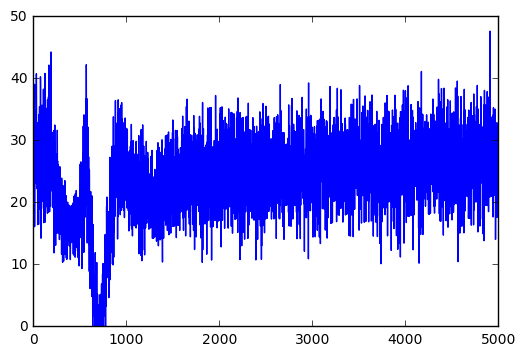

In [64]:
plt.plot(range(len(points)), points)